In [1]:
import numpy as np
import pandas as pd
import matplotlib
print(matplotlib.__version__)
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines
from glob import glob
from collections import Counter
import ns
import history_cmc as hic
import math
import scipy
from scipy.interpolate import interp1d
from scipy import stats
import matplotlib.cm as cm
import matplotlib as mpl
import random
from random import shuffle
import gzip
import sys
import astropy
from astropy import units

import ecc_calc as gwcalc
import unit_convert as uc
import merger_rate_calculator as mr
import ns_tidalcapture as tc
import conversions
import dynamics as dyn


%matplotlib inline

matplotlib.rcParams.update({'font.size': 24})
      
twopi=2.*np.pi
yearsc=3.1557*10**7
Kconst=9.87*10**-48 ##yr/G^2
Gconst=6.674*10**-8 ##cm3*g-1*s-2
Gconst_sun = 4.30091*10**-3 ##pc*M_sun**-1*(km/s)^2
clight=3*10**10 ##cm/s
Msun=2*10**33 ##gram
AU=1.496*10**13  ##cm
AU_Rsun=214.93946938362 ##AU to R_sun
PC=3.086*10**18  ##cm
PC_Rsun = 44334448.0068964 ##pc to R_sun

2.1.2


['/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/initial.snap0555.2D_SBPLcut15_NCUT.dat']
#t=11456.2

11456.2


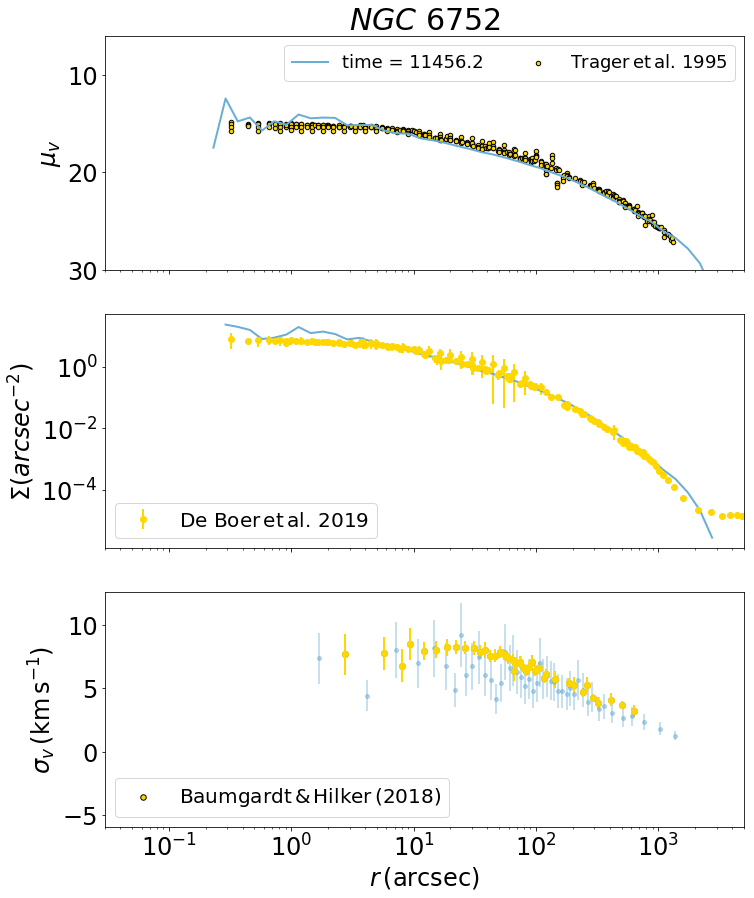

In [3]:
##For single model and snapshot

##Read in observation data
path = '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/'

cluster = 'ngc6752'

R_sun_obs=4.0

ngcno='6752'

ft = open('makeSBP/trager.dat','r')
linest = ft.readlines()

fv = open('makeSBP/vel_dispersion_profiles.dat','r')
linesv = fv.readlines()


flag = 0
#### find observed SBP from trager file
arcsec_t = []
SB_t = []
for k in range(len(linest)):
        linet = linest[k]
        linet = linet.split('\n')
        linet = linet[0]
        linet = linet.split('\t')
        cluster_tregar = linet[1]
        if cluster_tregar == cluster:
                arcsec_t.append(np.float(linet[2]))
                SB_t.append(np.float(linet[3]))
                flag = 1
arcsec_t = np.array(arcsec_t[:])
SB_t = np.array(SB_t[:])
if flag == 0:
        print('Trager doesnt have the SBP or sigma v profile')
        sys.exit()

flag = 0
#### find observed sigma_v profile
datav = np.genfromtxt('makeSBP/vel_dispersion_profiles.dat')
R_obs = [] # in arcsec
sigma_obs = []
sigma_err_obs_up = []
sigma_err_obs_down = []
for k in range(len(linesv)):
        linev = linesv[k]
        linev = linev.split('\n')
        linev = linev[0]
        linev = linev.split(' ')
        cluster_sigma = linev[0]
        if cluster_sigma == cluster:
                R_obs.append(datav[k,1])
                sigma_obs.append(datav[k,2])
                sigma_err_obs_up.append(datav[k,3])
                sigma_err_obs_down.append(datav[k,4])
                flag = 1
R_obs = np.array(R_obs[:])
sigma_obs = np.array(sigma_obs[:])
sigma_err_obs_up = np.array(sigma_err_obs_up[:])
sigma_err_obs_down = np.array(sigma_err_obs_down[:])
############
if flag == 0:
        print('No observed sigmav profile')
        sys.exit()
        

#datasd_miocchi = np.genfromtxt('makeSBP/miocchi.dat')
#arcsec_sd_miocchi = datasd_miocchi[:,0]
#sd_obs_miocchi = 10**np.array(datasd_miocchi[:,1])
#sd_err_miocchi = 10**np.array(datasd_miocchi[:,2])


datasd_deboer = np.genfromtxt('makeSBP/deboer'+ngcno+'.dat')
arcsec_sd_deboer = np.array(datasd_deboer[:,0])*60
sd_obs_deboer = np.array(datasd_deboer[:,1])/3600.
sd_err_deboer = np.array(datasd_deboer[:,2])/3600.


fig, ax=plt.subplots(3, 1, sharex=True,  figsize=(11,13))
ax[0].set_title(r'$NGC\ $'+ngcno, fontsize=30)
##Read in model data   
ax[2].scatter(R_obs, sigma_obs,c='gold',s=30, edgecolor='black')
ax[2].errorbar(R_obs,sigma_obs,yerr=2*sigma_err_obs_up, fmt='o',c='gold', lw=2.0)
ax[2].scatter([10000,10000],[-5,-5],c='gold',s=30, edgecolor='black',label=r'$\rm{Baumgardt\,&\,Hilker\,(2018)}$')

ax[1].errorbar(arcsec_sd_deboer, sd_obs_deboer, yerr = sd_err_deboer,
                fmt='o', c='gold', lw=2.0, label=r'$\rm{De\ Boer\,et\,al.\,2019}$')
#ax[1].errorbar(arcsec_sd_miocchi, sd_obs_miocchi, yerr = sd_err_miocchi, fmt='o',
#                c='green', lw=2.0, label=r'$\rm{Miocchi\,et\,al.\,2013}$')
    
ax[0].scatter(10**arcsec_t[:], SB_t[:],facecolor='gold',edgecolor='black',s=20,label=r'$\rm{Trager\,et\,al.\,1995}$')
    
snap2D = np.sort(glob(path+'initial.snap*.2Dproj.dat.gz'))
#print(snap2D)
snap2D_Ltot = np.sort(glob(path+'initial.snap*.2D_SBP_NCUT.dat'))
snap2D_L15 = np.sort(glob(path+'initial.snap*.2D_SBPLcut15_NCUT.dat'))
print(snap2D_L15)
snap_giant = np.sort(glob(path+'initial.snap*.vel_dispersion_giants_25.dat'))

cs = cm.Blues(np.linspace(0.5, 1, len(snap2D)))

    
for i in range(0, len(snap2D_L15)):
    with open(snap2D_L15[i], 'r') as f2D:
        first_line=f2D.readline()
    
    print(first_line)
            
    t_gyr = first_line.strip().split('=')[-1]
    print(t_gyr) 
    data5 = np.genfromtxt(snap2D_L15[i])
    arcsec = conversions.pc_to_arcsec(data5[:,1],R_sun_obs)
    SB = conversions.SB_converter(data5[:,3])
    SBerr = data5[:,6]/data5[:,5]*SB
    SD = conversions.SD_converter(data5[:,5], R_sun_obs)
    SDerr = conversions.SD_converter(data5[:,6], R_sun_obs)
    ND = conversions.SD_converter(data5[:,7], R_sun_obs)
    NDerr = conversions.SD_converter(data5[:,8], R_sun_obs)
    #print(ND)
        

    arcsec_cut = []
    SB_cut = []
    SBerr_cut = []
    arcsec_nd_cut = []
    ND_cut = []
    for k in range(len(SB)):
        if arcsec[k] < 10 and SB[k] > 20:
            Nothing = 0
        else:
            arcsec_cut.append(arcsec[k])
            SB_cut.append(SB[k])
            #SBerr_cut.append(SBerr[k])
        if ND[k]==0:
            continue
            #Nothing = 0
        else:
            ND_cut.append(ND[k])
            arcsec_nd_cut.append(arcsec[k])
            

    dataG = np.genfromtxt(snap_giant[i])
    R_model = conversions.pc_to_arcsec(dataG[:,0],R_sun_obs)
    sigma_model = dataG[:,1]
    sigma_err_model = dataG[:,2]

    ax[0].plot(arcsec_cut, SB_cut, lw=2, color=cs[i])
    ax[1].plot(arcsec_nd_cut, ND_cut, lw=2, color=cs[i])
    ax[2].scatter(R_model, sigma_model,s=15,zorder=2,alpha=0.5, color=cs[i])
    ax[2].errorbar(R_model,sigma_model,yerr=2*sigma_err_model, fmt='o',markersize=0.01,zorder=1,alpha=0.5, color=cs[i])
    #ax2.scatter(R_obs, sigma_obs,c='gold',s=30, edgecolor='black')
    #ax2.errorbar(R_obs,sigma_obs,yerr=2*sigma_err_obs_up, fmt='o',c='gold', lw=2.0)
    #############################

    #ax1.title(cluster,fontsize=24)
    #ax1.text(300,15,cluster,fontsize=20)
    ax[0].plot([10000,10000],[-5,-5], lw=2, label='time = '+str(t_gyr), color=cs[i])
    #ax1.scatter(10**arcsec_t[:], SB_t[:],facecolor='gold',edgecolor='black',s=20,label=r'$\rm{Trager\,et\,al.\,1995}$')
    ax[0].set_xscale('log')
    ax[0].set_xlim(0.03,5000)
    ax[0].set_ylim(30,6)
    #ax[0][x].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=20)
    ax[0].set_ylabel(r'$\mu_v$',fontsize=24)
    ax[0].legend(loc='best',scatterpoints=1, ncol=2, prop={'size': 18})
        
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_ylabel(r'$\Sigma(arcsec^{-2})$')
    #ax[1][x].set_ylim(0, 35)
    ax[1].legend(loc=3, scatterpoints=1, ncol=2, prop={'size': 20})

    #ax[2][x].scatter([10000,10000],[-5,-5],lw=2,label='time = '+str(t_gyr), color=cs[i])
    #ax2.scatter([10000,10000],[-5,-5],c='gold',s=30, edgecolor='black',label=r'$\rm{Baumgardt\,&\,Hilker\,(2018)}$')
    ax[2].set_xscale('log')
    ax[2].set_xlim(0.03,5000)
    #ax2.set_ylim(0,10)
    ax[2].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=24)
    ax[2].set_ylabel(r'$\sigma_v\,(\rm{km\,s^{-1}})$',fontsize=24)
    ax[2].legend(loc=3,scatterpoints=1, ncol=2, prop={'size': 20})
        
        
        
fig.tight_layout()
#plt.savefig('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/sbp_sdp_vel_'+ngcno+'.pdf', dpi=300)

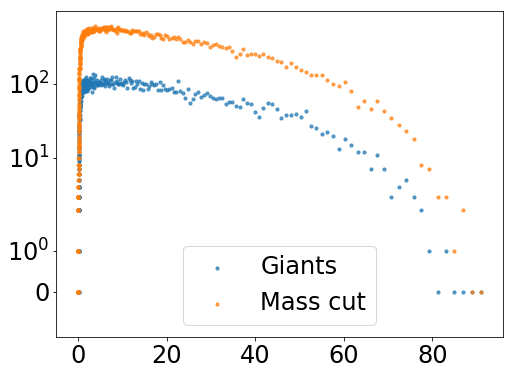

In [3]:
##Number of bright stars in radius bins
path = '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/'
snap2d = path+'initial.snap0529.2Dproj.dat.gz'

r_bin = np.logspace(np.log10(0.001), np.log10(92.), 501)
#print(r_bin)
r_bin_mid = [(r_bin[ii+1]+r_bin[ii])/2 for ii in range(len(r_bin)-1)]
#print(r_bin_mid)
star_bin_giant = np.zeros(500)
star_bin_masscut = np.zeros(500)
masscut = 0.8

ii = 1
with gzip.open(snap2d, 'r') as fsnap2d:
    next(fsnap2d); next(fsnap2d)
    for line in fsnap2d:
        data2d = line.split()
        if float(data2d[0]) < r_bin[ii]:
            if int(data2d[2])!=1 and 2<=int(data2d[3])<=9:
                star_bin_giant[ii-1]+=1
                
            if int(data2d[2])==1 and (2<=int(data2d[5])<=9 or 2<=int(data2d[6])<=9):
                star_bin_giant[ii-1]+=1
                
                
            if int(data2d[2])!=1 and float(data2d[9])>masscut and int(data2d[3])<10:
                star_bin_masscut[ii-1]+=1
                
            if int(data2d[2])==1 and ((float(data2d[10])>masscut and int(data2d[5])<10) or (float(data2d[11])>masscut and int(data2d[6])<10)):
                star_bin_masscut[ii-1]+=1
                
        else:
            ii+=1
            if int(data2d[2])!=1 and 2<=int(data2d[3])<=9:
                star_bin_giant[ii-1]+=1
                
            if int(data2d[2])==1 and (2<=int(data2d[5])<=9 or 2<=int(data2d[6])<=9):
                star_bin_giant[ii-1]+=1
                
                
            if int(data2d[2])!=1 and float(data2d[9])>masscut and int(data2d[3])<10:
                star_bin_masscut[ii-1]+=1
                
            if int(data2d[2])==1 and ((float(data2d[10])>masscut and int(data2d[5])<10) or (float(data2d[11])>masscut and int(data2d[6])<10)):
                star_bin_masscut[ii-1]+=1
            

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(r_bin_mid, star_bin_giant, s=10, alpha=0.7, label = 'Giants')
ax.scatter(r_bin_mid, star_bin_masscut, s=10, alpha=0.7, label ='Mass cut')
ax.set_yscale('symlog')
#ax.set_xscale('log')
ax.legend(loc = 'best')

In [21]:
##Observed surface brightness, velocity dispersion and number dnesity profiles


###########################################################
cluster = 'ngc104'

##Surface brightness
ft = open('makeSBP/trager.dat','r')
linest = ft.readlines()

flag = 0
#### find observed SBP from trager file
arcsec_t = []
SB_t = []
for k in range(len(linest)):
        linet = linest[k]
        linet = linet.split('\n')
        linet = linet[0]
        linet = linet.split('\t')
        cluster_tregar = linet[1]
        if cluster_tregar == cluster:
                arcsec_t.append(np.float(linet[2]))
                SB_t.append(np.float(linet[3]))
                flag = 1
arcsec_t = np.array(arcsec_t[:])
SB_t = np.array(SB_t[:])
if flag == 0:
        print('Trager doesnt have the SBP or sigma v profile')
        sys.exit()
        
        
##Trager data with uncertainties
from astropy.table import Table
data_t = Table.read('makeSBP/sbp_trager1995/trager1995_ngc104.fits')
rarcsec_trager = data_t['r[ARCSEC]']
sbp_trager = data_t['s[MAG/ARCSEC2]']
sbperr_trager = data_t['e_s[MAG/ARCSEC2]']


##Noyola Surface Brightness data
data_noyola = pd.read_excel('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/Noyola_Gebhardt_2006_SB.xlsx',
                           names = ['r_proj', 'Vmag', 'Vmag_up', 'Vmag_down'])
r_noyola = data_noyola['r_proj']  ##in arcsec
vmag_noyola = data_noyola['Vmag']  ##in mag/arcsec^2
vmag_noyola_up = data_noyola['Vmag_up']
vmag_noyola_down = data_noyola['Vmag_down']
vmag_noyola_err_up = vmag_noyola - vmag_noyola_up
vmag_noyola_err_down = vmag_noyola_down - vmag_noyola
vmag_noyola_err = (vmag_noyola_down - vmag_noyola_up)/2.


        
############################################################
##Velocity dispersion
distance = 4.52 ##kpc
def err_sigma(f, a, b, sigma_a, sigma_b, err_a, err_b):   ##f = sqrt(a*A^2+b*B^2)
    return np.sqrt((sigma_a/f)**2*a**2*err_a**2 + (sigma_b/f)**2*b**2*err_b**2)

def err_ratio(f, sigma_a, sigma_b, err_a, err_b):   ##f = A/B
    return np.abs(f)*np.sqrt((err_a/sigma_a)**2 + (err_b/sigma_b)**2)

#######################Proper motions#######################
##From Watkins_2015
df_watkins = np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/watkins2015_pm.txt', dtype = str)
gc_name_wk = df_watkins[:,0]
r_wk = df_watkins[:,3][gc_name_wk == 'NGC0104'].astype(np.float)  ##in arcsec
r_wk_err = df_watkins[:,4][gc_name_wk == 'NGC0104'].astype(np.float)
sigma_wk = df_watkins[:,5][gc_name_wk == 'NGC0104'].astype(np.float)  ##in mas/yr
sigma_wk_err = df_watkins[:,6][gc_name_wk == 'NGC0104'].astype(np.float)
tr_ratio_wk = df_watkins[:,7][gc_name_wk == 'NGC0104'].astype(np.float)
tr_ratio_err_wk = df_watkins[:,8][gc_name_wk == 'NGC0104'].astype(np.float)

##From Heyl_2017
df_heyl = pd.read_excel('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/heyl2017_pm.xlsx',
                        names = ['r_proj', 'sigmar_u', 'sigmar_d', 'sigmat_u', 'sigmat_d'])
r_hy = df_heyl['r_proj']*60.  ##in arcsec
sigmar_hy_u = df_heyl['sigmar_u']; sigmar_hy_d = df_heyl['sigmar_d']  ##in mas/yr
sigmat_hy_u = df_heyl['sigmat_u']; sigmat_hy_d = df_heyl['sigmat_d']  ##in mas/yr
sigmar_hy = (sigmar_hy_u+sigmar_hy_d)/2.; sigmar_hy_err = [sigmar_hy_u-sigmar_hy, sigmar_hy-sigmar_hy_d]
sigmat_hy = (sigmat_hy_u+sigmat_hy_d)/2.; sigmat_hy_err = [sigmat_hy_u-sigmat_hy, sigmat_hy-sigmat_hy_d]


sigma_hy = np.sqrt(sigmar_hy**2+sigmat_hy**2)/np.sqrt(2)
sigma_hy_err = [[],[]]
sigma_hy_err[0] = err_sigma(sigma_hy, 0.5, 0.5, sigmar_hy, sigmat_hy, sigmar_hy_err[0], sigmat_hy_err[0])
sigma_hy_err[1] = err_sigma(sigma_hy, 0.5, 0.5, sigmar_hy, sigmat_hy, sigmar_hy_err[1], sigmat_hy_err[1])
tr_ratio_hy = np.array(sigmat_hy)/np.array(sigmar_hy)
tr_ratio_hy_err = [[],[]]
tr_ratio_hy_err[0] = err_ratio(tr_ratio_hy, sigmat_hy, sigmar_hy, sigmat_hy_err[0], sigmar_hy_err[0])
tr_ratio_hy_err[1] = err_ratio(tr_ratio_hy, sigmat_hy, sigmar_hy, sigmat_hy_err[1], sigmar_hy_err[1])


##From Gaia EDR3
df_bg = pd.read_excel('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/Baumgardt_vel_dispersion_profile_47Tuc.xlsx',
                      names = ['name1', 'name2', 'r_proj', 'sigma', 'del_sigma_up', 'del_sigma_low', 'type'])
type_bg = df_bg['type']
r_bg = df_bg['r_proj'][type_bg == 'GEDR3']  ##in arcsec
sigma_bg = df_bg['sigma'][type_bg == 'GEDR3'] ##in km/s
del_sigmau_bg = df_bg['del_sigma_up'][type_bg == 'GEDR3']
del_sigmad_bg = df_bg['del_sigma_low'][type_bg == 'GEDR3']

df_vb = pd.read_excel('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/pm_tr_ratio_vasiliev_baumgardt2021.xlsx',
                      names = ['r_arcmin', 'tr_ratio1_up', 'tr_ratio1_down', 'tr_ratio1', 'tr_ratio', 'err_up', 'err_down'])
r_vb = df_vb['r_arcmin']*60.
tr_ratio_vb = df_vb['tr_ratio']
tr_ratio_vb_err = [df_vb['err_up'], df_vb['err_down']]


##Conerting units
sigma_wk_kms = uc.pm2vel(distance, sigma_wk)
print(sigma_wk_kms)
sigma_wk_err_kms = uc.pm2vel(distance, sigma_wk_err)

sigmar_hy_kms = uc.pm2vel(distance, sigmar_hy); sigmat_hy_kms = uc.pm2vel(distance, sigmat_hy)
sigma_hy_kms = uc.pm2vel(distance, sigma_hy)
sigma_hy_err_kms = [[], []]
sigma_hy_err_kms[0] = uc.pm2vel(distance, sigma_hy_err[0]); sigma_hy_err_kms[1] = uc.pm2vel(distance, sigma_hy_err[1])
sigmar_hy_err_kms = [[], []]; sigmat_hy_err_kms = [[], []]
sigmar_hy_err_kms[0] = uc.pm2vel(distance, sigmar_hy_err[0]); sigmar_hy_err_kms[1] = uc.pm2vel(distance, sigmar_hy_err[1])
sigmat_hy_err_kms[0] = uc.pm2vel(distance, sigmat_hy_err[0]); sigmat_hy_err_kms[1] = uc.pm2vel(distance, sigmat_hy_err[1])


#######################Radial velocities#######################
##From GAIA; Baumgardt 2017 & Baumgardt & Hilker 2018
r_bg_rv = df_bg['r_proj'][type_bg == 'RV']  ##in arcsec
sigma_bg_rv = df_bg['sigma'][type_bg == 'RV'] ##in km/s
del_sigmau_bg_rv = df_bg['del_sigma_up'][type_bg == 'RV']
del_sigmad_bg_rv = df_bg['del_sigma_low'][type_bg == 'RV']

##From Kamann et al. 2018
df_ka = pd.read_excel('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/Kamann2018_los_vel.xlsx',
                      names = ['r_arcsec', 'del_r_plus', 'del_r_minus', 'sigma_r', 'del_sigma_plus', 'del_sigma_minus'])
r_ka = df_ka['r_arcsec']; delr_ka_plus = df_ka['del_r_plus']; delr_ka_minus = df_ka['del_r_minus']
sigma_ka = df_ka['sigma_r']; sigma_ka_plus = df_ka['del_sigma_plus']; sigma_ka_minus = df_ka['del_sigma_minus']


########################################################################
##number density profile
datasd_miocchi = np.genfromtxt('makeSBP/miocchi.dat')
arcsec_sd_miocchi = datasd_miocchi[:,0]
sd_obs_miocchi = 10**np.array(datasd_miocchi[:,1])
sd_err_miocchi = 10**np.array(datasd_miocchi[:,2])


datasd_deboer = np.genfromtxt('makeSBP/deboer.dat')
arcsec_sd_deboer = np.array(datasd_deboer[:,0])*60
sd_obs_deboer = np.array(datasd_deboer[:,1])/3600.
sd_err_deboer = np.array(datasd_deboer[:,2])/3600.

[12.78139627 12.71150694 12.4116296  12.16532752 11.97247252 12.40680032
 12.10080483 11.84479479 12.03729717 11.50704069 12.06236363 11.91415413
 11.6484087  11.73156633 11.59625048 11.59996671 11.39107641 11.3630746
 11.26310402 11.01080918 10.90703997 10.60108421 10.71529238 10.56623136]


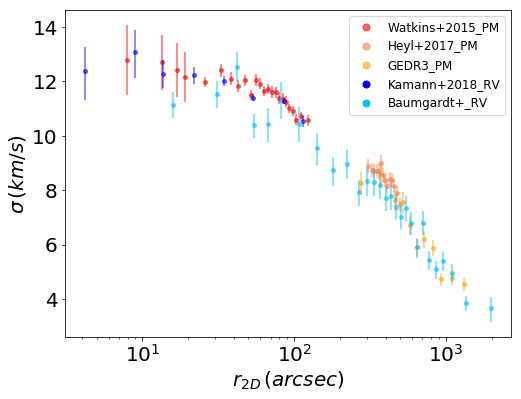

In [4]:
##Plotting
rdot=mlines.Line2D([], [],  linestyle = 'None', color='red', marker='o',
                  markersize=7, alpha=0.6, label='Watkins+2015_PM')
cdot=mlines.Line2D([], [],  linestyle = 'None', color='coral', marker='o',
                  markersize=7, alpha=0.6, label='Heyl+2017_PM')
odot=mlines.Line2D([], [],  linestyle = 'None', color='orange', marker='o',
                  markersize=7, alpha=0.6, label='GEDR3_PM')
bdot=mlines.Line2D([], [],  linestyle = 'None', color='blue', marker='o',
                  markersize=7, label='Kamann+2018_RV')
sbdot=mlines.Line2D([], [],  linestyle = 'None', color='deepskyblue', marker='o',
                  markersize=7, label='Baumgardt+_RV')


matplotlib.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(figsize = (8, 6))
axs.errorbar(r_wk,sigma_wk_kms ,yerr=sigma_wk_err_kms, fmt='o',markersize=0.01, alpha=0.6, color = 'red')
axs.scatter(r_wk, sigma_wk_kms, s=15, alpha = 0.6, color = 'red')

sigma_bg_err = (del_sigmau_bg+del_sigmad_bg)/2.
axs.scatter(r_bg, sigma_bg, s=15, alpha = 0.6, color = 'orange')
axs.errorbar(r_bg, sigma_bg, yerr=[del_sigmau_bg, del_sigmad_bg], fmt='o',markersize=0.01, alpha=0.6, color = 'orange')

axs.scatter(r_hy, sigma_hy_kms, s=15, alpha = 0.6, color = 'coral')
axs.errorbar(r_hy, sigma_hy_kms, yerr=sigma_hy_err_kms, fmt='o',markersize=0.01, alpha=0.6, color = 'coral')

sigma_bg_rv_err = (del_sigmau_bg_rv + del_sigmad_bg_rv)/2.
axs.scatter(r_bg_rv, sigma_bg_rv, s=15, alpha = 0.6, color = 'deepskyblue')
axs.errorbar(r_bg_rv, sigma_bg_rv, yerr=[del_sigmau_bg_rv, del_sigmad_bg_rv], fmt='o',markersize=0.01, alpha=0.6, color = 'deepskyblue')

sigma_ka_err = (sigma_ka_plus + sigma_ka_minus)/2.
axs.scatter(r_ka, sigma_ka, s=15, alpha = 0.6, color = 'blue')
axs.errorbar(r_ka, sigma_ka, yerr=[sigma_ka_plus, sigma_ka_minus], fmt='o',markersize=0.01, alpha=0.6, color = 'blue')


axs.set_xscale('log')
axs.set_xlabel(r'$r_{2D}\,(arcsec)$')
axs.set_ylabel(r'$\sigma\,(km/s)$')
#axs.legend(loc = 'best')
axs.legend(handles=[rdot, cdot, odot, bdot,sbdot], loc='best', prop={'size': 12}, numpoints=1, frameon=True)

##r2d_all = r_wk + r_bg + r_hy + r_bg_rv + r_ka
##vel_all = sigma_wk_kms + sigma_bg + sigma_hy_kms + sigma_bg_rv + sigma_ka
##vel_err_all_up = sigma_wk_err_kms + del_sigmau_bg + sigma_hy_err_kms + del_sigmau_bg_rv + sigma_ka_plus
##vel_err_all_down = sigma_wk_err_kms + del_sigmad_bg + sigma_hy_err_kms + del_sigmad_bg_rv + sigma_ka_minus

In [22]:
##Read in N-body fit and MOCHA fit data
xls_nbody = pd.ExcelFile('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/Baumgardt_Nbody_fit_47Tuc.xlsx')
xls_mocha = pd.ExcelFile('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/Giersz_MOCHAfit_47Tuc.xlsx')
df_nb_nuv = pd.read_excel(xls_nbody, 'Sheet1', names = ['r_arcsec', 'nu_v'])
df_nb_pm = pd.read_excel(xls_nbody, 'Sheet2', names = ['r_arcsec', 'pm'])
df_nb_rv = pd.read_excel(xls_nbody, 'Sheet3', names = ['r_arcsec', 'rv'])
df_mc_nuv = pd.read_excel(xls_mocha, 'Sheet1', names = ['r_arcsec', 'nu_v'])
df_mc_rv = pd.read_excel(xls_mocha, 'Sheet2', names = ['r_arcsec', 'rv', 'r_arcmin'])

##Read in Michie-King model fit
#xls_meylan = pd.ExcelFile('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/Meylan_1989.xlsx')
#df_mey_sb = pd.read_excel(xls_meylan, 'sbp', names = ['r_rc', 'nu_v'])
#df_mey_vd = pd.read_excel(xls_meylan, 'vdp', names = ['r_rc', 'rv_kms'])

#df_mey_sb_rarcsec = conversions.pc_to_arcsec(df_mey_sb['r_rc']*0.53, 4.7)
#df_mey_vd_rarcsec = conversions.pc_to_arcsec(df_mey_vd['r_rc']*0.53, 4.7)
#df_mey_sbperarcsec = df_mey_sb['nu_v']*0.53*0.53*conversions.pc_to_arcsec(0.53, 4.7)*conversions.pc_to_arcsec(0.53, 4.7)
#print(df_mey_sb['nu_v'])
#print(df_mey_sbperarcsec)
#print(conversions.pc_to_arcsec(0.53, 4.7)

In [2]:
#path = '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/'
#path = '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon_fixbin_ic/'
path = '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/observed_profiles/'

In [24]:
##Select best-fit snapshot
E_BV = 0.04
d47 = 4.52  ##kpc
Av = 0#3.1*E_BV

# Pull all snapshots to be searched
sbp_files = np.sort(glob(path+'initial.snap*.2D_SBPLcut12_NCUT0.85.dat'))
vdp_files = np.sort(glob(path+'initial.snap*.vel_dispersion_vr_pm_700_0.85.dat'))
#sbp_files = np.sort(glob(path+'initial.snap*.2D_SBPLcut15_NCUT0.8.dat'))
#vdp_files = np.sort(glob(path+'initial.snap*.vel_dispersion_giants_vr_pm_700_0.8.dat'))


# Read data SBP, VDP
# SBP uncertainty calculation follows that of McLaughlin & van der Marel 2005,
# and we remove points with infinite uncertainty ("goodness" 0)
rarcsec_trager = data_t['r[ARCSEC]']
sbp_trager = data_t['s[MAG/ARCSEC2]']
sbperr_trager = data_t['e_s[MAG/ARCSEC2]']

r_trag = rarcsec_trager[~np.isnan(sbperr_trager)]
sbp_trag = sbp_trager[~np.isnan(sbperr_trager)]
sbperr_trag = sbperr_trager[~np.isnan(sbperr_trager)]

##Adding the Noyola SBP
r_sbp_obs = list(r_trag) + list(r_noyola)
sbp_obs = list(sbp_trag) + list(vmag_noyola)
sbperr_obs = list(sbp_trag) + list(vmag_noyola_err)
r_sbp_obs_sort, sbp_obs_sort = (np.array(t) for t in zip(*sorted(zip(r_sbp_obs, sbp_obs))))
r_sbp_obs_sort, sbperr_obs_sort = (np.array(t) for t in zip(*sorted(zip(r_sbp_obs, sbperr_obs))))

r_rvpm = list(r_wk) + list(r_hy) + list(r_bg) + list(r_bg_rv) + list(r_ka)
vel_rvpm = list(sigma_wk_kms) + list(sigma_bg) + list(sigma_hy_kms) + list(sigma_bg_rv) + list(sigma_ka)
velerr_rvpm_u = list(sigma_wk_err_kms) + list(del_sigmau_bg) + list(sigma_hy_err_kms[0]) + list(del_sigmau_bg_rv) + list(sigma_ka_plus)
velerr_rvpm_d = list(sigma_wk_err_kms) + list(del_sigmad_bg) + list(sigma_hy_err_kms[1]) + list(del_sigmad_bg_rv) + list(sigma_ka_minus)

r_rvpm_sort, vel_rvpm_sort = (np.array(t) for t in zip(*sorted(zip(r_rvpm, vel_rvpm))))
r_rvpm_sort, velerr_rvpm_u_sort = (np.array(t) for t in zip(*sorted(zip(r_rvpm, velerr_rvpm_u))))
r_rvpm_sort, velerr_rvpm_d_sort = (np.array(t) for t in zip(*sorted(zip(r_rvpm, velerr_rvpm_d))))


# Calculate normalized chi square on all files
sbp_rchisq_list = np.array([])
vdp_rchisq_list = np.array([])

for ii in range(len(sbp_files)):
    sbp_ii = np.genfromtxt(sbp_files[ii])
    vdp_ii = np.genfromtxt(vdp_files[ii])
    
    r_sbp = uc.pc2arcsec(d47, sbp_ii[:,1]); sigma_sbp = conversions.SB_converter(sbp_ii[:,3])
    r_vdp = uc.pc2arcsec(d47, vdp_ii[:,0])
    
    # Interpolate SBP and VDP to calculate chisq
    ##Note I did not include Av here
    sbp_interp = interp1d(r_sbp, sigma_sbp+Av, bounds_error=False, fill_value=(sigma_sbp[0], 0))
    vdp_interp = interp1d(r_vdp, vdp_ii[:,1], bounds_error=False, fill_value=(vdp_ii[:,1][0], 0))
    
    sbp_chisq = np.sum((sbp_obs_sort - sbp_interp(r_sbp_obs_sort)) ** 2 / sbperr_obs_sort ** 2)
    
    
    data_above = np.where(vel_rvpm_sort > vdp_interp(r_rvpm_sort)) # treat upper and lower error bars differently
    data_below = np.where(vel_rvpm_sort < vdp_interp(r_rvpm_sort))
    vdp_chisq1 = np.sum((vel_rvpm_sort[data_above] - vdp_interp(r_rvpm_sort[data_above])) ** 2 / velerr_rvpm_d_sort[data_above] ** 2)
    vdp_chisq2 = np.sum((vel_rvpm_sort[data_below] - vdp_interp(r_rvpm_sort[data_below])) ** 2 / velerr_rvpm_u_sort[data_below] ** 2)
    
    sbp_rchisq = sbp_chisq / len(r_sbp_obs_sort)
    vdp_rchisq = (vdp_chisq1 + vdp_chisq2) / len(r_rvpm_sort)
    
    sbp_rchisq_list = np.append(sbp_rchisq_list, sbp_rchisq)
    vdp_rchisq_list = np.append(vdp_rchisq_list, vdp_rchisq)
    
    #print(f'Done {ii+1} snapshots of {len(sbp_files)}')
        
print(sbp_rchisq_list, vdp_rchisq_list)

##Selecting good fit snaps and Plotting
#snap_good_fit = np.where(np.max([sbp_rchisq_list, vdp_rchisq_list], axis=0) < 16.5)[0]
#snap_best_fit1 = np.min((np.array(sbp_rchisq_list)+np.array(vdp_rchisq_list))[snap_good_fit])
#snap_best_fit2 = np.max((np.array(sbp_rchisq_list)+np.array(vdp_rchisq_list))[snap_good_fit])
#tot_rchisq_list = (np.array(sbp_rchisq_list)+np.array(vdp_rchisq_list))[snap_good_fit]
#print(snap_good_fit, tot_rchisq_list)
#print(snap_best_fit1, snap_best_fit2)

#best_snap1 = snap_good_fit[np.where(tot_rchisq_list == snap_best_fit1)[0]][0]
#best_snap2 = snap_good_fit[np.where(tot_rchisq_list == snap_best_fit2)[0]][0]
#print(best_snap1, best_snap2)

#best_snap = 8
#print(np.array(sbp_files)[best_snap1])
#print(np.array(sbp_files)[best_snap2])
#print(np.array(sbp_files)[best_snap])

#sum_rchisq_list = np.array(sbp_rchisq_list)+np.array(vdp_rchisq_list)
#snap_min = np.min(sum_rchisq_list)
#print(sum_rchisq_list)
#print(snap_min)
#best_min = np.where(sum_rchisq_list == snap_min)[0]
#print(best_min, np.array(sbp_files)[best_min])

##Selecting good fit snaps and Plotting
snap_good_fit = np.where(np.max([sbp_rchisq_list, vdp_rchisq_list], axis=0) < 16.5)[0]
print(snap_good_fit)


sbp_files = np.array(sbp_files)[np.argsort(np.max([sbp_rchisq_list, vdp_rchisq_list], axis=0))]
vdp_files = np.array(vdp_files)[np.argsort(np.max([sbp_rchisq_list, vdp_rchisq_list], axis=0))]
chisqs = np.max([sbp_rchisq_list, vdp_rchisq_list], axis=0)[np.argsort(np.max([sbp_rchisq_list, vdp_rchisq_list], axis=0))]

for xx in range(17):
    with open(sbp_files[xx]) as fsbp:
        first_line = fsbp.readline().strip()
        t = first_line.split('=')[1]
    print(sbp_files[xx], t, chisqs[xx])
#print(sbp_files[:70])

[0.33436639 0.30904694 0.66357867 0.33546716 0.3790616  0.43513526
 0.503775   0.48447796 0.49814422 0.43490596 0.28382802 0.61120016
 0.70854094 1.34897711 0.4586431  0.57406329 0.79342818 0.97910903
 0.97774449 1.07408822 1.15585402 1.34846849 1.13779019 1.58186505
 1.72830584 1.50168606 1.57258579 1.83773091 2.51657371 2.18828679
 2.67120949 2.32915087 2.47796006 2.72285863 2.54490567 2.58309393] [18.07065455 18.00215124 17.51007179 18.04767713 18.01952231 17.45175822
 17.71733863 16.68491819 17.03796034 16.79234557 16.77582974 16.05781898
 16.68193392 15.940099   15.49354403 17.16149565 15.24328882 16.20893224
 15.87280952 14.69989775 15.18849194 16.10460308 16.36346304 16.58798175
 16.12781899 14.85849098 16.06072987 15.84813752 15.24847466 16.0697452
 16.1902089  16.53186997 16.94643464 16.60202074 16.708387   17.19527197]
[11 13 14 16 17 18 19 20 21 22 24 25 26 27 28 29 30]
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/observed_profi

#t=10549.3

10.549322533848


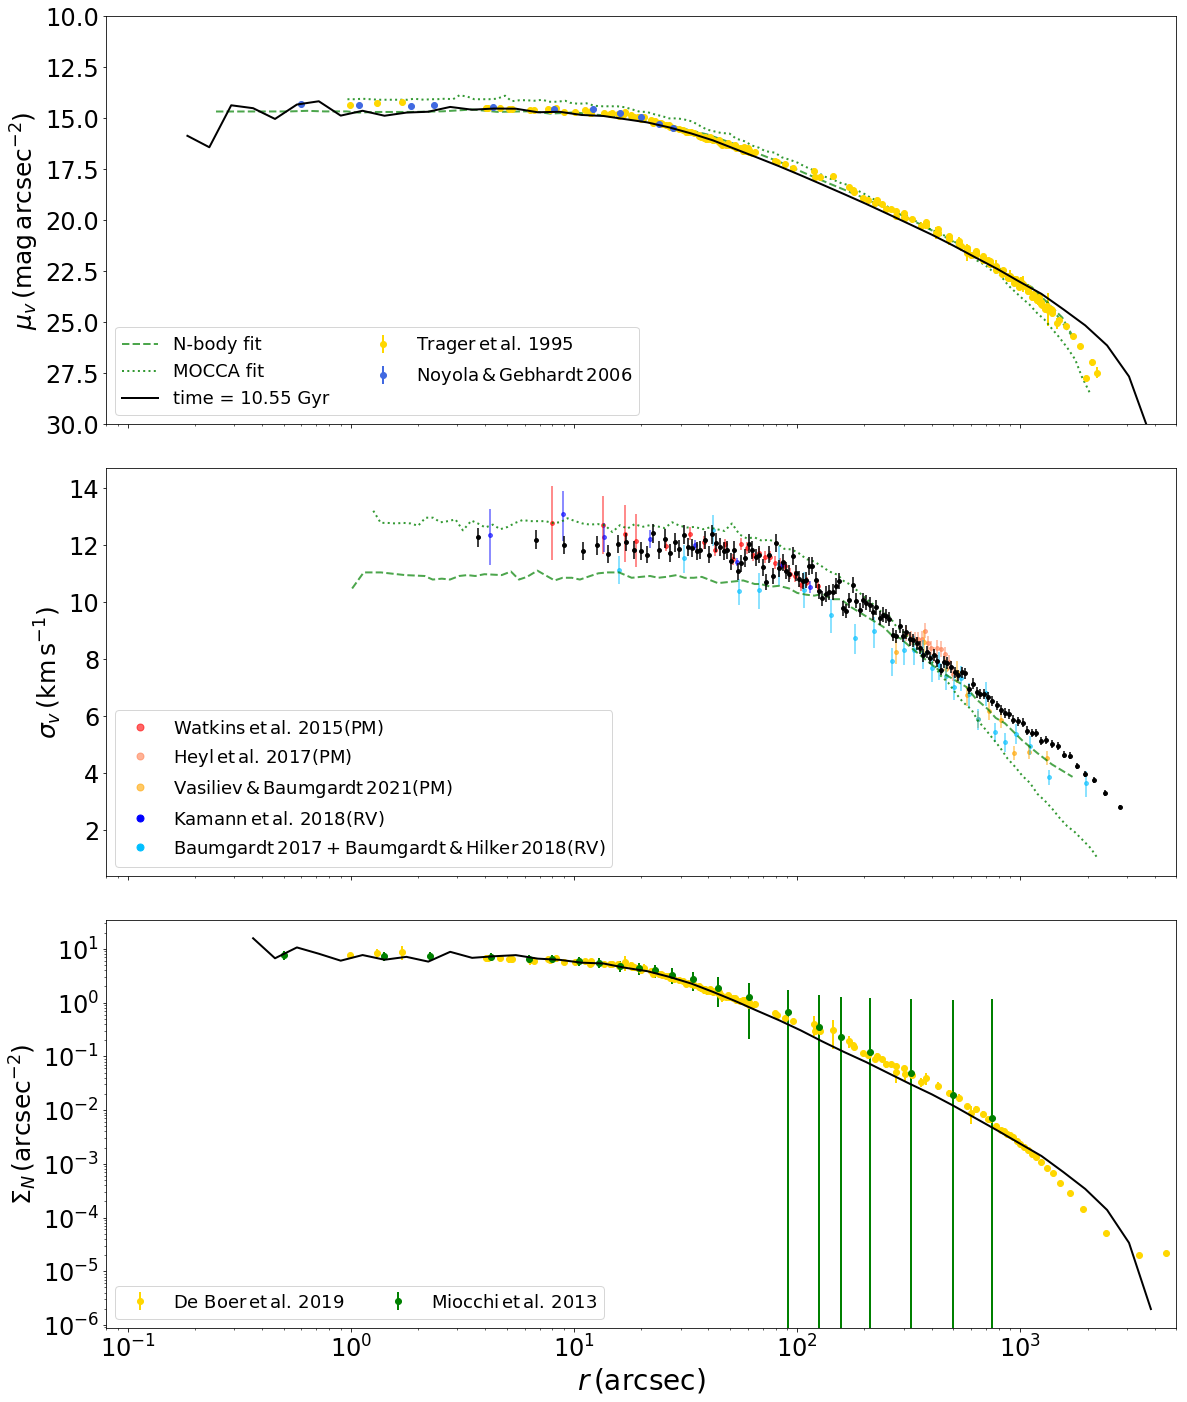

In [10]:
##Model paths: TC_on
R_sun_obs=4.52

t_conv = dyn.conv('t', path.replace('observed_profiles/', '')+'initial.conv.sh')

snapno = 733
######################################################
##Model data
snap2D = path+'initial.snap'+str(snapno)+'.2Dproj.dat.gz'
#print(snap2D)
snap2D_Ltot = path+'initial.snap'+str(snapno)+'.2D_SBP_NCUT0.85.dat'
snap2D_L15 = path+'initial.snap'+str(snapno)+'.2D_SBPLcut12_NCUT0.85.dat'
#snap_veldisp = path+'initial.snap0529.vel_dispersion_giants_vr_pm_700_0.8.dat'
snap_veldisp = path+'initial.snap'+str(snapno)+'.vel_dispersion_vr_pm_700_0.85.dat'
#print(snap_giant)

    
with gzip.open(snap2D, 'r') as f2D:
    first_line=f2D.readline().decode('utf8')
    
    print(first_line)
            
    t_gyr = 0.47867046*t_conv/1000.
    print(t_gyr) 

data5 = np.genfromtxt(snap2D_L15)
arcsec = conversions.pc_to_arcsec(data5[:,1],R_sun_obs)
SB = conversions.SB_converter(data5[:,3])
SBerr = data5[:,6]/data5[:,5]*SB
SD = conversions.SD_converter(data5[:,5], R_sun_obs)
SDerr = conversions.SD_converter(data5[:,6], R_sun_obs)

data_nd = np.genfromtxt(snap2D_Ltot)
ND = conversions.SD_converter(data_nd[:,7], R_sun_obs)
NDerr = conversions.SD_converter(data_nd[:,8], R_sun_obs)

        
arcsec_cut = []
SB_cut = []
SBerr_cut = []

for k in range(len(SB)):
    if arcsec[k] < 10 and SB[k] > 20:
        Nothing = 0
    else:
        arcsec_cut.append(arcsec[k])
        SB_cut.append(SB[k])
        #SBerr_cut.append(SBerr[k])
            
            
    
arcsec_nd_cut = []
ND_cut = []
for j in range(len(ND)):
    if ND[j]==0:
        continue
    else:
        ND_cut.append(ND[j])
        arcsec_nd_cut.append(arcsec[j])
        
                

data_vel = np.genfromtxt(snap_veldisp)
R_model = conversions.pc_to_arcsec(data_vel[:,0],R_sun_obs)
sigma_model = data_vel[:,1]
sigma_err_model = data_vel[:,2]


####################################################      
##Plotting        
rdot=mlines.Line2D([], [],  linestyle = 'None', color='red', marker='o',
                  markersize=7, alpha=0.6, label=r'$\rm{Watkins\,et\,al.\,2015(PM)}$')
cdot=mlines.Line2D([], [],  linestyle = 'None', color='coral', marker='o',
                  markersize=7, alpha=0.6, label=r'$\rm{Heyl\,et\,al.\,2017(PM)}$')
odot=mlines.Line2D([], [],  linestyle = 'None', color='orange', marker='o',
                  markersize=7, alpha=0.6, label=r'$\rm{Vasiliev\,&\,Baumgardt\,2021(PM)}$')
bdot=mlines.Line2D([], [],  linestyle = 'None', color='blue', marker='o',
                  markersize=7, label=r'$\rm{Kamann\,et\,al.\,2018(RV)}$')
sbdot=mlines.Line2D([], [],  linestyle = 'None', color='deepskyblue', marker='o',
                  markersize=7, label=r'$\rm{Baumgardt\,2017 + Baumgardt\,&\,Hilker\,2018(RV)}$')

fig, ax=plt.subplots(nrows = 3, sharex=True, sharey=False, figsize=(17,20))

########################
##Plotting in observed data 
ax[0].errorbar(r_trag, sbp_trag, yerr = sbperr_trag, fmt='o', lw = 2.0, color = 'gold',
               label=r'$\rm{Trager\,et\,al.\,1995}$')
ax[0].errorbar(r_noyola, vmag_noyola, yerr = vmag_noyola_err, fmt='o', lw = 2.0, color = 'royalblue',
               label=r'$\rm{Noyola\,&\,Gebhardt\,2006}$')


ax[1].errorbar(r_wk,sigma_wk_kms ,yerr=sigma_wk_err_kms, fmt='o',markersize=0.01, alpha=0.6, color = 'red')
ax[1].scatter(r_wk, sigma_wk_kms, s=15, alpha = 0.6, color = 'red')

ax[1].scatter(r_bg, sigma_bg, s=15, alpha = 0.6, color = 'orange')
ax[1].errorbar(r_bg, sigma_bg, yerr=[del_sigmau_bg, del_sigmad_bg], fmt='o',markersize=0.01, alpha=0.6, color = 'orange')

ax[1].scatter(r_hy, sigma_hy_kms, s=15, alpha = 0.6, color = 'coral')
ax[1].errorbar(r_hy, sigma_hy_kms, yerr=sigma_hy_err_kms, fmt='o',markersize=0.01, alpha=0.6, color = 'coral')

ax[1].scatter(r_bg_rv, sigma_bg_rv, s=15, alpha = 0.6, color = 'deepskyblue')
ax[1].errorbar(r_bg_rv, sigma_bg_rv, yerr=[del_sigmau_bg_rv, del_sigmad_bg_rv], fmt='o',markersize=0.01, alpha=0.6, color = 'deepskyblue')

ax[1].scatter(r_ka, sigma_ka, s=15, alpha = 0.6, color = 'blue')
ax[1].errorbar(r_ka, sigma_ka, yerr=[sigma_ka_plus, sigma_ka_minus], fmt='o',markersize=0.01, alpha=0.6, color = 'blue')

ax[2].errorbar(arcsec_sd_deboer, sd_obs_deboer, yerr = sd_err_deboer,
                      fmt='o', c='gold', lw=2.0, label=r'$\rm{De\ Boer\,et\,al.\,2019}$')
ax[2].errorbar(arcsec_sd_miocchi, sd_obs_miocchi, yerr = sd_err_miocchi, fmt='o',
                      c='green', lw=2.0, label=r'$\rm{Miocchi\,et\,al.\,2013}$')

#######################
##Plotting model data
ax[0].plot(arcsec_cut, np.array(SB_cut)+Av, color = 'k', lw=2, zorder = 3)
ax[1].scatter(R_model, sigma_model,s=15, color = 'k', zorder=3)
ax[1].errorbar(R_model,sigma_model,yerr=sigma_err_model, color = 'k', fmt='o',markersize=0.01,zorder=3)
ax[2].plot(arcsec_nd_cut, ND_cut, lw=2, color = 'k', zorder = 3)
#ax2.scatter(R_obs, sigma_obs,c='gold',s=30, edgecolor='black')
#ax2.errorbar(R_obs,sigma_obs,yerr=2*sigma_err_obs_up, fmt='o',c='gold', lw=2.0)


#######################
##Plotting other model fit data
ax[0].plot(df_nb_nuv['r_arcsec'], df_nb_nuv['nu_v'], lw = 2, ls = '--', color = 'g', alpha = 0.7, label='N-body fit')
ax[0].plot(df_mc_nuv['r_arcsec'], df_mc_nuv['nu_v'], lw = 2, ls = 'dotted', color = 'g', alpha = 0.8, label='MOCCA fit')

ax[1].plot(df_nb_rv['r_arcsec'], df_nb_rv['rv'], lw = 2, ls = '--', color = 'g', alpha = 0.7, label='N-body fit')
ax[1].plot(df_mc_rv['r_arcsec'], df_mc_rv['rv'], lw = 2, ls = 'dotted', color = 'g', alpha = 0.8, label='MOCCA fit')

#ax[0].plot(df_mey_sb_rarcsec, df_mey_sbperarcsec, lw = 2, ls = '-.', color = 'r', alpha = 0.7, label='Meylan89 fit')
#ax[1].plot(df_mey_vd_rarcsec, df_mey_vd['rv_kms'], lw = 2, ls = '-.', color = 'r', alpha = 0.7, label='Meylan89 fit')

#######################
ax[0].plot([10000,10000],[-5,-5], lw=2, color = 'k', label='time = '+str(round(t_gyr, 2))+' Gyr')
#ax1.scatter(10**arcsec_t[:], SB_t[:],facecolor='gold',edgecolor='black',s=20,label=r'$\rm{Trager\,et\,al.\,1995}$')
ax[0].set_xscale('log')
ax[0].set_xlim(0.08,5000)
ax[0].set_ylim(30,10)
#ax[0][x].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=20)
ax[0].set_ylabel(r'$\mu_v\,(\rm{mag\, arcsec^{-2}})$',fontsize=25)
ax[0].legend(loc='lower left',scatterpoints=1, ncol=2, prop={'size': 18})
    

ax[1].set_xscale('log')
ax[1].set_xlim(0.08,5000)
#ax2.set_ylim(0,10)
#ax[1].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=28)
ax[1].set_ylabel(r'$\sigma_v\,(\rm{km\,s^{-1}})$',fontsize=25)
#ax[1][x].legend(loc=3,scatterpoints=1, ncol=2, prop={'size': 20})
ax[1].legend(handles=[rdot, cdot, odot, bdot,sbdot], loc='best', prop={'size': 18}, numpoints=1, frameon=True)
    
    
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=28)
ax[2].set_ylabel(r'$\Sigma_N\,(\rm{arcsec^{-2}})$', fontsize=25)
#ax[1][x].set_ylim(0, 35)
ax[2].legend(loc=3, scatterpoints=1, ncol=2, prop={'size': 18})
        
        
        
fig.tight_layout()
plt.savefig('/projects/b1095/syr904/projects/massive_clusters/SBP_VDP_NDP_Elson_cmccosmicver1_updated.pdf', dpi=300)

In [ ]:
##Plot massive model from the CMC grid
path_32e5 = '/projects/b1091/CMC_Grid_March2019/rundir/rv1/rg20/z0.0002/3.2e6/'

R_sun_obs=4.52

t_conv = dyn.conv('t', path_32e5+'initial.conv.sh')


snapno = 1335
######################################################
##Model data
snap2D = path_32e5+'initial.snap'+str(snapno)+'.2Dproj.dat.gz'
#print(snap2D)
snap2D_Ltot = path_32e5+'initial.snap'+str(snapno)+'.2D_SBP_NCUT0.85.dat'
snap2D_L15 = path_32e5+'initial.snap'+str(snapno)+'.2D_SBPLcut12_NCUT0.85.dat'
#snap_veldisp = path+'initial.snap0529.vel_dispersion_giants_vr_pm_700_0.8.dat'
snap_veldisp = path_32e5+'initial.snap'+str(snapno)+'.vel_dispersion_vr_pm_700_0.85.dat'
#print(snap_giant)

    
with gzip.open(snap2D, 'r') as f2D:
    first_line=f2D.readline().decode('utf8')
    
    print(first_line)
            
    t_gyr = 3.0918728*t_conv/1000.
    print(t_gyr) 

data5 = np.genfromtxt(snap2D_L15)
arcsec = conversions.pc_to_arcsec(data5[:,1],R_sun_obs)
SB = conversions.SB_converter(data5[:,3])
SBerr = data5[:,6]/data5[:,5]*SB
SD = conversions.SD_converter(data5[:,5], R_sun_obs)
SDerr = conversions.SD_converter(data5[:,6], R_sun_obs)

data_nd = np.genfromtxt(snap2D_Ltot)
ND = conversions.SD_converter(data_nd[:,7], R_sun_obs)
NDerr = conversions.SD_converter(data_nd[:,8], R_sun_obs)

        
arcsec_cut = []
SB_cut = []
SBerr_cut = []

for k in range(len(SB)):
    if arcsec[k] < 10 and SB[k] > 20:
        Nothing = 0
    else:
        arcsec_cut.append(arcsec[k])
        SB_cut.append(SB[k])
        #SBerr_cut.append(SBerr[k])
            
            
    
arcsec_nd_cut = []
ND_cut = []
for j in range(len(ND)):
    if ND[j]==0:
        continue
    else:
        ND_cut.append(ND[j])
        arcsec_nd_cut.append(arcsec[j])
        
                

data_vel = np.genfromtxt(snap_veldisp)
R_model = conversions.pc_to_arcsec(data_vel[:,0],R_sun_obs)
sigma_model = data_vel[:,1]
sigma_err_model = data_vel[:,2]


####################################################      
##Plotting        
rdot=mlines.Line2D([], [],  linestyle = 'None', color='red', marker='o',
                  markersize=7, alpha=0.6, label='Watkins+2015_PM')
cdot=mlines.Line2D([], [],  linestyle = 'None', color='coral', marker='o',
                  markersize=7, alpha=0.6, label='Heyl+2017_PM')
odot=mlines.Line2D([], [],  linestyle = 'None', color='orange', marker='o',
                  markersize=7, alpha=0.6, label='GEDR3_PM')
bdot=mlines.Line2D([], [],  linestyle = 'None', color='blue', marker='o',
                  markersize=7, label='Kamann+2018_RV')
sbdot=mlines.Line2D([], [],  linestyle = 'None', color='deepskyblue', marker='o',
                  markersize=7, label='Baumgardt+_RV')

fig, ax=plt.subplots(nrows = 2, sharex=True, sharey=False, figsize=(10,10))

########################
##Plotting in observed data 
ax[0].errorbar(r_trag, sbp_trag, yerr = sbperr_trag, fmt='o', lw = 2.0, color = 'gold',
               label=r'$\rm{Trager\,et\,al.\,1995}$')

ax[1].errorbar(r_wk,sigma_wk_kms ,yerr=sigma_wk_err_kms, fmt='o',markersize=0.01, alpha=0.6, color = 'red')
ax[1].scatter(r_wk, sigma_wk_kms, s=15, alpha = 0.6, color = 'red')

ax[1].scatter(r_bg, sigma_bg, s=15, alpha = 0.6, color = 'orange')
ax[1].errorbar(r_bg, sigma_bg, yerr=[del_sigmau_bg, del_sigmad_bg], fmt='o',markersize=0.01, alpha=0.6, color = 'orange')

ax[1].scatter(r_hy, sigma_hy_kms, s=15, alpha = 0.6, color = 'coral')
ax[1].errorbar(r_hy, sigma_hy_kms, yerr=sigma_hy_err_kms, fmt='o',markersize=0.01, alpha=0.6, color = 'coral')

ax[1].scatter(r_bg_rv, sigma_bg_rv, s=15, alpha = 0.6, color = 'deepskyblue')
ax[1].errorbar(r_bg_rv, sigma_bg_rv, yerr=[del_sigmau_bg_rv, del_sigmad_bg_rv], fmt='o',markersize=0.01, alpha=0.6, color = 'deepskyblue')

ax[1].scatter(r_ka, sigma_ka, s=15, alpha = 0.6, color = 'blue')
ax[1].errorbar(r_ka, sigma_ka, yerr=[sigma_ka_plus, sigma_ka_minus], fmt='o',markersize=0.01, alpha=0.6, color = 'blue')

#ax[2].errorbar(arcsec_sd_deboer, sd_obs_deboer, yerr = sd_err_deboer,
#                      fmt='o', c='gold', lw=2.0, label=r'$\rm{De\ Boer\,et\,al.\,2019}$')
#ax[2].errorbar(arcsec_sd_miocchi, sd_obs_miocchi, yerr = sd_err_miocchi, fmt='o',
#                      c='green', lw=2.0, label=r'$\rm{Miocchi\,et\,al.\,2013}$')

#######################
##Plotting model data
ax[0].plot(arcsec_cut, np.array(SB_cut), color = 'k', lw=2, zorder = 3)
ax[1].scatter(R_model, sigma_model,s=15, color = 'k', zorder=3)
ax[1].errorbar(R_model,sigma_model,yerr=sigma_err_model, color = 'k', fmt='o',markersize=0.01,zorder=3)
#ax[2].plot(arcsec_nd_cut, ND_cut, lw=2, color = 'gray', zorder = 3)
#ax2.scatter(R_obs, sigma_obs,c='gold',s=30, edgecolor='black')
#ax2.errorbar(R_obs,sigma_obs,yerr=2*sigma_err_obs_up, fmt='o',c='gold', lw=2.0)


#######################
##Plotting other model fit data
#ax[0].plot(df_nb_nuv['r_arcsec'], df_nb_nuv['nu_v'], lw = 2, ls = '--', color = 'g', alpha = 0.7, label='N-body fit')
#ax[0].plot(df_mc_nuv['r_arcsec'], df_mc_nuv['nu_v'], lw = 2, ls = 'dotted', color = 'g', alpha = 0.8, label='MOCCA fit')

#ax[1].plot(df_nb_rv['r_arcsec'], df_nb_rv['rv'], lw = 2, ls = '--', color = 'g', alpha = 0.7, label='N-body fit')
#ax[1].plot(df_mc_rv['r_arcsec'], df_mc_rv['rv'], lw = 2, ls = 'dotted', color = 'g', alpha = 0.8, label='MOCCA fit')


#######################
ax[0].plot([10000,10000],[-5,-5], lw=2, color = 'k', label='time = '+str(round(t_gyr, 2))+' Gyr')
#ax1.scatter(10**arcsec_t[:], SB_t[:],facecolor='gold',edgecolor='black',s=20,label=r'$\rm{Trager\,et\,al.\,1995}$')
ax[0].set_xscale('log')
ax[0].set_xlim(0.08,5000)
ax[0].set_ylim(30,10)
#ax[0][x].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=20)
ax[0].set_ylabel(r'$\mu_v\,(\rm{mag\, arcsec^{-2}})$',fontsize=25)
ax[0].legend(loc='best',scatterpoints=1, ncol=2, prop={'size': 18})
    

ax[1].set_xscale('log')
ax[1].set_xlim(0.08,5000)
#ax2.set_ylim(0,10)
ax[1].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=28)
ax[1].set_ylabel(r'$\sigma_v\,(\rm{km\,s^{-1}})$',fontsize=25)
#ax[1][x].legend(loc=3,scatterpoints=1, ncol=2, prop={'size': 20})
ax[1].legend(handles=[rdot, cdot, odot, bdot,sbdot], loc='best', prop={'size': 18}, numpoints=1, frameon=True)
    
    
#ax[2].set_xscale('log')
#ax[2].set_yscale('log')
#ax[2].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=28)
#ax[2].set_ylabel(r'$\Sigma_N\,(\rm{arcsec^{-2}})$', fontsize=25)
##ax[1][x].set_ylim(0, 35)
#ax[2].legend(loc=3, scatterpoints=1, ncol=2, prop={'size': 18})
        
        
        
fig.tight_layout()
plt.savefig('/projects/b1095/syr904/projects/massive_clusters/SBP_VDP_King_32e5_rv1_z0.0002.pdf', dpi=300)


#t=10303.5

10.303514947152


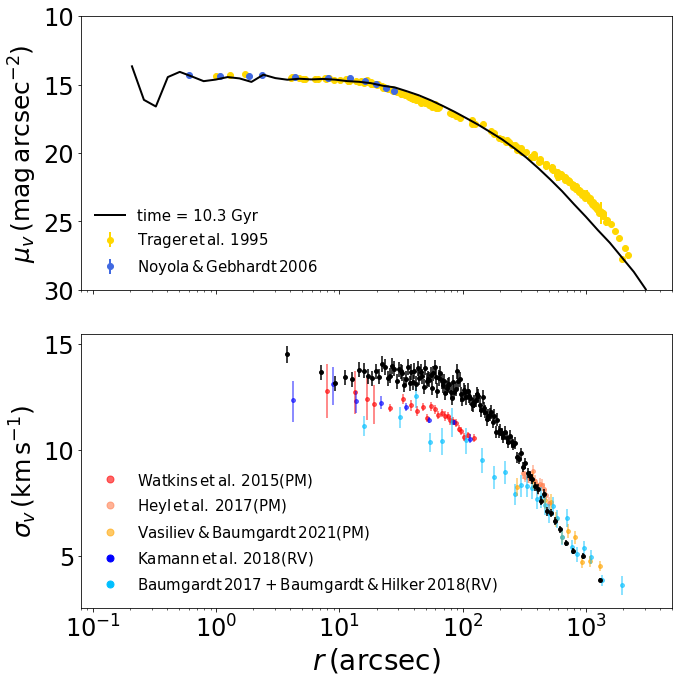

In [13]:
##Plot the best model using King profile
path_king = '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_150maxmass_rv1.4/'

R_sun_obs=4.52

t_conv = dyn.conv('t', path_king+'initial.conv.sh')


snapno = 610
######################################################
##Model data
snap2D = path_king+'initial.snap0'+str(snapno)+'.2Dproj.dat.gz'
#print(snap2D)
snap2D_Ltot = path_king+'initial.snap0'+str(snapno)+'.2D_SBP_NCUT0.85.dat'
snap2D_L15 = path_king+'initial.snap0'+str(snapno)+'.2D_SBPLcut12_NCUT0.85.dat'
#snap_veldisp = path+'initial.snap0529.vel_dispersion_giants_vr_pm_700_0.8.dat'
snap_veldisp = path_king+'initial.snap0'+str(snapno)+'.vel_dispersion_vr_pm_700_0.85.dat'
#print(snap_giant)

    
with gzip.open(snap2D, 'r') as f2D:
    first_line=f2D.readline().decode('utf8')
    
    print(first_line)
            
    t_gyr = 2.6584502*t_conv/1000.
    print(t_gyr) 

data5 = np.genfromtxt(snap2D_L15)
arcsec = conversions.pc_to_arcsec(data5[:,1],R_sun_obs)
SB = conversions.SB_converter(data5[:,3])
SBerr = data5[:,6]/data5[:,5]*SB
SD = conversions.SD_converter(data5[:,5], R_sun_obs)
SDerr = conversions.SD_converter(data5[:,6], R_sun_obs)

data_nd = np.genfromtxt(snap2D_Ltot)
ND = conversions.SD_converter(data_nd[:,7], R_sun_obs)
NDerr = conversions.SD_converter(data_nd[:,8], R_sun_obs)

        
arcsec_cut = []
SB_cut = []
SBerr_cut = []

for k in range(len(SB)):
    if arcsec[k] < 10 and SB[k] > 20:
        Nothing = 0
    else:
        arcsec_cut.append(arcsec[k])
        SB_cut.append(SB[k])
        #SBerr_cut.append(SBerr[k])
            
            
    
arcsec_nd_cut = []
ND_cut = []
for j in range(len(ND)):
    if ND[j]==0:
        continue
    else:
        ND_cut.append(ND[j])
        arcsec_nd_cut.append(arcsec[j])
        
                

data_vel = np.genfromtxt(snap_veldisp)
R_model = conversions.pc_to_arcsec(data_vel[:,0],R_sun_obs)
sigma_model = data_vel[:,1]
sigma_err_model = data_vel[:,2]


####################################################      
##Plotting        
fig, ax=plt.subplots(nrows = 2, sharex=True, sharey=False, figsize=(10,10))

########################
##Plotting in observed data 
ax[0].errorbar(r_trag, sbp_trag, yerr = sbperr_trag, fmt='o', lw = 2.0, color = 'gold',
               label=r'$\rm{Trager\,et\,al.\,1995}$')
ax[0].errorbar(r_noyola, vmag_noyola, yerr = vmag_noyola_err, fmt='o', lw = 2.0, color = 'royalblue',
               label=r'$\rm{Noyola\,&\,Gebhardt\,2006}$')

ax[1].errorbar(r_wk,sigma_wk_kms ,yerr=sigma_wk_err_kms, fmt='o',markersize=0.01, alpha=0.6, color = 'red')
ax[1].scatter(r_wk, sigma_wk_kms, s=15, alpha = 0.6, color = 'red')

ax[1].scatter(r_bg, sigma_bg, s=15, alpha = 0.6, color = 'orange')
ax[1].errorbar(r_bg, sigma_bg, yerr=[del_sigmau_bg, del_sigmad_bg], fmt='o',markersize=0.01, alpha=0.6, color = 'orange')

ax[1].scatter(r_hy, sigma_hy_kms, s=15, alpha = 0.6, color = 'coral')
ax[1].errorbar(r_hy, sigma_hy_kms, yerr=sigma_hy_err_kms, fmt='o',markersize=0.01, alpha=0.6, color = 'coral')

ax[1].scatter(r_bg_rv, sigma_bg_rv, s=15, alpha = 0.6, color = 'deepskyblue')
ax[1].errorbar(r_bg_rv, sigma_bg_rv, yerr=[del_sigmau_bg_rv, del_sigmad_bg_rv], fmt='o',markersize=0.01, alpha=0.6, color = 'deepskyblue')

ax[1].scatter(r_ka, sigma_ka, s=15, alpha = 0.6, color = 'blue')
ax[1].errorbar(r_ka, sigma_ka, yerr=[sigma_ka_plus, sigma_ka_minus], fmt='o',markersize=0.01, alpha=0.6, color = 'blue')

#ax[2].errorbar(arcsec_sd_deboer, sd_obs_deboer, yerr = sd_err_deboer,
#                      fmt='o', c='gold', lw=2.0, label=r'$\rm{De\ Boer\,et\,al.\,2019}$')
#ax[2].errorbar(arcsec_sd_miocchi, sd_obs_miocchi, yerr = sd_err_miocchi, fmt='o',
#                      c='green', lw=2.0, label=r'$\rm{Miocchi\,et\,al.\,2013}$')

#######################
##Plotting model data
ax[0].plot(arcsec_cut, np.array(SB_cut), color = 'k', lw=2, zorder = 3)
ax[1].scatter(R_model, sigma_model,s=15, color = 'k', zorder=3)
ax[1].errorbar(R_model,sigma_model,yerr=sigma_err_model, color = 'k', fmt='o',markersize=0.01,zorder=3)
#ax[2].plot(arcsec_nd_cut, ND_cut, lw=2, color = 'gray', zorder = 3)
#ax2.scatter(R_obs, sigma_obs,c='gold',s=30, edgecolor='black')
#ax2.errorbar(R_obs,sigma_obs,yerr=2*sigma_err_obs_up, fmt='o',c='gold', lw=2.0)


#######################
##Plotting other model fit data
#ax[0].plot(df_nb_nuv['r_arcsec'], df_nb_nuv['nu_v'], lw = 2, ls = '--', color = 'g', alpha = 0.7, label='N-body fit')
#ax[0].plot(df_mc_nuv['r_arcsec'], df_mc_nuv['nu_v'], lw = 2, ls = 'dotted', color = 'g', alpha = 0.8, label='MOCCA fit')

#ax[1].plot(df_nb_rv['r_arcsec'], df_nb_rv['rv'], lw = 2, ls = '--', color = 'g', alpha = 0.7, label='N-body fit')
#ax[1].plot(df_mc_rv['r_arcsec'], df_mc_rv['rv'], lw = 2, ls = 'dotted', color = 'g', alpha = 0.8, label='MOCCA fit')


#######################
ax[0].plot([10000,10000],[-5,-5], lw=2, color = 'k', label='time = '+str(round(t_gyr, 2))+' Gyr')
#ax1.scatter(10**arcsec_t[:], SB_t[:],facecolor='gold',edgecolor='black',s=20,label=r'$\rm{Trager\,et\,al.\,1995}$')
ax[0].set_xscale('log')
ax[0].set_xlim(0.08,5000)
ax[0].set_ylim(30,10)
#ax[0][x].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=20)
ax[0].set_ylabel(r'$\mu_v\,(\rm{mag\, arcsec^{-2}})$',fontsize=25)
ax[0].legend(loc='best',scatterpoints=1, ncol=1, prop={'size': 15}, frameon=False)
    

ax[1].set_xscale('log')
ax[1].set_xlim(0.08,5000)
#ax2.set_ylim(0,10)
ax[1].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=28)
ax[1].set_ylabel(r'$\sigma_v\,(\rm{km\,s^{-1}})$',fontsize=25)
#ax[1][x].legend(loc=3,scatterpoints=1, ncol=2, prop={'size': 20})
ax[1].legend(handles=[rdot, cdot, odot, bdot,sbdot], loc='best', prop={'size': 15}, numpoints=1, frameon=False)
    
    
#ax[2].set_xscale('log')
#ax[2].set_yscale('log')
#ax[2].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=28)
#ax[2].set_ylabel(r'$\Sigma_N\,(\rm{arcsec^{-2}})$', fontsize=25)
##ax[1][x].set_ylim(0, 35)
#ax[2].legend(loc=3, scatterpoints=1, ncol=2, prop={'size': 18})
        
        
        
fig.tight_layout()
plt.savefig('/projects/b1095/syr904/projects/massive_clusters/SBP_VDP_King_same_IC_cmc3.2.pdf', dpi=300)


#t=10545.3

10.5453


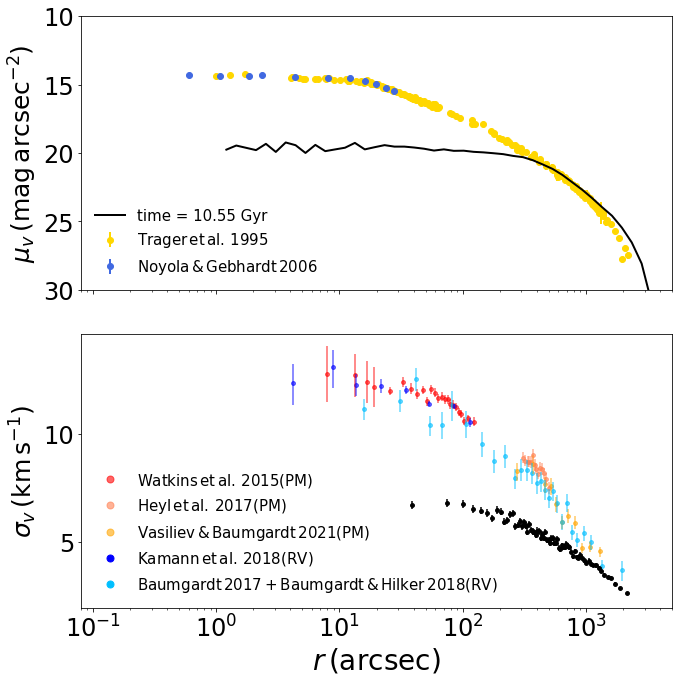

In [24]:
##Plot the best model using King profile
path_imf2d3 = '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon_IMFhigh2.3/'

R_sun_obs=4.52

t_conv = dyn.conv('t', path_imf2d3+'initial.conv.sh')


snapno = 479
######################################################
##Model data
snap2D = path_imf2d3+'initial.snap'+str(snapno)+'.2Dproj.dat.gz'
#print(snap2D)
snap2D_Ltot = path_imf2d3+'initial.snap'+str(snapno)+'.2D_SBP_NCUT0.85.dat'
snap2D_L15 = path_imf2d3+'initial.snap'+str(snapno)+'.2D_SBPLcut12_NCUT0.85.dat'
#snap_veldisp = path+'initial.snap0529.vel_dispersion_giants_vr_pm_700_0.8.dat'
snap_veldisp = path_imf2d3+'initial.snap'+str(snapno)+'.vel_dispersion_vr_pm_700_0.85.dat'
#print(snap_giant)


t_gyr = dyn.get_time(snap2D)/1000.
with gzip.open(snap2D, 'r') as f2D:
    first_line=f2D.readline().decode('utf8')
    
    print(first_line)
            
    #t_gyr = 2.6584502*t_conv/1000.
    print(t_gyr) 

data5 = np.genfromtxt(snap2D_L15)
arcsec = conversions.pc_to_arcsec(data5[:,1],R_sun_obs)
SB = conversions.SB_converter(data5[:,3])
SBerr = data5[:,6]/data5[:,5]*SB
SD = conversions.SD_converter(data5[:,5], R_sun_obs)
SDerr = conversions.SD_converter(data5[:,6], R_sun_obs)

data_nd = np.genfromtxt(snap2D_Ltot)
ND = conversions.SD_converter(data_nd[:,7], R_sun_obs)
NDerr = conversions.SD_converter(data_nd[:,8], R_sun_obs)

        
arcsec_cut = []
SB_cut = []
SBerr_cut = []

for k in range(len(SB)):
    if arcsec[k] < 10 and SB[k] > 20:
        Nothing = 0
    else:
        arcsec_cut.append(arcsec[k])
        SB_cut.append(SB[k])
        #SBerr_cut.append(SBerr[k])
            
            
    
arcsec_nd_cut = []
ND_cut = []
for j in range(len(ND)):
    if ND[j]==0:
        continue
    else:
        ND_cut.append(ND[j])
        arcsec_nd_cut.append(arcsec[j])
        
                

data_vel = np.genfromtxt(snap_veldisp)
R_model = conversions.pc_to_arcsec(data_vel[:,0],R_sun_obs)
sigma_model = data_vel[:,1]
sigma_err_model = data_vel[:,2]


####################################################      
##Plotting        
#rdot=mlines.Line2D([], [],  linestyle = 'None', color='red', marker='o',
#                  markersize=7, alpha=0.6, label='Watkins+2015_PM')
#cdot=mlines.Line2D([], [],  linestyle = 'None', color='coral', marker='o',
#                  markersize=7, alpha=0.6, label='Heyl+2017_PM')
#odot=mlines.Line2D([], [],  linestyle = 'None', color='orange', marker='o',
#                  markersize=7, alpha=0.6, label='GEDR3_PM')
#bdot=mlines.Line2D([], [],  linestyle = 'None', color='blue', marker='o',
#                  markersize=7, label='Kamann+2018_RV')
#sbdot=mlines.Line2D([], [],  linestyle = 'None', color='deepskyblue', marker='o',
#                  markersize=7, label='Baumgardt+_RV')

fig, ax=plt.subplots(nrows = 2, sharex=True, sharey=False, figsize=(10,10))

########################
##Plotting in observed data 
ax[0].errorbar(r_trag, sbp_trag, yerr = sbperr_trag, fmt='o', lw = 2.0, color = 'gold',
               label=r'$\rm{Trager\,et\,al.\,1995}$')
ax[0].errorbar(r_noyola, vmag_noyola, yerr = vmag_noyola_err, fmt='o', lw = 2.0, color = 'royalblue',
               label=r'$\rm{Noyola\,&\,Gebhardt\,2006}$')

ax[1].errorbar(r_wk,sigma_wk_kms ,yerr=sigma_wk_err_kms, fmt='o',markersize=0.01, alpha=0.6, color = 'red')
ax[1].scatter(r_wk, sigma_wk_kms, s=15, alpha = 0.6, color = 'red')

ax[1].scatter(r_bg, sigma_bg, s=15, alpha = 0.6, color = 'orange')
ax[1].errorbar(r_bg, sigma_bg, yerr=[del_sigmau_bg, del_sigmad_bg], fmt='o',markersize=0.01, alpha=0.6, color = 'orange')

ax[1].scatter(r_hy, sigma_hy_kms, s=15, alpha = 0.6, color = 'coral')
ax[1].errorbar(r_hy, sigma_hy_kms, yerr=sigma_hy_err_kms, fmt='o',markersize=0.01, alpha=0.6, color = 'coral')

ax[1].scatter(r_bg_rv, sigma_bg_rv, s=15, alpha = 0.6, color = 'deepskyblue')
ax[1].errorbar(r_bg_rv, sigma_bg_rv, yerr=[del_sigmau_bg_rv, del_sigmad_bg_rv], fmt='o',markersize=0.01, alpha=0.6, color = 'deepskyblue')

ax[1].scatter(r_ka, sigma_ka, s=15, alpha = 0.6, color = 'blue')
ax[1].errorbar(r_ka, sigma_ka, yerr=[sigma_ka_plus, sigma_ka_minus], fmt='o',markersize=0.01, alpha=0.6, color = 'blue')

#ax[2].errorbar(arcsec_sd_deboer, sd_obs_deboer, yerr = sd_err_deboer,
#                      fmt='o', c='gold', lw=2.0, label=r'$\rm{De\ Boer\,et\,al.\,2019}$')
#ax[2].errorbar(arcsec_sd_miocchi, sd_obs_miocchi, yerr = sd_err_miocchi, fmt='o',
#                      c='green', lw=2.0, label=r'$\rm{Miocchi\,et\,al.\,2013}$')

#######################
##Plotting model data
ax[0].plot(arcsec_cut[1:], np.array(SB_cut)[1:], color = 'k', lw=2, zorder = 3)
ax[1].scatter(R_model, sigma_model,s=15, color = 'k', zorder=3)
ax[1].errorbar(R_model,sigma_model,yerr=sigma_err_model, color = 'k', fmt='o',markersize=0.01,zorder=3)
#ax[2].plot(arcsec_nd_cut, ND_cut, lw=2, color = 'gray', zorder = 3)
#ax2.scatter(R_obs, sigma_obs,c='gold',s=30, edgecolor='black')
#ax2.errorbar(R_obs,sigma_obs,yerr=2*sigma_err_obs_up, fmt='o',c='gold', lw=2.0)


#######################
##Plotting other model fit data
#ax[0].plot(df_nb_nuv['r_arcsec'], df_nb_nuv['nu_v'], lw = 2, ls = '--', color = 'g', alpha = 0.7, label='N-body fit')
#ax[0].plot(df_mc_nuv['r_arcsec'], df_mc_nuv['nu_v'], lw = 2, ls = 'dotted', color = 'g', alpha = 0.8, label='MOCCA fit')

#ax[1].plot(df_nb_rv['r_arcsec'], df_nb_rv['rv'], lw = 2, ls = '--', color = 'g', alpha = 0.7, label='N-body fit')
#ax[1].plot(df_mc_rv['r_arcsec'], df_mc_rv['rv'], lw = 2, ls = 'dotted', color = 'g', alpha = 0.8, label='MOCCA fit')


#######################
ax[0].plot([10000,10000],[-5,-5], lw=2, color = 'k', label='time = '+str(round(t_gyr, 2))+' Gyr')
#ax1.scatter(10**arcsec_t[:], SB_t[:],facecolor='gold',edgecolor='black',s=20,label=r'$\rm{Trager\,et\,al.\,1995}$')
ax[0].set_xscale('log')
ax[0].set_xlim(0.08,5000)
ax[0].set_ylim(30,10)
#ax[0][x].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=20)
ax[0].set_ylabel(r'$\mu_v\,(\rm{mag\, arcsec^{-2}})$',fontsize=25)
ax[0].legend(loc='lower left',scatterpoints=1, ncol=1, prop={'size': 15}, frameon=False)
    

ax[1].set_xscale('log')
ax[1].set_xlim(0.08,5000)
#ax2.set_ylim(0,10)
ax[1].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=28)
ax[1].set_ylabel(r'$\sigma_v\,(\rm{km\,s^{-1}})$',fontsize=25)
#ax[1][x].legend(loc=3,scatterpoints=1, ncol=2, prop={'size': 20})
ax[1].legend(handles=[rdot, cdot, odot, bdot,sbdot], loc='best', prop={'size': 15}, numpoints=1, frameon=False)
    
    
#ax[2].set_xscale('log')
#ax[2].set_yscale('log')
#ax[2].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=28)
#ax[2].set_ylabel(r'$\Sigma_N\,(\rm{arcsec^{-2}})$', fontsize=25)
##ax[1][x].set_ylim(0, 35)
#ax[2].legend(loc=3, scatterpoints=1, ncol=2, prop={'size': 18})
        
        
        
fig.tight_layout()
plt.savefig('/projects/b1095/syr904/projects/massive_clusters/SBP_VDP_IMF2.3_updated.pdf', dpi=300)


#t=10383.9

10.383899999999999


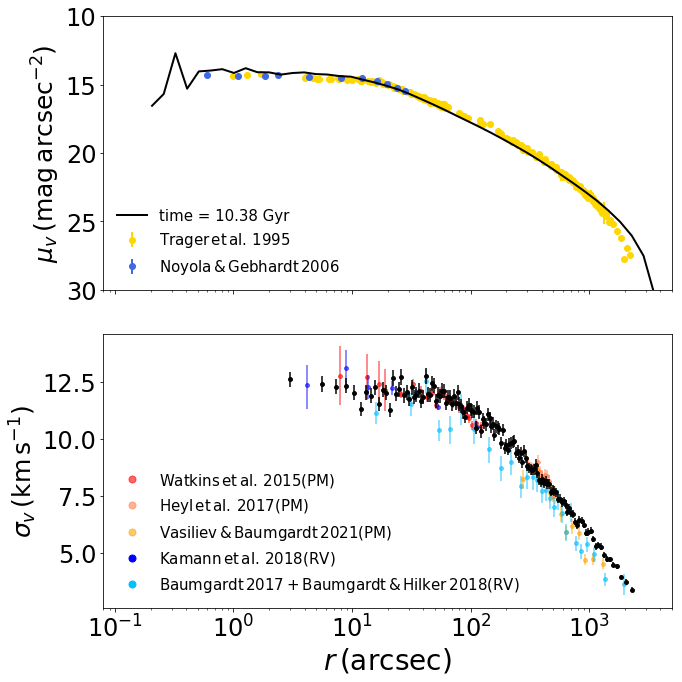

In [21]:
##Plot the best model using King profile
path_fb10 = '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv3.5_3e6_tcon_fb10/'

R_sun_obs=4.52

t_conv = dyn.conv('t', path_fb10+'initial.conv.sh')


snapno = 449
######################################################
##Model data
snap2D = path_fb10+'initial.snap'+str(snapno)+'.2Dproj.dat.gz'
#print(snap2D)
snap2D_Ltot = path_fb10+'initial.snap'+str(snapno)+'.2D_SBP_NCUT0.85.dat'
snap2D_L15 = path_fb10+'initial.snap'+str(snapno)+'.2D_SBPLcut12_NCUT0.85.dat'
#snap_veldisp = path+'initial.snap0529.vel_dispersion_giants_vr_pm_700_0.8.dat'
snap_veldisp = path_fb10+'initial.snap'+str(snapno)+'.vel_dispersion_vr_pm_700_0.85.dat'
#print(snap_giant)


t_gyr = dyn.get_time(snap2D)/1000.
with gzip.open(snap2D, 'r') as f2D:
    first_line=f2D.readline().decode('utf8')
    
    print(first_line)
            
    #t_gyr = 2.6584502*t_conv/1000.
    print(t_gyr) 

data5 = np.genfromtxt(snap2D_L15)
arcsec = conversions.pc_to_arcsec(data5[:,1],R_sun_obs)
SB = conversions.SB_converter(data5[:,3])
SBerr = data5[:,6]/data5[:,5]*SB
SD = conversions.SD_converter(data5[:,5], R_sun_obs)
SDerr = conversions.SD_converter(data5[:,6], R_sun_obs)

data_nd = np.genfromtxt(snap2D_Ltot)
ND = conversions.SD_converter(data_nd[:,7], R_sun_obs)
NDerr = conversions.SD_converter(data_nd[:,8], R_sun_obs)

        
arcsec_cut = []
SB_cut = []
SBerr_cut = []

for k in range(len(SB)):
    if arcsec[k] < 10 and SB[k] > 20:
        Nothing = 0
    else:
        arcsec_cut.append(arcsec[k])
        SB_cut.append(SB[k])
        #SBerr_cut.append(SBerr[k])
            
            
    
arcsec_nd_cut = []
ND_cut = []
for j in range(len(ND)):
    if ND[j]==0:
        continue
    else:
        ND_cut.append(ND[j])
        arcsec_nd_cut.append(arcsec[j])
        
                

data_vel = np.genfromtxt(snap_veldisp)
R_model = conversions.pc_to_arcsec(data_vel[:,0],R_sun_obs)
sigma_model = data_vel[:,1]
sigma_err_model = data_vel[:,2]


####################################################      
##Plotting        
#rdot=mlines.Line2D([], [],  linestyle = 'None', color='red', marker='o',
#                  markersize=7, alpha=0.6, label='Watkins+2015_PM')
#cdot=mlines.Line2D([], [],  linestyle = 'None', color='coral', marker='o',
#                  markersize=7, alpha=0.6, label='Heyl+2017_PM')
#odot=mlines.Line2D([], [],  linestyle = 'None', color='orange', marker='o',
#                  markersize=7, alpha=0.6, label='GEDR3_PM')
#bdot=mlines.Line2D([], [],  linestyle = 'None', color='blue', marker='o',
#                  markersize=7, label='Kamann+2018_RV')
#sbdot=mlines.Line2D([], [],  linestyle = 'None', color='deepskyblue', marker='o',
#                  markersize=7, label='Baumgardt+_RV')

fig, ax=plt.subplots(nrows = 2, sharex=True, sharey=False, figsize=(10,10))

########################
##Plotting in observed data 
ax[0].errorbar(r_trag, sbp_trag, yerr = sbperr_trag, fmt='o', lw = 2.0, color = 'gold',
               label=r'$\rm{Trager\,et\,al.\,1995}$')
ax[0].errorbar(r_noyola, vmag_noyola, yerr = vmag_noyola_err, fmt='o', lw = 2.0, color = 'royalblue',
               label=r'$\rm{Noyola\,&\,Gebhardt\,2006}$')

ax[1].errorbar(r_wk,sigma_wk_kms ,yerr=sigma_wk_err_kms, fmt='o',markersize=0.01, alpha=0.6, color = 'red')
ax[1].scatter(r_wk, sigma_wk_kms, s=15, alpha = 0.6, color = 'red')

ax[1].scatter(r_bg, sigma_bg, s=15, alpha = 0.6, color = 'orange')
ax[1].errorbar(r_bg, sigma_bg, yerr=[del_sigmau_bg, del_sigmad_bg], fmt='o',markersize=0.01, alpha=0.6, color = 'orange')

ax[1].scatter(r_hy, sigma_hy_kms, s=15, alpha = 0.6, color = 'coral')
ax[1].errorbar(r_hy, sigma_hy_kms, yerr=sigma_hy_err_kms, fmt='o',markersize=0.01, alpha=0.6, color = 'coral')

ax[1].scatter(r_bg_rv, sigma_bg_rv, s=15, alpha = 0.6, color = 'deepskyblue')
ax[1].errorbar(r_bg_rv, sigma_bg_rv, yerr=[del_sigmau_bg_rv, del_sigmad_bg_rv], fmt='o',markersize=0.01, alpha=0.6, color = 'deepskyblue')

ax[1].scatter(r_ka, sigma_ka, s=15, alpha = 0.6, color = 'blue')
ax[1].errorbar(r_ka, sigma_ka, yerr=[sigma_ka_plus, sigma_ka_minus], fmt='o',markersize=0.01, alpha=0.6, color = 'blue')

#ax[2].errorbar(arcsec_sd_deboer, sd_obs_deboer, yerr = sd_err_deboer,
#                      fmt='o', c='gold', lw=2.0, label=r'$\rm{De\ Boer\,et\,al.\,2019}$')
#ax[2].errorbar(arcsec_sd_miocchi, sd_obs_miocchi, yerr = sd_err_miocchi, fmt='o',
#                      c='green', lw=2.0, label=r'$\rm{Miocchi\,et\,al.\,2013}$')

#######################
##Plotting model data
ax[0].plot(arcsec_cut[1:], np.array(SB_cut)[1:], color = 'k', lw=2, zorder = 3)
ax[1].scatter(R_model, sigma_model,s=15, color = 'k', zorder=3)
ax[1].errorbar(R_model,sigma_model,yerr=sigma_err_model, color = 'k', fmt='o',markersize=0.01,zorder=3)
#ax[2].plot(arcsec_nd_cut, ND_cut, lw=2, color = 'gray', zorder = 3)
#ax2.scatter(R_obs, sigma_obs,c='gold',s=30, edgecolor='black')
#ax2.errorbar(R_obs,sigma_obs,yerr=2*sigma_err_obs_up, fmt='o',c='gold', lw=2.0)


#######################
##Plotting other model fit data
#ax[0].plot(df_nb_nuv['r_arcsec'], df_nb_nuv['nu_v'], lw = 2, ls = '--', color = 'g', alpha = 0.7, label='N-body fit')
#ax[0].plot(df_mc_nuv['r_arcsec'], df_mc_nuv['nu_v'], lw = 2, ls = 'dotted', color = 'g', alpha = 0.8, label='MOCCA fit')

#ax[1].plot(df_nb_rv['r_arcsec'], df_nb_rv['rv'], lw = 2, ls = '--', color = 'g', alpha = 0.7, label='N-body fit')
#ax[1].plot(df_mc_rv['r_arcsec'], df_mc_rv['rv'], lw = 2, ls = 'dotted', color = 'g', alpha = 0.8, label='MOCCA fit')


#######################
ax[0].plot([10000,10000],[-5,-5], lw=2, color = 'k', label='time = '+str(round(t_gyr, 2))+' Gyr')
#ax1.scatter(10**arcsec_t[:], SB_t[:],facecolor='gold',edgecolor='black',s=20,label=r'$\rm{Trager\,et\,al.\,1995}$')
ax[0].set_xscale('log')
ax[0].set_xlim(0.08,5000)
ax[0].set_ylim(30,10)
#ax[0][x].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=20)
ax[0].set_ylabel(r'$\mu_v\,(\rm{mag\, arcsec^{-2}})$',fontsize=25)
ax[0].legend(loc='best',scatterpoints=1, ncol=1, prop={'size': 15}, frameon = False)
    

ax[1].set_xscale('log')
ax[1].set_xlim(0.08,5000)
#ax2.set_ylim(0,10)
ax[1].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=28)
ax[1].set_ylabel(r'$\sigma_v\,(\rm{km\,s^{-1}})$',fontsize=25)
#ax[1][x].legend(loc=3,scatterpoints=1, ncol=2, prop={'size': 20})
ax[1].legend(handles=[rdot, cdot, odot, bdot,sbdot], loc='best', prop={'size': 15}, numpoints=1, frameon=False)
    
    
#ax[2].set_xscale('log')
#ax[2].set_yscale('log')
#ax[2].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=28)
#ax[2].set_ylabel(r'$\Sigma_N\,(\rm{arcsec^{-2}})$', fontsize=25)
##ax[1][x].set_ylim(0, 35)
#ax[2].legend(loc=3, scatterpoints=1, ncol=2, prop={'size': 18})
        
        
        
fig.tight_layout()
plt.savefig('/projects/b1095/syr904/projects/massive_clusters/SBP_VDP_fb10_updated.pdf', dpi=300)


[12.78139627 12.71150694 12.4116296  12.16532752 11.97247252 12.40680032
 12.10080483 11.84479479 12.03729717 11.50704069 12.06236363 11.91415413
 11.6484087  11.73156633 11.59625048 11.59996671 11.39107641 11.3630746
 11.26310402 11.01080918 10.90703997 10.60108421 10.71529238 10.56623136]


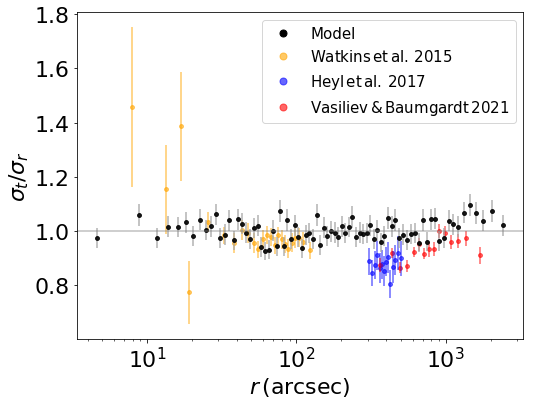

In [19]:
##Comapring proper motions
distance = 4.52 ##kpc
dec_47 = -(72.+4.*60.+52.7*3600)*np.pi/180.

def err_sigma(f, a, b, sigma_a, sigma_b, err_a, err_b):   ##f = sqrt(a*A^2+b*B^2)
    return np.sqrt((sigma_a/f)**2*a**2*err_a**2 + (sigma_b/f)**2*b**2*err_b**2)

def err_ratio(f, sigma_a, sigma_b, err_a, err_b):   ##f = A/B
    return np.abs(f)*np.sqrt((err_a/sigma_a)**2 + (err_b/sigma_b)**2)
    

##From Watkins_2015
df_watkins = np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/watkins2015_pm.txt', dtype = str)
gc_name_wk = df_watkins[:,0]
r_wk = df_watkins[:,3][gc_name_wk == 'NGC0104'].astype(np.float)  ##in arcsec
r_wk_err = df_watkins[:,4][gc_name_wk == 'NGC0104'].astype(np.float)
sigma_wk = df_watkins[:,5][gc_name_wk == 'NGC0104'].astype(np.float)  ##in mas/yr
sigma_wk_err = df_watkins[:,6][gc_name_wk == 'NGC0104'].astype(np.float)
tr_ratio_wk = df_watkins[:,7][gc_name_wk == 'NGC0104'].astype(np.float)
tr_ratio_err_wk = df_watkins[:,8][gc_name_wk == 'NGC0104'].astype(np.float)

##From Heyl_2017
df_heyl = pd.read_excel('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/heyl2017_pm.xlsx',
                        names = ['r_proj', 'sigmar_u', 'sigmar_d', 'sigmat_u', 'sigmat_d'])
r_hy = df_heyl['r_proj']*60.  ##in arcsec
sigmar_hy_u = df_heyl['sigmar_u']; sigmar_hy_d = df_heyl['sigmar_d']  ##in mas/yr
sigmat_hy_u = df_heyl['sigmat_u']; sigmat_hy_d = df_heyl['sigmat_d']  ##in mas/yr
sigmar_hy = (sigmar_hy_u+sigmar_hy_d)/2.; sigmar_hy_err = [sigmar_hy_u-sigmar_hy, sigmar_hy-sigmar_hy_d]
sigmat_hy = (sigmat_hy_u+sigmat_hy_d)/2.; sigmat_hy_err = [sigmat_hy_u-sigmat_hy, sigmat_hy-sigmat_hy_d]

sigma_hy = np.sqrt(sigmar_hy**2+sigmat_hy**2)/np.sqrt(2)
sigma_hy_err = [[],[]]
sigma_hy_err[0] = err_sigma(sigma_hy, 0.5, 0.5, sigmar_hy, sigmat_hy, sigmar_hy_err[0], sigmat_hy_err[0])
sigma_hy_err[1] = err_sigma(sigma_hy, 0.5, 0.5, sigmar_hy, sigmat_hy, sigmar_hy_err[1], sigmat_hy_err[1])
tr_ratio_hy = np.array(sigmat_hy)/np.array(sigmar_hy)
tr_ratio_hy_err = [[],[]]
tr_ratio_hy_err[0] = err_ratio(tr_ratio_hy, sigmat_hy, sigmar_hy, sigmat_hy_err[0], sigmar_hy_err[0])
tr_ratio_hy_err[1] = err_ratio(tr_ratio_hy, sigmat_hy, sigmar_hy, sigmat_hy_err[1], sigmar_hy_err[1])



##From Gaia EDR3
df_bg = pd.read_excel('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/Baumgardt_vel_dispersion_profile_47Tuc.xlsx',
                      names = ['name1', 'name2', 'r_proj', 'sigma', 'del_sigma_up', 'del_sigma_low', 'type'])
type_bg = df_bg['type']
r_bg = df_bg['r_proj'][type_bg == 'GEDR3']  ##in arcsec
sigma_bg = df_bg['sigma'][type_bg == 'GEDR3'] ##in km/s
del_sigmau_bg = df_bg['del_sigma_up'][type_bg == 'GEDR3']
del_sigmad_bg = df_bg['del_sigma_low'][type_bg == 'GEDR3']

df_vb = pd.read_excel('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/pm_tr_ratio_vasiliev_baumgardt2021.xlsx',
                      names = ['r_arcmin', 'tr_ratio1_up', 'tr_ratio1_down', 'tr_ratio1', 'tr_ratio', 'err_up', 'err_down'])
r_vb = df_vb['r_arcmin']*60.
tr_ratio_vb = df_vb['tr_ratio']
tr_ratio_vb_err = [df_vb['err_up'], df_vb['err_down']]

##From models
df_model_529 = np.genfromtxt(path+'initial.snap757.vel_dispersion_vr_pm_700_0.85.dat')
#df_model_529 = np.genfromtxt('/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/initial.snap726.vel_dispersion_vr_pm_700_0.85.dat')
r2d = df_model_529[:,0]  ##in pc
sigma_pmr = df_model_529[:,3]; sigma_pmr_err = df_model_529[:,4]  ##in km/s
sigma_pmt = df_model_529[:,5]; sigma_pmt_err = df_model_529[:,6]
#sigma_pm = df_model_529[:,-2]; sigma_pm_err = df_model_529[:,-1]
sigma_pm = np.sqrt(sigma_pmr**2+sigma_pmt**2)/np.sqrt(2)
sigma_pm_err = err_sigma(sigma_pm, 0.5, 0.5, sigma_pmr, sigma_pmt, sigma_pmr_err, sigma_pmt_err)
tr_ratio = sigma_pmt/sigma_pmr
tr_ratio_err = err_ratio(tr_ratio, sigma_pmt, sigma_pmr, sigma_pmt_err, sigma_pmr_err)


##Conerting units
r2d_arcsec = uc.pc2arcsec(distance, r2d)
sigma_wk_kms = uc.pm2vel(distance, sigma_wk)
print(sigma_wk_kms)
sigma_wk_err_kms = uc.pm2vel(distance, sigma_wk_err)

sigmar_hy_kms = uc.pm2vel(distance, sigmar_hy); sigmat_hy_kms = uc.pm2vel(distance, sigmat_hy)
sigma_hy_kms = uc.pm2vel(distance, sigma_hy)
sigma_hy_err_kms = [[], []]
sigma_hy_err_kms[0] = uc.pm2vel(distance, sigma_hy_err[0]); sigma_hy_err_kms[1] = uc.pm2vel(distance, sigma_hy_err[1])
sigmar_hy_err_kms = [[], []]; sigmat_hy_err_kms = [[], []]
sigmar_hy_err_kms[0] = uc.pm2vel(distance, sigmar_hy_err[0]); sigmar_hy_err_kms[1] = uc.pm2vel(distance, sigmar_hy_err[1])
sigmat_hy_err_kms[0] = uc.pm2vel(distance, sigmat_hy_err[0]); sigmat_hy_err_kms[1] = uc.pm2vel(distance, sigmat_hy_err[1])




##Plotting
rdot=mlines.Line2D([], [],  linestyle = 'None', color='red', marker='o',
                  markersize=7, alpha=0.6, label=r'$\rm{Vasiliev\,&\,Baumgardt\,2021}$')
bdot=mlines.Line2D([], [],  linestyle = 'None', color='BLUE', marker='o',
                  markersize=7, alpha=0.6, label=r'$\rm{Heyl\,et\,al.\,2017}$')
odot=mlines.Line2D([], [],  linestyle = 'None', color='orange', marker='o',
                  markersize=7, alpha=0.6, label=r'$\rm{Watkins\,et\,al.\,2015}$')
kdot=mlines.Line2D([], [],  linestyle = 'None', color='k', marker='o',
                  markersize=7, label='Model')
kline = mlines.Line2D([], [],  linestyle = '--', color='k', linewidth = 1.5, label='N-body fit')



#matplotlib.rcParams.update({'font.size': 20})
#fig, axs = plt.subplots(ncols = 2, figsize = (18, 6))
#axs[0].plot(df_nb_pm['r_arcsec'], df_nb_pm['pm'], lw = 1.5, ls = '--', color = 'k', label='N-body fit')
#axs[0].errorbar(r2d_arcsec,sigma_pm ,yerr=sigma_pm_err, fmt='o',markersize=0.01, alpha=0.9, color = 'darkgray')
#axs[0].scatter(r2d_arcsec, sigma_pm, s=15, alpha=0.9, color = 'darkgray')
#axs[0].errorbar(r_wk,sigma_wk_kms ,yerr=sigma_wk_err_kms, fmt='o',markersize=0.01, alpha=0.6, color = 'orange')
#axs[0].scatter(r_wk, sigma_wk_kms, s=15, alpha = 0.6, color = 'orange')
#axs[0].scatter(r_bg, sigma_bg, s=15, alpha = 0.6, color = 'red')
#axs[0].errorbar(r_bg, sigma_bg, yerr=[del_sigmau_bg, del_sigmad_bg], fmt='o',markersize=0.01, alpha=0.6, color = 'red')
#axs[0].scatter(r_hy, sigma_hy_kms, s=15, alpha = 0.6, color = 'blue')
#axs[0].errorbar(r_hy, sigma_hy_kms, yerr=sigma_hy_err_kms, fmt='o',markersize=0.01, alpha=0.6, color = 'blue')
##axs[0].scatter(r_hy, sigmar_hy_kms, s=15, alpha = 0.6)
##axs[0].errorbar(r_hy, sigmar_hy_kms, yerr=sigmar_hy_err_kms, fmt='o',markersize=0.01, alpha=0.6)
##axs[0].scatter(r_hy, sigmat_hy_kms, s=15, alpha = 0.6)
##axs[0].errorbar(r_hy, sigmat_hy_kms, yerr=sigmat_hy_err_kms, fmt='o',markersize=0.01, alpha=0.6)
#axs[0].set_xscale('log')
#axs[0].set_xlabel(r'$r_{2D}\,(arcsec)$')
#axs[0].set_ylabel(r'$\sigma\,(km/s)$')
#axs[0].legend(handles=[kline], loc = 'best', prop={'size': 12})
#
#
#axs[1].axhline(y=1, color = 'grey', alpha=0.5)
#axs[1].errorbar(r_wk, tr_ratio_wk, yerr = tr_ratio_err_wk, fmt = 'o', markersize=0.01, alpha=0.6, color = 'orange')
#axs[1].scatter(r_wk, tr_ratio_wk, s=15, alpha=0.6, color = 'orange')
#axs[1].errorbar(r_hy, tr_ratio_hy, yerr = tr_ratio_hy_err, fmt = 'o', markersize=0.01, alpha=0.6, color = 'blue')
#axs[1].scatter(r_hy, tr_ratio_hy, s=15, alpha=0.6, color = 'blue')
#axs[1].errorbar(r_vb, tr_ratio_vb, yerr = tr_ratio_vb_err, fmt = 'o', markersize=0.01, alpha=0.6, color = 'red')
#axs[1].scatter(r_vb, tr_ratio_vb, s=15, alpha=0.6, color = 'red')
#axs[1].errorbar(r2d_arcsec, tr_ratio, yerr = tr_ratio_err, fmt = 'o', markersize=0.01, alpha=0.9, color = 'darkgray')
#axs[1].scatter(r2d_arcsec, tr_ratio, s=15, alpha=0.9, color = 'darkgray')
#axs[1].set_xscale('log')
#axs[1].set_xlabel(r'$r_{2D}\,(arcsec)$')
#axs[1].set_ylabel(r'$\sigma_t/\sigma_r$')
##axs[1].legend(loc = 'best')
#axs[1].legend(handles=[gdot, odot, bdot, rdot], loc='best', prop={'size': 15}, numpoints=1, frameon=True)


matplotlib.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize = (8, 6))

ax.axhline(y=1, color = 'grey', alpha=0.5)
ax.errorbar(r_wk, tr_ratio_wk, yerr = tr_ratio_err_wk, fmt = 'o', markersize=0.01, alpha=0.6, color = 'orange')
ax.scatter(r_wk, tr_ratio_wk, s=15, alpha=0.6, color = 'orange')
ax.errorbar(r_hy, tr_ratio_hy, yerr = tr_ratio_hy_err, fmt = 'o', markersize=0.01, alpha=0.6, color = 'blue')
ax.scatter(r_hy, tr_ratio_hy, s=15, alpha=0.6, color = 'blue')
ax.errorbar(r_vb, tr_ratio_vb, yerr = tr_ratio_vb_err, fmt = 'o', markersize=0.01, alpha=0.6, color = 'red')
ax.scatter(r_vb, tr_ratio_vb, s=15, alpha=0.6, color = 'red')
ax.errorbar(r2d_arcsec, tr_ratio, yerr = tr_ratio_err, fmt = 'o', markersize=0.01, alpha=0.9, color = 'darkgray', 
            zorder=2)
ax.scatter(r2d_arcsec, tr_ratio, s=15, alpha=0.9, color = 'k', zorder=2)
ax.set_xscale('log')
ax.set_xlabel(r'$r\,(\rm{arcsec})$')
ax.set_ylabel(r'$\sigma_t/\sigma_r$')
#axs[1].legend(loc = 'best')
ax.legend(handles=[kdot, odot, bdot, rdot], loc='best', prop={'size': 15}, numpoints=1, frameon=True)

#plt.savefig('/projects/b1095/syr904/projects/massive_clusters/sigmatr_cmccosmicver1_updated.pdf', dpi=300)

mbin: 260 cum: 260
mbin_2d: 200 cum_2d: 200
1.2687949963423557 1.3629333333333333 1.2653691887793783
1.242 1.33219 1.242
1367 48 1319
0 1298


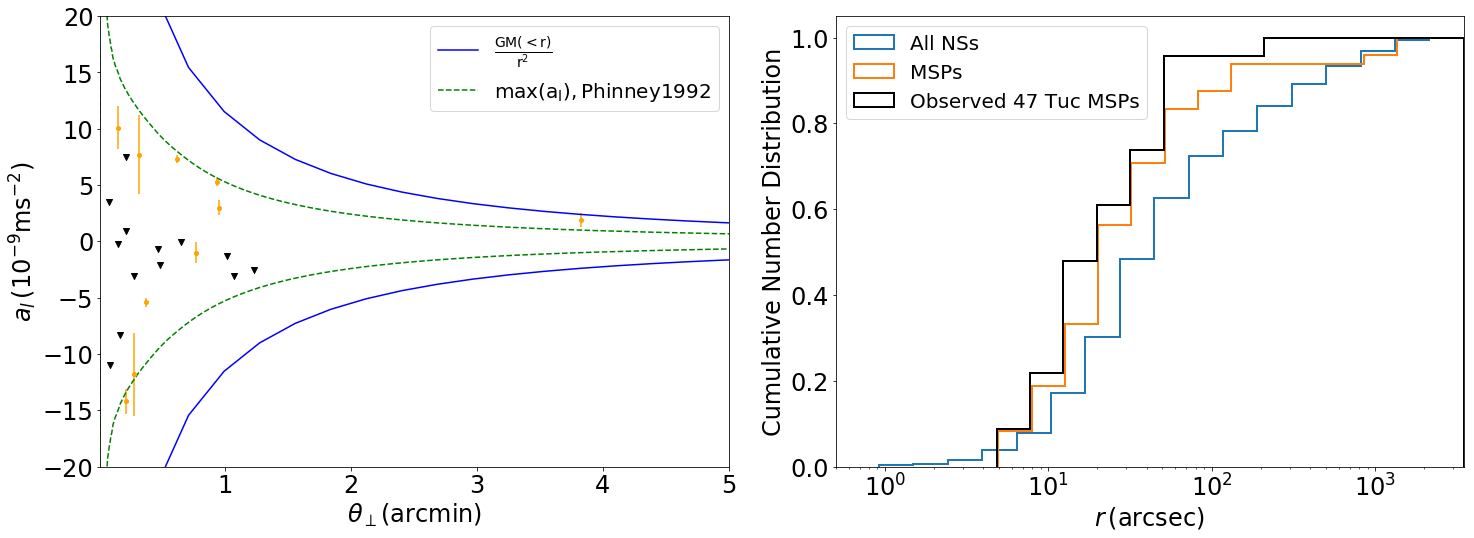

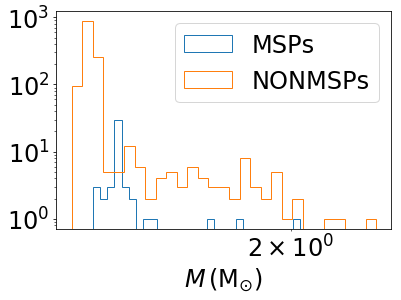

In [26]:
##Cluster acceleration from the model
#path = '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/'
snapno = 733
#path = '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon_fixbin_ic/'
#snapno = 651


bin_no = 201
def Acc_los_model(d47 = 4.52):
    l_conv = dyn.conv('l', path.replace('observed_profiles/', '')+'initial.conv.sh')
    
    ##########################
    #From snapshot file
    ##For cmc 3.2
    #r_snap = []; m_snap = []
    #with gzip.open(path+'initial.snap'+str(snapno)+'.dat.gz', 'r') as fsnap:
    #    next(fsnap); next(fsnap)
    #    for line in fsnap:
    #        data = line.split()
    #       
    #        r_snap.append(float(data[2]))
    #        m_snap.append(float(data[1]))        
                
    ##For CMC-COSMIC ver 1.0.0
    sys.path.insert(1, '/projects/b1095/syr904/MyCodes/cmctoolkit')
    import cmctoolkit as cmct
    
    #snap = cmct.Snapshot(fname=path.replace('observed_profiles/', '')+'initial.snapshots.h5', snapshot_name='/733(t=0.47867046)', 
    #                     conv=path.replace('observed_profiles/', '')+'initial.conv.sh', 
    #                     dist=4.52, # distance to cluster in kpc
    #                     z=0.0038)
    #r_snap = snap.data['r']; m_snap = snap.data['m_MSUN']
    
    #np.savetxt(path+'r_m_'+str(snapno)+'_snap.txt', np.c_[r_snap, m_snap], fmt = '%f %f', 
    #           header = '1.r[code unit] 2.m[MSUN]', comments = '#')
    
    ##########################
    data_snap = np.genfromtxt(path+'r_m_'+str(snapno)+'_snap.txt')
    r_snap = data_snap[:,0]; m_snap = data_snap[:,1]
    max_r = r_snap[-1]; min_r = r_snap[0]
    #rbin = np.logspace(np.log10(min_r), np.log10(max_r), bin_no-50)  ##in code unit
    rbin = np.linspace(min_r, max_r, bin_no+60)  ##in code unit
    rbin_med = []
    for xx in range(len(rbin)-1):
        rbin_med.append((rbin[xx+1]+rbin[xx])/2.)
        
    
    mbin = []
    i_count = 0
    for ii in range(len(rbin)-1):
        mtot = 0
        for xx in range(len(r_snap)):
            if rbin[ii]<= r_snap[xx] < rbin[ii+1]:
                mtot += m_snap[xx]
            
        mbin.append(mtot)
    
    cum_mbin = np.cumsum(mbin)
    #print(mbin)
    print('mbin:', len(mbin), 'cum:', len(cum_mbin))

    acc_max = Gconst_sun*cum_mbin/(np.array(rbin_med)*l_conv)**2*(1e6/(PC*0.01))#*math.sqrt(1./3.)
    acc_min = -Gconst_sun*cum_mbin/(np.array(rbin_med)*l_conv)**2*(1e6/(PC*0.01))#*(math.sqrt(1./3.))
    #theta_bin = rbin[1:]*l_conv*math.sqrt(2./3.)/(d47*1000.)*180/np.pi*60
    theta_bin = np.array(rbin_med)*l_conv/(d47*1000.)*180/np.pi*60
    
    
    
    ##From 2D projection
    #r_2dsnap = []; m_2dsnap = []
    #with gzip.open(path+'initial.snap'+str(snapno)+'.2Dproj.dat.gz', 'r') as f2d:
    #    next(f2d); next(f2d)
    #    for line in f2d:
    #        data = line.split()
            
    #        r_2dsnap.append(float(data[0]))
    #        m_2dsnap.append(float(data[9]))          
            
    #np.savetxt(path+'r_m_'+str(snapno)+'_2Dproj.txt', np.c_[r_2dsnap, m_2dsnap], fmt = '%f %f', 
    #           header = '1.r[PC] 2.m[MSUN]', comments = '#')
    
    data_2dsnap = np.genfromtxt(path+'r_m_'+str(snapno)+'_2Dproj.txt')
    r_2dsnap = data_2dsnap[:,0]; m_2dsnap = data_2dsnap[:,1]
    max_r2d = r_2dsnap[-1]; min_r2d = r_2dsnap[0]
    
    rbin_2d = np.logspace(np.log10(min_r2d), np.log10(max_r2d), bin_no)  ##in parsec
    #rbin_2d = np.linspace(0.0005, 96.7177, 201)
    #print(rbin_2d)
    rbin_2d_med = []
    for xx in range(len(rbin_2d)-1):
        rbin_2d_med.append((rbin_2d[xx+1]+rbin_2d[xx])/2.)
        
    #print(len(rbin_2d_med))
    
            
    mbin_2d = []
    for ii in range(len(rbin_2d)-1):
        mtot = 0
        for xx in range(len(r_2dsnap)):
            if rbin_2d[ii]<= r_2dsnap[xx] < rbin_2d[ii+1]:
                mtot += m_2dsnap[xx]
            
        mbin_2d.append(mtot)
    
    
    cum_mbin_2d = np.cumsum(mbin_2d)
    #print(mbin)
    print('mbin_2d:', len(mbin_2d), 'cum_2d:', len(cum_mbin_2d))

    acc_max_2d = 1.1*Gconst_sun*cum_mbin_2d/(np.pi*np.array(rbin_2d_med)**2)*(1e6/(PC*0.01))
    acc_min_2d = -1.1*Gconst_sun*cum_mbin_2d/(np.pi*np.array(rbin_2d_med)**2)*(1e6/(PC*0.01))
    theta_bin_2d = np.array(rbin_2d_med)/(d47*1000.)*180/np.pi*60

    return theta_bin, acc_max, acc_min, theta_bin_2d, acc_max_2d, acc_min_2d
    
    
#Acc_los_model()




##Line-of-acceleration profile and cumulative projected radial distribution of observed pulsars & model NSs 
#####################################
##Line-of-sight acceleration
##Observation
data47= np.genfromtxt('/projects/b1095/syr904/projects/massive_clusters/47Tuc_psr_acceleration.dat', dtype = str)
pspin = data47[:,6].astype(np.float); pobs_dot = (data47[:,7].astype(np.float))*1e-21
pm_alpha = data47[:,8].astype(np.float); pm_delta = data47[:,9].astype(np.float)
dec = data47[:,10].astype(np.float)

theta_los = data47[:,2].astype(np.float)
algc_max = data47[:,11].astype(np.float)
algc = data47[:,12].astype(np.float); algc_uncert = data47[:,13].astype(np.float)


d47 = 4.52  ##kpc
##The difference between the accelerations of the Solar system and 47 Tuc.
a47 = -1.172*1e-10 ## m/s^−2
#pm_alpha = 4; pm_delta = 1
#delta = -(72.+5./60.+1.48/3600.)
#pobs_dot = -4.56*1e-21; pspin = 4.554447383906 ##ms


##Calculate 47Tuc-X acceleration
#pbx = 10.921183545  #day
#pb_dotx = 6*1e-12 
#pm_alphax = 5.8; pm_deltax = -3.3; deltax = -72.021512
#pobs_dotx = 18.3609*1e-21; pspinx = 4.77152291069355 ##ms
#pm2x = pm_deltax**2+(pm_alphax*np.cos(deltax))**2
#vt2x = (pm2x/1e6)*(4.74*d47*1000.)**2*1e6 ##(m/s)^2
#Ax = pb_dotx/(pbx*24.*3600.)*(clight/100.)
#Bx = vt2x/(d47*1000.*PC/100.)
#algcx = Ax-Bx-a47
#print(algcx)

#print(np.cos(np.pi))
##Calculate algc upper limits
pm2 = pm_delta**2+(pm_alpha*np.cos(dec*np.pi/180))**2
vt2 = (pm2/1e6)*(4.74*d47*1000.)**2*1e6 ##(m/s)^2

A = pobs_dot/(pspin/1000.)*(clight/100.)
B = vt2/(d47*1000.*PC/100.)

#print(B)

al_max = A-B-a47
#print(al_max)
#print(np.array(B[algc!=-100]*1e9)/np.abs(algc[algc!=-100]))
#print(np.array(B[algc==-100]*1e9)/np.abs(algc[algc==-100]))

##Model
the_bin, accmax, accmin, the_bin_2d, accmax_2d, accmin_2d = Acc_los_model(d47 = 4.52)

matplotlib.rcParams.update({'font.size': 24})

fig, axs = plt.subplots(ncols = 2, figsize = (21, 8))
axs[0].scatter(theta_los[algc==-100], algc_max[algc==-100], marker = 'v', color = 'k')
axs[0].errorbar(theta_los[algc!=-100], algc[algc!=-100], yerr = algc_uncert[algc!=-100], fmt = 'o', markersize = 4, 
                color = 'orange')
axs[0].plot(the_bin, accmax*1e9, color = 'b', label = r'$\rm{\frac{GM(<r)}{r^2}}$')
axs[0].plot(the_bin, accmin*1e9, color = 'b')
axs[0].plot(the_bin_2d, accmax_2d*1e9, color = 'g', ls = '--', label = r'$\rm{max(a_l), Phinney 1992}$')
axs[0].plot(the_bin_2d, accmin_2d*1e9, color = 'g', ls = '--')
axs[0].set_xlim(xmin = 0.01, xmax = 5)
axs[0].set_ylim(ymin = -20, ymax = 20)
    
axs[0].set_xlabel(r'$\theta_{\perp} (\rm{arcmin})$')
axs[0].set_ylabel(r'$a_l\,(\rm{10^{-9}ms^{-2}})$')
axs[0].legend(loc = 'best', fontsize = 20)


#######################################
##Cumulative radial distribution
datamsp = np.genfromtxt(path+'MSP'+str(snapno)+'.dat')
id_msp = datamsp[:,10]; sn_msp = datamsp[:,16]; tc_msp = datamsp[:,17]


rpc = []; m_tot = []; rpc_msp = []; mtot_msp = []; mtot_nonmsp = []
n_nonmsp_sin = 0; n_msp_sin = 0
with gzip.open(path+'initial.snap'+str(snapno)+'.2Dproj.dat.gz', 'r') as f2d:
        next(f2d); next(f2d)
        for line in f2d:
            data2d = line.split()
            if int(data2d[2]) == 1:
                if int(data2d[5]) == 13 or int(data2d[6]) == 13: 
                    rpc.append(float(data2d[0])); m_tot.append(float(data2d[9]))
                    if float(data2d[13]) in id_msp or float(data2d[14]) in id_msp:
                        rpc_msp.append(float(data2d[0])); mtot_msp.append(float(data2d[9]))
                    else:
                        mtot_nonmsp.append(float(data2d[9]))
                        
                
            else:
                if int(data2d[3]) == 13: 
                    rpc.append(float(data2d[0])); m_tot.append(float(data2d[9]))
                    if float(data2d[12]) in id_msp:
                        rpc_msp.append(float(data2d[0])); mtot_msp.append(float(data2d[9]))
                        n_msp_sin+=1
                    else:
                        mtot_nonmsp.append(float(data2d[9]))
                        n_nonmsp_sin+=1
                    
r_proj = np.array(rpc)/(d47*1000.)*180/np.pi*60*60
r_proj_msp = np.array(rpc_msp)/(d47*1000.)*180/np.pi*60*60

print(np.mean(m_tot), np.mean(mtot_msp), np.mean(mtot_nonmsp))
print(np.median(m_tot), np.median(mtot_msp), np.median(mtot_nonmsp))
print(len(m_tot), len(mtot_msp), len(mtot_nonmsp))
print(n_msp_sin, n_nonmsp_sin)

axs[1].hist(r_proj, bins = np.logspace(np.log10(min(r_proj)), np.log10(3500), 18), 
            cumulative = True, density = True, histtype = 'step', lw = 2., label = 'All NSs')
axs[1].hist(r_proj_msp, bins = np.logspace(np.log10(min(r_proj_msp)), np.log10(3500), 15), 
            cumulative = True, density = True, histtype = 'step', lw = 2., label = 'MSPs')
axs[1].hist(theta_los*60, bins = np.logspace(np.log10(min(theta_los*60)), np.log10(3500), 15), 
            cumulative = True, density = True, histtype = 'step', lw = 2., color = 'k', 
            label = 'Observed 47 Tuc MSPs')
axs[1].set_xscale('log')
axs[1].set_xlim(xmin = 0.5, xmax = 3500.)
axs[1].set_xlabel(r'$r\,(\rm{arcsec})$')
axs[1].set_ylabel('Cumulative Number Distribution')
axs[1].legend(loc = 'upper left', fontsize = 20)
fig.subplots_adjust(wspace = 0.2)
fig.tight_layout()

plt.savefig('/projects/b1095/syr904/projects/massive_clusters/psr_acc_distr_cmccosmicver1_updated.pdf', dpi=300)


plt.figure()
#plt.hist(m_tot, bins = np.logspace(np.log10(min(m_tot)), np.log10(max(m_tot)), 30), histtype = 'step', 
#         label = 'All NSs')
plt.hist(mtot_msp, bins = np.logspace(np.log10(min(mtot_msp)), np.log10(max(mtot_msp)), 30), histtype = 'step',
         label = 'MSPs')
plt.hist(mtot_nonmsp, bins = np.logspace(np.log10(min(mtot_nonmsp)), np.log10(max(mtot_nonmsp)), 30), histtype = 'step',
         label = 'NONMSPs')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(xmin = 0.1)
plt.xlabel(r'$M\,(\rm{M_{\odot}})$')
plt.legend(loc = 'best')


In [7]:
##Pulsars at snapshot with tidal capture turned on
##Observed pulsars
df_obs_psr = pd.read_excel('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/47tuc_pulsars.xlsx', 
                        skiprows = 1, 
                        names = ['Name', 'Offset', 'Periods', 'Pdot', 'DM', 'Pb', 'X', 'Ecc', 'Mcomp', 'Type'])
type_47tuc = np.array(df_obs_psr['Type'])
pb_47tuc= np.array(df_obs_psr['Pb']); mc_47tuc = np.array(df_obs_psr['Mcomp'])
type47 = type_47tuc[type_47tuc != 'i']
pb47 = pb_47tuc[type_47tuc != 'i']; mc47 = mc_47tuc[type_47tuc != 'i']
print(pb47, mc47)


#path = '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/'
#path = '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon_fixbin_ic/'
snapno = 733
#################################################
##PULSARS
msp_elson = np.genfromtxt(path+'MSP'+str(snapno)+'.dat')
sma_elson = msp_elson[:,14]; sn_elson = msp_elson[:,16]; tcflag_elson = msp_elson[:,17]

psr_array = []
psr_bin = []
psr_notaic = []; psr_notgc = []
colns = [1,2,3,7,8,9,13,14,15]   ##r, B, P, rol1, mns, mc, kc, sma, ecc
for ii in range(len(colns)):
    num_col = int(colns[ii])
    psr_array.append(msp_elson[:,num_col])
    psr_bin.append(msp_elson[:,num_col][sma_elson != -100])
    psr_notaic.append(msp_elson[:,num_col][sn_elson != 4])
    psr_notgc.append([])
    for xx in range(len(msp_elson[:,num_col])):
        if tcflag_elson[xx] != 81 and tcflag_elson[xx] != 82 and tcflag_elson[xx] != 83:
            psr_notgc[ii].append(msp_elson[:,num_col][xx])
    psr_notgc[ii] = np.array(psr_notgc[ii])


pb_psr_bin = uc.au_to_period(np.array(psr_bin[-2]), np.array(psr_bin[4]), np.array(psr_bin[5]))
psr_bin.append(pb_psr_bin)
pb_psr = uc.au_to_period(np.array(psr_array[-2]), np.array(psr_array[4]), np.array(psr_array[5]))
psr_array.append(pb_psr)
pb_notaic = uc.au_to_period(np.array(psr_notaic[-2]), np.array(psr_notaic[4]), np.array(psr_notaic[5]))
psr_notaic.append(pb_notaic)
pb_notgc = uc.au_to_period(np.array(psr_notgc[-2]), np.array(psr_notgc[4]), np.array(psr_notgc[5]))
psr_notgc.append(pb_notgc)
            

##binaries
psr_notaic_bin = []
psr_sma = psr_notaic[-3] != -100
for ii in range(len(colns)+1):
    psr_notaic_bin.append(psr_notaic[ii][psr_sma])
    

psr_notgc_bin = []
psr_sma = psr_notgc[-3] != -100
for jj in range(len(colns)+1):
    psr_notgc_bin.append(psr_notgc[jj][psr_sma])
           
    
print('n_bin', len(psr_bin[-1]), 'n_all', len(psr_array[-1]))
print('n_bin_notaic', len(psr_notaic_bin[-1]), 'n_all_notaic', len(psr_notaic[-1]))
print('n_bin_notgc', len(psr_notgc_bin[-1]), 'n_all_notgc', len(psr_notgc[-1]))


##Find how many psrs are from tidal capture or giant collisions
n_81 = 0; n_82 = 0; n_91 = 0; n_92 = 0
for ii in range(len(tcflag_elson)):
    if tcflag_elson[ii] == 81:
        n_81+=1
        #print('81:', msp_elson[:,10][ii], msp_elson[:,11][ii])
        if msp_elson[:,9][ii]<=0.01 and msp_elson[:,13][ii]>10:
            #print(msp_elson[:,10][ii], msp_elson[:,11][ii])
            n_81-=1
        
    if tcflag_elson[ii] == 82 or tcflag_elson[ii] == 83:
        n_82+=1
        #print('82:', msp_elson[:,10][ii], msp_elson[:,11][ii]) 
        if msp_elson[:,9][ii]<=0.01 and msp_elson[:,13][ii]>10:
            #print(msp_elson[:,10][ii], msp_elson[:,11][ii])
            n_82-=1
        
        
    if tcflag_elson[ii] == 91:
        n_91+=1
        #print('91:', msp_elson[:,10][ii], msp_elson[:,11][ii])
        if msp_elson[:,9][ii]<=0.01 and msp_elson[:,13][ii]>10:
            #print(msp_elson[:,10][ii], msp_elson[:,11][ii])
            n_91-=1
        
        
    if tcflag_elson[ii] == 92 or tcflag_elson[ii] == 93:
        n_92+=1
        #print('92:', msp_elson[:,10][ii], msp_elson[:,11][ii])
        if msp_elson[:,9][ii]<=0.01 and msp_elson[:,13][ii]>10:
            #print(msp_elson[:,10][ii], msp_elson[:,11][ii])
            n_92-=1
        

print(n_81, n_82, n_91, n_92)

#################################################
##TC NS-MS binaries and collision
nsms_elson = np.genfromtxt(path+'NSMS'+str(snapno)+'.dat')
tcflag_nsms = nsms_elson[:,12]; sn_nsms = nsms_elson[:,13]
sn_nsms_91 = sn_nsms[tcflag_nsms == 91]
sn_nsms_81 = sn_nsms[tcflag_nsms == 81]


nsms_array = []
nsms_tc = []; nsms_gc = []
colns_nsms = [2,3,6,7,5,9]   ##mns, mms, a_au, ecc, kc, rolc
for ii in range(len(colns_nsms)):
    num_nsms = colns_nsms[ii]
    nsms_array.append(nsms_elson[:,num_nsms])
    nsms_tc.append(nsms_elson[:,num_nsms][tcflag_nsms == 91])
    nsms_gc.append(nsms_elson[:,num_nsms][tcflag_nsms == 81])
    
pb_nsms = uc.au_to_period(np.array(nsms_array[2]), np.array(nsms_array[0]), np.array(nsms_array[1]))
nsms_array.append(pb_nsms)
nsms_tc.append(pb_nsms[tcflag_nsms == 91])
nsms_gc.append(pb_nsms[tcflag_nsms == 81])
print('n_tc_nsms', len(nsms_tc[-1]), 'n_gc_nsms', len(nsms_gc[-1]), 'n_nsms', len(nsms_array[-1]))


##TC NS-WD binaries and collision
nswd_elson = np.genfromtxt(path+'NSWD'+str(snapno)+'.dat')
tcflag_nswd = nswd_elson[:,12]; sn_nswd = nswd_elson[:,13]
sn_nswd_91 = sn_nswd[tcflag_nswd == 91]
sn_nswd_81 = sn_nswd[tcflag_nswd == 81]

nswd_array = []
nswd_tc = []; nswd_gc = []
colns_nswd = [2,3,6,7,5,9]   ##mns, mms, a_au, ecc, kc, rolc
for ii in range(len(colns_nswd)):
    num_nswd = colns_nswd[ii]
    nswd_array.append(nswd_elson[:,num_nswd])
    nswd_tc.append(nswd_elson[:,num_nswd][tcflag_nswd == 91])
    nswd_gc.append(nswd_elson[:,num_nswd][tcflag_nswd == 81])
    
pb_nswd = uc.au_to_period(np.array(nswd_array[2]), np.array(nswd_array[0]), np.array(nswd_array[1]))
nswd_array.append(pb_nswd)
nswd_tc.append(pb_nswd[tcflag_nswd == 91])
nswd_gc.append(pb_nswd[tcflag_nswd == 81])
print('n_tc_nswd', len(nswd_tc[-1]), 'n_gc_nswd', len(nswd_gc[-1]), 'n_nswd', len(nswd_array[-1]))


###########################
##Finally filtering out the disrupted ultra-compact binaries 
##with carbon WDs <~ 0.01 Msun from Deloye & Bildsten 2003
#print('######################')
index_del_bin = []
for kk in range(len(psr_bin[-1])):
    #if psr_bin[5][kk]<=0.05:
        #print('pb', psr_bin[-1][kk]*24.*60., 'mc', psr_bin[5][kk], 'kc', psr_bin[6][kk], 
        #        'rolc', psr_bin[3][kk])
    
    if psr_bin[5][kk]<=0.01 and psr_bin[6][kk]>10:
        index_del_bin.append(kk)
        
psr_bin_filterucb = []
for xx in range(len(psr_bin)):
    new_array = np.delete(psr_bin[xx], index_del_bin)
    psr_bin_filterucb.append(new_array)
    


#print('######################')
index_del_notaic = []
for kk in range(len(psr_notaic_bin[-1])):
    #if psr_notaic_bin[5][kk]<=0.05:
        #print('pb', psr_notaic_bin[-1][kk]*24.*60., 'mc', psr_notaic_bin[5][kk], 'kc', psr_notaic_bin[6][kk], 
        #        'rolc', psr_notaic_bin[3][kk])
    
    if psr_notaic_bin[5][kk]<=0.01 and psr_notaic_bin[6][kk]>10:
        index_del_notaic.append(kk)
        
psr_notaic_bin_filterucb = []
for xx in range(len(psr_notaic_bin)):
    new_array = np.delete(psr_notaic_bin[xx], index_del_notaic)
    psr_notaic_bin_filterucb.append(new_array)


#print('######################')
index_del_notgc = []
for kk in range(len(psr_notgc_bin[-1])):
    #if psr_notgc_bin[5][kk]<=0.05:
        #print('pb', psr_notgc_bin[-1][kk]*24.*60., 'mc', psr_notgc_bin[5][kk], 'kc', psr_notgc_bin[6][kk], 
        #      'rolc', psr_notgc_bin[3][kk])
        
    if psr_notgc_bin[5][kk]<=0.01 and psr_notgc_bin[6][kk]>10:
        index_del_notgc.append(kk)
        
psr_notgc_bin_filterucb = []
for xx in range(len(psr_notgc_bin)):
    psr_notgc_bin_filterucb.append(np.delete(psr_notgc_bin[xx], index_del_notgc))
    
    
#print('######################')
index_del_nswd_tc = []
for kk in range(len(nswd_tc[-1])):
    #if nswd_tc[1][kk]<=0.05:
        #print('pb', nswd_tc[-1][kk]*24.*60., 'mc', nswd_tc[1][kk], 'kc', nswd_tc[4][kk], 
        #      'rolc', nswd_tc[5][kk])
    
    if nswd_tc[1][kk]<=0.01 and nswd_tc[4][kk] > 10:
        index_del_nswd_tc.append(kk)
    
nswd_tc_filterucb = []
for xx in range(len(nswd_tc)):
    nswd_tc_filterucb.append(np.delete(nswd_tc[xx], index_del_nswd_tc))
     
sn_nswd_91_filterucb = np.delete(sn_nswd_91, index_del_nswd_tc)
        

#print('######################')
index_del_nswd_gc = []
for kk in range(len(nswd_gc[-1])):
    #if nswd_gc[1][kk]<=0.05:
    #    print('pb', nswd_gc[-1][kk]*24.*60., 'mc', nswd_gc[1][kk], 'kc', nswd_gc[4][kk], 
    #          'rolc', nswd_gc[5][kk])
        
    if nswd_gc[1][kk]<=0.01 and nswd_gc[4][kk] > 10:
        index_del_nswd_gc.append(kk)
    
nswd_gc_filterucb = []
for xx in range(len(nswd_gc)):
    nswd_gc_filterucb.append(np.delete(nswd_gc[xx], index_del_nswd_gc))

sn_nswd_81_filterucb = np.delete(sn_nswd_81, index_del_nswd_gc)

[2.25684 2.3577 0.22979 0.12066 0.13597 0.14725 1.18908 0.06623 1.20172
 1.12618 0.42911 0.21213 0.133 10.9212 0.52194 0.1793 0.3184] [0.18 0.19 0.015 0.024 0.025 0.02 0.21 0.03 0.1 0.2 0.14 0.35 0.14 0.42
 0.16 0.0089 0.235]
n_bin 48 n_all 48
n_bin_notaic 30 n_all_notaic 30
n_bin_notgc 16 n_all_notgc 16
11 3 0 0
n_tc_nsms 5 n_gc_nsms 6 n_nsms 15
n_tc_nswd 0 n_gc_nswd 28 n_nswd 54


['b' 'b' 'bw' 'bw' 'bw' 'bw' 'b' 'bw' 'b' 'b' 'b' 'rb' 'rb' 'b' 'b' 'bw'
 'rb']
48 22 5 0


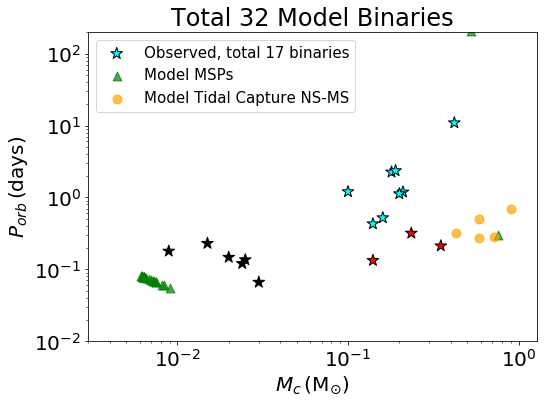

In [8]:
##Ploting Pb-Mc
##r, B, P, rol1, mns, mc, kc, sma, ecc, pb for psr_arrays
print(type47)
color47 = ['cyan', 'cyan', 'k', 'k', 'k', 'k', 'cyan', 'k', 'cyan', 'cyan', 'cyan', 'r', 'r', 'cyan', 'cyan', 'k', 'r']


matplotlib.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(figsize = (8,6))

##All binary
axs.scatter(mc47, pb47, marker = '*', s = 150, color = 'k', facecolor = color47, alpha = 1., 
               label = 'Observed, total 17 binaries')
axs.scatter(psr_bin_filterucb[5], psr_bin_filterucb[-1], alpha = 0.7, s = 80, marker = '^',
               color = 'green', label = 'Model MSPs')
#axs.scatter(nsms_tc[1][sn_nsms_91!=4], nsms_tc[-1][sn_nsms_91!=4], s=80,
#               label = 'Model Tidal Capture NS-MS', alpha = 0.7, color = 'orange')
axs.scatter(nsms_tc[1], nsms_tc[-1], s=80,
               label = 'Model Tidal Capture NS-MS', alpha = 0.7, color = 'orange')

#print(len(psr_bin[5]), len(psr_bin_filterucb[5]),len(nsms_tc[1][sn_nsms_91!=4]),
#      len(nswd_tc_filterucb[1][sn_nswd_91_filterucb!=4]))
print(len(psr_bin[5]), len(psr_bin_filterucb[5]),len(nsms_tc[1]),len(nswd_tc_filterucb[1]))

axs.set_title('Total 32 Model Binaries')

axs.set_yscale('log')
axs.set_xscale('log')
axs.set_ylabel(r'$P_{orb}\, (\rm{days})$')
axs.set_xlabel(r'$M_c\, (\rm{M_{\odot}})$')
axs.set_ylim(ymin = 0.01, ymax = 200)
axs.set_xlim(xmin = 0.003)
axs.legend(loc = 'upper left', fontsize=15)

fig.tight_layout()

#plt.savefig('/projects/b1095/syr904/projects/massive_clusters/psr_pb_mc_cmc3.2.pdf', dpi=300)

In [29]:
##Pulsars at snapshot with tidal capture turned on
##Observed pulsars
df_obs_psr = pd.read_excel('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/47tuc_pulsars.xlsx', 
                        skiprows = 1, 
                        names = ['Name', 'Offset', 'Periods', 'Pdot', 'DM', 'Pb', 'X', 'Ecc', 'Mcomp', 'Type'])
type_47tuc = np.array(df_obs_psr['Type'])
pb_47tuc= np.array(df_obs_psr['Pb']); mc_47tuc = np.array(df_obs_psr['Mcomp'])
type47 = type_47tuc[type_47tuc != 'i']
pb47 = pb_47tuc[type_47tuc != 'i']; mc47 = mc_47tuc[type_47tuc != 'i']
print(pb47, mc47)


sys.path.insert(1, '/projects/b1095/syr904/MyCodes/cmctoolkit')
import cmctoolkit as cmct

snap_h5 = cmct.Snapshot(fname=path.replace('observed_profiles/', '')+'initial.snapshots.h5', snapshot_name='/0(t=0)', 
                     conv=path.replace('observed_profiles/', '')+'initial.conv.sh', 
                     dist=4.52, # distance to cluster in kpc
                     z=0.0038)

binflag = np.array(snap_h5.data['binflag'])
id0_snap0 = np.array(snap_h5.data['id0'])[binflag == 1]
id1_snap0 = np.array(snap_h5.data['id1'])[binflag == 1]
#print(id0_snap0)

snapno = np.linspace(703, 757, 19)
#print(len(snapno))
MSPfiles = np.sort(glob(path.replace('observed_profiles/', '')+'MSP*.dat'))
NSMSfiles = np.sort(glob(path.replace('observed_profiles/', '')+'NSMS*.dat'))
NSWDfiles = np.sort(glob(path.replace('observed_profiles/', '')+'NSWD*.dat'))

#print(len(MSPfiles), len(NSMSfiles), len(NSWDfiles))
#################################################
##PULSARS
psr_bin_filterucb_allsnap_mc = []; psr_bin_filterucb_allsnap_pb = [] 
nsms_tc_allsnap_mc = []; nsms_tc_allsnap_pb = []
nswd_tc_filterucb_allsnap_mc = []; nswd_tc_filterucb_allsnap_pb = []
#n_nsms = np.zeros(26)
n_nsms = []


id0_tot = []; id1_tot = []
for vv in range(9, 35):
    print(MSPfiles[vv])
    n_nsms.append(0)
#for vv in range(len(snapno)):
    #msp_elson = np.genfromtxt(path.replace('observed_profiles/', '')+'MSP'+str(int(snapno[vv]-1))+'.dat')
    msp_elson = np.genfromtxt(MSPfiles[vv])
    sma_elson = msp_elson[:,14]; sn_elson = msp_elson[:,16]; tcflag_elson = msp_elson[:,17]
    id0 = msp_elson[:,10]; id1 = msp_elson[:,11]

    psr_array = []
    psr_bin = []
    psr_notaic = []; psr_notgc = []
    colns = [1,2,3,7,8,9,13,14,15,10,11]   ##r, B, P, rol1, mns, mc, kc, sma, ecc, id0, id1
    for ii in range(len(colns)):
        num_col = int(colns[ii])
        psr_array.append(msp_elson[:,num_col])
        psr_bin.append(msp_elson[:,num_col][sma_elson != -100])
        psr_notaic.append(msp_elson[:,num_col][sn_elson != 4])
        psr_notgc.append([])
        for xx in range(len(msp_elson[:,num_col])):
            if tcflag_elson[xx] != 81 and tcflag_elson[xx] != 82 and tcflag_elson[xx] != 83:
                psr_notgc[ii].append(msp_elson[:,num_col][xx])
        psr_notgc[ii] = np.array(psr_notgc[ii])


    pb_psr_bin = uc.au_to_period(np.array(psr_bin[-4]), np.array(psr_bin[4]), np.array(psr_bin[5]))
    psr_bin.append(pb_psr_bin)
    pb_psr = uc.au_to_period(np.array(psr_array[-4]), np.array(psr_array[4]), np.array(psr_array[5]))
    psr_array.append(pb_psr)
    pb_notaic = uc.au_to_period(np.array(psr_notaic[-4]), np.array(psr_notaic[4]), np.array(psr_notaic[5]))
    psr_notaic.append(pb_notaic)
    pb_notgc = uc.au_to_period(np.array(psr_notgc[-4]), np.array(psr_notgc[4]), np.array(psr_notgc[5]))
    psr_notgc.append(pb_notgc)
            

    ##binaries
    psr_notaic_bin = []
    psr_sma = psr_notaic[-5] != -100
    for ii in range(len(colns)+1):
        psr_notaic_bin.append(psr_notaic[ii][psr_sma])
    

    psr_notgc_bin = []
    psr_sma = psr_notgc[-5] != -100
    for jj in range(len(colns)+1):
        psr_notgc_bin.append(psr_notgc[jj][psr_sma])
           
    
    print('n_bin', len(psr_bin[-1]), 'n_all', len(psr_array[-1]))
    print('n_bin_notaic', len(psr_notaic_bin[-1]), 'n_all_notaic', len(psr_notaic[-1]))
    print('n_bin_notgc', len(psr_notgc_bin[-1]), 'n_all_notgc', len(psr_notgc[-1]))


    ##Find how many psrs are from tidal capture or giant collisions
    n_81 = 0; n_82 = 0; n_91 = 0; n_92 = 0
    for ii in range(len(tcflag_elson)):
        if tcflag_elson[ii] == 81:
            n_81+=1
            #print('81:', msp_elson[:,10][ii], msp_elson[:,11][ii])
            if msp_elson[:,9][ii]<=0.01 and msp_elson[:,13][ii]>10:
                #print(msp_elson[:,10][ii], msp_elson[:,11][ii])
                n_81-=1
            
        if tcflag_elson[ii] == 82 or tcflag_elson[ii] == 83:
            n_82+=1
            #print('82:', msp_elson[:,10][ii], msp_elson[:,11][ii]) 
            if msp_elson[:,9][ii]<=0.01 and msp_elson[:,13][ii]>10:
                #print(msp_elson[:,10][ii], msp_elson[:,11][ii])
                n_82-=1
            
            
        if tcflag_elson[ii] == 91:
            n_91+=1
            #print('91:', msp_elson[:,10][ii], msp_elson[:,11][ii])
            if msp_elson[:,13][ii]<2: print('91:', msp_elson[:,10][ii])
            if msp_elson[:,9][ii]<=0.01 and msp_elson[:,13][ii]>10:
                #print(msp_elson[:,10][ii], msp_elson[:,11][ii])
                n_91-=1
            
            
        if tcflag_elson[ii] == 92 or tcflag_elson[ii] == 93:
            n_92+=1
            #print('92:', msp_elson[:,10][ii], msp_elson[:,11][ii])
            if msp_elson[:,9][ii]<=0.01 and msp_elson[:,13][ii]>10:
                #print(msp_elson[:,10][ii], msp_elson[:,11][ii])
                n_92-=1
            
    
    print(n_81, n_82, n_91, n_92)

    #################################################
    ##TC NS-MS binaries and collision
    #nsms_elson = np.genfromtxt(path+'NSMS'+str(int(snapno[vv]))+'.dat')
    nsms_elson = np.genfromtxt(NSMSfiles[vv])
    tcflag_nsms = nsms_elson[:,12]; sn_nsms = nsms_elson[:,13]
    sn_nsms_91 = sn_nsms[tcflag_nsms == 91]
    sn_nsms_81 = sn_nsms[tcflag_nsms == 81]
    id0_nsms = nsms_elson[:,0]; id1_nsms = nsms_elson[:,1]
    
    nsms_msp_index = []
    for jj in range(len(id0_nsms)):
        for kk in range(len(id0)):
            if (id0_nsms[jj]==id0[kk] and id1_nsms[jj]==id1[kk]) or (id1_nsms[jj]==id0[kk] and id0_nsms[jj]==id1[kk]):
                nsms_msp_index.append(jj)
                print(id0_nsms[jj])
    print('nsms_msp_index,', len(nsms_msp_index))
    tcflag_nsms_nonmsp = np.delete(tcflag_nsms, nsms_msp_index)
    print(len(tcflag_nsms_nonmsp), len(tcflag_nsms))
    nsms_array = []
    nsms_tc = []; nsms_gc = []
    colns_nsms = [2,3,6,7,5,9]   ##mns, mms, a_au, ecc, kc, rolc
    for ii in range(len(colns_nsms)):
        num_nsms = colns_nsms[ii]
        nsms_array.append(nsms_elson[:,num_nsms])
        nsms_tc.append(np.delete(nsms_elson[:,num_nsms], nsms_msp_index)[tcflag_nsms_nonmsp == 91])
        nsms_gc.append(nsms_elson[:,num_nsms][tcflag_nsms == 81])
        
        
    pb_nsms = uc.au_to_period(np.array(nsms_array[2]), np.array(nsms_array[0]), np.array(nsms_array[1]))
    nsms_array.append(pb_nsms)
    nsms_tc.append(np.delete(pb_nsms, nsms_msp_index)[tcflag_nsms_nonmsp == 91])
    nsms_gc.append(pb_nsms[tcflag_nsms == 81])
    print('n_tc_nsms', len(nsms_tc[-1]), 'n_gc_nsms', len(nsms_gc[-1]), 'n_nsms', len(nsms_array[-1]))


    ##TC NS-WD binaries and collision
    #nswd_elson = np.genfromtxt(path+'NSWD'+str(int(snapno[vv]))+'.dat')
    nswd_elson = np.genfromtxt(NSWDfiles[vv])
    tcflag_nswd = nswd_elson[:,12]; sn_nswd = nswd_elson[:,13]
    sn_nswd_91 = sn_nswd[tcflag_nswd == 91]
    sn_nswd_81 = sn_nswd[tcflag_nswd == 81]
    
    nswd_array = []
    nswd_tc = []; nswd_gc = []
    colns_nswd = [2,3,6,7,5,9]   ##mns, mms, a_au, ecc, kc, rolc
    for ii in range(len(colns_nswd)):
        num_nswd = colns_nswd[ii]
        nswd_array.append(nswd_elson[:,num_nswd])
        nswd_tc.append(nswd_elson[:,num_nswd][tcflag_nswd == 91])
        nswd_gc.append(nswd_elson[:,num_nswd][tcflag_nswd == 81])
        
    pb_nswd = uc.au_to_period(np.array(nswd_array[2]), np.array(nswd_array[0]), np.array(nswd_array[1]))
    nswd_array.append(pb_nswd)
    nswd_tc.append(pb_nswd[tcflag_nswd == 91])
    nswd_gc.append(pb_nswd[tcflag_nswd == 81])
    print('n_tc_nswd', len(nswd_tc[-1]), 'n_gc_nswd', len(nswd_gc[-1]), 'n_nswd', len(nswd_array[-1]))


    ###########################
    #Finally filtering out the disrupted ultra-compact binaries 
    #with carbon WDs <~ 0.01 Msun from Deloye & Bildsten 2003
    #print('######################')
    index_del_bin = []
    for kk in range(len(psr_bin[-1])):
        #if psr_bin[5][kk]<=0.05:
        #    print('pb', psr_bin[-1][kk]*24.*60., 'mc', psr_bin[5][kk], 'kc', psr_bin[6][kk], 
        #            'rolc', psr_bin[3][kk])
        
        if psr_bin[5][kk]<=0.01 and psr_bin[6][kk]>10:
            index_del_bin.append(kk)
            
    psr_bin_filterucb = []
    for xx in range(len(psr_bin)):
        new_array = np.delete(psr_bin[xx], index_del_bin)
        psr_bin_filterucb.append(new_array)
    


    #print('######################')
    index_del_notaic = []
    for kk in range(len(psr_notaic_bin[-1])):
        #if psr_notaic_bin[5][kk]<=0.05:
        #    print('pb', psr_notaic_bin[-1][kk]*24.*60., 'mc', psr_notaic_bin[5][kk], 'kc', psr_notaic_bin[6][kk], 
        #            'rolc', psr_notaic_bin[3][kk])
        
        if psr_notaic_bin[5][kk]<=0.01 and psr_notaic_bin[6][kk]>10:
            index_del_notaic.append(kk)
            
    psr_notaic_bin_filterucb = []
    for xx in range(len(psr_notaic_bin)):
        new_array = np.delete(psr_notaic_bin[xx], index_del_notaic)
        psr_notaic_bin_filterucb.append(new_array)


    #print('######################')
    index_del_notgc = []
    for kk in range(len(psr_notgc_bin[-1])):
        #if psr_notgc_bin[5][kk]<=0.05:
        #    print('pb', psr_notgc_bin[-1][kk]*24.*60., 'mc', psr_notgc_bin[5][kk], 'kc', psr_notgc_bin[6][kk], 
        #          'rolc', psr_notgc_bin[3][kk])
            
        if psr_notgc_bin[5][kk]<=0.01 and psr_notgc_bin[6][kk]>10:
            index_del_notgc.append(kk)
            
    psr_notgc_bin_filterucb = []
    for xx in range(len(psr_notgc_bin)):
        psr_notgc_bin_filterucb.append(np.delete(psr_notgc_bin[xx], index_del_notgc))
    
    
    #print('######################')
    index_del_nswd_tc = []
    for kk in range(len(nswd_tc[-1])):
        #if nswd_tc[1][kk]<=0.05:
        #    print('pb', nswd_tc[-1][kk]*24.*60., 'mc', nswd_tc[1][kk], 'kc', nswd_tc[4][kk], 
        #          'rolc', nswd_tc[5][kk])
        
        if nswd_tc[1][kk]<=0.01 and nswd_tc[4][kk] > 10:
            index_del_nswd_tc.append(kk)
        
    nswd_tc_filterucb = []
    for xx in range(len(nswd_tc)):
        nswd_tc_filterucb.append(np.delete(nswd_tc[xx], index_del_nswd_tc))
         
    sn_nswd_91_filterucb = np.delete(sn_nswd_91, index_del_nswd_tc)
        

    #print('######################')
    index_del_nswd_gc = []
    for kk in range(len(nswd_gc[-1])):
        #if nswd_gc[1][kk]<=0.05:
        #    print('pb', nswd_gc[-1][kk]*24.*60., 'mc', nswd_gc[1][kk], 'kc', nswd_gc[4][kk], 
        #          'rolc', nswd_gc[5][kk])
            
        if nswd_gc[1][kk]<=0.01 and nswd_gc[4][kk] > 10:
            index_del_nswd_gc.append(kk)
        
    nswd_gc_filterucb = []
    for xx in range(len(nswd_gc)):
        nswd_gc_filterucb.append(np.delete(nswd_gc[xx], index_del_nswd_gc))
    
    sn_nswd_81_filterucb = np.delete(sn_nswd_81, index_del_nswd_gc)
    
    ###Adding things together
    psr_bin_filterucb_allsnap_mc = psr_bin_filterucb_allsnap_mc+list(psr_bin_filterucb[5])
    psr_bin_filterucb_allsnap_pb = psr_bin_filterucb_allsnap_pb+list(psr_bin_filterucb[-1])
    #nsms_tc_allsnap_mc = nsms_tc_allsnap_mc+list(nsms_tc[1][sn_nsms_91!=4])
    #nsms_tc_allsnap_pb = nsms_tc_allsnap_pb+list(nsms_tc[-1][sn_nsms_91!=4])
    #nswd_tc_filterucb_allsnap_mc = nswd_tc_filterucb_allsnap_mc+list(nswd_tc_filterucb[1][sn_nswd_91_filterucb!=4])
    #nswd_tc_filterucb_allsnap_pb = nswd_tc_filterucb_allsnap_pb+list(nswd_tc_filterucb[-1][sn_nswd_91_filterucb!=4])
    nsms_tc_allsnap_mc = nsms_tc_allsnap_mc+list(nsms_tc[1])
    nsms_tc_allsnap_pb = nsms_tc_allsnap_pb+list(nsms_tc[-1])
    nswd_tc_filterucb_allsnap_mc = nswd_tc_filterucb_allsnap_mc+list(nswd_tc_filterucb[1])
    nswd_tc_filterucb_allsnap_pb = nswd_tc_filterucb_allsnap_pb+list(nswd_tc_filterucb[-1])
    #n_nsms[vv] += len(nsms_tc[1][sn_nsms_91!=4])
    #n_nsms[-1] += len(nsms_tc[1][sn_nsms_91!=4])
    n_nsms[-1] += len(nsms_tc[1])
    
    #if snapno[vv] == 726:
    #    print(snapno[vv], len(nsms_tc[1][sn_nsms_91!=4]), '************************************************************************')
    
    #print(psr_array[9], psr_array[10])
    id0_tot = id0_tot + list(psr_array[9]); id1_tot = id1_tot + list(psr_array[10])

##Check for primordial binary
#print(id0_tot)
#print(len(id0_tot), len(id0_tot)/19.)
id_tot_unique = []
id_tot_temp = []
for ii in range(len(id0_tot)):
    if str(int(id0_tot[ii]))+str(int(id1_tot[ii])) not in id_tot_temp and str(int(id1_tot[ii]))+str(int(id0_tot[ii])) not in id_tot_temp:
        #print(str(int(id0_tot[ii]))+str(int(id1_tot[ii])), str(int(id0_tot[ii])), str(int(id1_tot[ii])))
        id_tot_unique.append(str(int(id0_tot[ii]))+str(int(id1_tot[ii])))
        id_tot_temp.append(str(int(id0_tot[ii]))+str(int(id1_tot[ii])))    
#print(len(id_tot_unique), id_tot_unique)

n_pri_unique = 0
for yy in range(len(id0_snap0)):
#for xx in range(len(id0_tot)):
#    if (int(id0_tot[xx])==int(id0_snap0[yy]) and int(id1_tot[xx])==int(id1_snap0[yy])) or (int(id1_tot[xx])==int(id0_snap0[yy]) and int(id0_tot[xx])==int(id1_snap0[yy])):
#        n_pri+=1
#        break
        
    for xx in range(len(id_tot_unique)):
        if str(int(id0_snap0[yy]))+ str(int(id1_snap0[yy])) == id_tot_unique[xx]:
            n_pri_unique+=1
            break
        elif str(int(id1_snap0[yy]))+ str(int(id0_snap0[yy])) == id_tot_unique[xx]:
            n_pri_unique+=1
            break

#print(n_pri, n_pri/19)
print(n_pri_unique, len(id_tot_unique))
    
print(n_nsms)
print(np.mean(n_nsms), np.std(n_nsms))
print(len(nsms_tc_allsnap_mc))

[2.25684 2.3577 0.22979 0.12066 0.13597 0.14725 1.18908 0.06623 1.20172
 1.12618 0.42911 0.21213 0.133 10.9212 0.52194 0.1793 0.3184] [0.18 0.19 0.015 0.024 0.025 0.02 0.21 0.03 0.1 0.2 0.14 0.35 0.14 0.42
 0.16 0.0089 0.235]
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/MSP703.dat
n_bin 48 n_all 48
n_bin_notaic 30 n_all_notaic 30
n_bin_notgc 16 n_all_notgc 16
12 3 0 0
3278106.0
nsms_msp_index, 1
12 13
n_tc_nsms 5 n_gc_nsms 6 n_nsms 13
n_tc_nswd 0 n_gc_nswd 28 n_nswd 54
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/MSP706.dat
n_bin 48 n_all 48
n_bin_notaic 30 n_all_notaic 30
n_bin_notgc 16 n_all_notgc 16
12 3 0 0
3278106.0
nsms_msp_index, 1
12 13
n_tc_nsms 5 n_gc_nsms 6 n_nsms 13
n_tc_nswd 0 n_gc_nswd 28 n_nswd 54
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/MSP708.dat
n_bin 48 n_all 48
n_bin_notaic 30 n_all_notaic 30
n_bin_notgc 16 n_all_notgc 16
1

['b' 'b' 'bw' 'bw' 'bw' 'bw' 'b' 'bw' 'b' 'b' 'b' 'rb' 'rb' 'b' 'b' 'bw'
 'rb']
[0.011543, 0.00651, 0.754397, 0.968867, 0.006706, 0.009331, 0.006931, 0.008252, 0.007483, 0.007953, 0.006613, 0.007758, 0.006713, 0.007273, 0.006673, 0.006507, 0.006717, 0.00638, 0.011221, 0.006652, 0.006703, 0.010842, 0.009679, 0.008147, 0.968867, 0.754397, 0.006482, 0.007887, 0.006623, 0.006896, 0.010905, 0.008175, 0.007434, 0.006684, 0.006673, 0.011185, 0.007229, 0.006352, 0.006676, 0.00648, 0.007699, 0.009193, 0.006644, 0.006584, 0.006686, 0.010581, 0.009516, 0.008073, 0.754397, 0.006468, 0.008134, 0.007853, 0.009123, 0.968867, 0.007409, 0.00667, 0.006877, 0.006338, 0.006669, 0.010752, 0.007206, 0.006607, 0.006569, 0.00666, 0.007669, 0.006629, 0.006657, 0.011013, 0.010452, 0.006465, 0.009434, 0.008035, 0.754397, 0.009021, 0.007172, 0.968867, 0.006646, 0.010536, 0.007623, 0.007371, 0.006315, 0.007801, 0.006636, 0.008075, 0.006444, 0.010773, 0.006546, 0.006445, 0.00685, 0.006645, 0.006585, 0.006633, 0.006

/software/anaconda3.6/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


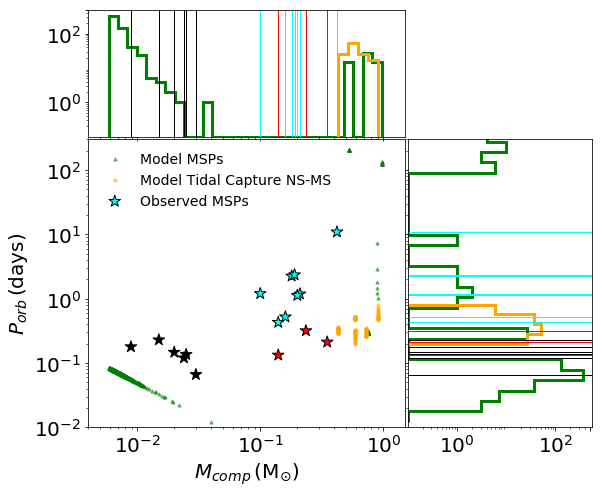

In [22]:
##Ploting Pb-Mc for multiple snapshots
##r, B, P, rol1, mns, mc, kc, sma, ecc, pb for psr_arrays
print(type47)
color47 = ['cyan', 'cyan', 'k', 'k', 'k', 'k', 'cyan', 'k', 'cyan', 'cyan', 'cyan', 'r', 'r', 'cyan', 'cyan', 'k', 'r']


print(psr_bin_filterucb_allsnap_mc)
matplotlib.rcParams.update({'font.size': 20})
#fig, axs = plt.subplots(figsize = (8,6))

##All binary
#axs.scatter(mc47, pb47, marker = '*', s = 150, color = 'k', facecolor = color47, alpha = 1., 
#               label = 'Observed, total 17 binaries')
#axs.scatter(psr_bin_filterucb_allsnap_mc, psr_bin_filterucb_allsnap_pb, s = 20, marker = '^',
#            color = 'green', alpha=0.6)
#axs.scatter(nsms_tc_allsnap_mc, nsms_tc_allsnap_pb, s=80,
#               label = 'Model Tidal Capture NS-MS', alpha = 0.7, color = 'orange')

#axs.set_title('Total 32 Model Binaries')

#axs.set_yscale('log')
#axs.set_xscale('log')
#axs.set_ylabel(r'$P_{orb}\, (\rm{days})$')
#axs.set_xlabel(r'$M_c\, (\rm{M_{\odot}})$')
#axs.set_ylim(ymin = 0.005, ymax = 400)
#axs.set_xlim(xmin = 0.003, xmax = 2.)
#axs.legend(loc = 'upper left', fontsize=15)


#psr_binx = np.logspace(np.log10(min(psr_bin_filterucb_allsnap_mc)), np.log10(max(psr_bin_filterucb_allsnap_mc)), 20)
#psr_biny = np.logspace(np.log10(min(psr_bin_filterucb_allsnap_pb)), np.log10(max(psr_bin_filterucb_allsnap_pb)), 20)
#nsms_binx = np.logspace(np.log10(min(nsms_tc_allsnap_mc)), np.log10(max(nsms_tc_allsnap_mc)), 5)
#nsms_biny = np.logspace(np.log10(min(nsms_tc_allsnap_pb)), np.log10(max(nsms_tc_allsnap_pb)), 5)
#counts, _, _ = np.histogram2d(psr_bin_filterucb_allsnap_mc, psr_bin_filterucb_allsnap_pb, bins=(bin1, bin2))
##axs[0].pcolormesh(bin1, bin2, counts.T, cmap = 'Greens')
#fig, axs = plt.subplots(nrows = 2, figsize = (8,10))
#axs[0].hist(psr_bin_filterucb_allsnap_mc, bins = psr_binx)
#axs[0].hist(nsms_tc_allsnap_mc, bins = nsms_binx)
#for xx in range(len(mc47)):
#    axs[0].axvline(x = mc47[xx], color = color47[xx])
#
#axs[1].hist(psr_bin_filterucb_allsnap_pb, bins = psr_biny)
#axs[1].hist(nsms_tc_allsnap_pb, bins = nsms_biny)
#for xx in range(len(mc47)):
#    axs[1].axvline(x = pb47[xx], color = color47[xx])
#
#axs[0].set_xscale('log')
#axs[0].set_yscale('log')
#axs[1].set_xscale('log')
#axs[1].set_yscale('log')
##axs[0].set_ylim(ymax = 200)
##axs[0].set_xlim(xmin = 0.001)
#fig.tight_layout()


###Maybe can plot it this way?
def scatter_hist(x1, y1, x2, y2, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    color47 = ['cyan', 'cyan', 'k', 'k', 'k', 'k', 'cyan', 'k', 'cyan', 'cyan', 'cyan', 'r', 'r', 'cyan', 'cyan', 'k', 'r']
    ax.scatter(x1, y1, s = 10,  label = 'Model MSPs', marker = '^', color = 'green', alpha=0.5)
    ax.scatter(x2, y2, s=10, label = 'Model Tidal Capture NS-MS', alpha = 0.5, color = 'orange')
    ax.scatter(mc47, pb47, marker = '*', s = 150, color = 'k', facecolor = color47, alpha = 1., 
               label = 'Observed MSPs')

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x1)), np.max(np.abs(y1)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    #bins = np.arange(-lim, lim + binwidth, binwidth)
    #print(bins)
    for xx in range(len(mc47)):
        ax_histx.axvline(x = mc47[xx], color = color47[xx], lw = 1)
    for xx in range(len(mc47)):
        ax_histy.axhline(y = pb47[xx], color = color47[xx], lw = 1)
    ax_histx.hist(x1, bins=np.logspace(np.log10(np.min(x1)), np.log10(np.max(x1)), 30), 
                  log=True, color = 'green', histtype = 'step', lw = 3)
    ax_histy.hist(y1, bins=np.logspace(np.log10(np.min(y1)), np.log10(np.max(y1)), 30), orientation='horizontal',
                 log=True, color = 'green', histtype = 'step', lw = 3)
    ax_histx.hist(x2, bins=np.logspace(np.log10(np.min(x2)), np.log10(np.max(x2)), 5), 
                  log=True, color = 'orange', histtype = 'step', lw = 3)
    ax_histy.hist(y2, bins=np.logspace(np.log10(np.min(y2)), np.log10(np.max(y2)), 5), orientation='horizontal',
                 log=True, color = 'orange', histtype = 'step', lw = 3)
    
    ax.set_xlim(xmin = 0.004, xmax = 1.5)
    ax.set_ylim(ymin = 0.01, ymax = 300)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$M_{comp}\, (\rm{M_{\odot}})$')
    ax.set_ylabel(r'$P_{orb}\,$(days)')
    ax.legend(loc = 'upper left', fontsize = 14, frameon = False)
    
    
    ax_histx.set_yticks([1., 100., 500.])
    ax_histy.set_xticks([1., 100., 500.])
    
    fig.tight_layout()

##plotting
# definitions for the axes
left, width = 0.1, 0.55
bottom, height = 0.1, 0.5
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.22]
rect_histy = [left + width + spacing, bottom, 0.32, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(psr_bin_filterucb_allsnap_mc, psr_bin_filterucb_allsnap_pb, nsms_tc_allsnap_mc, nsms_tc_allsnap_pb, ax, ax_histx, ax_histy)
fig.tight_layout()
#plt.savefig('/projects/b1095/syr904/projects/massive_clusters/psr_pb_mc_cmccosmicver1_912gyr.pdf', dpi=300, bbox_inches = 'tight')

In [6]:
##Average rc and rh centered at the best-fit models and going to the past 1 Gyr and future 1 Gyr
l_conv = dyn.conv('l', path+'initial.conv.sh')
m_conv = dyn.conv('m', path+'initial.conv.sh')

r_c = []; r_h = []; mass = []
with open(path+'initial.dyn.dat', 'r') as fdyn:
    next(fdyn); next(fdyn)
    for line in fdyn:
        datadyn = line.split()
        if 0.41432478<=float(datadyn[0])<=0.50624704:
            r_c.append(float(datadyn[7])*l_conv)
            r_h.append(float(datadyn[20])*l_conv)
            mass.append(float(datadyn[4])*m_conv)
        
print(np.mean(mass), np.mean(r_c), np.mean(r_h))
print(np.std(mass), np.std(r_c), np.std(r_h))

snapnos = np.linspace(706, 742, 19)
r_cobs = []; r_hl = []
for vv in range(len(snapnos)):
    datapara = np.genfromtxt(path+'initial.snap'+str(int(snapnos[vv]))+'.cluster_params.dat')
    r_cobs.append(datapara[0,8]); r_hl.append(datapara[0,9])
        
print(np.mean(r_cobs), np.mean(r_hl))
print(uc.pc2arcsec(4.52, np.mean(r_cobs))/60., uc.pc2arcsec(4.52, np.mean(r_hl))/60.)
print(uc.pc2arcsec(4.52, np.std(r_cobs))/60., uc.pc2arcsec(4.52, np.std(r_hl))/60.)
r_cobs_arcmin = uc.pc2arcsec(4.52, np.array(r_cobs))/60.
r_hl_arcmin = uc.pc2arcsec(4.52, np.array(r_hl))/60.
print(np.mean(r_cobs_arcmin), np.mean(r_hl_arcmin))
print(np.std(r_cobs_arcmin), np.std(r_hl_arcmin))


1010639.7082855614 0.8988606261651921 6.50126264200775
8485.469549974043 0.01745284712137396 0.09681707421871068
0.4585172162926233 3.5932075207117546
0.3487314335529348 2.732862290063494
0.016297113911099493 0.1380142850899034
0.3487314335529348 2.732862290063494
0.016297113911099496 0.13801428508990343


190.666854037849 2.9063947107791965 20.704970689793623
9.429600222228679 0.7201070000214043 1.514380392610983
2375.283250155239 1113.3361065513236
/703(t=0.40815094)
2716.1118871679473 1462.5390685321352
/706(t=0.41432478)
2649.80532918824 1396.2325105524278
/709(t=0.42069706)
2617.96767628643 1396.7659273280005
/712(t=0.42618584)
2565.9763025758684 1318.679601010996
/715(t=0.431985)
2538.7187319947516 1244.3071126552918
/718(t=0.44095965)
2491.6936504423684 1237.477358701648
/721(t=0.44568109)
2491.885247962657 1279.8169154326113
/724(t=0.45484318)
2404.056732971672 1155.8357886528718
/727(t=0.46740728)
2364.976417331535 1167.1257052118196
/730(t=0.47266432)
2364.985605688235 1173.0139236499178
/733(t=0.47867046)
2326.8698814212626 1167.2804674910349
/736(t=0.48697791)
2224.695615593563 1110.493826274646
/739(t=0.49795204)
2217.1412507569403 1123.801126403343
/742(t=0.50624704)
2200.200505697628 1122.9903040852073
/745(t=0.51723392)
2126.2179942463817 1022.7020652180021
/748(t=0.52430

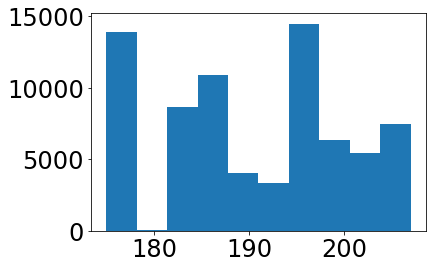

In [29]:
##Average number of BHs centered at the best-fit models and going to the past 1 Gyr and future 1 Gyr
#path = '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/'
#path = '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon_IMFhigh2.3/'
bhs = np.genfromtxt(path.replace('observed_profiles/', '')+'initial.bh.dat')
t_conv = dyn.conv('t', path.replace('observed_profiles/', '')+'initial.conv.sh')
l_conv = dyn.conv('l', path.replace('observed_profiles/', '')+'initial.conv.sh')
bh_time = bhs[:,1]; Nbh_tot = bhs[:,2]; Nbhbh = bhs[:,5]; Nbhbin = bhs[:,4]

Nbh_inter = []; Nbhbh_inter = []; Nbhbin_inter = []
for xx in range(len(bh_time)):
    thetime = bh_time[xx]*t_conv
    if 9100.<=thetime<=11200.:
        Nbh_inter.append(Nbh_tot[xx])
        Nbhbh_inter.append(Nbhbh[xx])
        Nbhbin_inter.append(Nbhbin[xx])
        
print(np.mean(Nbh_inter), np.mean(Nbhbh_inter), np.mean(Nbhbin_inter))
print(np.std(Nbh_inter), np.std(Nbhbh_inter), np.std(Nbhbin_inter))

plt.figure()
plt.hist(Nbh_inter)

#rc = 0.82 ##pc
###Total mass of BHs in the best-fit model
#m_bh = 0; m_bh_rc = 0
#with gzip.open(path+'initial.snap0507.dat.gz') as fsnap:
#    next(fsnap); next(fsnap)
#    for line in fsnap:
#        data = line.split()
#        if int(data[7])!=1:
#            if int(data[14]) == 14:
#                m_bh += float(data[1])
#                if float(data[2])*l_conv <= 1.:
#                    m_bh_rc += float(data[1])
#        
#        else:
#            if int(data[17])==14:
#                m_bh += float(data[8])
#                if float(data[2])*l_conv <= 1.:
#                    m_bh_rc += float(data[8])
#            if int(data[18])==14:
#                m_bh += float(data[9])
#                if float(data[2])*l_conv <= 1.:
#                    m_bh_rc += float(data[9])
#                
#print(m_bh, m_bh_rc)

##For CMC-COSMIC ver 1.0.0
sys.path.insert(1, '/projects/b1095/syr904/MyCodes/cmctoolkit')
import cmctoolkit as cmct
    
snap_h5 = cmct.Snapshot(fname=path.replace('observed_profiles/', '')+'initial.snapshots.h5', snapshot_name='/726(t=0.46262262)', 
                     conv=path.replace('observed_profiles/', '')+'initial.conv.sh', 
                     dist=4.52, # distance to cluster in kpc
                     z=0.0038)

binflag = snap_h5.data['binflag']

rsin = snap_h5.data['r'][binflag != 1]*l_conv
rbin = snap_h5.data['r'][binflag == 1]*l_conv

ksin = snap_h5.data['startype'][binflag != 1]
kbin0 = snap_h5.data['bin_startype0'][binflag == 1]
kbin1 = snap_h5.data['bin_startype1'][binflag == 1]

msin = snap_h5.data['m_MSUN'][binflag != 1]
mbin0 = snap_h5.data['m0_MSUN'][binflag == 1]
mbin1 = snap_h5.data['m1_MSUN'][binflag == 1]

msin_bh = msin[ksin == 14]; mbin0_bh = mbin0[kbin0 == 14]; mbin1_bh = mbin1[kbin1 == 14]
rsin_bh = rsin[ksin == 14]; rbin0_bh = rbin[kbin0 == 14]; rbin1_bh = rbin[kbin1 == 14]

m_tot = list(msin[ksin == 14]) + list(mbin0[kbin0 == 14]) + list(mbin1[kbin1 == 14])
m_tot_rc = list(msin_bh[rsin_bh <= 0.9]) + list(mbin0_bh[rbin0_bh <= 0.9]) + list(mbin1_bh[rbin1_bh <= 0.9])

print(np.sum(m_tot), np.sum(m_tot_rc))

snapnos = np.linspace(703, 757, 19)
snap_keys = np.genfromtxt(path.replace('observed_profiles/', '')+'snap_keys.txt', dtype = str)
allsnapno = snap_keys[:,0]; allsnapkey = snap_keys[:,1]
mbh_tot = []; mbh_tot_rc = []
for ii in range(len(snapnos)): 
    thekey = '/'+str(int(snapnos[ii]))+'(t='+allsnapkey[int(snapnos[ii])]+')'
    print(thekey)
    snap_h5 = cmct.Snapshot(fname=path.replace('observed_profiles/', '')+'initial.snapshots.h5', 
                            snapshot_name=thekey, 
                            conv=path.replace('observed_profiles/', '')+'initial.conv.sh', 
                            dist=4.52, # distance to cluster in kpc
                            z=0.0038)
    
    binflag = snap_h5.data['binflag']
    
    rsin = snap_h5.data['r'][binflag != 1]*l_conv
    rbin = snap_h5.data['r'][binflag == 1]*l_conv
    
    ksin = snap_h5.data['startype'][binflag != 1]
    kbin0 = snap_h5.data['bin_startype0'][binflag == 1]
    kbin1 = snap_h5.data['bin_startype1'][binflag == 1]
    
    msin = snap_h5.data['m_MSUN'][binflag != 1]
    mbin0 = snap_h5.data['m0_MSUN'][binflag == 1]
    mbin1 = snap_h5.data['m1_MSUN'][binflag == 1]
    
    msin_bh = msin[ksin == 14]; mbin0_bh = mbin0[kbin0 == 14]; mbin1_bh = mbin1[kbin1 == 14]
    rsin_bh = rsin[ksin == 14]; rbin0_bh = rbin[kbin0 == 14]; rbin1_bh = rbin[kbin1 == 14]
    
    m_tot = list(msin[ksin == 14]) + list(mbin0[kbin0 == 14]) + list(mbin1[kbin1 == 14])
    m_tot_rc = list(msin_bh[rsin_bh <= 0.9]) + list(mbin0_bh[rbin0_bh <= 0.9]) + list(mbin1_bh[rbin1_bh <= 0.9])
    
    print(np.sum(m_tot), np.sum(m_tot_rc))
    mbh_tot.append(np.sum(m_tot)); mbh_tot_rc.append(np.sum(m_tot_rc))
    
print(np.mean(mbh_tot), np.std(mbh_tot))
print(np.mean(mbh_tot_rc), np.std(mbh_tot_rc))

In [16]:
##Average number of NSs, young pulsars and MSPs centered at the best-fit models and going to the past 1 Gyr and future 1 Gyr
#path = '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/'
nss = np.genfromtxt(path.replace('observed_profiles', '')+'initial.ns.dat')
t_conv = dyn.conv('t', path.replace('observed_profiles', '')+'initial.conv.sh')
ns_time = nss[:,0]; Nns_tot = nss[:,1]; Npsr = nss[:,5]; Nmsp = nss[:,6]; Nnsns = nss[:,7]
#print(ns_time)

Nns_inter = []; Npsr_inter = []; Nmsp_inter = []; Nnsns_inter = []
for xx in range(len(ns_time)):
    thetime = ns_time[xx]
    if 9100.<=thetime<=11200.:
        Nns_inter.append(Nns_tot[xx])
        Npsr_inter.append(Npsr[xx]+5)
        Nmsp_inter.append(Nmsp[xx]+5)
        Nnsns_inter.append(Nnsns[xx])

print(len(Nmsp))
print(Nns_inter)
print(np.mean(Nns_inter), np.mean(Npsr_inter),  np.mean(Nmsp_inter), np.mean(Nnsns_inter))
print(np.std(Nns_inter), np.std(Npsr_inter),  np.std(Nmsp_inter), np.std(Nnsns_inter))
print(np.mean(np.array(Npsr_inter)-np.array(Nmsp_inter)))
print(np.std(np.array(Npsr_inter)-np.array(Nmsp_inter)))

###################################################
#snapnos = np.linspace(706, 742, 19)
#snapnos = np.linspace(499, 515, 9)

n_sin = []; n_bin = []; n_aic = []
n_gchard = []; n_tchard = []
n_gc = []; n_tc = []
n_ucxb = []
MSPfiles = np.sort(glob(path.replace('observed_profiles', '')+'MSP*.dat'))
#for yy in range(len(snapnos)):
for yy in range(9, 35):
    #msp_file = np.genfromtxt(path+'MSP'+str(int(snapnos[yy]))+'.dat')
    msp_file = np.genfromtxt(MSPfiles[yy])
    print(MSPfiles[yy])
    m1 = msp_file[:,9]; k1 = msp_file[:,13]; snflag = msp_file[:,16]; tcflag = msp_file[:,17]
    n_sin.append(len(k1[k1==-100])); n_bin.append(len(k1[k1!=-100]))
    n_aic.append(len(snflag[snflag==4]))
    n_gchard.append(len(tcflag[tcflag==81])); n_tchard.append(len(tcflag[tcflag==91]))
    
    Nucxb = 0; Ngc = 0; Ntc = 0
    for kk in range(len(m1)):
        if m1[kk]<=0.01 and k1[kk]>10:
            Nucxb+=1
        if tcflag[kk]==81 or tcflag[kk]==82 or tcflag[kk]==83:
            Ngc+=1
        if tcflag[kk]==91 or tcflag[kk]==92 or tcflag[kk]==93:
            Ntc+=1
    
    n_ucxb.append(Nucxb)
    n_gc.append(Ngc); n_tc.append(Ntc)
    
    #if snapnos[yy]==507.:
    #if snapnos[yy]==726.:
    #    print(n_sin[-1], n_bin[-1], n_aic[-1], n_gchard[-1], n_tchard[-1], n_gc[-1], n_tc[-1], n_ucxb[-1])
    
print(np.mean(n_sin), np.mean(n_bin), np.mean(n_aic),np.mean(n_gchard),np.mean(n_tchard),
      np.mean(n_gc),np.mean(n_tc),np.mean(n_ucxb))



785
[1369.0, 1369.0, 1368.0, 1368.0, 1369.0, 1369.0, 1369.0, 1368.0, 1368.0, 1368.0, 1368.0, 1368.0, 1369.0, 1369.0, 1369.0, 1369.0, 1368.0, 1366.0, 1366.0, 1366.0, 1366.0, 1367.0, 1367.0, 1367.0, 1367.0, 1367.0, 1367.0, 1367.0, 1367.0, 1368.0, 1368.0, 1368.0, 1367.0, 1367.0, 1367.0, 1367.0, 1368.0]
1367.7027027027027 53.351351351351354 53.108108108108105 0.0
0.9547849585219294 0.9646793674364729 0.7272229214634438 0.0
0.24324324324324326
0.4290407531456093
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/MSP703.dat
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/MSP706.dat
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/MSP708.dat
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/MSP710.dat
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/MSP712.dat
/projects/b1095/syr904/

In [28]:
##Average number of CVs centered at the best-fit models and going to the past 1 Gyr and future 1 Gyr
#snapnos = np.linspace(499, 515, 9)
#snapnos = np.linspace(706, 742, 19)

#path = '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv3.5_3e6_tcon_fb10/'
WDfiles = np.sort(glob(path.replace('observed_profiles/', '')+'WDMS*.dat'))
#WDfiles = np.sort(glob(path+'WDMS*.dat'))
print(len(WDfiles))

n_cv = []; n_cv_rh = []; n_cv_bright = []; n_cv_bright_rh = []
id0_tot = []; id1_tot = []
#for yy in range(len(WDfiles)):
for yy in range(9, 37):
    #wd_file = np.genfromtxt(path+'WDMS'+str(int(snapnos[yy]))+'.dat')
    print(WDfiles[yy])
    if WDfiles[yy]=='/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/WDMS744.dat' or WDfiles[yy]=='/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/WDMS746.dat':
        continue
    wd_file = np.genfromtxt(WDfiles[yy])
    m1 = wd_file[:,3]; rad1 = wd_file[:,9]; rpc = wd_file[:,15]
    id0 = wd_file[:,0]; id1 = wd_file[:,1]
    
    Ncv = 0; Ncv_rh = 0; Ncv_bright = 0; Ncv_bright_rh = 0
    for kk in range(len(rad1)):
        if rad1[kk]>=1.:
            Ncv+=1
            id0_tot.append(int(id0[kk])); id1_tot.append(int(id1[kk]))
            if m1[kk]>0.5: 
                Ncv_bright+=1
                
                if rpc[kk]<6.55:
                    Ncv_bright_rh+=1
                
            if rpc[kk]<6.55:
                Ncv_rh+=1
    
    n_cv.append(Ncv); n_cv_rh.append(Ncv_rh)
    n_cv_bright.append(Ncv_bright); n_cv_bright_rh.append(Ncv_bright_rh)
    
    #if snapnos[yy]==726.:
    if WDfiles[yy] == '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/WDMS733.dat':
    #if WDfiles[yy] == '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv3.5_3e6_tcon_fb10/WDMS449.dat':
        print('733:', Ncv, Ncv_rh, Ncv_bright, Ncv_bright_rh)
    
print(np.mean(n_cv), np.mean(n_cv_rh), np.mean(n_cv_bright), np.mean(n_cv_bright_rh))
print(np.std(n_cv), np.std(n_cv_rh), np.std(n_cv_bright), np.std(n_cv_bright_rh))


#######################################   
##Check for primordial binary
#print(id0_tot)
print(len(id0_tot), len(id0_tot)/25)
id_tot_unique = []
id_tot_temp = []
for ii in range(len(id0_tot)):
    if str(id0_tot[ii])+str(id1_tot[ii]) not in id_tot_temp and str(id1_tot[ii])+str(id0_tot[ii]) not in id_tot_temp:
        id_tot_unique.append(str(id0_tot[ii])+str(id1_tot[ii]))
        id_tot_temp.append(str(id0_tot[ii])+str(id1_tot[ii]))    
print(len(id_tot_unique))

n_pri = 0; n_pri_effect = 0; n_pri_unique = 0
sys.path.insert(1, '/projects/b1095/syr904/MyCodes/cmctoolkit')
import cmctoolkit as cmct

snap_h5 = cmct.Snapshot(fname=path.replace('observed_profiles', '')+'initial.snapshots.h5', snapshot_name='/0(t=0)', 
                     conv=path.replace('observed_profiles', '')+'initial.conv.sh', 
                     dist=4.52, # distance to cluster in kpc
                     z=0.0038)

binflag = np.array(snap_h5.data['binflag'])
id0_snap0 = np.array(snap_h5.data['id0'])[binflag == 1]
id1_snap0 = np.array(snap_h5.data['id1'])[binflag == 1]
#print(id0_snap0)

for yy in range(len(id0_snap0)):
    #for xx in range(len(id0_tot)):
    #    if (int(id0_tot[xx])==int(id0_snap0[yy]) and int(id1_tot[xx])==int(id1_snap0[yy])) or (int(id1_tot[xx])==int(id0_snap0[yy]) and int(id0_tot[xx])==int(id1_snap0[yy])):
    #        n_pri+=1
    #        break
            
    for xx in range(len(id_tot_unique)):
        if str(int(id0_snap0[yy]))+ str(int(id1_snap0[yy])) == id_tot_unique[xx]:
            n_pri_unique+=1
            break
        elif str(int(id1_snap0[yy]))+ str(int(id0_snap0[yy])) == id_tot_unique[xx]:
            n_pri_unique+=1
            break
    
print(n_pri, n_pri/25)
print(n_pri_unique, len(id_tot_unique))

45
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/WDMS703.dat
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/WDMS706.dat
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/WDMS708.dat
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/WDMS710.dat
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/WDMS712.dat
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/WDMS714.dat
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/WDMS716.dat
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/WDMS718.dat
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/WDMS720.dat
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601

In [30]:
##Average number of LMXBs centered at the best-fit models and going to the past 1 Gyr and future 1 Gyr
#snapnos = np.linspace(499, 515, 9)
#snapnos = np.linspace(706, 742, 19)

n_tot = [[],[],[],[],[],[]]
n_tot_rh = [[],[],[],[],[],[]]

id0_tot = []; id1_tot = []

NSWDfiles = np.sort(glob(path.replace('observed_profiles', '')+'NSWD*.dat'))
NSGfiles = np.sort(glob(path.replace('observed_profiles', '')+'NSG*.dat'))
NSMSfiles = np.sort(glob(path.replace('observed_profiles', '')+'NSMS*.dat'))
BHWDfiles = np.sort(glob(path.replace('observed_profiles', '')+'BHWD*.dat'))
BHGfiles = np.sort(glob(path.replace('observed_profiles', '')+'BHG*.dat'))
BHMSfiles = np.sort(glob(path.replace('observed_profiles', '')+'BHMS*.dat'))

MSPfiles = np.sort(glob(path.replace('observed_profiles', '')+'MSP*.dat'))

#for yy in range(len(snapnos)):
for yy in range(9,36):
    if NSWDfiles[yy]=='/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/NSWD744.dat' or NSWDfiles[yy]=='/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/NSWD746.dat':
        continue
    print(NSWDfiles[yy])
    #nswd_file = np.genfromtxt(path+'NSWD'+str(int(snapnos[yy]))+'.dat')
    #nsg_file = np.genfromtxt(path+'NSGiant'+str(int(snapnos[yy]))+'.dat')
    #nsms_file = np.genfromtxt(path+'NSMS'+str(int(snapnos[yy]))+'.dat')
    #
    #bhwd_file = np.genfromtxt(path+'BHWD'+str(int(snapnos[yy]))+'.dat')
    #bhg_file = np.genfromtxt(path+'BHGiant'+str(int(snapnos[yy]))+'.dat')
    #bhms_file = np.genfromtxt(path+'BHMS'+str(int(snapnos[yy]))+'.dat')
    #
    #msp_file = np.genfromtxt(path+'MSP'+str(int(snapnos[yy]))+'.dat')
    nswd_file = np.genfromtxt(NSWDfiles[yy])
    nsg_file = np.genfromtxt(NSGfiles[yy])
    nsms_file = np.genfromtxt(NSMSfiles[yy])
    
    bhwd_file = np.genfromtxt(BHWDfiles[yy])
    bhg_file = np.genfromtxt(BHGfiles[yy])
    bhms_file = np.genfromtxt(BHMSfiles[yy])
    
    msp_file = np.genfromtxt(MSPfiles[yy])
    id0_msp = msp_file[:,10]; id1_msp = msp_file[:,11]
    
    
    Ntot = [0, 0, 0, 0 ,0 ,0]
    Ntot_rh = [0, 0, 0, 0 ,0 ,0] 
    
    all_files = [nswd_file, nsg_file, nsms_file, bhwd_file, bhg_file, bhms_file]
    for xx in range(len(all_files)):
        if len(all_files[xx])==0:
            n_tot[xx].append(Ntot[xx]); n_tot_rh[xx].append(Ntot_rh[xx])
            continue
        
        if isinstance(all_files[xx][0], float):
            m1 = all_files[xx][3]; rad1= all_files[xx][9]; rpc = all_files[xx][15]
            id0 = all_files[xx][0]; id1 = all_files[xx][1]; tcflag = all_files[xx][12]
            
            if rad1>=1. and id0 not in id0_msp:
                Ntot[xx]+=1
                if xx==2 and tcflag==91:
                    Ntot[xx]-=1
                else:
                    id0_tot.append(int(id0)); id1_tot.append(int(id1))
                    
                if rpc<6.55:
                    Ntot_rh[xx]+=1
                    if xx==2 and tcflag==91:
                        Ntot_rh[xx]-=1
        
        else:
            m1 = all_files[xx][:,3]; rad1= all_files[xx][:,9]; rpc = all_files[xx][:,15]
            id0 = all_files[xx][:,0]; id1 = all_files[xx][:,1]; tcflag = all_files[xx][:,12]
            
            for kk in range(len(rad1)):  
                if rad1[kk]>=1. and id0[kk] not in id0_msp:
                    Ntot[xx]+=1
                    if xx==2 and tcflag[kk]==91:
                        Ntot[xx]-=1
                    else:
                        id0_tot.append(int(id0[kk])); id1_tot.append(int(id1[kk]))
                    
                    if rpc[kk]<6.55:
                        Ntot_rh[xx]+=1
                        if xx==2 and tcflag[kk]==91:
                            Ntot_rh[xx]-=1
        
    
        n_tot[xx].append(Ntot[xx]); n_tot_rh[xx].append(Ntot_rh[xx])
    
    #if snapnos[yy]==726.:
    if NSWDfiles[yy] == '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/NSWD733.dat':
        print('733:', Ntot, Ntot_rh)
    
print(np.sum(n_tot, axis = 0),np.sum(n_tot_rh, axis = 0))
print(np.mean(np.sum(n_tot, axis=0)), np.std(np.sum(n_tot, axis=0)))
print(np.mean(np.sum(n_tot_rh, axis=0)), np.std(np.sum(n_tot_rh, axis=0)))

for ii in range(len(all_files)):
    print(np.mean(n_tot[ii]), np.mean(n_tot_rh[ii]))


#######################################   
##Check for primordial binary
#print(id0_tot)
print(len(id0_tot), len(id0_tot)/19)
id_tot_unique = []
id_tot_temp = []
for ii in range(len(id0_tot)):
    if str(id0_tot[ii])+str(id1_tot[ii]) not in id_tot_temp and str(id1_tot[ii])+str(id0_tot[ii]) not in id_tot_temp:
        id_tot_unique.append(str(id0_tot[ii])+str(id1_tot[ii]))
        id_tot_temp.append(str(id0_tot[ii])+str(id1_tot[ii]))    
print(len(id_tot_unique))
print(id_tot_unique)

n_pri = 0; n_pri_effect = 0; n_pri_unique = 0
sys.path.insert(1, '/projects/b1095/syr904/MyCodes/cmctoolkit')
import cmctoolkit as cmct

snap_h5 = cmct.Snapshot(fname=path.replace('observed_profiles/', '')+'initial.snapshots.h5', snapshot_name='/0(t=0)', 
                     conv=path.replace('observed_profiles/', '')+'initial.conv.sh', 
                     dist=4.52, # distance to cluster in kpc
                     z=0.0038)

binflag = np.array(snap_h5.data['binflag'])
id0_snap0 = np.array(snap_h5.data['id0'])[binflag == 1]
id1_snap0 = np.array(snap_h5.data['id1'])[binflag == 1]
#print(id0_snap0)

for yy in range(len(id0_snap0)):
    #for xx in range(len(id0_tot)):
    #    if (int(id0_tot[xx])==int(id0_snap0[yy]) and int(id1_tot[xx])==int(id1_snap0[yy])) or (int(id1_tot[xx])==int(id0_snap0[yy]) and int(id0_tot[xx])==int(id1_snap0[yy])):
    #        n_pri+=1
    #        break
            
    for xx in range(len(id_tot_unique)):
        if str(int(id0_snap0[yy]))+ str(int(id1_snap0[yy])) == id_tot_unique[xx]:
            n_pri_unique+=1
            break
        elif str(int(id1_snap0[yy]))+ str(int(id0_snap0[yy])) == id_tot_unique[xx]:
            n_pri_unique+=1
            break
print(n_pri, n_pri/19)
print(n_pri_unique, len(id_tot_unique))

/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/NSWD703.dat


/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:34: UserWarning: genfromtxt: Empty input file: "/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/NSGiant700.dat"
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: genfromtxt: Empty input file: "/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/BHGiant700.dat"


/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/NSWD706.dat
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/NSWD708.dat
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/NSWD710.dat
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/NSWD712.dat
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/NSWD714.dat
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/NSWD716.dat
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/NSWD718.dat
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/NSWD720.dat
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/NSWD722.dat
/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MO

/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:34: UserWarning: genfromtxt: Empty input file: "/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/NSGiant703.dat"
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: genfromtxt: Empty input file: "/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/BHGiant703.dat"
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:34: UserWarning: genfromtxt: Empty input file: "/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/NSGiant706.dat"
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: genfromtxt: Empty input file: "/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/BHGiant706.dat"
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:34: UserWarning:

0 0.0
0 28


9.789473684210526
0.5913978494623656
26
26


/software/anaconda3.6/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:50: RuntimeWarning: divide by zero encountered in log10
/software/anaconda3.6/lib/python3.6/site-packages/numpy/core/function_base.py:159: RuntimeWarning: invalid value encountered in multiply
  y *= step
/software/anaconda3.6/lib/python3.6/site-packages/numpy/core/function_base.py:168: RuntimeWarning: invalid value encountered in add
  y += start
/software/anaconda3.6/lib/python3.6/site-packages/numpy/lib/histograms.py:421: RuntimeWarning: invalid value encountered in greater
  if np.any(bin_edges[:-1] > bin_edges[1:]):


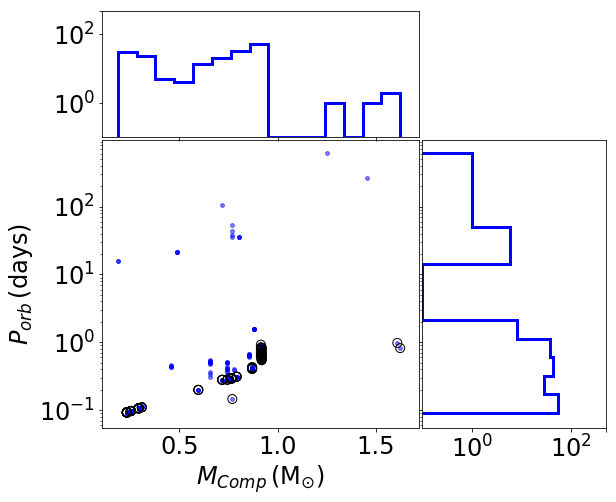

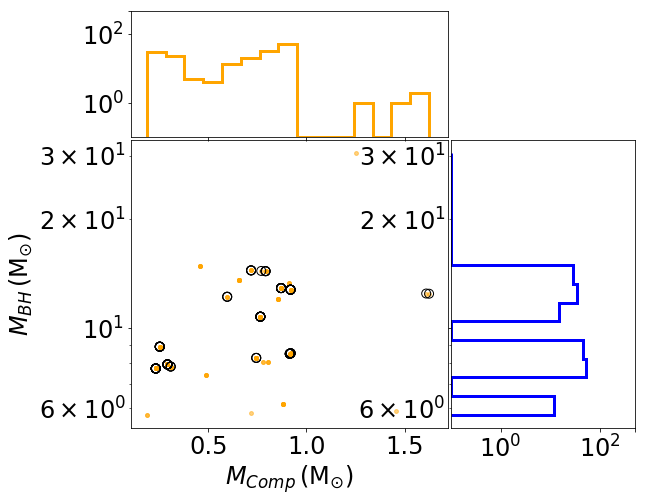

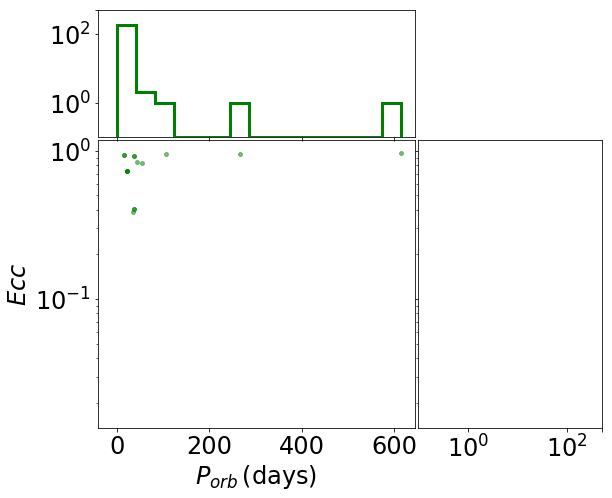

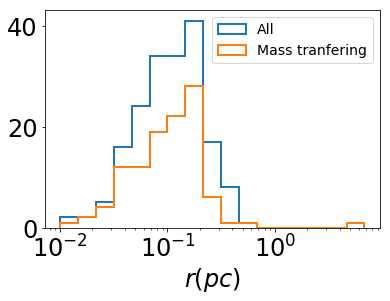

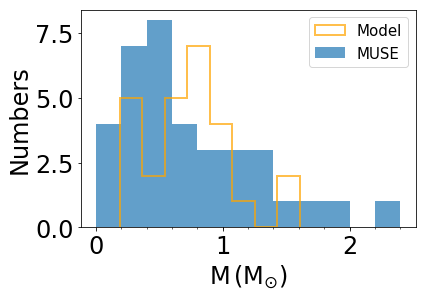

In [6]:
##BH-MS binaries
snapnos = np.linspace(706, 742, 19)

porb = []; mcomp = []; mbh = []
ecc = []; rpc = []
id0 = []; id1 = []
rol1 = []
for yy in range(len(snapnos)):
    bhms_file = np.genfromtxt(path+'BHMS'+str(int(snapnos[yy]))+'.dat')
    
    porb += list(bhms_file[:,6]); ecc += list(bhms_file[:,7])
    mcomp += list(bhms_file[:,3]); mbh += list(bhms_file[:,2])
    rpc += list(bhms_file[:,15])
    id0 += list(bhms_file[:,0]); id1 += list(bhms_file[:,1])
    rol1 += list(bhms_file[:,9])
    
porb_days = uc.au_to_period(np.array(porb), np.array(mbh), np.array(mcomp))
ecc = np.array(ecc)
mbh = np.array(mbh); mcomp = np.array(mcomp)
rol1 = np.array(rol1)
rpc = np.array(rpc)


df = pd.DataFrame(data={"id0": id0, "id1": id1, "porb_day": porb_days, "ecc": ecc, "mbh": mbh, "mcomp": mcomp, 
                            "rpc": rpc, "radrol1": rol1})
df.to_excel("/projects/b1095/syr904/projects/massive_clusters/bh-ms.xlsx", index=False)
    
###Maybe can plot it this way?
def scatter_hist(x1, y1, x2, y2, ax, ax_histx, ax_histy, xlabel, ylabel, thecolor):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x1, y1, s = 15, alpha=0.5, color = thecolor)
    ax.scatter(x2, y2, s = 80, color = 'k', facecolor = 'none')

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x1)), np.max(np.abs(y1)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    #bins = np.arange(-lim, lim + binwidth, binwidth)
    #print(bins)
    #ax_histx.hist(x1, bins=np.logspace(np.log10(np.min(x1)), np.log10(np.max(x1)), 15), 
    #              log=True, color = thecolor, histtype = 'step', lw = 3)
    #ax_histx.hist(x2, bins=np.logspace(np.log10(np.min(x1)), np.log10(np.max(x1)), 15), 
    #              log=True, color = 'k', histtype = 'step', lw = 1.5)
    ax_histx.hist(x1, bins=15, log=True, color = thecolor, histtype = 'step', lw = 3)
    ax_histy.hist(y1, bins=np.logspace(np.log10(np.min(y1)), np.log10(np.max(y1)), 15), orientation='horizontal',
                 log=True, color = 'blue', histtype = 'step', lw = 3)
    #ax_histy.hist(y1, bins=15, orientation='horizontal', log=True, color = thecolor, histtype = 'step', lw = 3)
    #ax_histy.hist(y2, bins=15, orientation='horizontal', log=True, color = 'k', histtype = 'step', lw = 1.5)


    #ax.set_xlim(xmin = 0.004, xmax = 1.5)
    #ax.set_ylim(ymin = 0.01, ymax = 300)
    #ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    #ax.legend(loc = 'upper left', fontsize = 14, frameon = False)
    
    
    ax_histx.set_yticks([1., 100., 500.])
    ax_histy.set_xticks([1., 100., 500.])
    
    fig.tight_layout()

##plotting
# definitions for the axes
left, width = 0.1, 0.55
bottom, height = 0.1, 0.5
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.22]
rect_histy = [left + width + spacing, bottom, 0.32, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(mcomp, porb_days, mcomp[rol1>=1], porb_days[rol1>=1], ax, ax_histx, ax_histy, r'$M_{Comp}\, (\rm{M_{\odot}})$', r'$P_{orb}\,$(days)', 'blue')
fig.tight_layout()


fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

scatter_hist(mcomp, mbh, mcomp[rol1>=1], mbh[rol1>=1], ax, ax_histx, ax_histy, r'$M_{Comp}\, (\rm{M_{\odot}})$', r'$M_{BH}\, (\rm{M_{\odot}})$', 
             'orange')
fig.tight_layout()

fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

scatter_hist(porb_days, ecc, porb_days[rol1>=1], ecc[rol1>=1], ax, ax_histx, ax_histy, r'$P_{orb}\,$(days)', r'$Ecc$', 'green')
fig.tight_layout()

plt.figure()
plt.hist(rpc, bins = np.logspace(np.log10(np.min(rpc)), np.log10(np.max(rpc)), 18), histtype = 'step', 
         lw = 2, label = 'All')
plt.hist(rpc[rol1>=1], bins = np.logspace(np.log10(np.min(rpc)), np.log10(np.max(rpc)), 18), histtype = 'step', 
         lw = 2, label = 'Mass tranfering')
plt.xscale('log')
plt.xlabel(r'$r(pc)$')
plt.legend(loc='best', fontsize = '14')

print(len(mbh)/19)
print(len(rol1[rol1>=1])/len(rol1))

##Comparing to MUSE data
muse_height = [4, 7, 8, 4, 3, 3, 3, 1, 1, 1, 0, 1]
muse_mcom = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3]

id0_unique = np.array(list(Counter(id0).keys()))
print(len(id0_unique))
mcomp_unique = []
for ii in range(len(mcomp)-1, 0, -1):
    if id0[ii] in id0_unique:
        mcomp_unique.append(mcomp[ii])
        id0_unique = np.delete(id0_unique, np.where(id0_unique == id0[ii]))
print(len(mcomp_unique))       

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
plt.figure()
plt.bar(muse_mcom, muse_height, width = 0.2, alpha = 0.7, label = 'MUSE')
plt.hist(mcomp_unique, bins = 8, color = 'orange', alpha = 0.7, histtype = 'step', lw = 2,
        label = 'Model')
#plt.hist(mcomp, color = 'red', alpha = 0.7, histtype = 'step', lw = 2,
#        label = 'All')
#plt.yscale('log')
plt.xlabel(r'$\rm{M\,(M_{\odot})}$')
plt.ylabel('Numbers')
ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator())
plt.legend(loc = 'best', fontsize = 15)

/software/anaconda3.6/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:56: RuntimeWarning: divide by zero encountered in log10
/software/anaconda3.6/lib/python3.6/site-packages/numpy/core/function_base.py:159: RuntimeWarning: invalid value encountered in multiply
  y *= step
/software/anaconda3.6/lib/python3.6/site-packages/numpy/core/function_base.py:168: RuntimeWarning: invalid value encountered in add
  y += start
/software/anaconda3.6/lib/python3.6/site-packages/numpy/lib/histograms.py:421: RuntimeWarning: invalid value encountered in greater
  if np.any(bin_edges[:-1] > bin_edges[1:]):


1941.3684210526317
0.1740226644255273
36886 2353
[2310, 17, 26]
26


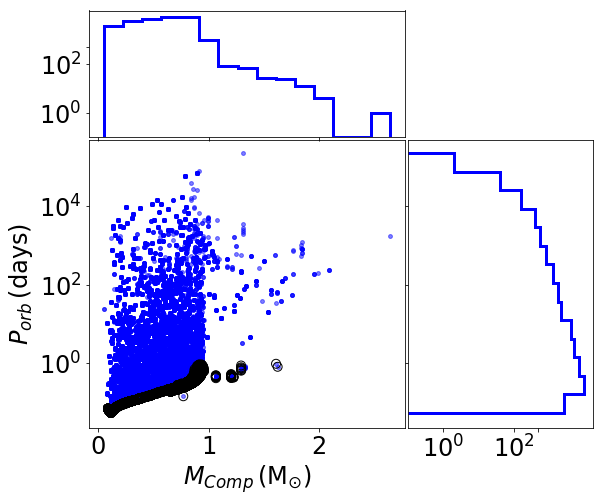

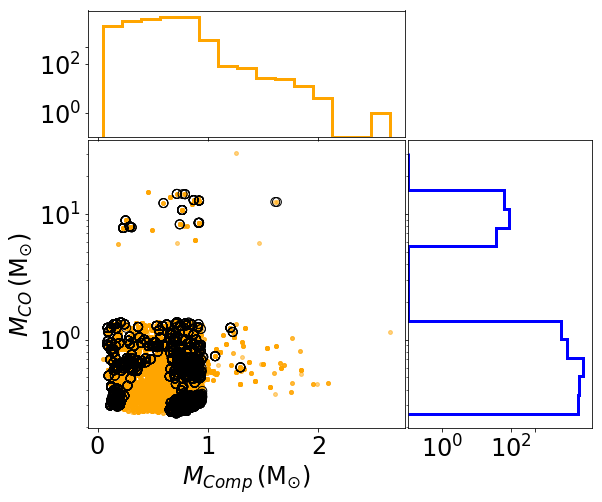

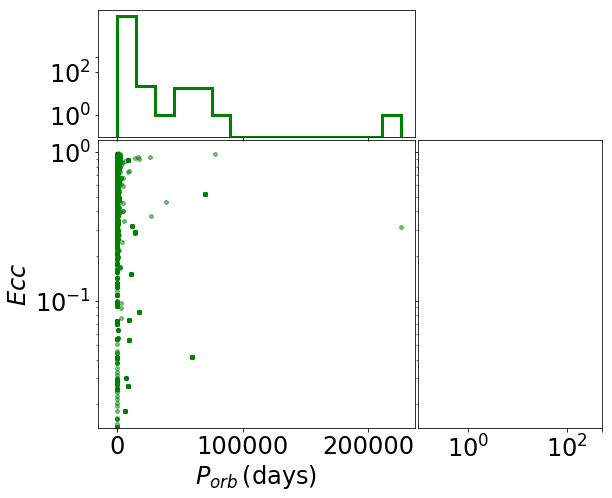

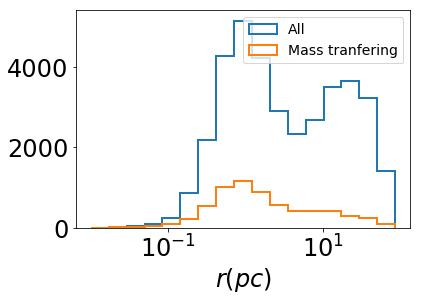

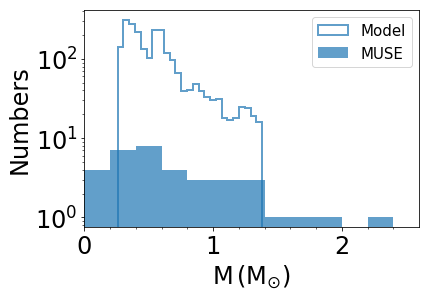

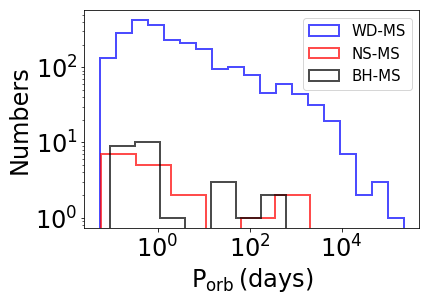

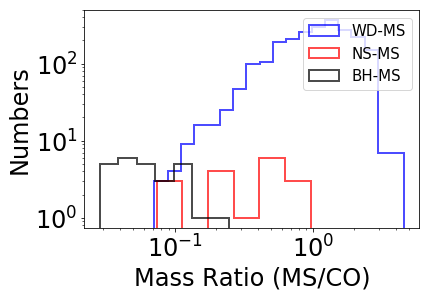

In [11]:
##All compact objects-MS binaries
snapnos = np.linspace(706, 742, 19)

porb = []; mcomp = []; mco = []
ecc = []; rpc = []
id0 = []; id1 = []
rol1 = []
file_names = ['BHMS', 'NSMS', 'WDMS']
cs = []

cols = ['k', 'r', 'b']; array_len = []
for jj in range(3):
    for yy in range(len(snapnos)):
        coms_file = np.genfromtxt(path+file_names[jj]+str(int(snapnos[yy]))+'.dat')

        porb += list(coms_file[:,6]); ecc += list(coms_file[:,7])
        mcomp += list(coms_file[:,3]); mco += list(coms_file[:,2])
        rpc += list(coms_file[:,15])
        id0 += list(coms_file[:,0]); id1 += list(coms_file[:,1])
        rol1 += list(coms_file[:,9])
        
        cs += [cols[jj]]*len(coms_file[:,6])
        
porb_days = uc.au_to_period(np.array(porb), np.array(mco), np.array(mcomp))
ecc = np.array(ecc)
mco = np.array(mco); mcomp = np.array(mcomp)
rol1 = np.array(rol1)
rpc = np.array(rpc)

df = pd.DataFrame(data={"id0": id0, "id1": id1, "porb_day": porb_days, "ecc": ecc, "mco": mco, "mcomp": mcomp, 
                            "rpc": rpc, "radrol1": rol1})
df.to_excel("/projects/b1095/syr904/projects/massive_clusters/co-ms.xlsx", index=False)
    
###Maybe can plot it this way?
def scatter_hist(x1, y1, x2, y2, ax, ax_histx, ax_histy, xlabel, ylabel, thecolor):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x1, y1, s = 15, alpha=0.5, color = thecolor)
    ax.scatter(x2, y2, s = 80, color = 'k', facecolor = 'none')

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x1)), np.max(np.abs(y1)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    #bins = np.arange(-lim, lim + binwidth, binwidth)
    #print(bins)
    #ax_histx.hist(x1, bins=np.logspace(np.log10(np.min(x1)), np.log10(np.max(x1)), 15), 
    #              log=True, color = thecolor, histtype = 'step', lw = 3)
    #ax_histx.hist(x2, bins=np.logspace(np.log10(np.min(x1)), np.log10(np.max(x1)), 15), 
    #              log=True, color = 'k', histtype = 'step', lw = 1.5)
    ax_histx.hist(x1, bins=15, log=True, color = thecolor, histtype = 'step', lw = 3)
    ax_histy.hist(y1, bins=np.logspace(np.log10(np.min(y1)), np.log10(np.max(y1)), 15), orientation='horizontal',
                 log=True, color = 'blue', histtype = 'step', lw = 3)
    #ax_histy.hist(y1, bins=15, orientation='horizontal', log=True, color = thecolor, histtype = 'step', lw = 3)
    #ax_histy.hist(y2, bins=15, orientation='horizontal', log=True, color = 'k', histtype = 'step', lw = 1.5)


    #ax.set_xlim(xmin = 0.004, xmax = 1.5)
    #ax.set_ylim(ymin = 0.01, ymax = 300)
    #ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    #ax.legend(loc = 'upper left', fontsize = 14, frameon = False)
    
    
    ax_histx.set_yticks([1., 100., 500.])
    ax_histy.set_xticks([1., 100., 500.])
    
    fig.tight_layout()

##plotting
# definitions for the axes
left, width = 0.1, 0.55
bottom, height = 0.1, 0.5
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.22]
rect_histy = [left + width + spacing, bottom, 0.32, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(mcomp, porb_days, mcomp[rol1>=1], porb_days[rol1>=1], ax, ax_histx, ax_histy, r'$M_{Comp}\, (\rm{M_{\odot}})$', r'$P_{orb}\,$(days)', 'blue')
fig.tight_layout()


fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

scatter_hist(mcomp, mco, mcomp[rol1>=1], mco[rol1>=1], ax, ax_histx, ax_histy, r'$M_{Comp}\, (\rm{M_{\odot}})$', r'$M_{CO}\, (\rm{M_{\odot}})$', 
             'orange')
fig.tight_layout()

fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

scatter_hist(porb_days, ecc, porb_days[rol1>=1], ecc[rol1>=1], ax, ax_histx, ax_histy, r'$P_{orb}\,$(days)', r'$Ecc$', 'green')
fig.tight_layout()

plt.figure()
plt.hist(rpc, bins = np.logspace(np.log10(np.min(rpc)), np.log10(np.max(rpc)), 18), histtype = 'step', 
         lw = 2, label = 'All')
plt.hist(rpc[rol1>=1], bins = np.logspace(np.log10(np.min(rpc)), np.log10(np.max(rpc)), 18), histtype = 'step', 
         lw = 2, label = 'Mass tranfering')
plt.xscale('log')
plt.xlabel(r'$r(pc)$')
plt.legend(loc='best', fontsize = '14')

print(len(mco)/19)
print(len(rol1[rol1>=1])/len(rol1))

###Comparing to MUSE data
muse_height = [4, 7, 8, 4, 3, 3, 3, 1, 1, 1, 0, 1]
muse_mco = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3]

##Select unique systems
id0_unique = np.array(list(Counter(id0).keys()))
print(len(id0), len(id0_unique))
mco_unique = []; porb_unique = []; cs_unique = []; mcomp_unique = []
for ii in range(len(mco)-1, 0, -1):
    if id0[ii] in id0_unique:
        mco_unique.append(mco[ii]); cs_unique.append(cs[ii])
        porb_unique.append(porb_days[ii]); mcomp_unique.append(mcomp[ii])
        id0_unique = np.delete(id0_unique, np.where(id0_unique == id0[ii]))    
array_len = [cs_unique.count('b'), cs_unique.count('r'), cs_unique.count('k')]
print(array_len)
#print(mco_unique[0:array_len[0]], mco_unique[array_len[0]:array_len[0]+array_len[1]])
#print(mco_unique)
      
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

plt.figure()
plt.bar(muse_mco, muse_height, width = 0.2, alpha = 0.7, label = 'MUSE')
#plt.hist(mco_unique[0:array_len[0]], color = 'b', alpha = 0.7, histtype = 'step', lw = 2,
#         label = 'Model') #bins = np.logspace(np.log10(np.min(mco_unique)),np.log10(np.max(mco_unique)), 20)
#plt.hist(mco_unique[array_len[0]:array_len[0]+array_len[1]], color = 'r', 
#         alpha = 0.7, histtype = 'step', lw = 2,
#         label = 'Model')
#plt.hist(mco_unique[array_len[0]+array_len[1]:], color = 'k', 
#         alpha = 0.7, histtype = 'step', lw = 2,
#         label = 'Model')
plt.hist(mco_unique[0:array_len[0]+array_len[1]], 
         bins = 25, alpha = 0.7, histtype = 'step', lw = 2,
         label = 'Model')
#plt.hist(mcomp, color = 'red', alpha = 0.7, histtype = 'step', lw = 2,
#label = 'All')
#plt.xscale('symlog')
plt.xlim(xmin = 0, xmax = 2.6)
plt.yscale('log')
plt.xlabel(r'$\rm{M\,(M_{\odot})}$')
plt.ylabel('Numbers')
ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator())
plt.legend(loc = 'best', fontsize = 15)

plt.figure()
plt.hist(porb_unique[0:array_len[0]], 
         bins = np.logspace(np.log10(np.min(porb_unique[0:array_len[0]])), np.log10(np.max(porb_unique[0:array_len[0]])), 20), 
         alpha = 0.7, histtype = 'step', lw = 2, color = 'b',
         label = 'WD-MS')
plt.hist(porb_unique[array_len[0]:array_len[0]+array_len[1]], 
         bins = np.logspace(np.log10(np.min(porb_unique[array_len[0]:array_len[0]+array_len[1]])), np.log10(np.max(porb_unique[array_len[0]:array_len[0]+array_len[1]])), 7), 
         alpha = 0.7, histtype = 'step', lw = 2, color = 'r',
         label = 'NS-MS')
plt.hist(porb_unique[array_len[0]+array_len[1]:], 
         bins = np.logspace(np.log10(np.min(porb_unique[array_len[0]+array_len[1]:])), np.log10(np.max(porb_unique[array_len[0]+array_len[1]:])), 8), 
         alpha = 0.7, histtype = 'step', lw = 2, color = 'k',
         label = 'BH-MS')
print(len(porb_unique[array_len[0]+array_len[1]:]))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\rm{P_{orb}\,(days)}$')
plt.ylabel('Numbers')
plt.legend(loc = 'best', fontsize = 15)

mwd_unique = np.array(mco_unique[0:array_len[0]])
mns_unique = np.array(mco_unique[array_len[0]:array_len[0]+array_len[1]])
mbh_unique = np.array(mco_unique[array_len[0]+array_len[1]:array_len[0]+array_len[1]+array_len[2]])
mwdms_unique = np.array(mcomp_unique[0:array_len[0]])
mnsms_unique = np.array(mcomp_unique[array_len[0]:array_len[0]+array_len[1]])
mbhms_unique = np.array(mcomp_unique[array_len[0]+array_len[1]:array_len[0]+array_len[1]+array_len[2]])
plt.figure()
plt.hist(mwdms_unique/mwd_unique, 
         bins = np.logspace(np.log10(np.min(mwdms_unique/mwd_unique)), np.log10(np.max(mwdms_unique/mwd_unique)), 20),
         alpha = 0.7, histtype = 'step', lw = 2, color = 'b',
         label = 'WD-MS')
plt.hist(mnsms_unique/mns_unique,
         bins = np.logspace(np.log10(np.min(mnsms_unique/mns_unique)), np.log10(np.max(mnsms_unique/mns_unique)), 7),
         alpha = 0.7, histtype = 'step', lw = 2, color = 'r',
         label = 'NS-MS')
plt.hist(mbhms_unique/mbh_unique,
         bins = np.logspace(np.log10(np.min(mbhms_unique/mbh_unique)), np.log10(np.max(mbhms_unique/mbh_unique)), 8),
         alpha = 0.7, histtype = 'step', lw = 2, color = 'k',
         label = 'BH-MS')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mass Ratio (MS/CO)')
plt.ylabel('Numbers')
plt.legend(loc = 'best', fontsize = 15)

In [4]:
##All binaries
path = '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/'

sys.path.insert(1, '/projects/b1095/syr904/MyCodes/cmctoolkit')
import cmctoolkit as cmct
    
t_conv=dyn.conv('t', path+'initial.conv.sh')
l_conv=dyn.conv('l', path+'initial.conv.sh')
    
data_snapkey = np.genfromtxt(path+'snap_keys.txt', dtype = str)
temp_t = data_snapkey[:,1]
time_sort = np.array([float(s) for s in data_snapkey[:,1]])*t_conv
no_sort = data_snapkey[:,0]
#print(no_sort, time_sort)

for ii in range(len(time_sort)-1, -1, -6):
    time = time_sort[ii]
    no_snap = no_sort[ii]
    
    if time >12000: continue
    if time < 9000: break
        
    print(time)
    
    key_snap = '/'+no_snap+'(t='+temp_t[ii]+')'
    thesnap = cmct.Snapshot(fname=path+'initial.snapshots.h5', snapshot_name=key_snap, 
                    conv=path+'initial.conv.sh', 
                    dist=4.52, # distance to cluster in kpc
                    z=0.0038)
    
    binflag = np.array(thesnap.data['binflag'])
    id0 = np.array(thesnap.data['id0'])[binflag==1]; id1 = np.array(thesnap.data['id1'])[binflag==1]
    porb_AU = np.array(thesnap.data['a_AU'])[binflag==1]
    ecc = np.array(thesnap.data['e'])[binflag==1]
    m1 = np.array(thesnap.data['m0_MSUN'])[binflag==1]; m2 = np.array(thesnap.data['m1_MSUN'])[binflag==1]
    rpc = np.array(thesnap.data['r'])[binflag==1]*l_conv
    radrol0 = np.array(thesnap.data['radrol0'])[binflag==1]; radrol1 = np.array(thesnap.data['radrol1'])[binflag==1]
    k1 = np.array(thesnap.data['bin_startype0'])[binflag==1]; k2 = np.array(thesnap.data['bin_startype1'])[binflag==1]
    print(len(id0))

    df = pd.DataFrame(data={"id0": id0, "id1": id1, "porb_AU": porb_AU, "ecc": ecc, "m0": m1, "m1": m2, 
                            "k0": k1, "k1": k2, "rpc": rpc, "radrol0": radrol0, "radrol1": radrol1})
    df.to_excel("/projects/b1095/syr904/projects/massive_clusters/all_binaries_t"+str(int(time))+"Myr.xlsx", index=False)

11882.765361852
34476
11554.970608888
34668
11157.077265152
34887
10732.408762908
35156
10416.954415616001
35368
10024.197875384
35600
9718.22153442
35784
9392.624490592
35983
9131.220961464
36156


In [2]:
##Extract info from the best-fit snapshot for the MUSE group
sys.path.insert(1, '/projects/b1095/syr904/MyCodes/cmctoolkit')
import cmctoolkit as cmct
    
path = '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/'
snap = cmct.Snapshot(fname=path+'initial.snapshots.h5', snapshot_name='/733(t=0.47867046)', 
                     conv=path+'initial.conv.sh', 
                     dist=4.52, # distance to cluster in kpc
                     z=0.0038)


print(type(snap.data))
print(sys.getsizeof(snap))
print(sys.getsizeof(snap.data))
snap.data.to_csv('/projects/b1095/syr904/projects/massive_clusters/bestfit_snap733.csv')
df = pd.read_csv("/projects/b1095/syr904/projects/massive_clusters/bestfit_snap733.csv")
print(df['id'])


l_conv = dyn.conv('l', path+'initial.conv.sh')
lengthunitcgs=1.23428e+19
nbtimeunitcgs=2.38988e+12

print(snap.data.columns)
datalist = ['id', 'm_MSUN', 'r', 'vr', 'vt','binflag', 'm0_MSUN',
       'm1_MSUN', 'id0', 'id1', 'a_AU', 'e', 'startype', 'luminosity_LSUN',
       'radius_RSUN', 'bin_startype0', 'bin_startype1', 'bin_star_lum0_LSUN',
       'bin_star_lum1_LSUN', 'bin_star_radius0_RSUN', 'bin_star_radius1_RSUN']

#print(snap.data['vr']*lengthunitcgs/nbtimeunitcgs*1e-5)

#datadict = {}
#for ii in range(len(datalist)):
#    if datalist[ii]=='r':
#        datadict[datalist[ii]] = snap.data[datalist[ii]]*l_conv
#    elif datalist[ii]=='vr' or datalist[ii]=='vt':
#        datadict[datalist[ii]] = snap.data[datalist[ii]]*lengthunitcgs/nbtimeunitcgs*1e-5
#    else:
#        datadict[datalist[ii]] = snap.data[datalist[ii]]
    
#df = pd.DataFrame(datadict)
#df.to_csv("/projects/b1095/syr904/projects/massive_clusters/bestfit_snapshot.csv", index=False)

#df = pd.read_csv("/projects/b1095/syr904/projects/massive_clusters/bestfit_snapshot.csv")
#print(df['r'],df['vr'])

<class 'pandas.core.frame.DataFrame'>
56
1001279064
0          1994110
1           682098
2          1108417
3          1394811
4           923504
5           266341
6           450515
7          1676587
8             7589
9           607947
10          469842
11          497086
12               0
13          857658
14         1056873
15           96358
16          836270
17         3096354
18          124939
19         3034269
20          206010
21           85932
22         3107024
23               0
24         1352893
25           89771
26         1287578
27               0
28          882334
29          472854
            ...   
2035090    1655905
2035091    1458645
2035092     330311
2035093    1491236
2035094    2215662
2035095    1910242
2035096     684962
2035097    1451643
2035098     563877
2035099    2150297
2035100    1151753
2035101    2114359
2035102    1669716
2035103    2173296
2035104    1956487
2035105    1468983
2035106    2178897
2035107    2165368
2035108     91147

2.0713667921378027 6168.133488698296
0
104
3 -100 154725 -100
3 -100 428104 -100
3 -100 780387 -100
3 -100 506904 -100
3 -100 3375806 -100
3 -100 474129 -100
3 -100 1465022 -100
3 -100 1626219 -100
3 -100 831035 -100
3 -100 306272 -100
3 -100 1112002 -100
3 -100 3229423 -100
3 -100 1212409 -100
3 -100 1080273 -100
3 -100 3790221 -100
3 -100 1043970 -100
3 -100 1107520 -100
3 -100 547609 -100
3 -100 3586195 -100
3 -100 1106496 -100
3 -100 1150048 -100
3 -100 689418 -100
2 -100 3222008 -100
3 -100 755455 -100
3 -100 567809 -100
1 -100 3106876 -100
1 -100 3704983 -100
2 -100 3022239 -100
3 -100 436477 -100
3 -100 3673963 -100
3 -100 3806551 -100
3 -100 1281227 -100
3 -100 171692 -100
1 -100 3492296 -100
3 -100 685742 -100
2 -100 3659404 -100
3 -100 780481 -100
3 -100 528066 -100
3 -100 1059587 -100
3 -100 74359 -100
2 -100 3133707 -100
3 -100 3076346 -100
2 -100 3836238 -100
2 -100 3257142 -100
3 -100 1629012 -100
3 -100 1146999 -100
3 -100 1398406 -100
3 -100 1911131 -100
3 -100 1699213 

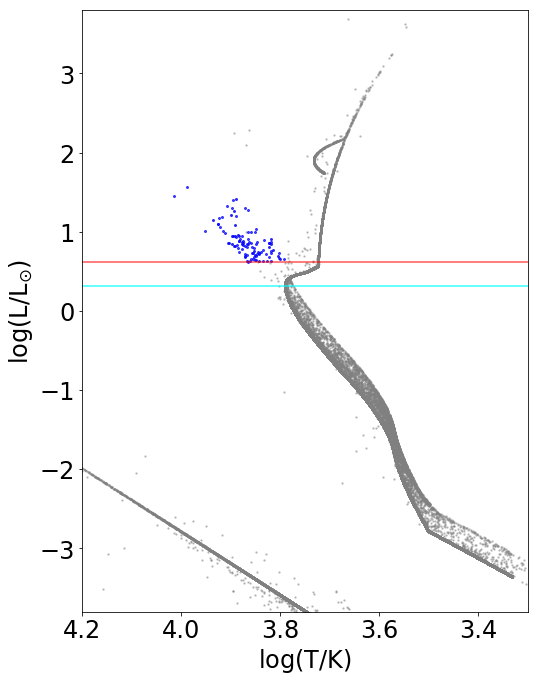

In [8]:
##Lumonisity-temperature plot and blue stragglers
sb_const = 5.670374419*10**(-8)  ##W*m^−2*K^−4, Stefan-Boltzmann Constant
Lsun = 3.828*10**26  ##Watts
Rsun = 6.957*10**8 ##meters

l_conv = dyn.conv('l', path.replace('observed_profiles/', '')+'initial.conv.sh')

def LtoT(lumi, radi):
    r_meter = radi*Rsun
    Area = 2*twopi*r_meter**2
    return pow((lumi*Lsun)/sb_const/Area, 1./4.)


def med3(array):
    if len(array)>4: return np.median(array)
    else: return 0
    

def get_turnoff(snapshot,Nbins=200):
    '''Purpose: Find the MS turnoff, defined as the luminosity (and temperature)
    of the highest-temperature upper-MS single that is NOT a blue straggler.
    Inputs: snapshot array and bin resolution for both luminosity and temperature axes of an HR diagram.
    Outputs: turnoff point (luminosity,temperature). Units: (Lsun,Kelvin).'''
    
    T0, L0 = [], []
    L_bin_edges = np.logspace(-0.5,0.5,int(Nbins+1))
    #print(L_bin_edges)
    L_bins = [[] for i in range(int(Nbins))]
    T_bins = [[] for i in range(int(Nbins))]
    
    ##For cmc 3.2
    #with gzip.open(snapshot, 'r') as fsnap:
    #    next(fsnap); next(fsnap)
    #    for line in fsnap:
    #        data = line.split()
    #        binflag, startype, L, R = int(data[7]), int(data[14]), float(data[15]), float(data[16])
            
    #        if binflag != 1 and startype == 1:                  # If single and on upper ms
    #            T0.append(LtoT(L, R)); L0.append(L)
    
    ##For CMC-COSMIC ver 1.0.0
    binflag = snapshot.data['binflag']
    L = snapshot.data['luminosity_LSUN'][binflag != 1]
    ktype = snapshot.data['startype'][binflag != 1]
    R = snapshot.data['radius_RSUN'][binflag != 1]
    
    L0 = L[ktype == 1]; R0 = R[ktype == 1]
    T0 = LtoT(L0, R0)
    L0 = np.array(L0); T0 = np.array(T0)
    #print(L0, T0)
       
    #print(L0, T0)
    for j,Lj in enumerate(L0):
        for b in range(int(Nbins)):
            if L_bin_edges[b] <= Lj < L_bin_edges[b+1]: T_bins[b].append(T0[j]); L_bins[b].append(L0[j])

    T_meds = [med3(bin) for bin in T_bins]                  # List the median temperature of each bin
    turnoff_bin_index = T_meds.index(np.max(T_meds))        # Find the bin with the highest median temperature
    
    return (np.median(L_bins[turnoff_bin_index]), T_meds[turnoff_bin_index])


#path = '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/'
#snap = path+'initial.snap0507.dat.gz'
sys.path.insert(1, '/projects/b1095/syr904/MyCodes/cmctoolkit')
import cmctoolkit as cmct
    
snap_h5 = cmct.Snapshot(fname=path.replace('observed_profiles/', '')+'initial.snapshots.h5', snapshot_name='/733(t=0.47867046)', 
                     conv=path.replace('observed_profiles/', '')+'initial.conv.sh', 
                     dist=4.52, # distance to cluster in kpc
                     z=0.0038)

Lto, Tto = get_turnoff(snap_h5,400)
print(Lto, Tto)

Ltot = []; Temp = []; k0 = []; k1 = []; id0_tot = []; id1_tot = []; rpos_tot = []
L_bss = []; T_bss = []; k0_bss = []; k1_bss = []; id0_bss = []; id1_bss = []

n_bright = 0
##For cmc 3.2
#with gzip.open(snap, 'r') as fsnap:
#    next(fsnap); next(fsnap)
#    for line in fsnap:
#        data = line.split()
#        if int(data[7])!=1 and int(data[14]) != 14:
#            temperature = LtoT(float(data[15]), float(data[16]))
#            Temp.append(temperature)
#            Ltot.append(float(data[15]))
#            k0.append(int(data[14])); k1.append(-100)
#            
#            if np.log10(float(data[15]))>0. and np.log10(temperature)>4.6:
#                print(int(data[14]), float(data[1]), float(data[15]), int(data[0]))
#                n_bright += 1
#                
#            if float(data[15]) > 2*Lto and temperature > Tto and (int(data[14]) == 1 or int(data[14]) == 0):
#                L_bss.append(float(data[15])); T_bss.append(temperature)
#                k0_bss.append(int(data[14])); k1_bss.append(-100)
#            
#        elif int(data[17]) != 14 or int(data[18]) != 14:
#            temperature0 = LtoT(float(data[19]), float(data[21]))
#            temperature1 = LtoT(float(data[20]), float(data[22]))
#            temp_eff = (temperature0*float(data[19])+temperature1*float(data[20]))/(float(data[19])+float(data[20]))
#            Temp.append(temp_eff)
#            Ltot.append(float(data[19])+float(data[20]))
#            k0.append(int(data[17])); k1.append(int(data[18]))
#            
#            if np.log10(temp_eff)>4.6:
#                print(int(data[17]), int(data[18]), float(data[8]), float(data[9]))
#                
#            if float(data[19])> 2*Lto and temperature0 > Tto and (int(data[17]) == 1 or int(data[17]) == 0):
#                L_bss.append(float(data[19])); T_bss.append(temperature0)
#                k0_bss.append(int(data[17])); k1_bss.append(int(data[18]))
#                
#            if float(data[20])> 2*Lto and temperature1 > Tto and (int(data[18]) == 1 or int(data[18]) == 0):
#                L_bss.append(float(data[20])); T_bss.append(temperature1)
#                k0_bss.append(int(data[18])); k1_bss.append(int(data[17]))

##For CMC-COSMIC ver 1.0.0
binflag = snap_h5.data['binflag']
Lsin = snap_h5.data['luminosity_LSUN'][binflag != 1]
Lbin0 = np.array(snap_h5.data['bin_star_lum0_LSUN'][binflag == 1])
Lbin1 = np.array(snap_h5.data['bin_star_lum1_LSUN'][binflag == 1])
ktype = snap_h5.data['startype'][binflag != 1]
kbin0 = np.array(snap_h5.data['bin_startype0'][binflag == 1])
kbin1 = np.array(snap_h5.data['bin_startype1'][binflag == 1])
Rsin = snap_h5.data['radius_RSUN'][binflag != 1]
Rbin0 = np.array(snap_h5.data['bin_star_radius0_RSUN'][binflag == 1])
Rbin1 = np.array(snap_h5.data['bin_star_radius1_RSUN'][binflag == 1])
ID0_sin = np.array(snap_h5.data['id'][binflag != 1])
ID0_bin = np.array(snap_h5.data['id0'][binflag == 1])
ID1_bin = np.array(snap_h5.data['id1'][binflag == 1])
rpos_sin = np.array(snap_h5.data['r'][binflag != 1])*l_conv
rpos_bin = np.array(snap_h5.data['r'][binflag == 1])*l_conv


###For single stars
Lsin_nobh = np.array(Lsin[ktype != 14]); Rsin_nobh = np.array(Rsin[ktype != 14])
Tsin_nobh = LtoT(Lsin_nobh, Rsin_nobh)
ktype_nobh = ktype[ktype != 14]
id0_nobh = ID0_sin[ktype != 14]
rpos_nobh = rpos_sin[ktype != 14]
Temp  = Temp + list(Tsin_nobh)
Ltot = Ltot + list(Lsin_nobh)
k0 = k0 + list(ktype_nobh)
k1 = k1 + list(np.full_like(k0, -100))
id0_tot = id0_tot + list(id0_nobh)
id1_tot = id1_tot + list(np.full_like(id0_nobh, -100))
rpos_tot = rpos_tot + list(rpos_nobh)

##Selecting BSS
Ltemp1 = Lsin_nobh[Lsin_nobh >= 2*Lto]; Ttemp1 = Tsin_nobh[Lsin_nobh >= 2*Lto]
ktype_temp1 = ktype_nobh[Lsin_nobh >= 2*Lto]
Ltemp2 = Ltemp1[Ttemp1 >= Tto]; Ttemp2 = Ttemp1[Ttemp1 >= Tto]
ktype_temp2 = ktype_temp1[Ttemp1 >= Tto]
id0_temp1 = id0_nobh[Lsin_nobh >= 2*Lto]
id0_temp2 = id0_temp1[Ttemp1 >= Tto]
L_bss = L_bss + list(Ltemp2[ktype_temp2 == 0]) + list(Ltemp2[ktype_temp2 == 1])
T_bss = T_bss + list(Ttemp2[ktype_temp2 == 0]) + list(Ttemp2[ktype_temp2 == 1])
id0_bss = id0_bss + list(id0_temp2[ktype_temp2 == 0])+list(id0_temp2[ktype_temp2 == 1])
id1_bss = id1_bss + list(np.full_like(id0_bss, -200))
k0_bss = k0_bss + list(ktype_temp2[ktype_temp2 == 0]) + list(ktype_temp2[ktype_temp2 == 1])
k1_bss = k1_bss + list(np.full_like(k0_bss, -200))

###For binary stars
for kk in range(len(Lbin0)):
    if kbin0[kk] != 14 or kbin1[kk] != 14:
        temperature0 = LtoT(Lbin0[kk], Rbin0[kk])
        temperature1 = LtoT(Lbin1[kk], Rbin1[kk])
        temp_eff = (temperature0*Lbin0[kk]+temperature1*Lbin1[kk])/(Lbin0[kk] + Lbin1[kk])
        Temp.append(temp_eff)
        Ltot.append(Lbin0[kk] + Lbin1[kk])
        k0.append(kbin0[kk]); k1.append(kbin1[kk])
        id0_tot.append(ID0_bin[kk]); id1_tot.append(ID1_bin[kk])
        rpos_tot.append(rpos_bin[kk])
            
        if Lbin0[kk] > 2*Lto and temperature0 > Tto and (kbin0[kk] == 1 or kbin0[kk] == 0):
            L_bss.append(Lbin0[kk]); T_bss.append(temperature0)
            id0_bss.append(ID0_bin[kk]); id1_bss.append(ID1_bin[kk])
            k0_bss.append(kbin0[kk]); k1_bss.append(kbin1[kk])
            
        if Lbin1[kk] > 2*Lto and temperature1 > Tto and (kbin1[kk] == 1 or kbin1[kk] == 0):
            L_bss.append(Lbin1[kk]); T_bss.append(temperature1)
            id0_bss.append(ID1_bin[kk]); id1_bss.append(ID0_bin[kk])
            k1_bss.append(kbin0[kk]); k0_bss.append(kbin1[kk])
          
            
print(n_bright)
print(len(L_bss))


##Select stars visible above the sub-giant branch and to the blue of the red giant branch
L_select = []; T_select = []
for ii in range(len(Ltot)):
    if math.log10(Temp[ii]) > 3.73 and Temp[ii] < Tto and Ltot[ii] > 2*Lto and math.log10(Ltot[ii])<1.7:
        print(k0[ii], k1[ii], id0_tot[ii], id1_tot[ii])
        L_select.append(Ltot[ii]); T_select.append(Temp[ii])
        if id0_tot[ii] in id0_bss or id1_tot[ii] in id1_bss:
            print('yes')
        
        
        
fig, ax = plt.subplots(figsize = (8,10))
ax.scatter(np.log10(Temp[::5]), np.log10(Ltot[::5]), s = 2, alpha = 0.4, color = 'gray', rasterized = True)
ax.scatter(np.log10(T_bss), np.log10(L_bss), s = 4, alpha=0.7, color = 'b')
#ax.scatter(np.log10(T_select), np.log10(L_select), s = 4, alpha=0.7, color = 'gold')
ax.axhline(y =  np.log10(Lto), color = 'aqua', lw = 2, alpha=0.6)
ax.axhline(y =  np.log10(2*Lto), color = 'red', lw = 2, alpha=0.5)
#ax.axvline(x =  np.log10(Tto), color = 'gray', lw = 2, alpha=0.6)
ax.set_ylim(ymin = -3.8, ymax = 3.8)
ax.set_xlim(xmin = 3.3, xmax = 4.2)
ax.set_xlabel(r'$\rm{log}(T/K)$')
ax.set_ylabel(r'$\rm{log}(L/L_{\odot})$')
plt.gca().invert_xaxis()

plt.tight_layout()
#plt.savefig('/projects/b1095/syr904/projects/massive_clusters/bss_cmc3.2.pdf', dpi=100)
#plt.savefig('/projects/b1095/syr904/projects/massive_clusters/bss_cmccosmicver1_updated.pdf', dpi=100)

##Deposit the stellar luminosity, temperature and radial position into a txt file
rpos_tot_sort, Ltot_sort = (np.array(t) for t in zip(*sorted(zip(rpos_tot, Ltot))))
rpos_tot_sort, Temp_sort = (np.array(t) for t in zip(*sorted(zip(rpos_tot, Temp))))

#np.savetxt(path+'lum_temp_allstar_733.dat', np.c_[rpos_tot_sort, Ltot_sort, Temp_sort], 
#           fmt = '%f %f %f', delimiter = ' ', header = '1.r[pc], 2.Lum[Lsun], 3.T[K]', 
#           comments = '#')
#np.savetxt(path+'allBSS_733.dat', np.c_[id0_bss, id1_bss, k0_bss, k1_bss, T_bss, L_bss],
#          fmt = '%d %d %d %d %f %f', delimiter = ' ',
#          header = '1.id0 2.id1 3.k0 4.k1 5.T(K) 6.L(Lsun)', comments = '#')

In [7]:
####Average number of BSSs centered at the best-fit models and going to the past 1 Gyr and future 1 Gyr
sb_const = 5.670374419*10**(-8)  ##W*m^−2*K^−4, Stefan-Boltzmann Constant
Lsun = 3.828*10**26  ##Watts
Rsun = 6.957*10**8 ##meters

import scripts, scripts1, scripts2, scripts3

def LtoT(lumi, radi):
    r_meter = radi*Rsun
    Area = 2*twopi*r_meter**2
    return pow((lumi*Lsun)/sb_const/Area, 1./4.)



def med3(array):
    if len(array)>4: return np.median(array)
    else: return 0
    

def get_turnoff(snapshot,Nbins=200):
    '''Purpose: Find the MS turnoff, defined as the luminosity (and temperature)
    of the highest-temperature upper-MS single that is NOT a blue straggler.
    Inputs: snapshot array and bin resolution for both luminosity and temperature axes of an HR diagram.
    Outputs: turnoff point (luminosity,temperature). Units: (Lsun,Kelvin).'''
    
    T0, L0 = [], []
    L_bin_edges = np.logspace(-0.5,0.5,int(Nbins+1))
    #print(L_bin_edges)
    L_bins = [[] for i in range(int(Nbins))]
    T_bins = [[] for i in range(int(Nbins))]
    
    ##For cmc 3.2
    #with gzip.open(snapshot, 'r') as fsnap:
    #    next(fsnap); next(fsnap)
    #    for line in fsnap:
    #        data = line.split()
    #        binflag, startype, L, R = int(data[7]), int(data[14]), float(data[15]), float(data[16])
            
    #        if binflag != 1 and startype == 1:                  # If single and on upper ms
    #            T0.append(LtoT(L, R)); L0.append(L)
    
    ##For CMC-COSMIC ver 1.0.0
    binflag = snapshot.data['binflag']
    L = snapshot.data['luminosity_LSUN'][binflag != 1]
    ktype = snapshot.data['startype'][binflag != 1]
    R = snapshot.data['radius_RSUN'][binflag != 1]
    
    L0 = L[ktype == 1]; R0 = R[ktype == 1]
    T0 = LtoT(L0, R0)
    L0 = np.array(L0); T0 = np.array(T0)
    #print(L0, T0)
       
    #print(L0, T0)
    for j,Lj in enumerate(L0):
        for b in range(int(Nbins)):
            if L_bin_edges[b] <= Lj < L_bin_edges[b+1]: T_bins[b].append(T0[j]); L_bins[b].append(L0[j])

    T_meds = [med3(bin) for bin in T_bins]                  # List the median temperature of each bin
    turnoff_bin_index = T_meds.index(np.max(T_meds))        # Find the bin with the highest median temperature
    
    return (np.median(L_bins[turnoff_bin_index]), T_meds[turnoff_bin_index])


#path = '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/'
#snap = path+'initial.snap0507.dat.gz'
sys.path.insert(1, '/projects/b1095/syr904/MyCodes/cmctoolkit')
import cmctoolkit as cmct

#snapnos = np.linspace(499, 515, 9)
#snapnos = [507]
#path = '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/'
snapnos = np.linspace(703, 757, 19)
print(snapnos)
l_conv = dyn.conv('l', path.replace('observed_profiles', '')+'initial.conv.sh')
all_keys = np.genfromtxt(path.replace('observed_profiles', '')+'snap_keys.txt', dtype = 'str')
all_snapno = all_keys[:,0]; all_snaptime = all_keys[:,1]

n_bss = []; n_bss_rh = []
bss_id = []
for ii in range(len(snapnos)):
    #snap = path+'initial.snap0'+str(int(snapnos[ii]))+'.dat.gz'
    
    thekey = '/'+str(int(snapnos[ii]))+'(t='+all_snaptime[int(snapnos[ii])]+')'
    snap_h5 = cmct.Snapshot(fname=path.replace('observed_profiles', '')+'initial.snapshots.h5', snapshot_name=thekey, 
                     conv=path.replace('observed_profiles', '')+'initial.conv.sh', 
                     dist=4.52, # distance to cluster in kpc
                     z=0.0038)

    Lto, Tto = get_turnoff(snap_h5,400)
    print(Lto, Tto)

    L_bss = []; T_bss = []; k0_bss = []; k1_bss = []
    L_bss_rh = []; T_bss_rh = []; k0_bss_rh = []; k1_bss_rh = []
    Temp = []; Ltot = []
    ##For cmc 3.2
    #with gzip.open(snap, 'r') as fsnap:
    #    next(fsnap); next(fsnap)
    #    for line in fsnap:
    #        data = line.split()
    #        if int(data[7])!=1 and int(data[14]) != 14:
    #            temperature = LtoT(float(data[15]), float(data[16]))
    #            
    #            if float(data[15]) > 2*Lto and temperature > Tto and (int(data[14]) == 1 or int(data[14]) == 0):
    #                L_bss.append(float(data[15])); T_bss.append(temperature)
    #                k0_bss.append(int(data[14])); k1_bss.append(-100)
    #                bss_id.append(int(data[0]))
    #                
    #                if float(data[2])*l_conv < 6.53:
    #                    L_bss_rh.append(float(data[15])); T_bss_rh.append(temperature)
    #                    k0_bss_rh.append(int(data[14])); k1_bss_rh.append(-100)
    #        
    #        elif int(data[17]) != 14 or int(data[18]) != 14:
    #            temperature0 = LtoT(float(data[19]), float(data[21]))
    #            temperature1 = LtoT(float(data[20]), float(data[22]))
    #            temp_eff = (temperature0*float(data[19])+temperature1*float(data[20]))/(float(data[19])+float(data[20]))
    #    
    #            if float(data[19])> 2*Lto and temperature0 > Tto and (int(data[17]) == 1 or int(data[17]) == 0):
    #                L_bss.append(float(data[19])); T_bss.append(temperature0)
    #                k0_bss.append(int(data[17])); k1_bss.append(int(data[18]))
    #                bss_id.append(int(data[10]))
    #                
    #                if float(data[2])*l_conv < 6.53:
    #                    L_bss_rh.append(float(data[19])); T_bss_rh.append(temperature0)
    #                    k0_bss_rh.append(int(data[17])); k1_bss_rh.append(int(data[18]))
    #            
    #            if float(data[20])> 2*Lto and temperature1 > Tto and (int(data[18]) == 1 or int(data[18]) == 0):
    #                L_bss.append(float(data[20])); T_bss.append(temperature1)
    #                k0_bss.append(int(data[18])); k1_bss.append(int(data[17]))
    #                bss_id.append(int(data[11]))
    #                
    #                if float(data[2])*l_conv < 6.53:
    #                    L_bss_rh.append(float(data[20])); T_bss_rh.append(temperature1)
    #                    k0_bss_rh.append(int(data[18])); k1_bss_rh.append(int(data[17]))
    
    ##For CMC-COSMIC ver 1.0.0
    binflag = snap_h5.data['binflag']
    rgc = snap_h5.data['r']*l_conv
    rgcsin = np.array(rgc[binflag != 1]); rgcbin = np.array(rgc[binflag == 1])
    
    Lsin = snap_h5.data['luminosity_LSUN'][binflag != 1]
    Lbin0 = np.array(snap_h5.data['bin_star_lum0_LSUN'][binflag == 1])
    Lbin1 = np.array(snap_h5.data['bin_star_lum1_LSUN'][binflag == 1])
    ktype = snap_h5.data['startype'][binflag != 1]
    kbin0 = np.array(snap_h5.data['bin_startype0'][binflag == 1])
    kbin1 = np.array(snap_h5.data['bin_startype1'][binflag == 1])
    Rsin = snap_h5.data['radius_RSUN'][binflag != 1]
    Rbin0 = np.array(snap_h5.data['bin_star_radius0_RSUN'][binflag == 1])
    Rbin1 = np.array(snap_h5.data['bin_star_radius1_RSUN'][binflag == 1])
    idsin = snap_h5.data['id'][binflag != 1]
    idbin0 = np.array(snap_h5.data['id0'][binflag == 1]); idbin1 = np.array(snap_h5.data['id1'][binflag == 1])
    
    ###For single stars
    Lsin_nobh = np.array(Lsin[ktype != 14]); Rsin_nobh = np.array(Rsin[ktype != 14])
    Tsin_nobh = LtoT(Lsin_nobh, Rsin_nobh)
    ktype_nobh = ktype[ktype != 14]
    rgcsin_nobh = rgcsin[ktype != 14]
    idsin_nobh = idsin[ktype != 14]
    
    ##Selecting BSS
    Ltemp1 = Lsin_nobh[Lsin_nobh >= 2*Lto]; Ttemp1 = Tsin_nobh[Lsin_nobh >= 2*Lto]
    ktype_temp1 = ktype_nobh[Lsin_nobh >= 2*Lto]
    Ltemp2 = Ltemp1[Ttemp1 >= Tto]; Ttemp2 = Ttemp1[Ttemp1 >= Tto]
    ktype_temp2 = ktype_temp1[Ttemp1 >= Tto]
    idsin_temp1 = idsin_nobh[Lsin_nobh >= 2*Lto]
    idsin_temp2 = idsin_temp1[Ttemp1 >= Tto]
    r_temp1 = rgcsin_nobh[Lsin_nobh >= 2*Lto]; r_temp2 = r_temp1[Ttemp1 >= Tto]
    
    r_bss = np.concatenate((r_temp2[ktype_temp2 == 0], r_temp2[ktype_temp2 == 1]), axis=None)
    L_bss = L_bss + list(Ltemp2[ktype_temp2 == 0]) + list(Ltemp2[ktype_temp2 == 1])
    T_bss = T_bss + list(Ttemp2[ktype_temp2 == 0]) + list(Ttemp2[ktype_temp2 == 1])
    bss_id = bss_id + list(idsin_temp2[ktype_temp2 == 0]) + list(idsin_temp2[ktype_temp2 == 1])
    bss_id = [int(i) for i in bss_id]
    
    L_bss = np.array(L_bss); T_bss = np.array(T_bss)
    L_bss_rh = L_bss_rh + list(L_bss[r_bss <= 6.5])
    T_bss_rh = T_bss_rh + list(T_bss[r_bss <= 6.5])
    L_bss = list(L_bss); T_bss = list(T_bss)
    
    ###For binary stars
    for kk in range(len(Lbin0)):
        if kbin0[kk] != 14 or kbin1[kk] != 14:
            temperature0 = LtoT(Lbin0[kk], Rbin0[kk])
            temperature1 = LtoT(Lbin1[kk], Rbin1[kk])
            temp_eff = (temperature0*Lbin0[kk]+temperature1*Lbin1[kk])/(Lbin0[kk] + Lbin1[kk])
            Temp.append(temp_eff)
            Ltot.append(Lbin0[kk] + Lbin1[kk])
                
            if Lbin0[kk] > 2*Lto and temperature0 > Tto and (kbin0[kk] == 1 or kbin0[kk] == 0):
                L_bss.append(Lbin0[kk]); T_bss.append(temperature0)
                bss_id.append(int(idbin0[kk]))
                if rgcbin[kk] <= 6.5:
                    L_bss_rh.append(Lbin0[kk]); T_bss_rh.append(temperature0)
                
            if Lbin1[kk] > 2*Lto and temperature1 > Tto and (kbin1[kk] == 1 or kbin1[kk] == 0):
                L_bss.append(Lbin1[kk]); T_bss.append(temperature1)
                bss_id.append(int(idbin1[kk]))
                if rgcbin[kk] <= 6.5:
                    L_bss_rh.append(Lbin0[kk]); T_bss_rh.append(temperature0)

    n_bss.append(len(L_bss))
    n_bss_rh.append(len(L_bss_rh))

print(n_bss, n_bss_rh)
print(np.mean(n_bss), np.mean(n_bss_rh))
print(np.std(n_bss), np.std(n_bss_rh))

#print(bss_id)
bss_id_unique = Counter(bss_id).keys()
collfile = scripts1.readcollfile(path.replace('observed_profiles', '')+'initial.collision.log')
n_bss_coll = 0
bss_coll = []
for ii in range(len(collfile)):
    line = collfile[ii].split()
    if int(line[3]) in bss_id_unique:
        n_bss_coll+=1
        bss_coll.append(int(line[3]))
#bss_coll =  list(Counter(bss_coll).keys())
    
bss_id_unique = list(bss_id_unique)
for kk in range(len(bss_id_unique)):
    if bss_id_unique[kk] in bss_coll:
        continue
    else:
        print(bss_id_unique[kk])
print(np.sort(bss_id_unique))
print(np.sort(bss_coll))
                
    
print(n_bss_coll, len(bss_coll))
print(len(bss_id_unique))

[703. 706. 709. 712. 715. 718. 721. 724. 727. 730. 733. 736. 739. 742.
 745. 748. 751. 754. 757.]
2.3783306959658503 6266.071206725936
2.3510127425494414 6256.16463033095
2.3239888909390207 6246.170647980389
2.297047181426994 6237.754488464947
2.2709366502989194 6229.036846315766
2.2192548590968806 6216.058304538209
2.1940410480775627 6209.736648137656
2.156823603578909 6197.743891470598
2.1194771105760397 6181.857833705892
2.0950986925975696 6175.395051665115
2.0713667921378027 6168.133488698296
2.047454256497435 6158.302904604361
2.012687071735658 6145.677764373373
1.9778874927772063 6136.399388538521
1.9437751098065013 6124.440524210648
1.921482135464444 6116.93491601202
1.9109798738403525 6109.678038244181
1.8788469037923834 6101.610004692794
1.8566452461760237 6093.345367573735
[98, 95, 102, 97, 103, 98, 101, 102, 105, 107, 104, 101, 108, 111, 103, 99, 103, 100, 91] [95, 95, 102, 97, 102, 98, 101, 101, 104, 105, 102, 100, 106, 109, 102, 98, 102, 99, 91]
101.47368421052632 100.4736

103.0 7.406150405560721


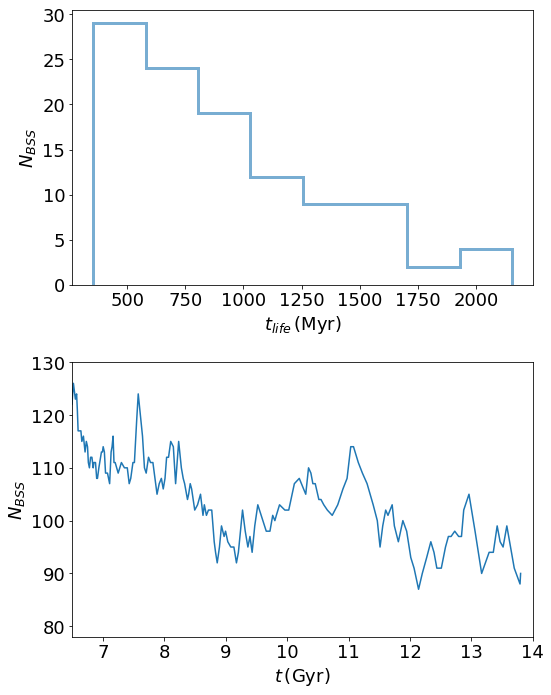

In [19]:
##Number of BSS as a function of time and a distribution of snapshot 726 BSS lifetime
data_nbss = np.genfromtxt(path.replace('observed_profiles/','')+'nbss_time.dat')
data_bss726 = np.genfromtxt(path.replace('observed_profiles/','')+'allBSS_726.dat')

n_bss = data_nbss[:,1]; tsnap = data_nbss[:,0]

n_bss_late = n_bss[tsnap>7000.]
print(np.mean(n_bss_late), np.std(n_bss_late))

t_726 = 0.47867046*22038.8
tform_726 = data_bss726[:,-1]
tlife_726 = t_726-tform_726

matplotlib.rcParams.update({'font.size': 18})

fig, axs = plt.subplots(nrows = 2, figsize = (8,10))
axs[0].hist(tlife_726, bins = 8, histtype = 'step', lw = 3, alpha = 0.6)
axs[0].set_xlabel(r'$t_{life}\,\rm{(Myr)}$')
axs[0].set_ylabel(r'$N_{BSS}$')
#plt.savefig('/projects/b1095/syr904/projects/massive_clusters/bss726_lifetime.pdf', dpi=300)


#fig,ax = plt.subplots(figsize = (8,6))
axs[1].plot(tsnap[1:]/1000., n_bss[1:])
#ax.set_xscale('log')
#.set_yscale('log')
axs[1].set_xlim(xmin = 6.5, xmax = 14.)
axs[1].set_ylim(ymax = 130, ymin = 78)
axs[1].set_xlabel(r'$t\,\rm{(Gyr)}$')
axs[1].set_ylabel(r'$N_{BSS}$')
plt.tight_layout()
#plt.savefig('/projects/b1095/syr904/projects/massive_clusters/nbss_time.pdf', dpi=300)
plt.savefig('/projects/b1095/syr904/projects/massive_clusters/nbss_time_bss726_lifetime.pdf', dpi=300)


13.798793112921599


Text(0,0.5,'$PE\\,(\\rm{M_{\\odot}\\,km\\,s^{-1}})$')

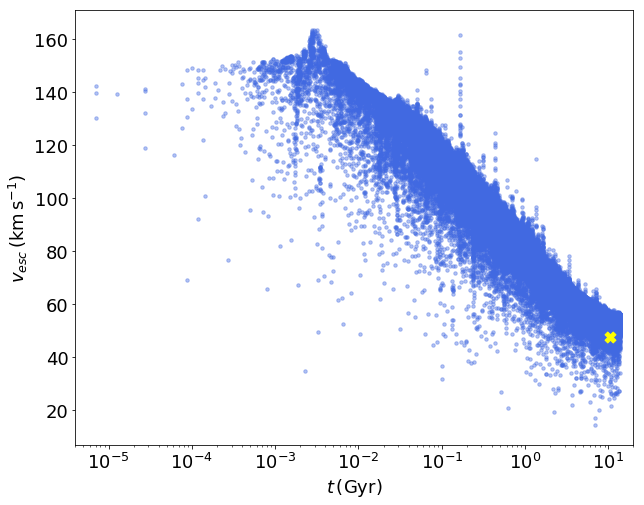

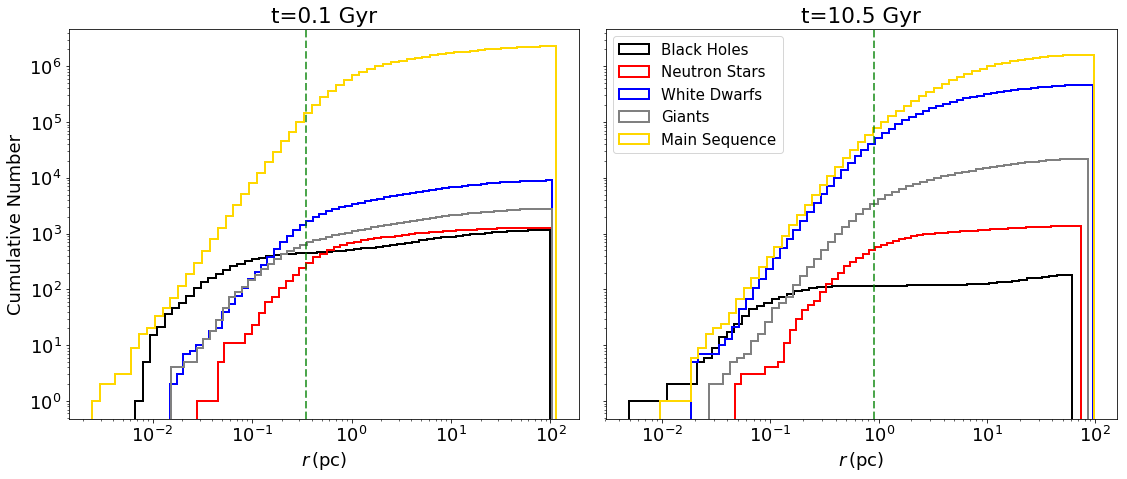

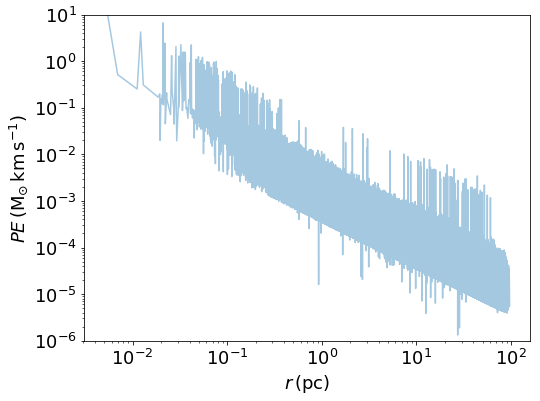

In [11]:
##Cumulative radius distribution of different star species
##Escape velocity as a function of time
##Potential as a funciton of r
import scripts, scripts1, scripts2, scripts3

path = '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/'
t_conv = dyn.conv('t', path+'initial.conv.sh')
l_conv = dyn.conv('l', path+'initial.conv.sh')
m_conv = dyn.conv('m', path+'initial.conv.sh')
##########################################################
v_esc = []; t = []
v_esc_bh = []; t_bh = []
f=open(path+'initial.binint.log','r')
#print 'inputfile %s' %(filename)
positions=scripts3.find_positions(f)
for i in range(0, len(positions)-1):
    #print positions[i]
    binint=scripts3.read_segment(f,positions[i])
    v_esc.append(binint['status']['v_esc_cluster[km/s]'])
    t.append(binint['type']['time']*t_conv/1000.)

    
print(np.max(t))
plt.figure(figsize=(10,8))
plt.scatter(t, v_esc, s = 12, alpha=0.4, color = 'royalblue', rasterized = True) #edgecolors = 'lightcoral', facecolor = 'none
plt.scatter(10.5, 47.5, marker = 'X', s = 120, c = 'yellow')
#binx = np.logspace(np.log10(min(t)), np.log10(max(t)), 100)
#biny = np.linspace(min(v_esc), max(v_esc), 100)
#counts, _, _ = np.histogram2d(t, v_esc, bins=(binx, biny))
#plt.pcolormesh(binx, biny, counts.T, cmap = 'jet')
plt.xlim(4e-6, 20.)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$t\,$(Gyr)')
plt.ylabel(r'$v_{esc}\,(\rm{km\,s^{-1}})$')
#fig.tight_layout()

#plt.savefig('/projects/b1095/syr904/projects/massive_clusters/v_esc-t.pdf', dpi = 300)
plt.savefig('/projects/b1095/syr904/projects/massive_clusters/v_esc-t_cmccosmicver1_updated.pdf', dpi = 100)


##########################################################
r_BH = []; r_NS = []; r_WD = []; r_G = []; r_MS = []
r_BH0 = []; r_NS0 = []; r_WD0 = []; r_G0 = []; r_MS0 = []

M_tot = []; r_tot = []
M_tot0 = []; r_tot0 = []

##For cmc 3.2
#with gzip.open(path+'initial.snap0507.dat.gz', 'r') as fsnap:
#    next(fsnap); next(fsnap)
#    for line in fsnap:
#        data = line.split()
#        M_tot.append(float(data[1]))
#        r_tot.append(float(data[2])*l_conv)
#        
#        if int(data[7]) != 1:
#            if int(data[14]) == 14:
#                r_BH.append(float(data[2])*l_conv)
#            elif int(data[14]) == 13:
#                r_NS.append(float(data[2])*l_conv)
#            elif 10<=int(data[14])<=12:
#                r_WD.append(float(data[2])*l_conv)
#            elif 2<=int(data[14])<=9:
#                r_G.append(float(data[2])*l_conv)
#            else:
#                r_MS.append(float(data[2])*l_conv)
#        else:
#            if int(data[17]) == 14:
#                r_BH.append(float(data[2])*l_conv)
#            elif int(data[17]) == 13:
#                r_NS.append(float(data[2])*l_conv)
#            elif 10<=int(data[17])<=12:
#                r_WD.append(float(data[2])*l_conv)
#            elif 2<=int(data[17])<=9:
#                r_G.append(float(data[2])*l_conv)
#            else:
#                r_MS.append(float(data[2])*l_conv)
#                
#            if int(data[18]) == 14:
#                r_BH.append(float(data[2])*l_conv)
#            elif int(data[18]) == 13:
#                r_NS.append(float(data[2])*l_conv)
#            elif 10<=int(data[18])<=12:
#                r_WD.append(float(data[2])*l_conv)
#            elif 2<=int(data[18])<=9:
#                r_G.append(float(data[2])*l_conv)
#            else:
#                r_MS.append(float(data[2])*l_conv)
#   
#
#with gzip.open(path+'initial.snap0029.dat.gz', 'r') as fsnap:
#    next(fsnap); next(fsnap)
#    for line in fsnap:
#        data = line.split()
#        M_tot0.append(float(data[1]))
#        r_tot0.append(float(data[2])*l_conv)
#        
#        if int(data[7]) != 1:
#            if int(data[14]) == 14:
#                r_BH0.append(float(data[2])*l_conv)
#            elif int(data[14]) == 13:
#                r_NS0.append(float(data[2])*l_conv)
#            elif 10<=int(data[14])<=12:
#                r_WD0.append(float(data[2])*l_conv)
#            elif 2<=int(data[14])<=9:
#                r_G0.append(float(data[2])*l_conv)
#            else:
#                r_MS0.append(float(data[2])*l_conv)
#        else:
#            if int(data[17]) == 14:
#                r_BH0.append(float(data[2])*l_conv)
#            elif int(data[17]) == 13:
#                r_NS0.append(float(data[2])*l_conv)
#            elif 10<=int(data[17])<=12:
#                r_WD0.append(float(data[2])*l_conv)
#            elif 2<=int(data[17])<=9:
#                r_G0.append(float(data[2])*l_conv)
#            else:
#                r_MS0.append(float(data[2])*l_conv)
#                
#            if int(data[18]) == 14:
#                r_BH0.append(float(data[2])*l_conv)
#            elif int(data[18]) == 13:
#                r_NS0.append(float(data[2])*l_conv)
#            elif 10<=int(data[18])<=12:
#                r_WD0.append(float(data[2])*l_conv)
#            elif 2<=int(data[18])<=9:
#                r_G0.append(float(data[2])*l_conv)
#            else:
#                r_MS0.append(float(data[2])*l_conv)


##For CMC-COSMIC ver 1.0.0
sys.path.insert(1, '/projects/b1095/syr904/MyCodes/cmctoolkit')
import cmctoolkit as cmct
    
snap_h5 = cmct.Snapshot(fname=path+'initial.snapshots.h5', snapshot_name='/733(t=0.47867046)', 
                     conv=path+'initial.conv.sh', 
                     dist=4.52, # distance to cluster in kpc
                     z=0.0038)
r_tot = np.array(snap_h5.data['r']*l_conv)
M_tot = np.array(snap_h5.data['m_MSUN'])
binflag = np.array(snap_h5.data['binflag'])

ksin = np.array(snap_h5.data['startype'])
kbin0 = np.array(snap_h5.data['bin_startype0']); kbin1 = np.array(snap_h5.data['bin_startype1'])

for kk in range(len(r_tot)):
    if binflag[kk] != 1:
        if ksin[kk] == 14:
            r_BH.append(r_tot[kk])
        elif ksin[kk] == 13:
            r_NS.append(r_tot[kk])
        elif 10<=ksin[kk]<=12:
            r_WD.append(r_tot[kk])
        elif 2<=ksin[kk]<=9:
            r_G.append(r_tot[kk])
        else:
            r_MS.append(r_tot[kk])
    else:
        if kbin0[kk] == 14:
            r_BH.append(r_tot[kk])
        elif kbin0[kk] == 13:
            r_NS.append(r_tot[kk])
        elif 10<=kbin0[kk]<=12:
            r_WD.append(r_tot[kk])
        elif 2<=kbin0[kk]<=9:
            r_G.append(r_tot[kk])
        else:
            r_MS.append(r_tot[kk])
            
        if kbin1[kk] == 14:
            r_BH.append(r_tot[kk])
        elif kbin1[kk] == 13:
            r_NS.append(r_tot[kk])
        elif 10<=kbin1[kk]<=12:
            r_WD.append(r_tot[kk])
        elif 2<=kbin1[kk]<=9:
            r_G.append(r_tot[kk])
        else:
            r_MS.append(r_tot[kk])
            
            
snap_h50 = cmct.Snapshot(fname=path+'initial.snapshots.h5', snapshot_name='/31(t=0.0045767186)', 
                     conv=path+'initial.conv.sh', 
                     dist=4.52, # distance to cluster in kpc
                     z=0.0038)
r_tot0 = np.array(snap_h50.data['r']*l_conv)
M_tot0 = np.array(snap_h50.data['m_MSUN'])
binflag0 = np.array(snap_h50.data['binflag'])

ksin0 = np.array(snap_h50.data['startype'])
kbin00 = np.array(snap_h50.data['bin_startype0']); kbin10 = np.array(snap_h50.data['bin_startype1'])

for kk in range(len(r_tot0)):
    if binflag0[kk] != 1:
        if ksin0[kk] == 14:
            r_BH0.append(r_tot0[kk])
        elif ksin0[kk] == 13:
            r_NS0.append(r_tot0[kk])
        elif 10<=ksin0[kk]<=12:
            r_WD0.append(r_tot0[kk])
        elif 2<=ksin0[kk]<=9:
            r_G0.append(r_tot0[kk])
        else:
            r_MS0.append(r_tot0[kk])
    else:
        if kbin00[kk] == 14:
            r_BH0.append(r_tot0[kk])
        elif kbin00[kk] == 13:
            r_NS0.append(r_tot0[kk])
        elif 10<=kbin00[kk]<=12:
            r_WD0.append(r_tot0[kk])
        elif 2<=kbin00[kk]<=9:
            r_G0.append(r_tot0[kk])
        else:
            r_MS0.append(r_tot0[kk])
            
        if kbin10[kk] == 14:
            r_BH0.append(r_tot0[kk])
        elif kbin10[kk] == 13:
            r_NS0.append(r_tot0[kk])
        elif 10<=kbin10[kk]<=12:
            r_WD0.append(r_tot0[kk])
        elif 2<=kbin10[kk]<=9:
            r_G0.append(r_tot0[kk])
        else:
            r_MS0.append(r_tot0[kk])
#########################################


pe_tot = Gconst_sun*np.array(M_tot)/np.array(r_tot)
pe_tot0 = Gconst_sun*np.array(M_tot0)/np.array(r_tot0)
                
fig,axs = plt.subplots(ncols = 2, sharey = True, figsize = (16, 7))
axs[1].hist(r_BH, bins = np.logspace(np.log10(min(r_BH)), np.log10(max(r_BH)), 60), color = 'k',
            cumulative = True, density = False, histtype = 'step', lw = 2., label = 'Black Holes')
axs[1].hist(r_NS, bins = np.logspace(np.log10(min(r_NS)), np.log10(max(r_NS)), 60), color = 'r',
            cumulative = True, density = False, histtype = 'step', lw = 2., label = 'Neutron Stars')
axs[1].hist(r_WD, bins = np.logspace(np.log10(min(r_WD)), np.log10(max(r_WD)), 60), color = 'b',
            cumulative = True, density = False, histtype = 'step', lw = 2., label = 'White Dwarfs')
axs[1].hist(r_G, bins = np.logspace(np.log10(min(r_G)), np.log10(max(r_G)), 60), color = 'gray',
            cumulative = True, density = False, histtype = 'step', lw = 2., label = 'Giants')
axs[1].hist(r_MS, bins = np.logspace(np.log10(min(r_MS)), np.log10(max(r_MS)), 60), color = 'gold',
            cumulative = True, density = False, histtype = 'step', lw = 2., label = 'Main Sequence')

axs[0].hist(r_BH0, bins = np.logspace(np.log10(min(r_BH0)), np.log10(max(r_BH0)), 60), color = 'k',
            cumulative = True, density = False, histtype = 'step', lw = 2., label = 'Black Holes')
axs[0].hist(r_NS0, bins = np.logspace(np.log10(min(r_NS0)), np.log10(max(r_NS0)), 60), color = 'r',
            cumulative = True, density = False, histtype = 'step', lw = 2., label = 'Neutron Stars')
axs[0].hist(r_WD0, bins = np.logspace(np.log10(min(r_WD0)), np.log10(max(r_WD0)), 60), color = 'b',
            cumulative = True, density = False, histtype = 'step', lw = 2., label = 'White Dwarfs')
axs[0].hist(r_G0, bins = np.logspace(np.log10(min(r_G0)), np.log10(max(r_G0)), 60), color = 'gray',
            cumulative = True, density = False, histtype = 'step', lw = 2., label = 'Giants')
axs[0].hist(r_MS0, bins = np.logspace(np.log10(min(r_MS0)), np.log10(max(r_MS0)), 60), color = 'gold',
            cumulative = True, density = False, histtype = 'step', lw = 2., label = 'Main Sequence')

axs[1].axvline(x = 0.90, ls = '--', color = 'g', lw = 2, alpha = 0.7)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'$r\,$(pc)')
axs[1].set_title('t=10.5 Gyr')
axs[1].legend(loc = 'upper left', fontsize = 15)

axs[0].axvline(x = 0.35, ls = '--', color = 'g', lw = 2, alpha = 0.7)
axs[0].set_ylabel('Cumulative Number')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel(r'$r\,$(pc)')
axs[0].set_title('t=0.1 Gyr')


fig.tight_layout()
#plt.savefig('/projects/b1095/syr904/projects/massive_clusters/star_radius.pdf', dpi = 300)
plt.savefig('/projects/b1095/syr904/projects/massive_clusters/star_radius_cmccosmicver1_updated.pdf', dpi = 300)


#################################################################
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


plt.figure(figsize=(8,6))
plt.plot(r_tot, pe_tot, alpha = 0.4)
#plt.plot(r_tot0, pe_tot0, alpha=0.4)
#plt.plot(ma_r, ma_pe, alpha = 0.4)
#plt.plot(ma_r0, ma_pe0, alpha=0.4)
#plt.plot(r_tot, smooth(pe_tot, 5), alpha = 0.4)
#plt.plot(r_tot0, smooth(pe_tot0, 60), alpha=0.4)

plt.xscale('log')
plt.yscale('log')
#plt.xlim(xmin = 0.001)
plt.ylim(ymin = 0.000001, ymax = 10)
plt.xlabel(r'$r\,$(pc)')
plt.ylabel(r'$PE\,(\rm{M_{\odot}\,km\,s^{-1}})$')

In [26]:
##Finding eclipsing binaries in the cluster
path = '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/'
sys.path.insert(1, '/projects/b1095/syr904/MyCodes/cmctoolkit_oldsnap')

#path = '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon_fb10/'
#sys.path.insert(1, '/projects/b1095/syr904/MyCodes/cmctoolkit')

import cmctoolkit as cmct

t_obs = 8.29; t_det = 2*t_obs  ##in days
def eclipsing_binary(a_au, ecc, r0, r1, m0, m1, k0, k1):
    ecl_flag = []
    period = uc.au_to_period(a_au, m0, m1)
    
    theta = np.random.uniform(low=0., high=2.*np.pi, size=len(r0))
            
    a_rsun = a_au*AU_Rsun*(1-ecc)  ##use the minimum separation
    
    for xx in range(len(period)):
        if theta[xx] < (1./2.)*np.pi:
            beta = (1./2.)*np.pi - theta[xx]
        elif (1./2.)*np.pi <= theta[xx] < np.pi:
            beta = theta[xx] - np.pi/2.
        elif np.pi <= theta[xx] < (3./2.)*np.pi:
            beta = (3./2.)*np.pi - theta[xx]
        else:
            beta = theta[xx] - (3./2.)*np.pi
        
        if period[xx] > t_det or k0[xx] >=10 or k1[xx]>=10:
            ecl_flag.append(0)
        
        else:
            if r0[xx] > r1[xx]:
                l0 = a_rsun[xx] - r1[xx]/np.sin(beta)
                r_cut = l0 * np.sin(beta)
                
                if r_cut <= 0:
                    r_cov = 0
                elif r_cut >= r0[xx]:
                    r_cov = 0
                elif r0[xx]-r_cut > 2*r1[xx]:
                    r_cov = 2*r1[xx]
                else:
                    r_cov = r0[xx]-r_cut

                cov_ratio = r_cov/r0[xx]
                    
            else:
                l1 = a_rsun[xx] - r0[xx]/np.sin(beta)
                r_cut = l1 * np.sin(beta)
                
                if r_cut <= 0:
                    r_cov = 0
                elif r_cut >= r1[xx]:
                    r_cov = 0
                elif r1[xx]-r_cut > 2*r0[xx]:
                    r_cov = 2*r0[xx]
                else:
                    r_cov = r1[xx]-r_cut

                cov_ratio = r_cov/r1[xx]
            
            if cov_ratio >= 0.2:
                ecl_flag.append(1)
            else:
                ecl_flag.append(0)
                
    #print(period)
                
    return period, ecl_flag
    
    
def dect_prob(r0, r1, m0, m1, a_au):
    zeta = 0.9
    period = uc.au_to_period(a_au, m0, m1)
    
    mtot = m0+m1
    
    dp = []
    for xx in range(len(r0)):
        if r0[xx] > r1[xx]:
            dp.append((zeta*r0[xx]+r1[xx])/(4.21*mtot[xx]**(1/3)*period[xx]**(2/3))*max(0., min(1., 2*t_obs/period[xx]-1.)))
        else:
            dp.append((zeta*r1[xx]+r0[xx])/(4.21*mtot[xx]**(1/3)*period[xx]**(2/3))*max(0., min(1., 2*t_obs/period[xx]-1.)))

    return dp
    

#id0_bin = []; id1_bin = []; k0_bin = []; k1_bin = []
#m0_bin = []; m1_bin = []; r0_bin = []; r1_bin = []
#sma_bin = []; ecc_bin = []
#
#with gzip.open(path+'initial.snap0507.dat.gz', 'r') as fsnap:
#    next(fsnap); next(fsnap)
#    for line in fsnap:
#        data = line.split()
#        if int(data[7])==1:
#            id0_bin.append(int(data[10])); id1_bin.append(int(data[11]))
#            k0_bin.append(int(data[17])); k1_bin.append(int(data[18]))
#            m0_bin.append(float(data[8])); m1_bin.append(float(data[9]))
#            r0_bin.append(float(data[21])); r1_bin.append(float(data[22]))
#            sma_bin.append(float(data[12])); ecc_bin.append(float(data[13]))
#            

###################CMC-COSMIC################################
#snap_446 = cmct.Snapshot(fname=path+'initial.snapshots.h5', snapshot_name='/446(t=0.58030745)', 
#                         conv=path+'initial.conv.sh', 
#                         dist=4.52, # distance to cluster in kpc
#                         z=0.0038)
#

#binflag = snap.data['binflag']
#m0 = snap.data['m0_MSUN']; m1 = snap.data['m1_MSUN']
#r0 = snap.data['bin_star_radius0_RSUN']; r1 = snap.data['bin_star_radius1_RSUN']
#k0 = snap.data['bin_startype0']; k1 = snap.data['bin_startype1']
#sma = snap.data['a_AU']; ecc = snap.data['e']
#id0 = snap.data['id0']; id1 = snap.data['id1']

##################cmc-3.2####################################
snap = cmct.Snapshot(fname=path+'initial.snap0507.dat.gz',
                         conv=path+'initial.conv.sh', 
                         dist=4.52, # distance to cluster in kpc
                         z=0.0038)

binflag = snap.data['binflag']
m0 = snap.data['m0[MSUN]']; m1 = snap.data['m1[MSUN]']
r0 = snap.data['bin_star_radius0[RSUN]']; r1 = snap.data['bin_star_radius1[RSUN]']
k0 = snap.data['bin_startype0']; k1 = snap.data['bin_startype1']
sma = snap.data['a[AU]']; ecc = snap.data['e']
id0 = snap.data['id0']; id1 = snap.data['id1']

print('read data')

snap.add_photometry('/projects/b1095/syr904/MyCodes/cmctoolkit_oldsnap/filt_index.txt')
print('add photometry')

sin_obsmag = snap.data['obsMag_V']
bin_obsmag0 = snap.data['bin_obsMag0_V']; bin_obsmag1 = snap.data['bin_obsMag1_V']
tot_obsmag = snap.data['tot_obsMag_V']
#############################################################

id0_bin = list(id0[binflag == 1]); id1_bin = list(id1[binflag == 1])
sma_bin = list(sma[binflag == 1]); ecc_bin = list(ecc[binflag == 1])
m0_bin = list(m0[binflag == 1]); m1_bin = list(m1[binflag == 1])
k0_bin = list(k0[binflag == 1]); k1_bin = list(k1[binflag == 1])
r0_bin = list(r0[binflag == 1]); r1_bin = list(r1[binflag == 1])


#projfile = np.sort(glob(path+'SNAP446_*.2Dproj.dat.gz'))
projfile = np.sort(glob(path+'SNAP507_*.2Dproj.dat.gz'))
#print(projfile)

period_bin, eclipsing = eclipsing_binary(np.array(sma_bin), np.array(ecc_bin), np.array(r0_bin), np.array(r1_bin), 
                                 np.array(m0_bin), np.array(m1_bin), np.array(k0_bin), np.array(k1_bin))
detection_prob = dect_prob(np.array(r0_bin), np.array(r1_bin), np.array(m0_bin), np.array(m1_bin),
                              np.array(sma_bin))
print(np.sum(eclipsing), len(eclipsing))
    
eclips_bin = [[],[],[],[],[],[]]
n_eclips = []; n_all = []
n_all_brt = []; n_bin_brt = []; n_eclips_brt = []
for ii in range(len(projfile)):
    n_eclips.append(0); n_all.append(0)
    n_all_brt.append(0); n_bin_brt.append(0); n_eclips_brt.append(0)
    with gzip.open(projfile[ii], 'r') as fproj:
        next(fproj); next(fproj)
        for line in fproj:
            data = line.split()
            r2d = uc.pc2arcsec(4.52, float(data[0]))
            if r2d > 90: break
                
            id_index = id0_bin.index(int(float(data[13])))
            eclips_flag = eclipsing[id_index]
            detec_flag = detection_prob[id_index]
            Pday = period_bin[id_index]
            tot_obsmag_index = tot_obsmag[id_index]
            bin_obsmag0_index = bin_obsmag0[id_index]; bin_obsmag1_index = bin_obsmag1[id_index]
            sin_obsmag_index = sin_obsmag[id_index]
            
            if int(data[2]) == 1:
                if tot_obsmag_index >= 25:
                    n_all_brt[ii]+=1
                    n_bin_brt[ii]+=1
                #print(data)
                #if Pday < 4.:  #detec_flag < 0.1 or
                #    continue
                if eclips_flag == 1:
                    n_eclips[ii]+=1
                    eclips_bin[0].append(int(data[13])); eclips_bin[1].append(int(data[14]))
                    eclips_bin[2].append(int(data[5])); eclips_bin[3].append(int(data[6]))
                    eclips_bin[4].append(float(data[10])); eclips_bin[5].append(float(data[11]))
                    
                    if bin_obsmag0_index >= 25 and bin_obsmag1_index >= 25:
                        n_eclips_brt[ii]+=1
            else:
                n_all[ii]+=1
                if sin_obsmag_index >= 25:
                    n_all_brt[ii]+=1
                    
    #print(eclips_bin)
                                      
    print(ii)
                    
print(np.mean(n_eclips), np.mean(n_all))
print(np.mean(n_all_brt), np.mean(n_bin_brt), np.mean(n_eclips_brt))


read data
['U /projects/b1095/syr904/MyCodes/cmctoolkit_oldsnap/filterfunctions/Generic_Johnson.U.dat 3.67807e-9', 'B /projects/b1095/syr904/MyCodes/cmctoolkit_oldsnap/filterfunctions/Generic_Johnson.B.dat 6.29336e-9', 'V /projects/b1095/syr904/MyCodes/cmctoolkit_oldsnap/filterfunctions/Generic_Johnson.V.dat 3.57453e-9', 'R /projects/b1095/syr904/MyCodes/cmctoolkit_oldsnap/filterfunctions/Generic_Cousins.R.dat 2.24563e-9', 'I /projects/b1095/syr904/MyCodes/cmctoolkit_oldsnap/filterfunctions/Generic_Cousins.I.dat 1.20234e-9', '']
6
U
/projects/b1095/syr904/MyCodes/cmctoolkit_oldsnap/filterfunctions/Generic_Johnson.U.dat <class 'str'>
/projects/b1095/syr904/MyCodes/cmctoolkit_oldsnap/filterfunctions/Generic_Johnson.B.dat <class 'str'>
/projects/b1095/syr904/MyCodes/cmctoolkit_oldsnap/filterfunctions/Generic_Johnson.V.dat <class 'str'>
/projects/b1095/syr904/MyCodes/cmctoolkit_oldsnap/filterfunctions/Generic_Cousins.R.dat <class 'str'>
/projects/b1095/syr904/MyCodes/cmctoolkit_oldsnap/fil

ValueError: -100 is not in list

1916373 33438 8101 6669 5096
582417 11440 2425 1880 1360
data ready


/software/anaconda3.6/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


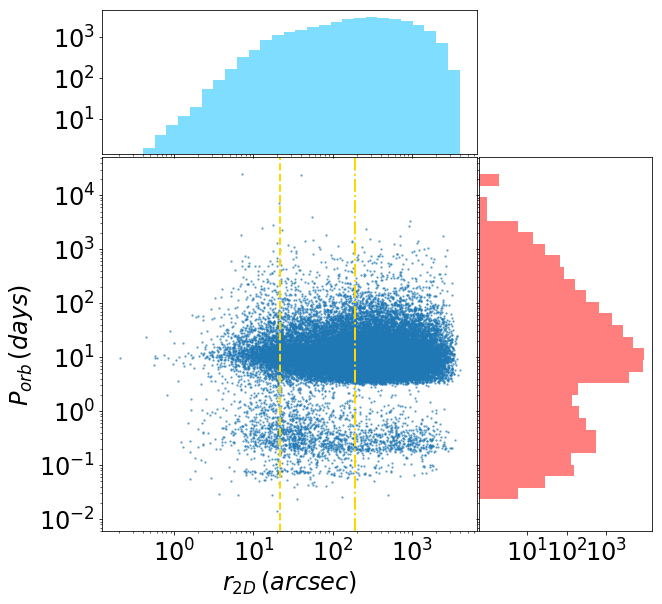

In [6]:
##Binary orbital periods and radius distribution plot

def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, s = 2, alpha=0.5)
    ax.axvline(x = 0.36*60, ls = '--', lw = 2., color = 'gold', label = 'Observed Core Radius')
    ax.axvline(x = 3.17*60, ls = '-.', lw = 2., color = 'gold', label = 'Observed Half-light Radius')

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    #bins = np.arange(-lim, lim + binwidth, binwidth)
    #print(bins)
    ax_histx.hist(x, bins=np.logspace(np.log10(np.min(x)), np.log10(np.max(x)), 30), 
                  log=True, alpha=0.5, color = 'deepskyblue')
    ax_histy.hist(y, bins=np.logspace(np.log10(np.min(y)), np.log10(np.max(y)), 30), orientation='horizontal',
                 log=True, alpha=0.5, color = 'red')
    
    #ax.set_xlim(xmin = 0.001, xmax = 1000.)
    #ax.set_ylim(ymin = 0.0005, )
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$r_{2D}\,(arcsec)$')
    ax.set_ylabel(r'$P_{orb}\,(days)$')
    #ax.legend(loc = 'upper left', fontsize = 15)
    
    ax_histx.set_yticks([10., 100., 1000.])
    ax_histy.set_xticks([10., 100., 1000.])
    
    fig.tight_layout()


path = '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/'
#path = '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon_fb10/'

snap_507 = path+'initial.snap0507.dat.gz'
snap_507proj = path+'SNAP507_17.2Dproj.dat.gz'

#sys.path.insert(1, '/projects/b1095/syr904/MyCodes/cmctoolkit')
#import cmctoolkit as cmct
#snap_446 = cmct.Snapshot(fname=path+'initial.snapshots.h5', snapshot_name='/446(t=0.58030745)', 
#                         conv=path+'initial.conv.sh', 
#                         dist=4.52, # distance to cluster in kpc
#                         z=0.0038)
#snap_446proj = path+'SNAP446_17.2Dproj.dat.gz'

l_conv = dyn.conv('l', path+'initial.conv.sh')


##############For model with cmc-cosmic3.2###########################
bin_orb = []; bin_ecc = []; bin_r = []; bin_id0 = []; bin_id1 = []; bin_m0 = []; bin_m1 = []
#n_bin_rcobs = [0,0,0,0]; n_bin_rhl = 0; n_bin_90arcsec = 0; n_bin_tot = 0
#n_ms_rcobs = 0; n_ms_rhl = 0; n_ms_90arcsec = 0; n_ms_tot = 0

with gzip.open(snap_507, 'r') as f507:
    next(f507); next(f507)
    for line in f507:
        data = line.split()
        if int(data[7])==1:
            bin_orb.append(float(data[12])); bin_ecc.append(float(data[13]))
            bin_r.append(float(data[2])*l_conv)
            bin_id0.append(int(data[10])); bin_id1.append(int(data[11]))
            bin_m0.append(float(data[8])); bin_m1.append(float(data[9]))
            

##############For model with CMC-COSMIC###########################
#binflag = snap_446.data['binflag']
#bin_orb = list(snap_446.data['a_AU'][binflag == 1]); bin_ecc = list(snap_446.data['e'][binflag == 1])
#bin_r = list(snap_446.data['r'][binflag == 1]*l_conv)
#bin_id0 = list(snap_446.data['id0'][binflag == 1]); bin_id1 = list(snap_446.data['id1'][binflag == 1])
#bin_m0 = list(snap_446.data['m0_MSUN'][binflag == 1]); bin_m1 = list(snap_446.data['m1_MSUN'][binflag == 1])

##################################################################

bin_rproj = []; bin_id0proj = []; bin_id1proj = []; bin_orbproj = []; bin_eccproj = []
bin_m0proj = []; bin_m1proj = []
nbin_q0d5 = 0; nbin_q0d6 = 0; nbin_q0d7 = 0
nbin_q0d5_brt = 0; nbin_q0d6_brt = 0; nbin_q0d7_brt = 0
nbin = 0; nall = 0
nbin_brt = 0; nall_brt = 0
m_cut = 0.5

with gzip.open(snap_507proj, 'r') as fproj:
    next(fproj); next(fproj)
    for line in fproj:
        data = line.split()
        if int(data[2]) == 1:
            nbin += 1
            if (float(data[10])>m_cut or float(data[11])>m_cut) and float(data[5])<10 and float(data[6])<10:
                nbin_brt+=1
            
            bin_rproj.append(float(data[0]))
            bin_id0proj.append(int(data[13])); bin_id1proj.append(int(data[14]))
            bin_m0proj.append(float(data[10])); bin_m1proj.append(float(data[11]))
            
            r_arcmin = uc.pc2arcsec(4.52, float(data[0]))/60.
            if float(data[10]) <= float(data[11]):
                q_frac = float(data[10])/float(data[11])
            else:
                q_frac = float(data[11])/float(data[10])
            if 0.36 <= r_arcmin <= 3.17:
                if q_frac > 0.5:
                    nbin_q0d5 += 1
                    if (float(data[10])>m_cut or float(data[11])>m_cut) and float(data[5])<10 and float(data[6])<10:
                        nbin_q0d5_brt+=1
                if q_frac > 0.6:
                    nbin_q0d6 += 1
                    if (float(data[10])>m_cut or float(data[11])>m_cut) and float(data[5])<10 and float(data[6])<10:
                        nbin_q0d6_brt+=1
                if q_frac> 0.7:
                    nbin_q0d7 += 1
                    if (float(data[10])>m_cut or float(data[11])>m_cut) and float(data[5])<10 and float(data[6])<10:
                        nbin_q0d7_brt+=1
        else:
            nall += 1
            if float(data[9])>m_cut and int(data[3]) < 10:
                nall_brt += 1
                
                
                
print(nall, nbin, nbin_q0d5, nbin_q0d6, nbin_q0d7)
print(nall_brt, nbin_brt, nbin_q0d5_brt, nbin_q0d6_brt, nbin_q0d7_brt)

for ii in range(len(bin_id0proj)):
    bin_index = bin_id0.index(bin_id0proj[ii])
    bin_orbproj.append(bin_orb[bin_index]); bin_eccproj.append(bin_ecc[bin_index])

bin_dayproj = list(uc.au_to_period(np.array(bin_orbproj), np.array(bin_m0proj), np.array(bin_m1proj)))
bin_rarcsec = list(uc.pc2arcsec(4.52, np.array(bin_rproj)))
#print(bin_dayproj, bin_orbproj)

print('data ready')


#######################################
##plotting
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.25]
rect_histy = [left + width + spacing, bottom, 0.3, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(bin_rarcsec, bin_dayproj, ax, ax_histx, ax_histy)

In [3]:
##Binary Fractions in models
#sys.path.insert(1, '/projects/b1095/syr904/MyCodes/cmctoolkit_oldsnap')
sys.path.insert(1, '/projects/b1095/syr904/MyCodes/cmctoolkit')
import cmctoolkit as cmct
from astropy.table import Table


#snap = cmct.Snapshot(fname='/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv3.5_3e6_tcon_fb10/initial.snapshots.h5', 
#                         snapshot_name='/449(t=0.5881136)', 
#                         conv='/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv3.5_3e6_tcon_fb10/initial.conv.sh', 
#                         dist=4.52, # distance to cluster in kpc
#                         z=0.0038)

snap = cmct.Snapshot(fname='/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/initial.snapshots.h5', 
                         snapshot_name='/733(t=0.47867046)', 
                         conv='/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/initial.conv.sh', 
                         dist=4.52, # distance to cluster in kpc
                         z=0.0038)
print('read snap')

snap.add_photometry('/projects/b1095/syr904/MyCodes/cmctoolkit_oldsnap/filt_index_HST.txt')

q_ratios = [0.5, 0.6, 0.7]
rc_arcmin = 0.36; rh_arcmin = 3.17
rc_pc = uc.arcsec2pc(4.52, rc_arcmin*60); rh_pc = uc.arcsec2pc(4.52, rh_arcmin*60)

# Find turn-off mass
mto = cmct.find_MS_TO(snap.age, snap.z)
print(mto)

#good = np.where((snap.data['m[MSUN]'] < mto) & (snap.data['binflag'] != 1) & np.in1d(snap.data['startype'], [0, 1]))
good = np.where((snap.data['m_MSUN'] < mto) & (snap.data['binflag'] != 1) & np.in1d(snap.data['startype'], [0, 1]))
ms_singles = snap.data.loc[good]
#ms_singles = ms_singles.sort_values('m[MSUN]')
turnoff_mag = np.min(ms_singles['tot_obsMag_sF814W'])#np.array(ms_singles['tot_obsMag_sF814W'])[-1]
#turnoff_mag = np.min(ms_singles['tot_obsMag_sF606W'])
print(turnoff_mag)

r_100 = uc.arcsec2pc(4.52, 100)
binfrac, e_binfrac = snap.binary_fraction_photometric(filttable='/projects/b1095/syr904/MyCodes/cmctoolkit_oldsnap/filt_index_HST.txt', 
                                            mag_filter='sF814W', 
                                            blue_filter='sF606W', red_filter='sF814W',
                                            dmin=rc_pc, dmax=rh_pc,
                                            fluxdict={'sF814W': [turnoff_mag+3.75, turnoff_mag+0.75]},
                                            min_q=0.7,
                                            max_q= None)

print(binfrac, e_binfrac)

# Calculate and write binary fraction
single_bool = np.in1d(snap.data['startype'], [0, 1])
#M = np.geomspace(np.min(snap.data.loc[single_bool, 'm[MSUN]']), cmct.find_MS_TO(snap.age, snap.z), 1000)
M = np.geomspace(np.min(snap.data.loc[single_bool, 'm_MSUN']), cmct.find_MS_TO(snap.age, snap.z), 1000)
fdict = cmct.SSE_MS_get_flux(M, snap.z, snap.age, '/projects/b1095/syr904/MyCodes/cmctoolkit_oldsnap/filt_index_HST.txt')
mag_arr = fdict['sF814W']
blue_arr = fdict['sF606W']
red_arr = fdict['sF814W']

# Turn-off is just the bluest point on the model isochrone
turnoff_color = np.min(blue_arr - red_arr)
turnoff_mag = mag_arr[blue_arr-red_arr == turnoff_color][0]
print(turnoff_mag)
        

binfrac, e_binfrac = snap.binary_fraction_photometric('/projects/b1095/syr904/MyCodes/cmctoolkit_oldsnap/filt_index_HST.txt',
                                                 mag_filter='sF814W',#'sF814W',
                                                 blue_filter='sF606W',
                                                 red_filter='sF814W',
                                                 min_q=0.7,
                                                 max_q=None,
                                                 dmin=rc_pc,
                                                 dmax=rh_pc,
                                                 primary_flux_faint=turnoff_mag+3.75,#turnoff_mag+3.75,
                                                 primary_flux_brite=turnoff_mag+0.75,#turnoff_mag+0.75,
                                                 color_pad=0.1)

print(binfrac, e_binfrac)

read snap
0.9114292733327816
16.236193221365312
0.007192342725716613 0.00019444131787565449
3.3987475021246745


/projects/b1095/syr904/MyCodes/cmctoolkit/cmctoolkit.py:617: RuntimeWarning: overflow encountered in exp
  planck = 2 * h * c ** 2 / (wavelength_cm.reshape((1, wavelength_cm.size)) ** 5 * (np.exp(h * c / (k * np.outer(Teff_K, wavelength_cm))) - 1))
/projects/b1095/syr904/MyCodes/cmctoolkit/cmctoolkit.py:627: RuntimeWarning: divide by zero encountered in log10
  mag_arr = -2.5 * np.log10(spectral_lum / zp_spectralflux[ii])


0.00631675393629503 0.00017806488422691637


69013.12197696518
[     1      0      0      0      0      1      0      1      2      1
      1      1      1      5      0      2      3     10     23     25
  41704  50356  55625  60770  66542  72942  79846  87966  96792 105518
 116466 127583 342047 294214 222927 159967  11751   8039   1582     66
     13      0      0      0      0      0      0      9     11     24
     14     10     20     25     37      1      4      2      2] [3.73738359e-03 4.37046806e-03 5.11079224e-03 5.97652173e-03
 6.98889923e-03 8.17276582e-03 9.55717043e-03 1.11760827e-02
 1.30692264e-02 1.52830544e-02 1.78718880e-02 2.08992505e-02
 2.44394252e-02 2.85792786e-02 3.34203919e-02 3.90815531e-02
 4.57016722e-02 5.34431892e-02 6.24960606e-02 7.30824198e-02
 8.54620280e-02 9.99386482e-02 1.16867498e-01 1.36663967e-01
 1.59813808e-01 1.86885056e-01 2.18541968e-01 2.55561322e-01
 2.98851474e-01 3.49474650e-01 4.08673008e-01 4.77899120e-01
 5.58851610e-01 6.53516839e-01 7.64217641e-01 8.93670320e-01
 1.04505130e+

/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in log10
/software/anaconda3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:2445: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


0.003273275668387599
-0.4083820988924393 6.101329764723505 -0.9998872624498019 7.066326104084813e-16 0.002168241843095278
-2.6342882709671787 5.948759355579133 -0.9950503440072805 0.004949655992719458 0.1860234454109098
nan nan nan nan nan


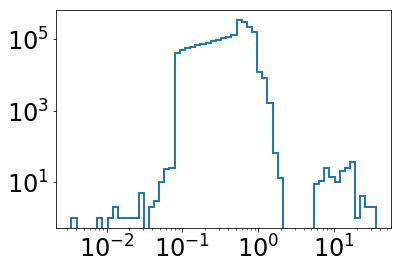

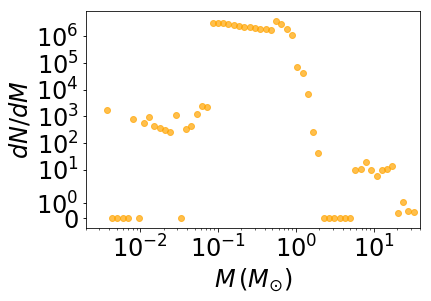

In [6]:
##Mass function of the model
sys.path.insert(1, '/projects/b1095/syr904/MyCodes/cmctoolkit')
import cmctoolkit as cmct
from scipy.stats import linregress

l_conv = dyn.conv('l', path+'initial.conv.sh')

snap_h5 = cmct.Snapshot(fname=path+'initial.snapshots.h5', snapshot_name='/726(t=0.46262262)', 
                     conv=path+'initial.conv.sh', 
                     dist=4.52, # distance to cluster in kpc
                     z=0.0038)

M_tot = np.array(snap_h5.data['m_MSUN'])
M0 = snap_h5.data['m0_MSUN']; M1 = snap_h5.data['m1_MSUN']
binflag = np.array(snap_h5.data['binflag'])
kstar = snap_h5.data['startype']
r = np.array(snap_h5.data['r'])*l_conv
print(np.sum(M_tot[r <= 0.9]))

Msin = M_tot[binflag != 1]

N_m, M_edge = np.histogram(Msin, 
                          bins = np.logspace(np.log10(min(Msin)), np.log10(max(Msin)), 60))

M_bin = []; M_interval = []
for ii in range(len(M_edge)-1):
    M_bin.append((M_edge[ii]+M_edge[ii+1])/2.)
    M_interval.append(M_edge[ii+1]-M_edge[ii])
    
#print(N_m, M_bin)
N_m = np.array(N_m); M_bin = np.array(M_bin); M_interval = np.array(M_interval)
print(N_m, M_bin, M_interval)
    
##0.2-0.8 Msun
M_temp1 = M_bin[M_bin >= 0.2]
M_1 = M_temp1[M_temp1 <= 0.8]
N_temp1 = N_m[M_bin >= 0.2]
N_1 = N_temp1[M_temp1 <= 0.8]
M_difftemp1 = M_interval[M_bin >= 0.2]
M_diff1 = M_difftemp1[M_temp1 <= 0.8]

result1 = linregress(np.log10(M_1), np.log10(N_1/M_diff1))
print(result1.slope, result1.intercept, result1.rvalue, result1.pvalue, result1.stderr)

##0.2-0.8 Msun main-sequence and giant stars
M_1 = []; N_1 = []; M_diff1 = []
for kk in range(len(N_m)):
    if 0.2<=M_bin[kk]<=0.7 and kstar[kk] < 10:
        M_1.append(M_bin[kk]); N_1.append(N_m[kk]); M_diff1.append(M_interval[kk])

N_1 = np.array(N_1); M_1 = np.array(M_1); M_diff1 = np.array(M_diff1)
print(N_1, M_1)
result1 = linregress(np.log10(M_1), np.log10(N_1/M_diff1))
print(result1.slope, result1.intercept, result1.rvalue, result1.pvalue, result1.stderr)


##0.1-0.5 Msun
M_temp1 = M_bin[M_bin >= 0.1]
M_1 = M_temp1[M_temp1 <= 0.5]
N_temp1 = N_m[M_bin >= 0.1]
N_1 = N_temp1[M_temp1 <= 0.5]
M_difftemp1 = M_interval[M_bin >= 0.1]
M_diff1 = M_difftemp1[M_temp1 <= 0.5]

result1 = linregress(np.log10(M_1), np.log10(N_1/M_diff1))
print(result1.slope, result1.intercept, result1.rvalue, result1.pvalue, result1.stderr)

##0.5-1. Msun
M_temp1 = M_bin[M_bin >= 0.5]
M_1 = M_temp1[M_temp1 <= 1.]
N_temp1 = N_m[M_bin >= 0.5]
N_1 = N_temp1[M_temp1 <= 1.]
M_difftemp1 = M_interval[M_bin >= 0.5]
M_diff1 = M_difftemp1[M_temp1 <= 1.]

result1 = linregress(np.log10(M_1), np.log10(N_1/M_diff1))
print(result1.slope, result1.intercept, result1.rvalue, result1.pvalue, result1.stderr)

##>1 Msun
M_1 = M_bin[M_bin >= 1.]
N_1 = N_m[M_bin >= 1.]
M_diff1 = M_interval[M_bin >= 1.]

result1 = linregress(np.log10(M_1), np.log10(N_1/M_diff1))
print(result1.slope, result1.intercept, result1.rvalue, result1.pvalue, result1.stderr)


plt.figure()
plt.hist(Msin, bins = np.logspace(np.log10(min(Msin)), np.log10(max(Msin)), 60), histtype = 'step', lw = 2)
plt.xscale('log')
plt.yscale('log')


plt.figure()
plt.scatter(M_bin, N_m/M_interval, color = 'orange', alpha = 0.7)
plt.xlabel(r'$M\,(M_{\odot})$')
plt.ylabel(r'$dN/dM$')
plt.xlim(0.002, 40)
plt.xscale('log')
plt.yscale('symlog')

In [11]:
##Finding 47 Tuc best-fit models in the CMC Catalog
##Nicholas plotting code /projects/b1095/nrui/47tuc

from astropy.table import Table, Column
from scipy.interpolate import interp1d
import pdb
import os

E_BV = 0#0.04 # Harris 1996, 2010 edition
dist = 4.52 # Baumgardt et al. 2019, kpc
Av = 3.1 * E_BV # Cardelli 1989

# Pull all snapshots to be searched
sbp_files = glob('/projects/b1095/nrui/marchmatch/new_fluxes/sandbox/rv*/rg8/z.002/*/sbp_*.dat')
vdp_files = [sbp_files[ii].replace('sbp', 'vdp') for ii in range(len(sbp_files))]
param_files = [sbp_files[ii].replace('sbp', 'param') for ii in range(len(sbp_files))]

# Read data SBP, VDP
# SBP uncertainty calculation follows that of McLaughlin & van der Marel 2005,
# and we remove points with infinite uncertainty ("goodness" 0)

r2d_all = list(r_wk) + list(r_bg) + list(r_hy) + list(r_bg_rv) + list(r_ka)
vel_all = list(sigma_wk_kms) + list(sigma_bg) + list(sigma_hy_kms) + list(sigma_bg_rv) + list(sigma_ka)
vel_err_all_up = list(sigma_wk_err_kms) + list(del_sigmau_bg) + list(sigma_hy_err_kms[0]) + list(del_sigmau_bg_rv) + list(sigma_ka_plus)
vel_err_all_down = list(sigma_wk_err_kms) + list(del_sigmad_bg) + list(sigma_hy_err_kms[1]) + list(del_sigmad_bg_rv) + list(sigma_ka_minus)

# for consistency with existing format, need everything back in arcsec and other ngular units
r_col = Column(r2d_all, name='r[ARCSEC]')
eu_r_col = Column(np.zeros(len(r2d_all)), name='eu_r[ARCSEC]')
el_r_col = Column(np.zeros(len(r2d_all)), name='el_r[ARCSEC]')

sig_col = Column(vel_all, name='sig[KM/S]')
eu_sig_col = Column(vel_err_all_up, name='eu_sig[KM/S]')
el_sig_col = Column(vel_err_all_down, name='el_sig[KM/S]')

obs_sbp = Table.read('makeSBP/sbp_trager1995/trager1995_ngc104.fits')
obs_vdp = Table([r_col, eu_r_col, el_r_col, sig_col, eu_sig_col, el_sig_col])

obs_sbp = obs_sbp[~np.isnan(obs_sbp['e_s[MAG/ARCSEC2]'])]

# Calculate normalized chi square on all files
sbp_rchisq_list = np.array([])
vdp_rchisq_list = np.array([])

for ii in range(len(sbp_files)):
    if os.path.exists(vdp_files[ii]):
        sbp_ii = Table.read(sbp_files[ii], format='ascii')
        vdp_ii = Table.read(vdp_files[ii], format='ascii')

        # Convert quantities to proper distances
        sbp_r = sbp_ii['col1'] * 0.01 / dist
        vdp_r = vdp_ii['col1'] * 206265 / (1e3 * dist)

        # Interpolate SBP and VDP to calculate chisq
        sbp_interp = interp1d(sbp_r, Av + sbp_ii['col2'], bounds_error=False, fill_value=(sbp_ii['col2'][0], 0))
        vdp_interp = interp1d(vdp_r, vdp_ii['col2'], bounds_error=False, fill_value=(vdp_ii['col2'][0], 0))

        sbp_chisq = np.sum((obs_sbp['s[MAG/ARCSEC2]'] - sbp_interp(obs_sbp['r[ARCSEC]'])) ** 2 / obs_sbp['e_s[MAG/ARCSEC2]'] ** 2)

        data_above = np.where(obs_vdp['sig[KM/S]'] > vdp_interp(obs_vdp['r[ARCSEC]'])) # treat upper and lower error bars differently
        data_below = np.where(obs_vdp['sig[KM/S]'] < vdp_interp(obs_vdp['r[ARCSEC]']))
        vdp_chisq1 = np.sum((obs_vdp['sig[KM/S]'][data_above] - vdp_interp(obs_vdp['r[ARCSEC]'][data_above])) ** 2 / obs_vdp['el_sig[KM/S]'][data_above] ** 2)
        vdp_chisq2 = np.sum((obs_vdp['sig[KM/S]'][data_below] - vdp_interp(obs_vdp['r[ARCSEC]'][data_below])) ** 2 / obs_vdp['eu_sig[KM/S]'][data_below] ** 2)

        sbp_rchisq = sbp_chisq / len(obs_sbp)
        vdp_rchisq = (vdp_chisq1 + vdp_chisq2) / len(obs_vdp)
        
        sbp_rchisq_list = np.append(sbp_rchisq_list, sbp_rchisq)
        vdp_rchisq_list = np.append(vdp_rchisq_list, vdp_rchisq)
    else:
        sbp_rchisq_list = np.append(sbp_rchisq_list, np.nan) # if no VDP
        vdp_rchisq_list = np.append(vdp_rchisq_list, np.nan)
    #if (ii+1) % 100 == 0:
        #print(f'Done {ii+1} snapshots of {len(sbp_files)}')

sbp_files = np.array(sbp_files)[np.argsort(np.max([sbp_rchisq_list, vdp_rchisq_list], axis=0))]
vdp_files = np.array(vdp_files)[np.argsort(np.max([sbp_rchisq_list, vdp_rchisq_list], axis=0))]
chisqs = np.max([sbp_rchisq_list, vdp_rchisq_list], axis=0)[np.argsort(np.max([sbp_rchisq_list, vdp_rchisq_list], axis=0))]

print(sbp_files[:10])
print(vdp_files[:10])
print(chisqs)

# Matplotlib
good = True#np.where(np.max([sbp_rchisq_list, vdp_rchisq_list], axis=0) < 10)

plt.close()
#f, (ax1, ax2) = plt.subplots(2, 1)
#f.set_size_inches(10, 12)

#ax1.errorbar(obs_sbp['r[ARCSEC]'], obs_sbp['s[MAG/ARCSEC2]'], obs_sbp['e_s[MAG/ARCSEC2]'], fmt='ko', ms=0.1, zorder=100)


#ax1.set_xlabel('$r$ (arcsec)')
#ax1.set_ylabel('$\Sigma_V$ (mag arcsec$^{-2}$)')
#ax1.set_xscale('log')
#ax1.set_ylim(28, 13)

#ax2.errorbar(obs_vdp['r[ARCSEC]'], obs_vdp['sig[KM/S]'], [obs_vdp['el_sig[KM/S]'], obs_vdp['eu_sig[KM/S]']], fmt='ko', ms=0.1, zorder=100)


#ax2.set_xlabel('$r$ (arcsec)')
#ax2.set_ylabel('$\Sigma_V$ (mag arcsec$^{-2}$)')
#ax2.set_xscale('log')
#ax2.set_ylim(0, 15)

####################################################
R_sun_obs=4.52
##Plotting        
rdot=mlines.Line2D([], [],  linestyle = 'None', color='red', marker='o',
                  markersize=7, alpha=0.6, label=r'$\rm{Watkins\,et\,al.\,2015(PM)}$')
cdot=mlines.Line2D([], [],  linestyle = 'None', color='coral', marker='o',
                  markersize=7, alpha=0.6, label=r'$\rm{Heyl\,et\,al.\,2017(PM)}$')
odot=mlines.Line2D([], [],  linestyle = 'None', color='orange', marker='o',
                  markersize=7, alpha=0.6, label=r'$\rm{Vasiliev\,&\,Baumgardt\,2021(PM)}$')
bdot=mlines.Line2D([], [],  linestyle = 'None', color='blue', marker='o',
                  markersize=7, label=r'$\rm{Kamann\,et\,al.\,2018(RV)}$')
sbdot=mlines.Line2D([], [],  linestyle = 'None', color='deepskyblue', marker='o',
                  markersize=7, label=r'$\rm{Baumgardt\,2017 + Baumgardt\,&\,Hilker\,2018(RV)}$')
gold_dot = mlines.Line2D([], [],  linestyle = 'None', color='gold', marker='o',
                  markersize=7, label=r'$\rm{Trager\,et\,al.\,1995}$')
rb_dot = mlines.Line2D([], [],  linestyle = 'None', color='royalblue', marker='o',
                  markersize=7, label=r'$\rm{Noyola\,&\,Gebhardt\,2006}$')


fig, ax=plt.subplots(nrows = 2, sharex=True, sharey=False, figsize=(10,12))
########################
##Plotting in observed data 
ax[0].errorbar(r_trag, sbp_trag, yerr = sbperr_trag, fmt='o', lw = 2.0, color = 'gold',
               label=r'$\rm{Trager\,et\,al.\,1995}$')
ax[0].errorbar(r_noyola, vmag_noyola, yerr = vmag_noyola_err, fmt='o', lw = 2.0, color = 'royalblue',
               label=r'$\rm{Noyola\,&\,Gebhardt\,2006}$')


ax[1].errorbar(r_wk,sigma_wk_kms ,yerr=sigma_wk_err_kms, fmt='o',markersize=0.01, alpha=0.6, color = 'red')
ax[1].scatter(r_wk, sigma_wk_kms, s=15, alpha = 0.6, color = 'red')

ax[1].scatter(r_bg, sigma_bg, s=15, alpha = 0.6, color = 'orange')
ax[1].errorbar(r_bg, sigma_bg, yerr=[del_sigmau_bg, del_sigmad_bg], fmt='o',markersize=0.01, alpha=0.6, color = 'orange')

ax[1].scatter(r_hy, sigma_hy_kms, s=15, alpha = 0.6, color = 'coral')
ax[1].errorbar(r_hy, sigma_hy_kms, yerr=sigma_hy_err_kms, fmt='o',markersize=0.01, alpha=0.6, color = 'coral')

ax[1].scatter(r_bg_rv, sigma_bg_rv, s=15, alpha = 0.6, color = 'deepskyblue')
ax[1].errorbar(r_bg_rv, sigma_bg_rv, yerr=[del_sigmau_bg_rv, del_sigmad_bg_rv], fmt='o',markersize=0.01, alpha=0.6, color = 'deepskyblue')

ax[1].scatter(r_ka, sigma_ka, s=15, alpha = 0.6, color = 'blue')
ax[1].errorbar(r_ka, sigma_ka, yerr=[sigma_ka_plus, sigma_ka_minus], fmt='o',markersize=0.01, alpha=0.6, color = 'blue')


#######################
##Plotting model data
#for ii in range(10):
#    sbp_t = Table.read(np.array(sbp_files)[ii], format='ascii')
#
#    sbp_r = sbp_t['col1'] * 0.01 / dist
#    sbp_s = sbp_t['col2'] + Av
#
#    ax[0].plot(sbp_r, sbp_s, c='gray', alpha=0.4)
#    
#
#for ii in range(10):
#    vdp_t = Table.read(np.array(vdp_files)[ii], format='ascii')
#
#    vdp_r = vdp_t['col1'] * 206265 / (1e3 * dist)
#    vdp_s = vdp_t['col2']
#    vdp_err = vdp_t['col3']
#
#    ax[1].scatter(vdp_r, vdp_s, c='gray', alpha=0.4)
#    #ax[1].errorbar(vdp_r, vdp_s, yerr = vdp_err, color = 'gray', fmt='o', markersize=0.01,zorder=3)

    
#######################
for ii in range(10):
    sbp_t = Table.read(np.array(sbp_files)[ii], format='ascii')

    sbp_r = sbp_t['col1'] * 0.01 / dist
    sbp_s = sbp_t['col2'] + Av

    ax[0].plot(sbp_r, sbp_s, c='gray', alpha=0.4)
    

for ii in range(10):
    vdp_t = Table.read(np.array(vdp_files)[ii], format='ascii')

    vdp_r = vdp_t['col1'] * 206265 / (1e3 * dist)
    vdp_s = vdp_t['col2']

    ax[1].plot(vdp_r, vdp_s, c='gray', alpha=0.4)


#ax[0].plot([10000,10000],[-5,-5], lw=2, color = 'k', label='time = '+str(round(t_gyr, 2))+' Gyr')
#ax1.scatter(10**arcsec_t[:], SB_t[:],facecolor='gold',edgecolor='black',s=20,label=r'$\rm{Trager\,et\,al.\,1995}$')
ax[0].set_xscale('log')
ax[0].set_xlim(0.08,5000)
ax[0].set_ylim(30,10)
#ax[0][x].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=20)
ax[0].set_ylabel(r'$\mu_v\,(\rm{mag\, arcsec^{-2}})$',fontsize=25)
ax[0].legend(handles = [gold_dot, rb_dot], loc='lower left',scatterpoints=1, prop={'size': 18})
    

ax[1].set_xscale('log')
ax[1].set_xlim(0.08,5000)
#ax2.set_ylim(0,10)
ax[1].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=28)
ax[1].set_ylabel(r'$\sigma_v\,(\rm{km\,s^{-1}})$',fontsize=25)
#ax[1][x].legend(loc=3,scatterpoints=1, ncol=2, prop={'size': 20})
ax[1].legend(handles=[rdot, cdot, odot, bdot,sbdot], loc='lower left', prop={'size': 14}, numpoints=1, frameon=False)

fig.tight_layout()
#plt.savefig('/projects/b1095/syr904/projects/massive_clusters/SBP_VDP_catalog_best10.pdf', dpi=300)


KeyboardInterrupt: 

36
20
51
0
0
27
70
8
23
46
22
24
12
14
[3.34366386e-01 3.09046938e-01 6.63578675e-01 3.35467155e-01
 3.79061599e-01 4.35135257e-01 5.03775002e-01 4.84477962e-01
 4.98144220e-01 4.34905957e-01 2.83828018e-01 6.11200160e-01
 7.08540938e-01 1.34897711e+00 4.58643097e-01 5.74063287e-01
 7.93428177e-01 9.79109033e-01 9.77744485e-01 1.07408822e+00
 1.15585402e+00 1.34846849e+00 1.13779019e+00 1.58186505e+00
 1.72830584e+00 1.50168606e+00 1.57258579e+00 1.83773091e+00
 2.51657371e+00 2.18828679e+00 2.67120949e+00 2.32915087e+00
 2.47796006e+00 2.72285863e+00 2.54490567e+00 2.58309393e+00
 1.58751251e+00 1.26843329e+00 1.51067807e+00 8.06787078e-01
 9.53092481e-01 7.40679539e-01 6.50017120e-01 6.47955510e-01
 7.19365048e-01 5.28270541e-01 1.05406013e+00 8.58516551e-01
 1.10373871e+00 9.72383529e-01 1.59149086e+00 1.69994669e+00
 1.73458808e+00 2.10571004e+00 1.98482507e+00 2.76163657e+00
 4.24289980e-01 5.99536073e-01 5.24654031e-01 5.48288313e-01
 3.40851537e-01 6.69911082e-01 3.71337893e-01 

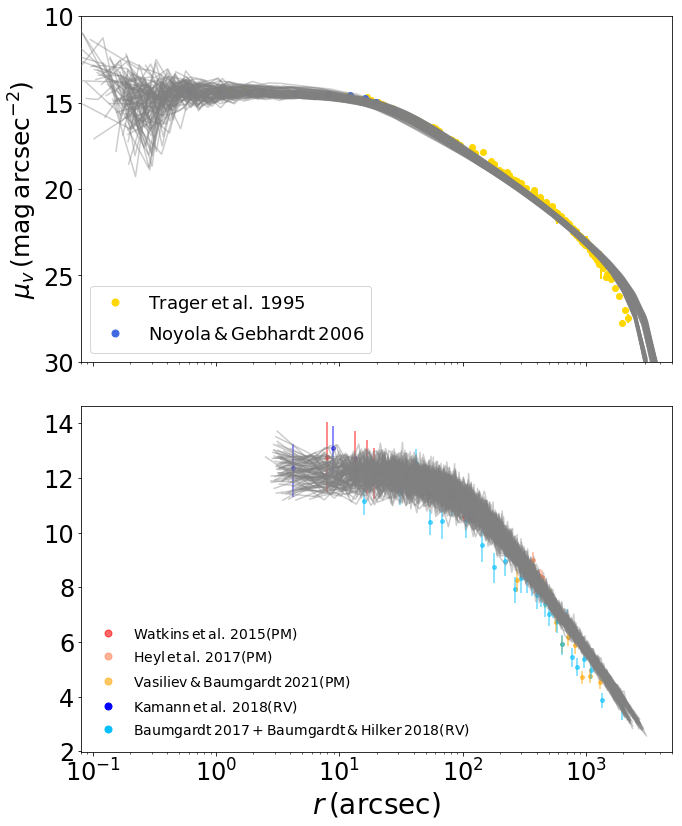

In [7]:
##Selecting best-fit and near-fit snapshots
##Nicholas plotting code /projects/b1095/nrui/47tuc

from astropy.table import Table, Column
from scipy.interpolate import interp1d
import pdb
import os

E_BV = 0#0.04 # Harris 1996, 2010 edition
d47 = 4.52 # Baumgardt et al. 2019, kpc
Av = 3.1 * E_BV # Cardelli 1989

pathlist = ['/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/observed_profiles/',
            '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv3.5_3e6_tcon_fb10/',
            '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon_rt171/',
            '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon_IMFhigh1.8/',
            '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon_IMFhigh2.0/',
            '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon_IMFhigh2.3/',
            '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/HB_IMF_elson_rv4_tcon/',
            '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_150maxmass_rv1.4/',
            '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/MOCHA47Tuc_150maxmass_rv1.8/',
            '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/MOCHA47Tuc_elson_rv2/',
            '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/MOCHA47Tuc_elson_rv4_2e6/',
            '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/MOCHA47Tuc_elson_rv4_2.4e6/',
            '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/MOCHA47Tuc_largertidal/',
            '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/MOCHA47Tuc/']

# Pull all snapshots to be searched
sbp_files = []; vdp_files = []
for xx in range(len(pathlist)):
    print(len(np.sort(glob(pathlist[xx]+'initial.snap*.2D_SBPLcut12_NCUT0.85.dat'))))
    sbp_files += list(np.sort(glob(pathlist[xx]+'initial.snap*.2D_SBPLcut12_NCUT0.85.dat')))
    vdp_files += list(np.sort(glob(pathlist[xx]+'initial.snap*.vel_dispersion_vr_pm_700_0.85.dat')))
#sbp_files = np.sort(glob(path+'initial.snap*.2D_SBPLcut15_NCUT0.8.dat'))
#vdp_files = np.sort(glob(path+'initial.snap*.vel_dispersion_giants_vr_pm_700_0.8.dat'))


# Calculate normalized chi square on all files
sbp_rchisq_list = np.array([])
vdp_rchisq_list = np.array([])

for ii in range(len(sbp_files)):
    sbp_ii = np.genfromtxt(sbp_files[ii])
    vdp_ii = np.genfromtxt(vdp_files[ii])
    
    r_sbp = uc.pc2arcsec(d47, sbp_ii[:,1]); sigma_sbp = conversions.SB_converter(sbp_ii[:,3])
    r_vdp = uc.pc2arcsec(d47, vdp_ii[:,0])
    
    # Interpolate SBP and VDP to calculate chisq
    ##Note I did not include Av here
    sbp_interp = interp1d(r_sbp, sigma_sbp+Av, bounds_error=False, fill_value=(sigma_sbp[0], 0))
    vdp_interp = interp1d(r_vdp, vdp_ii[:,1], bounds_error=False, fill_value=(vdp_ii[:,1][0], 0))
    
    sbp_chisq = np.sum((sbp_obs_sort - sbp_interp(r_sbp_obs_sort)) ** 2 / sbperr_obs_sort ** 2)
       
    data_above = np.where(vel_rvpm_sort > vdp_interp(r_rvpm_sort)) # treat upper and lower error bars differently
    data_below = np.where(vel_rvpm_sort < vdp_interp(r_rvpm_sort))
    vdp_chisq1 = np.sum((vel_rvpm_sort[data_above] - vdp_interp(r_rvpm_sort[data_above])) ** 2 / velerr_rvpm_d_sort[data_above] ** 2)
    vdp_chisq2 = np.sum((vel_rvpm_sort[data_below] - vdp_interp(r_rvpm_sort[data_below])) ** 2 / velerr_rvpm_u_sort[data_below] ** 2)
    
    sbp_rchisq = sbp_chisq / len(r_sbp_obs_sort)
    vdp_rchisq = (vdp_chisq1 + vdp_chisq2) / len(r_rvpm_sort)
    
    sbp_rchisq_list = np.append(sbp_rchisq_list, sbp_rchisq)
    vdp_rchisq_list = np.append(vdp_rchisq_list, vdp_rchisq)
    
    #print(f'Done {ii+1} snapshots of {len(sbp_files)}')
        
print(sbp_rchisq_list, vdp_rchisq_list)

##Selecting good fit snaps and Plotting
snap_good_fit = np.where(np.max([sbp_rchisq_list, vdp_rchisq_list], axis=0) < 16.5)[0]
print(snap_good_fit)


sbp_files = np.array(sbp_files)[np.argsort(np.max([sbp_rchisq_list, vdp_rchisq_list], axis=0))]
vdp_files = np.array(vdp_files)[np.argsort(np.max([sbp_rchisq_list, vdp_rchisq_list], axis=0))]
chisqs = np.max([sbp_rchisq_list, vdp_rchisq_list], axis=0)[np.argsort(np.max([sbp_rchisq_list, vdp_rchisq_list], axis=0))]

for xx in range(50):
    with open(sbp_files[xx]) as fsbp:
        first_line = fsbp.readline().strip()
        t = first_line.split('=')[1]
    print(sbp_files[xx], t, chisqs[xx])
#print(sbp_files[:70])
#print(vdp_files[:70])
#print(len(chisqs), chisqs[:70])


# Matplotlib
good = True#np.where(np.max([sbp_rchisq_list, vdp_rchisq_list], axis=0) < 10)

plt.close()

####################################################
R_sun_obs=4.52
###Plotting        
rdot=mlines.Line2D([], [],  linestyle = 'None', color='red', marker='o',
                  markersize=7, alpha=0.6, label=r'$\rm{Watkins\,et\,al.\,2015(PM)}$')
cdot=mlines.Line2D([], [],  linestyle = 'None', color='coral', marker='o',
                  markersize=7, alpha=0.6, label=r'$\rm{Heyl\,et\,al.\,2017(PM)}$')
odot=mlines.Line2D([], [],  linestyle = 'None', color='orange', marker='o',
                  markersize=7, alpha=0.6, label=r'$\rm{Vasiliev\,&\,Baumgardt\,2021(PM)}$')
bdot=mlines.Line2D([], [],  linestyle = 'None', color='blue', marker='o',
                  markersize=7, label=r'$\rm{Kamann\,et\,al.\,2018(RV)}$')
sbdot=mlines.Line2D([], [],  linestyle = 'None', color='deepskyblue', marker='o',
                  markersize=7, label=r'$\rm{Baumgardt\,2017 + Baumgardt\,&\,Hilker\,2018(RV)}$')
gold_dot = mlines.Line2D([], [],  linestyle = 'None', color='gold', marker='o',
                  markersize=7, label=r'$\rm{Trager\,et\,al.\,1995}$')
rb_dot = mlines.Line2D([], [],  linestyle = 'None', color='royalblue', marker='o',
                  markersize=7, label=r'$\rm{Noyola\,&\,Gebhardt\,2006}$')


fig, ax=plt.subplots(nrows = 2, sharex=True, sharey=False, figsize=(10,12))
#########################
###Plotting in observed data 
ax[0].errorbar(r_trag, sbp_trag, yerr = sbperr_trag, fmt='o', lw = 2.0, color = 'gold',
               label=r'$\rm{Trager\,et\,al.\,1995}$')
ax[0].errorbar(r_noyola, vmag_noyola, yerr = vmag_noyola_err, fmt='o', lw = 2.0, color = 'royalblue',
               label=r'$\rm{Noyola\,&\,Gebhardt\,2006}$')


ax[1].errorbar(r_wk,sigma_wk_kms ,yerr=sigma_wk_err_kms, fmt='o',markersize=0.01, alpha=0.6, color = 'red')
ax[1].scatter(r_wk, sigma_wk_kms, s=15, alpha = 0.6, color = 'red')

ax[1].scatter(r_bg, sigma_bg, s=15, alpha = 0.6, color = 'orange')
ax[1].errorbar(r_bg, sigma_bg, yerr=[del_sigmau_bg, del_sigmad_bg], fmt='o',markersize=0.01, alpha=0.6, color = 'orange')

ax[1].scatter(r_hy, sigma_hy_kms, s=15, alpha = 0.6, color = 'coral')
ax[1].errorbar(r_hy, sigma_hy_kms, yerr=sigma_hy_err_kms, fmt='o',markersize=0.01, alpha=0.6, color = 'coral')

ax[1].scatter(r_bg_rv, sigma_bg_rv, s=15, alpha = 0.6, color = 'deepskyblue')
ax[1].errorbar(r_bg_rv, sigma_bg_rv, yerr=[del_sigmau_bg_rv, del_sigmad_bg_rv], fmt='o',markersize=0.01, alpha=0.6, color = 'deepskyblue')

ax[1].scatter(r_ka, sigma_ka, s=15, alpha = 0.6, color = 'blue')
ax[1].errorbar(r_ka, sigma_ka, yerr=[sigma_ka_plus, sigma_ka_minus], fmt='o',markersize=0.01, alpha=0.6, color = 'blue')


#######################
for ii in range(100):
    ##Model data
    snap2D_L15 = sbp_files[ii]
    snap_veldisp = vdp_files[ii]
    
    data5 = np.genfromtxt(snap2D_L15)
    arcsec = conversions.pc_to_arcsec(data5[:,1],R_sun_obs)
    SB = conversions.SB_converter(data5[:,3])
    SBerr = data5[:,6]/data5[:,5]*SB
    SD = conversions.SD_converter(data5[:,5], R_sun_obs)
    SDerr = conversions.SD_converter(data5[:,6], R_sun_obs)
    
    arcsec_cut = []
    SB_cut = []
    SBerr_cut = []

    for k in range(len(SB)):
        if arcsec[k] < 10 and SB[k] > 20:
            Nothing = 0
        else:
            arcsec_cut.append(arcsec[k])
            SB_cut.append(SB[k])
            #SBerr_cut.append(SBerr[k])
            
    data_vel = np.genfromtxt(snap_veldisp)
    R_model = conversions.pc_to_arcsec(data_vel[:,0],R_sun_obs)
    sigma_model = data_vel[:,1]
    sigma_err_model = data_vel[:,2]

    #ax[0].plot(sbp_r, sbp_s, c='gray', alpha=0.4)


#######################
    ##Plotting model data
    ax[0].plot(arcsec_cut, np.array(SB_cut)+Av, color = 'gray', alpha=0.4, zorder = 3)
    ax[1].plot(R_model, sigma_model, color = 'gray', alpha=0.4, zorder=3)
    
    ax[0].set_xscale('log')
    ax[0].set_xlim(0.08,5000)
    ax[0].set_ylim(30,10)
    #ax[0][x].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=20)
    ax[0].set_ylabel(r'$\mu_v\,(\rm{mag\, arcsec^{-2}})$',fontsize=25)
    ax[0].legend(handles = [gold_dot, rb_dot], loc='lower left',scatterpoints=1, prop={'size': 18})
        
    
    ax[1].set_xscale('log')
    ax[1].set_xlim(0.08,5000)
    ax[1].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=28)
    #ax[1][x].legend(loc=3,scatterpoints=1, ncol=2, prop={'size': 20})
    ax[1].legend(handles=[rdot, cdot, odot, bdot,sbdot], loc='lower left', prop={'size': 14}, numpoints=1, frameon=False)

fig.tight_layout()

In [18]:
##Calculate average properties and standard deviations from best-fit and near-fit models
##Not used here, see python code with name compact_object_nave.py
sb_const = 5.670374419*10**(-8)  ##W*m^−2*K^−4, Stefan-Boltzmann Constant
Lsun = 3.828*10**26  ##Watts
Rsun = 6.957*10**8 ##meters

import scripts, scripts1, scripts2, scripts3

def LtoT(lumi, radi):
    r_meter = radi*Rsun
    Area = 2*twopi*r_meter**2
    return pow((lumi*Lsun)/sb_const/Area, 1./4.)



def med3(array):
    if len(array)>4: return np.median(array)
    else: return 0
    

def get_turnoff(snapshot,Nbins=200):
    '''Purpose: Find the MS turnoff, defined as the luminosity (and temperature)
    of the highest-temperature upper-MS single that is NOT a blue straggler.
    Inputs: snapshot array and bin resolution for both luminosity and temperature axes of an HR diagram.
    Outputs: turnoff point (luminosity,temperature). Units: (Lsun,Kelvin).'''
    
    T0, L0 = [], []
    L_bin_edges = np.logspace(-0.5,0.5,int(Nbins+1))
    #print(L_bin_edges)
    L_bins = [[] for i in range(int(Nbins))]
    T_bins = [[] for i in range(int(Nbins))]
    
    ##For CMC-COSMIC ver 1.0.0
    binflag = snapshot.data['binflag']
    L = snapshot.data['luminosity_LSUN'][binflag != 1]
    ktype = snapshot.data['startype'][binflag != 1]
    R = snapshot.data['radius_RSUN'][binflag != 1]
    
    L0 = L[ktype == 1]; R0 = R[ktype == 1]
    T0 = LtoT(L0, R0)
    L0 = np.array(L0); T0 = np.array(T0)
    #print(L0, T0)
       
    #print(L0, T0)
    for j,Lj in enumerate(L0):
        for b in range(int(Nbins)):
            if L_bin_edges[b] <= Lj < L_bin_edges[b+1]: T_bins[b].append(T0[j]); L_bins[b].append(L0[j])

    T_meds = [med3(bin) for bin in T_bins]                  # List the median temperature of each bin
    turnoff_bin_index = T_meds.index(np.max(T_meds))        # Find the bin with the highest median temperature
    
    return (np.median(L_bins[turnoff_bin_index]), T_meds[turnoff_bin_index])

sys.path.insert(1, '/projects/b1095/syr904/MyCodes/cmctoolkit')
import cmctoolkit as cmct



paths = ['/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/',
         '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv3.5_3e6_tcon_fb10/',
         '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon_rt171/']

t_span_up = [13600., 13700., 13200.]; t_span_down = [8200., 9900., 8900.]

r_c = []; r_h = []; mass = []
r_cobs = []; r_hl = []
Nbh_inter = []; Nbhbh_inter = []; Nbhbin_inter = []
Nns_inter = []; Npsr_inter = []; Nmsp_inter = []; Nnsns_inter = []
n_cv = []
n_tot = [[],[],[],[],[],[]]
n_bss = []
nsms_tc = []
for xx in range(len(paths)):
    print(paths[xx])
    l_conv = dyn.conv('l', paths[xx]+'initial.conv.sh')
    m_conv = dyn.conv('m', paths[xx]+'initial.conv.sh')
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
    
    data_key = np.genfromtxt(paths[xx]+'snap_keys.txt', dtype = 'str')
    snapno = data_key[:,0]; snaptime = (data_key[:,1]).astype(np.float)*t_conv
    snapcodet = data_key[:,1]
    ##print(snaptime[10])

    ###################################################
    ##Average rc and rh
    with open(paths[xx]+'initial.dyn.dat', 'r') as fdyn:
        next(fdyn); next(fdyn)
        for line in fdyn:
            datadyn = line.split()
            if t_span_down[xx]/t_conv<=float(datadyn[0])<=t_span_up[xx]/t_conv:
                r_c.append(float(datadyn[7])*l_conv)
                r_h.append(float(datadyn[20])*l_conv)
                mass.append(float(datadyn[4])*m_conv)

    params_files = np.sort(glob(paths[xx]+'initial.snap*.cluster_params.dat'))
    for vv in range(len(params_files)):
        datapara = np.genfromtxt(params_files[vv])
        if t_span_down[xx] <= datapara[0,0] <= t_span_up[xx]:
            r_cobs.append(datapara[0,8]); r_hl.append(datapara[0,9])
            
    print('rc, rh done')   
        
    ###################################################
    ##Average number of BHs
    bhs = np.genfromtxt(paths[xx]+'initial.bh.dat')
    bh_time = bhs[:,1]; Nbh_tot = bhs[:,2]; Nbhbh = bhs[:,5]; Nbhbin = bhs[:,4]

    for vv in range(len(bh_time)):
        thetime = bh_time[vv]*t_conv
        if t_span_down[xx] <= thetime <= t_span_up[xx]:
            Nbh_inter.append(Nbh_tot[vv])
            Nbhbh_inter.append(Nbhbh[vv])
            Nbhbin_inter.append(Nbhbin[vv])
            
    print('bh done')
            
    ###################################################
    ##Average number of NSs, young pulsars and MSPs
    nss = np.genfromtxt(paths[xx]+'initial.ns.dat')
    ns_time = nss[:,0]; Nns_tot = nss[:,1]; Npsr = nss[:,5]; Nmsp = nss[:,6]; Nnsns = nss[:,7]

    for vv in range(len(ns_time)):
        thetime = ns_time[vv]
        if t_span_down[xx] <= thetime <= t_span_up[xx]:
            Nns_inter.append(Nns_tot[vv])
            Npsr_inter.append(Npsr[vv])
            Nmsp_inter.append(Nmsp[vv])
            Nnsns_inter.append(Nnsns[vv])
        
    print('ns done')
                 
    ###################################################
    ##Average number of CVs
    wdms_files = np.sort(glob(paths[xx]+'WDMS*.dat'))
    for vv in range(len(wdms_files)):
        wdms_temp = wdms_files[vv].replace(paths[xx]+'WDMS', '')
        wdms_snapno = wdms_temp.split('.')[0]
        #print(wdms_snapno)
        t_wdms = snaptime[int(wdms_snapno)]
        
        Ncv = 0
        if t_span_down[xx] <= t_wdms <= t_span_up[xx]:
            #print(wdms_files[vv])
            wd_file = np.genfromtxt(wdms_files[vv])
            m1 = wd_file[:,3]; rad1 = wd_file[:,9]
            id0 = wd_file[:,0]; id1 = wd_file[:,1]
    
            for kk in range(len(rad1)):
                if rad1[kk]>=1.:
                    Ncv+=1
                
            n_cv.append(Ncv)

    print('cv done')
    
    ###################################################
    ##Average number of LMXBs
    nswd_files = np.sort(glob(paths[xx]+'NSWD*.dat'))
    nsg_files = np.sort(glob(paths[xx]+'NSGiant*.dat'))
    nsms_files = np.sort(glob(paths[xx]+'NSMS*.dat'))
    bhwd_files = np.sort(glob(paths[xx]+'BHWD*.dat'))
    bhg_files = np.sort(glob(paths[xx]+'BHGiant*.dat'))
    bhms_files = np.sort(glob(paths[xx]+'BHMS*.dat'))
    
    msp_files = np.sort(glob(paths[xx]+'MSP*.dat'))
    
    print(len(nswd_files), len(nsg_files), len(nsms_files))
    for vv in range(len(nswd_files)):
        nswd_data = np.genfromtxt(nswd_files[vv])
        nsg_data = np.genfromtxt(nsg_files[vv])
        nsms_data = np.genfromtxt(nsms_files[vv])
        
        bhwd_data = np.genfromtxt(bhwd_files[vv])
        bhg_data = np.genfromtxt(bhg_files[vv])
        bhms_data = np.genfromtxt(bhms_files[vv])
        
        msp_data = np.genfromtxt(msp_files[vv])
        id0_msp = msp_data[:,10]; id1_msp = msp_data[:,11]
        
        Ntot = [0, 0, 0, 0 ,0 ,0]
        n_nsms_tc = 0

        all_files = [nswd_data, nsg_data, nsms_data, bhwd_data, bhg_data, bhms_data]
        for kk in range(len(all_files)):
            if len(all_files[kk])==0:
                n_tot[kk].append(Ntot[kk])
                continue
            
            if isinstance(all_files[kk][0], float):
                m1 = all_files[kk][3]; rad1= all_files[kk][9]
                id0 = all_files[kk][0]; id1 = all_files[kk][1]; tcflag = all_files[kk][12]
                
                if rad1>=1. and id0 not in id0_msp:
                    Ntot[kk]+=1
                    if kk==2 and tcflag==91:
                        Ntot[kk]-=1
                        
                if kk==2 and tcflag==91 and id0 not in id0_msp: 
                    n_nsms_tc+=1
                        
            else:
                m1 = all_files[kk][:,3]; rad1= all_files[kk][:,9]
                id0 = all_files[kk][:,0]; id1 = all_files[kk][:,1]; tcflag = all_files[kk][:,12]
                
                for ii in range(len(rad1)):  
                    if rad1[ii]>=1. and id0[ii] not in id0_msp:
                        Ntot[kk]+=1
                        if kk==2 and tcflag[ii]==91:
                            Ntot[kk]-=1
                            
                    if kk==2 and tcflag[ii]==91 and id0[ii] not in id0_msp: 
                        n_nsms_tc+=1
                            
            n_tot[kk].append(Ntot[kk]); nsms_tc.append(n_nsms_tc)
    
    print('lmxb done, tidal capture nsms done')

    ###################################################
    ####Average number of BSSs
    
    for ii in range(0, len(snaptime), 3):
        if t_span_down[xx] <= snaptime[ii] <= t_span_up[xx]:
            thekey = '/'+str(int(snapno[ii]))+'(t='+snapcodet[int(snapno[ii])]+')'
            snap_h5 = cmct.Snapshot(fname=path+'initial.snapshots.h5', snapshot_name=thekey, 
                         conv=path+'initial.conv.sh', 
                         dist=4.52, # distance to cluster in kpc
                         z=0.0038)

            Lto, Tto = get_turnoff(snap_h5,400)
            #print(Lto, Tto)
            print(snapno[ii])
            
            L_bss = []; T_bss = []; k0_bss = []; k1_bss = []
            L_bss_rh = []; T_bss_rh = []; k0_bss_rh = []; k1_bss_rh = []
            Temp = []; Ltot = []
    
    
            ##For CMC-COSMIC ver 1.0.0
            binflag = snap_h5.data['binflag']
            rgc = snap_h5.data['r']*l_conv
            rgcsin = np.array(rgc[binflag != 1]); rgcbin = np.array(rgc[binflag == 1])
            
            Lsin = snap_h5.data['luminosity_LSUN'][binflag != 1]
            Lbin0 = np.array(snap_h5.data['bin_star_lum0_LSUN'][binflag == 1])
            Lbin1 = np.array(snap_h5.data['bin_star_lum1_LSUN'][binflag == 1])
            ktype = snap_h5.data['startype'][binflag != 1]
            kbin0 = np.array(snap_h5.data['bin_startype0'][binflag == 1])
            kbin1 = np.array(snap_h5.data['bin_startype1'][binflag == 1])
            Rsin = snap_h5.data['radius_RSUN'][binflag != 1]
            Rbin0 = np.array(snap_h5.data['bin_star_radius0_RSUN'][binflag == 1])
            Rbin1 = np.array(snap_h5.data['bin_star_radius1_RSUN'][binflag == 1])
            idsin = snap_h5.data['id'][binflag != 1]
            idbin0 = np.array(snap_h5.data['id0'][binflag == 1]); idbin1 = np.array(snap_h5.data['id1'][binflag == 1])
            
            ###For single stars
            Lsin_nobh = np.array(Lsin[ktype != 14]); Rsin_nobh = np.array(Rsin[ktype != 14])
            Tsin_nobh = LtoT(Lsin_nobh, Rsin_nobh)
            ktype_nobh = ktype[ktype != 14]
            rgcsin_nobh = rgcsin[ktype != 14]
            idsin_nobh = idsin[ktype != 14]
            
            ##Selecting BSS
            Ltemp1 = Lsin_nobh[Lsin_nobh >= 2*Lto]; Ttemp1 = Tsin_nobh[Lsin_nobh >= 2*Lto]
            ktype_temp1 = ktype_nobh[Lsin_nobh >= 2*Lto]
            Ltemp2 = Ltemp1[Ttemp1 >= Tto]; Ttemp2 = Ttemp1[Ttemp1 >= Tto]
            ktype_temp2 = ktype_temp1[Ttemp1 >= Tto]
            idsin_temp1 = idsin_nobh[Lsin_nobh >= 2*Lto]
            idsin_temp2 = idsin_temp1[Ttemp1 >= Tto]
            r_temp1 = rgcsin_nobh[Lsin_nobh >= 2*Lto]; r_temp2 = r_temp1[Ttemp1 >= Tto]
            
            r_bss = np.concatenate((r_temp2[ktype_temp2 == 0], r_temp2[ktype_temp2 == 1]), axis=None)
            L_bss = L_bss + list(Ltemp2[ktype_temp2 == 0]) + list(Ltemp2[ktype_temp2 == 1])
            T_bss = T_bss + list(Ttemp2[ktype_temp2 == 0]) + list(Ttemp2[ktype_temp2 == 1])
            bss_id = bss_id + list(idsin_temp2[ktype_temp2 == 0]) + list(idsin_temp2[ktype_temp2 == 1])
            bss_id = [int(i) for i in bss_id]
            
            L_bss = np.array(L_bss); T_bss = np.array(T_bss)
            L_bss_rh = L_bss_rh + list(L_bss[r_bss <= 6.5])
            T_bss_rh = T_bss_rh + list(T_bss[r_bss <= 6.5])
            L_bss = list(L_bss); T_bss = list(T_bss)
            
            ###For binary stars
            for kk in range(len(Lbin0)):
                if kbin0[kk] != 14 or kbin1[kk] != 14:
                    temperature0 = LtoT(Lbin0[kk], Rbin0[kk])
                    temperature1 = LtoT(Lbin1[kk], Rbin1[kk])
                    temp_eff = (temperature0*Lbin0[kk]+temperature1*Lbin1[kk])/(Lbin0[kk] + Lbin1[kk])
                    Temp.append(temp_eff)
                    Ltot.append(Lbin0[kk] + Lbin1[kk])
                        
                    if Lbin0[kk] > 2*Lto and temperature0 > Tto and (kbin0[kk] == 1 or kbin0[kk] == 0):
                        L_bss.append(Lbin0[kk]); T_bss.append(temperature0)
                        bss_id.append(int(idbin0[kk]))
                        if rgcbin[kk] <= 6.5:
                            L_bss_rh.append(Lbin0[kk]); T_bss_rh.append(temperature0)
                        
                    if Lbin1[kk] > 2*Lto and temperature1 > Tto and (kbin1[kk] == 1 or kbin1[kk] == 0):
                        L_bss.append(Lbin1[kk]); T_bss.append(temperature1)
                        bss_id.append(int(idbin1[kk]))
                        if rgcbin[kk] <= 6.5:
                            L_bss_rh.append(Lbin0[kk]); T_bss_rh.append(temperature0)
    
            n_bss.append(len(L_bss))
    
    print('bss done')
    
    


print(np.mean(mass), np.mean(r_c), np.mean(r_h))
print(np.std(mass), np.std(r_c), np.std(r_h))
print(np.mean(r_cobs), np.mean(r_hl))
print(uc.pc2arcsec(4.52, np.mean(r_cobs))/60., uc.pc2arcsec(4.52, np.mean(r_hl))/60.)
print(uc.pc2arcsec(4.52, np.std(r_cobs))/60., uc.pc2arcsec(4.52, np.std(r_hl))/60.)
r_cobs_arcmin = uc.pc2arcsec(4.52, np.array(r_cobs))/60.
r_hl_arcmin = uc.pc2arcsec(4.52, np.array(r_hl))/60.
print(np.mean(r_cobs_arcmin), np.mean(r_hl_arcmin))
print(np.std(r_cobs_arcmin), np.std(r_hl_arcmin))

print(np.mean(Nbh_inter), np.mean(Nbhbh_inter), np.mean(Nbhbin_inter))
print(np.std(Nbh_inter), np.std(Nbhbh_inter), np.std(Nbhbin_inter))

print(len(Nmsp))
print(Nns_inter)
print(np.mean(Nns_inter), np.mean(Npsr_inter),  np.mean(Nmsp_inter), np.mean(Nnsns_inter))
print(np.std(Nns_inter), np.std(Npsr_inter),  np.std(Nmsp_inter), np.std(Nnsns_inter))
print(np.mean(np.array(Npsr_inter)-np.array(Nmsp_inter)))
print(np.std(np.array(Npsr_inter)-np.array(Nmsp_inter)))

print(np.mean(n_cv), np.mean(n_cv_rh), np.mean(n_cv_bright), np.mean(n_cv_bright_rh))
print(np.std(n_cv), np.std(n_cv_rh), np.std(n_cv_bright), np.std(n_cv_bright_rh))

print(np.sum(n_tot, axis = 0))
print(np.mean(np.sum(n_tot, axis=0)), np.std(np.sum(n_tot, axis=0)))

print('n_tc_nsms', len(nsms_tc[-1]))

print(np.mean(n_bss),np.std(n_bss))

/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/
rc, rh done
bh done
ns done
cv done
43 43 43


/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:170: UserWarning: genfromtxt: Empty input file: "/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/NSGiant676.dat"
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:174: UserWarning: genfromtxt: Empty input file: "/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/BHGiant676.dat"
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:170: UserWarning: genfromtxt: Empty input file: "/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/NSGiant679.dat"
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:174: UserWarning: genfromtxt: Empty input file: "/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/BHGiant679.dat"
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:170: UserWar

lmxb done, tidal capture nsms done
681


KeyboardInterrupt: 

6
0.5967741935483871


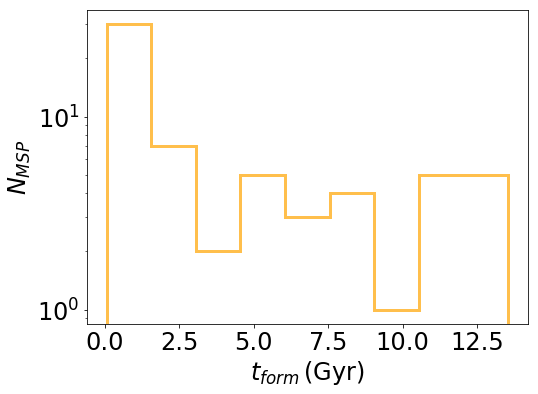

In [29]:
##MSP formation time distribution
data_newmsp = np.genfromtxt(path.replace('/observed_profiles', '')+'allmsp_atbirth.dat')
tf_myr = data_newmsp[:,0]; prim_flag = data_newmsp[:,11]; formflag = data_newmsp[:,13]
print(len(prim_flag[prim_flag==1]))
print(len(tf_myr[tf_myr<3000.])/len(tf_myr))


plt.figure(figsize=(8,6))
#plt.hist(tf_myr,
#        bins = np.logspace(np.log10(np.min(tf_myr)), np.log10(np.max(tf_myr)), 12),
#        alpha=0.7, histtype = 'step', lw=3, color = 'orange')
plt.hist(tf_myr/1000.,
        bins = 9,
        alpha=0.7, histtype = 'step', lw=3, color = 'orange')
#plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$t_{form}\,\rm{(Gyr)}$')
plt.ylabel(r'$N_{MSP}$')
plt.tight_layout()
#lt.savefig('/projects/b1095/syr904/projects/massive_clusters/msp_tform_linear.pdf', dpi=300)

4.0


Text(0,0.5,'M(Msun)')

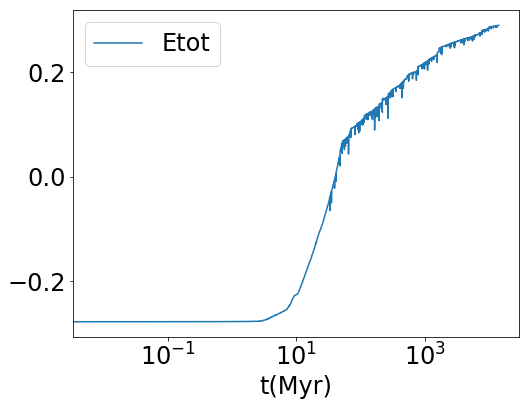

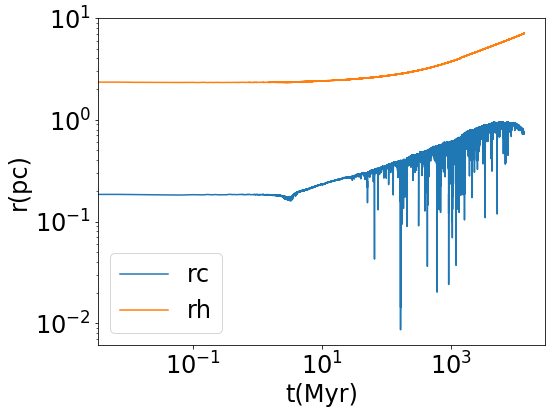

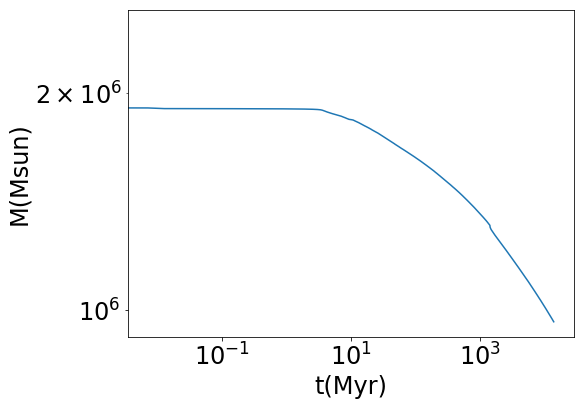

In [7]:
##Energy conservation check
path = '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/'
#path = '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/'

t_conv = dyn.conv('t', path+'initial.conv.sh')
l_conv = dyn.conv('l', path+'initial.conv.sh')
m_conv = dyn.conv('m', path+'initial.conv.sh')
print(l_conv)

E_tot = []; E_esc = []; E_oops = []; Time = []; E_totoops = []
r_c = []; r_h = []; M = []
with open(path+'initial.dyn.dat', 'r') as fdyn:
    next(fdyn); next(fdyn)
    for line in fdyn:
        data = line.split()
        Time.append(float(data[0])*t_conv)
        E_tot.append(float(data[9])); E_esc.append(float(15)); E_oops.append(float(18))
        r_c.append(float(data[7])*l_conv); r_h.append(float(data[20])*l_conv)
        M.append(float(data[4])*m_conv)
        E_totoops.append(float(data[19]))
        
        
plt.figure(figsize = (8,6))
plt.plot(Time, E_totoops, label='Etot')
#plt.plot(Time, np.array(E_tot)-np.array(E_esc), label='Etot-Eesc')
plt.xscale('log')
plt.xlabel('t(Myr)')
plt.legend(loc='best')

plt.figure(figsize = (8,6))
plt.plot(Time, r_c, label='rc')
plt.plot(Time, r_h, label='rh')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('t(Myr)')
plt.ylabel('r(pc)')
plt.legend(loc='best')

plt.figure(figsize = (8,6))
plt.plot(Time, M)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('t(Myr)')
plt.ylabel('M(Msun)')
#plt.legend(loc='best')

['B', 'B0', 'B1', 'E', 'J', 'a[AU]', 'bacc0', 'bacc1', 'bin.Eb', 'bin_star_lum0[LSUN]', 'bin_star_lum1[LSUN]', 'bin_star_radius0[RSUN]', 'bin_star_radius1[RSUN]', 'bin_startype0', 'bin_startype1', 'binflag', 'dmdt0', 'dmdt1', 'e', 'epoch0', 'epoch1', 'eta', 'formation', 'formation0', 'formation1', 'id', 'id0', 'id1', 'lum0', 'lum1', 'luminosity[LSUN]', 'm0[MSUN]', 'm1[MSUN]', 'm[MSUN]', 'mass0_0', 'mass0_1', 'massc0', 'massc1', 'menv0', 'menv1', 'ospin', 'ospin0', 'ospin1', 'r', 'rad0', 'rad1', 'radc0', 'radc1', 'radius[RSUN]', 'radrol0', 'radrol1', 'renv0', 'renv1', 'star.phi', 'startype', 'tacc0', 'tacc1', 'tb', 'tms0', 'tms1', 'vr', 'vt']
['sF606W /projects/b1095/syr904/MyCodes/cmctoolkit_oldsnap/filterfunctions/HST_ACS_HRC.F606W_abridged.dat 2.92e-9', 'sF814W /projects/b1095/syr904/MyCodes/cmctoolkit_oldsnap/filterfunctions/HST_ACS_HRC.F814W_abridged.dat 1.12e-9', '']
3
sF606W
/projects/b1095/syr904/MyCodes/cmctoolkit_oldsnap/filterfunctions/HST_ACS_HRC.F606W_abridged.dat <class 's

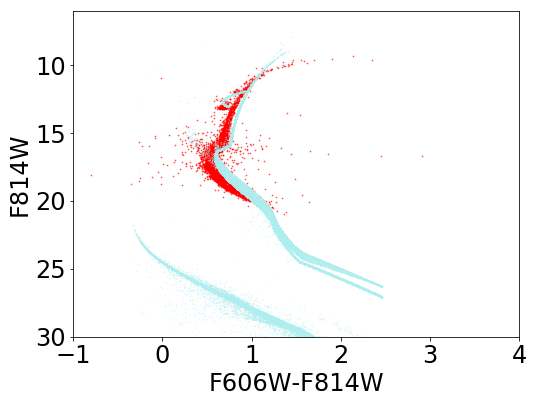

In [16]:
##Compare the color-magnitude diagrams
sys.path.insert(1, '/projects/b1095/syr904/MyCodes/cmctoolkit_oldsnap')
import cmctoolkit as cmct
from importlib import reload
reload(cmct)

##MUSE observation
df_muse = pd.read_csv('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/obstable_without_rv.csv',
                     names = ['star_id', 'spec_id', 'rv_uncer', 'SNR', 'JD_OBS', 'source_num', 'ra', 'dec', 'f606w',
                             'f814w', 'f606w-f814w'], header = 0)
df_muse_unique = df_muse.drop_duplicates('star_id', keep = 'first')
color = df_muse_unique['f606w-f814w']; magnitude = df_muse_unique['f814w']


##Model
snap_529 = cmct.Snapshot(fname='/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/initial.snap0529.dat.gz',
                         conv='/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/initial.conv.sh',
                         dist=4.52, # distance to cluster in kpc
                         z=0.0038)

#snap = cmct.Snapshot(fname='/projects/b1095/syr904/MyCodes/cmctoolkit/N8-RV1-RG8-Z0.1/initial.snap0382.dat.gz',
#                      conv='/projects/b1095/syr904/MyCodes/cmctoolkit/N8-RV1-RG8-Z0.1/initial.conv.sh',
#                      dist=15, # distance to cluster in kpc
#                         z=0.02*0.1
#                    )
#snap_529.make_2d_projection(seed=8675309)
#print(snap_529.data['luminosity[LSUN]'])
print(list(snap_529.data))
snap_529.add_photometry('/projects/b1095/syr904/MyCodes/cmctoolkit_oldsnap/filt_index_HST.txt')
print(list(snap_529.data))
f814 = snap_529.data['tot_obsMag_sF814W']; f606 = snap_529.data['tot_obsMag_sF606W']
color_model = f606-f814; mag_model = f814
#print(color_model)

fig, axs = plt.subplots(figsize = (8,6))
axs.scatter(color, magnitude, s=0.5, alpha=0.6, color = 'red')
axs.scatter(color_model, mag_model, s=0.1, alpha=0.5, color = 'paleturquoise')
axs.set_xlim(xmin = -1, xmax = 4)
axs.set_ylim(ymin = 6, ymax = 30)
axs.set_xlabel('F606W-F814W')
axs.set_ylabel('F814W')
plt.gca().invert_yaxis()

In [12]:
##Pulsars at last snapshot with tidal capture turned on
##Observed pulsars
df_obs_psr = pd.read_excel('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/47tuc_pulsars.xlsx', 
                        skiprows = 1, 
                        names = ['Name', 'Offset', 'Periods', 'Pdot', 'DM', 'Pb', 'X', 'Ecc', 'Mcomp', 'Type'])
type_47tuc = np.array(df_obs_psr['Type'])
pb_47tuc= np.array(df_obs_psr['Pb']); mc_47tuc = np.array(df_obs_psr['Mcomp'])
type47 = type_47tuc[type_47tuc != 'i']
pb47 = pb_47tuc[type_47tuc != 'i']; mc47 = mc_47tuc[type_47tuc != 'i']
print(pb47, mc47)


#################################################
##PULSARS
msp_elson = np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/msp_529.dat')
sma_elson = msp_elson[:,16]; sn_elson = msp_elson[:,18]; tcflag_elson = msp_elson[:,19]

psr_array = []
psr_bin = []
psr_notaic = []; psr_notgc = []
colns = [3,4,5,9,10,11,15,16,17]   ##r, B, P, rol1, mns, mc, kc, sma, ecc
for ii in range(len(colns)):
    num_col = int(colns[ii])
    psr_array.append(msp_elson[:,num_col])
    psr_bin.append(msp_elson[:,num_col][sma_elson != -100])
    psr_notaic.append(msp_elson[:,num_col][sn_elson != 4])
    psr_notgc.append([])
    for xx in range(len(msp_elson[:,num_col])):
        if tcflag_elson[xx] != 81 and tcflag_elson[xx] != 82 and tcflag_elson[xx] != 83:
            psr_notgc[ii].append(msp_elson[:,num_col][xx])
    psr_notgc[ii] = np.array(psr_notgc[ii])


pb_psr_bin = uc.au_to_period(np.array(psr_bin[-2]), np.array(psr_bin[4]), np.array(psr_bin[5]))
psr_bin.append(pb_psr_bin)
pb_psr = uc.au_to_period(np.array(psr_array[-2]), np.array(psr_array[4]), np.array(psr_array[5]))
psr_array.append(pb_psr)
pb_notaic = uc.au_to_period(np.array(psr_notaic[-2]), np.array(psr_notaic[4]), np.array(psr_notaic[5]))
psr_notaic.append(pb_notaic)
pb_notgc = uc.au_to_period(np.array(psr_notgc[-2]), np.array(psr_notgc[4]), np.array(psr_notgc[5]))
psr_notgc.append(pb_notgc)
            

##binaries
psr_notaic_bin = []
psr_sma = psr_notaic[-3] != -100
for ii in range(len(colns)+1):
    psr_notaic_bin.append(psr_notaic[ii][psr_sma])
    

psr_notgc_bin = []
psr_sma = psr_notgc[-3] != -100
for jj in range(len(colns)+1):
    psr_notgc_bin.append(psr_notgc[jj][psr_sma])
           
    
print('n_bin', len(psr_bin[-1]), 'n_all', len(psr_array[-1]))
print('n_bin_notaic', len(psr_notaic_bin[-1]), 'n_all_notaic', len(psr_notaic[-1]))
print('n_bin_notgc', len(psr_notgc_bin[-1]), 'n_all_notgc', len(psr_notgc[-1]))


#################################################
##TC NS-MS binaries and collision
nsms_elson = np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/NSMS_529.dat')
tcflag_nsms = nsms_elson[:,14]; sn_nsms = nsms_elson[:,15]
sn_nsms_91 = sn_nsms[tcflag_nsms == 91]
sn_nsms_81 = sn_nsms[tcflag_nsms == 81]


nsms_array = []
nsms_tc = []; nsms_gc = []
colns_nsms = [4,5,8,9,7,11]   ##mns, mms, a_au, ecc, kc, rolc
for ii in range(len(colns_nsms)):
    num_nsms = colns_nsms[ii]
    nsms_array.append(nsms_elson[:,num_nsms])
    nsms_tc.append(nsms_elson[:,num_nsms][tcflag_nsms == 91])
    nsms_gc.append(nsms_elson[:,num_nsms][tcflag_nsms == 81])
    
pb_nsms = uc.au_to_period(np.array(nsms_array[2]), np.array(nsms_array[0]), np.array(nsms_array[1]))
nsms_array.append(pb_nsms)
nsms_tc.append(pb_nsms[tcflag_nsms == 91])
nsms_gc.append(pb_nsms[tcflag_nsms == 81])
print('n_tc_nsms', len(nsms_tc[-1]), 'n_gc_nsms', len(nsms_gc[-1]), 'n_nsms', len(nsms_array[-1]))


##TC NS-WD binaries and collision
nswd_elson = np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/NSWD_529.dat')
tcflag_nswd = nswd_elson[:,14]; sn_nswd = nswd_elson[:,15]
sn_nswd_91 = sn_nswd[tcflag_nswd == 91]
sn_nswd_81 = sn_nswd[tcflag_nswd == 81]

nswd_array = []
nswd_tc = []; nswd_gc = []
colns_nswd = [4,5,8,9,7,11]   ##mns, mms, a_au, ecc, kc, rolc
for ii in range(len(colns_nswd)):
    num_nswd = colns_nswd[ii]
    nswd_array.append(nswd_elson[:,num_nswd])
    nswd_tc.append(nswd_elson[:,num_nswd][tcflag_nswd == 91])
    nswd_gc.append(nswd_elson[:,num_nswd][tcflag_nswd == 81])
    
pb_nswd = uc.au_to_period(np.array(nswd_array[2]), np.array(nswd_array[0]), np.array(nswd_array[1]))
nswd_array.append(pb_nswd)
nswd_tc.append(pb_nswd[tcflag_nswd == 91])
nswd_gc.append(pb_nswd[tcflag_nswd == 81])
print('n_tc_nswd', len(nswd_tc[-1]), 'n_gc_nswd', len(nswd_gc[-1]), 'n_nswd', len(nswd_array[-1]))


###########################
##Finally filtering out the disrupted ultra-compact binaries 
##with carbon WDs <~ 0.01 Msun from Deloye & Bildsten 2003
print('######################')
index_del_notaic = []
for kk in range(len(psr_notaic_bin[-1])):
    if psr_notaic_bin[5][kk]<=0.05:
        print('pb', psr_notaic_bin[-1][kk]*24.*60., 'mc', psr_notaic_bin[5][kk], 'kc', psr_notaic_bin[6][kk], 
                'rolc', psr_notaic_bin[3][kk])
    
    if psr_notaic_bin[5][kk]<=0.01 and psr_notaic_bin[6][kk]>10:
        index_del_notaic.append(kk)
        
psr_notaic_bin_filterucb = []
for xx in range(len(psr_notaic_bin)):
    new_array = np.delete(psr_notaic_bin[xx], index_del_notaic)
    psr_notaic_bin_filterucb.append(new_array)


print('######################')
index_del_notgc = []
for kk in range(len(psr_notgc_bin[-1])):
    if psr_notgc_bin[5][kk]<=0.05:
        print('pb', psr_notgc_bin[-1][kk]*24.*60., 'mc', psr_notgc_bin[5][kk], 'kc', psr_notgc_bin[6][kk], 
              'rolc', psr_notgc_bin[3][kk])
        
    if psr_notgc_bin[5][kk]<=0.01 and psr_notgc_bin[6][kk]>10:
        index_del_notgc.append(kk)
        
psr_notgc_bin_filterucb = []
for xx in range(len(psr_notgc_bin)):
    psr_notgc_bin_filterucb.append(np.delete(psr_notgc_bin[xx], index_del_notgc))
    
    
print('######################')
index_del_nswd_tc = []
for kk in range(len(nswd_tc[-1])):
    if nswd_tc[1][kk]<=0.05:
        print('pb', nswd_tc[-1][kk]*24.*60., 'mc', nswd_tc[1][kk], 'kc', nswd_tc[4][kk], 
              'rolc', nswd_tc[5][kk])
    
    if nswd_tc[1][kk]<=0.01 and nswd_tc[4][kk] > 10:
        index_del_nswd_tc.append(kk)
    
nswd_tc_filterucb = []
for xx in range(len(nswd_tc)):
    nswd_tc_filterucb.append(np.delete(nswd_tc[xx], index_del_nswd_tc))
     
sn_nswd_91_filterucb = np.delete(sn_nswd_91, index_del_nswd_tc)
        

print('######################')
index_del_nswd_gc = []
for kk in range(len(nswd_gc[-1])):
    if nswd_gc[1][kk]<=0.05:
        print('pb', nswd_gc[-1][kk]*24.*60., 'mc', nswd_gc[1][kk], 'kc', nswd_gc[4][kk], 
              'rolc', nswd_gc[5][kk])
        
    if nswd_gc[1][kk]<=0.01 and nswd_gc[4][kk] > 10:
        index_del_nswd_gc.append(kk)
    
nswd_gc_filterucb = []
for xx in range(len(nswd_gc)):
    nswd_gc_filterucb.append(np.delete(nswd_gc[xx], index_del_nswd_gc))

sn_nswd_81_filterucb = np.delete(sn_nswd_81, index_del_nswd_gc)

[2.25684 2.3577 0.22979 0.12066 0.13597 0.14725 1.18908 0.06623 1.20172
 1.12618 0.42911 0.21213 0.133 10.9212 0.52194 0.1793 0.3184] [0.18 0.19 0.015 0.024 0.025 0.02 0.21 0.03 0.1 0.2 0.14 0.35 0.14 0.42
 0.16 0.0089 0.235]
n_bin 60 n_all 76
n_bin_notaic 24 n_all_notaic 39
n_bin_notgc 13 n_all_notgc 17
n_tc_nsms 5 n_gc_nsms 7 n_nsms 22
n_tc_nswd 0 n_gc_nswd 5 n_nswd 30
######################
pb 120.15940803311389 mc 0.005958 kc 10.0 rolc 1.02552
pb 98.28103937884818 mc 0.007278 kc 11.0 rolc 1.02796
pb 70.82258272076723 mc 0.010077 kc 11.0 rolc 1.0325
pb 120.57843426502565 mc 0.005936 kc 10.0 rolc 1.02553
pb 118.15360260837339 mc 0.006076 kc 11.0 rolc 1.02494
pb 87.64826834681594 mc 0.008144 kc 10.0 rolc 1.0304
pb 117.48122616710279 mc 0.00611 kc 10.0 rolc 1.02499
pb 118.65327715464659 mc 0.006048 kc 10.0 rolc 1.02499
pb 102.61565901348516 mc 0.006993 kc 11.0 rolc 1.02659
pb 88.65514868332409 mc 0.008108 kc 11.0 rolc 1.02773
pb 121.0754365342058 mc 0.00591 kc 10.0 rolc 1.02556
pb 119.

['b' 'b' 'bw' 'bw' 'bw' 'bw' 'b' 'bw' 'b' 'b' 'b' 'rb' 'rb' 'b' 'b' 'bw'
 'rb']
39 16 5 0 7 3
17 10 5 0
60 5 0


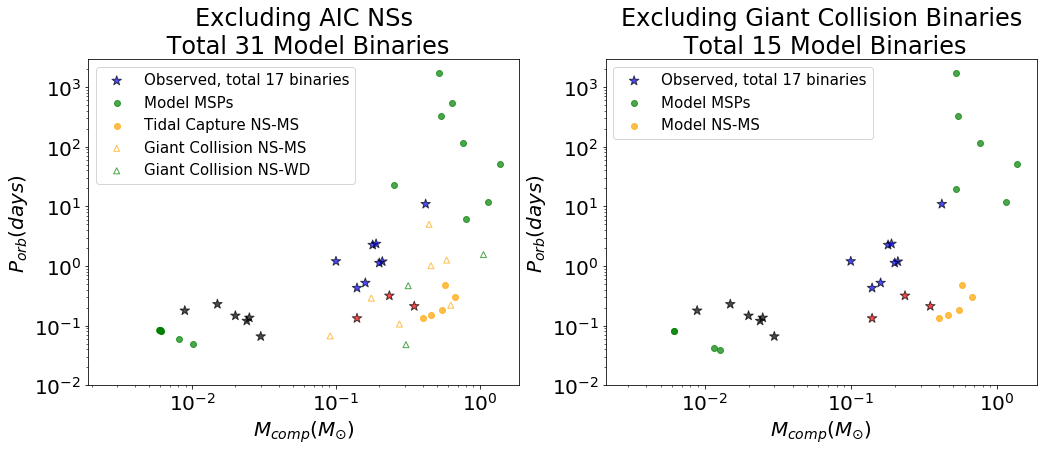

In [14]:
##Ploting Pb-Mc
##r, B, P, rol1, mns, mc, kc, sma, ecc, pb for psr_arrays
print(type47)
color47 = ['b', 'b', 'k', 'k', 'k', 'k', 'b', 'k', 'b', 'b', 'b', 'r', 'r', 'b', 'b', 'k', 'r']


matplotlib.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(ncols = 2, figsize = (17,6))

##NOT AIC
axs[0].scatter(mc47, pb47, marker = '*', s = 100, color = 'k', facecolor = color47, alpha = 0.7, 
               label = 'Observed, total 17 binaries')
axs[0].scatter(psr_notaic_bin_filterucb[5], psr_notaic_bin_filterucb[-1], alpha = 0.7, 
               color = 'g', label = 'Model MSPs')
axs[0].scatter(nsms_tc[1][sn_nsms_91!=4], nsms_tc[-1][sn_nsms_91!=4], marker = 'o', 
               label = 'Tidal Capture NS-MS', alpha = 0.7, color = 'orange')
axs[0].scatter(nsms_gc[1][sn_nsms_81!=4], nsms_gc[-1][sn_nsms_81!=4], marker = '^', facecolor = 'none',
               label = 'Giant Collision NS-MS', alpha = 0.7, color = 'orange')
#axs[0].scatter(nswd_tc[1][sn_nswd_91!=4], nswd_tc[-1][sn_nswd_91!=4], marker = '^', 
#               label = 'Tidal Capture NS-WD', alpha = 0.7, color = 'orange')
axs[0].scatter(nswd_gc_filterucb[1][sn_nswd_81_filterucb!=4], nswd_gc_filterucb[-1][sn_nswd_81_filterucb!=4], 
               marker = '^', facecolor = 'none',
               label = 'Giant Collision NS-WD', alpha = 0.7, color = 'g')

print(len(psr_notaic[5]), len(psr_notaic_bin_filterucb[5]),len(nsms_tc[1][sn_nsms_91!=4]),
      len(nswd_tc_filterucb[1][sn_nswd_91_filterucb!=4]), 
      len(nsms_gc[1][sn_nsms_81!=4]),len(nswd_gc_filterucb[1][sn_nswd_81_filterucb!=4]))

axs[0].set_title('Excluding AIC NSs\n Total 31 Model Binaries')

axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_ylabel(r'$P_{orb}(days)$')
axs[0].set_xlabel(r'$M_{comp}(M_{\odot})$')
axs[0].set_ylim(ymin = 0.01)
axs[0].legend(loc = 'best', fontsize=15)



##NOT GC
axs[1].scatter(mc47, pb47, marker = '*', s = 100, facecolor = color47, alpha = 0.7, 
               color = 'k', label = 'Observed, total 17 binaries')
axs[1].scatter(psr_notgc_bin_filterucb[5], psr_notgc_bin_filterucb[-1], alpha = 0.7, 
               color = 'g', label = 'Model MSPs')
axs[1].scatter(nsms_tc[1], nsms_tc[-1], marker = 'o', 
               label = 'Model NS-MS', alpha = 0.7, color = 'orange')
#axs[1].scatter(nsms_gc[1][sn_nsms_81!=4], nsms_gc[-1][sn_nsms_81!=4], marker = '^', 
#               label = 'Model NS-MS', alpha = 0.7, color = 'orange')
#axs[1].scatter(nswd_tc[1], nswd_tc[-1], marker = '^', 
#               label = 'Model NS-WD', alpha = 0.7, color = 'orange')
#axs[1].scatter(nswd_gc[1][sn_nswd_81!=4], nswd_gc[-1][sn_nswd_81!=4], marker = '^', 
#               label = 'Model NS-WD', alpha = 0.7, color = 'r')

print(len(psr_notgc[5]), len(psr_notgc_bin_filterucb[5]),len(nsms_tc[1]),len(nswd_tc_filterucb[1]))


axs[1].set_title('Excluding Giant Collision Binaries\n Total 15 Model Binaries')

axs[1].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_ylabel(r'$P_{orb}(days)$')
axs[1].set_xlabel(r'$M_{comp}(M_{\odot})$')
axs[1].set_ylim(ymin = 0.01)
axs[1].legend(loc = 'best', fontsize=15)

print(len(psr_bin[5]),len(nsms_tc[1]),len(nswd_tc[1]))

In [9]:
##P-Pdot plot
###Plot B-P of MSPs from models on top of observed data###

##Intrisic Data from 47 Tuc and Terzan 5
data47tuc=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR/kickgrid_runs/MSPBHinGC/data/47tuc_pulsars.dat')
#datater5=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR/kickgrid_runs/MSPBHinGC/data/Terzan5_pulsars.dat')
P47=np.array(data47tuc[:,1]); Pdot47=np.array(data47tuc[:,2]); Pdoterr47=np.array(data47tuc[:,3])
#P5=np.array(datater5[:,2]); Pdot5=np.array(datater5[:,3])


###Model Data###
B_psr = psr_array[1]; P_psr = psr_array[2]
B_notaic_filterucb = psr_notaic_filterucb[1]; P_notaic_filterucb = psr_notaic_filterucb[2]
B_notgc_filterucb = psr_notgc_filterucb[1]; P_notgc_filterucb = psr_notgc_filterucb[2]

Pdot_psr = Kconst*yearsc*B_psr*B_psr/P_psr
Pdot_notaic = Kconst*yearsc*B_notaic*B_notaic/P_notaic
Pdot_notgc = Kconst*yearsc*B_notgc*B_notgc/P_notgc


###Acceleration for the model data### 
dpdotm, dpdotp, pdotlow, pdotup, pmod=ns.get_acceleration('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/msp_accel_529.dat',
                                                          '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/msp_529.dat')
#dpdotm_psr, dpdotp_psr, pdotlow_psr, pdotup_psr, ppsrmod=ns.get_acceleration('/projects/b1095/syr904/projects/PULSAR/kickgrid_runs/MSPBHinGC/data/kickgrid_accl_normalpsr_newmodel.dat',
#                                                                             '/projects/b1095/syr904/projects/PULSAR/kickgrid_runs/MSPBHinGC/data/kickgrid_normalpsr_newmodel.dat')

dpdotm, dpdotp, pdotlow, pdotup=np.array(dpdotm), np.array(dpdotp), np.array(pdotlow), np.array(pdotup)
#dpdotm_psr, dpdotp_psr, pdotlow_psr, pdotup_psr=np.array(dpdotm_psr), np.array(dpdotp_psr), np.array(pdotlow_psr), np.array(pdotup_psr)


###Scaling###
Pdots=Pdots*10**19*1000; Pdotb=Pdotb*10**19*1000
Pdot=Pdot*10**19*1000#; Pdotpsr=Pdotpsr*10**19*1000
pdotlow=pdotlow*10**19*1000; pdotup=pdotup*10**19*1000
#pdotlow_psr=pdotlow_psr*10**19*1000; pdotup_psr=pdotup_psr*10**19*1000

#Death Line
x=np.logspace(-2.0, 2.0, num=50)

matplotlib.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [7, 6]

plt.figure()

##########################
plt.scatter(Ps*0.001, Pdots, c='b', alpha=0.6, s=25, label='Observation')
plt.scatter(Pb*0.001, Pdotb, c='b', alpha=0.6, s=25)
#plt.plot(x, (x**2)*(0.17*10**12), 'k--')    #Deadthline
##########################
plt.scatter(P, Pdot, color='orange', alpha=0.7, s=20, label='Model')
plt.scatter(pmod, pdotlow, color='green', alpha=0.7, facecolor='none', label='Uncertainty Limit')
plt.scatter(pmod, pdotup, color='green', alpha=0.7, facecolor='none')
##########################
plt.errorbar(P47*0.001, Pdot47*10., yerr=Pdoterr47*10., fmt='*', color='red', ms=9, markeredgecolor='k',label='47 Tuc')
#plt.scatter(P5*0.001, Pdot5*10, marker='^', color='red', s=25, edgecolor='k', label='Terzan 5')
##########################
#plt.scatter(Ppsr, Pdotpsr, color='orange', alpha=0.7)
#plt.scatter(ppsrmod, pdotlow_psr, color='green', alpha=0.7, facecolor='none')
#plt.scatter(ppsrmod, pdotup_psr, color='green', alpha=0.7, facecolor='none')
###
#plt.hline(y=0)
###
plt.xscale('log')
plt.yscale('symlog')
plt.xlabel(r'$P(sec)$')
plt.ylabel(r'$\dot{P}\ (\times 10^{-22})$')
plt.ylim(-100000000, 1000000000)
plt.xlim(0.0002, 10.)
#ax.yaxis.set_major_locator(plt.MaxNLocator(3))
#plt.locator_params(nbins=10)
yticks = plt.gca().yaxis.get_major_ticks()
yticks[5].set_visible(False)
plt.locator_params(numticks=10)
plt.tight_layout()
plt.legend(loc='center right', scatterpoints=1, numpoints=1, prop={'size': 12})
#plt.savefig('/projects/b1011/syr904/projects/PULSAR/kickgrid_runs/MSPBHinGC/plots/ppdot_47tucter5.pdf', dpi=300)

NameError: name 'Pdots' is not defined

#t=10250.4

10250.4
#t=11905.8

11905.8
#t=13144.5

13144.5
#t=10080.6

10080.6
#t=10626.3

10626.3
#t=11307.4

11307.4
#t=12253.6

12253.6
#t=13175

13175
#t=14000.2

14000.2


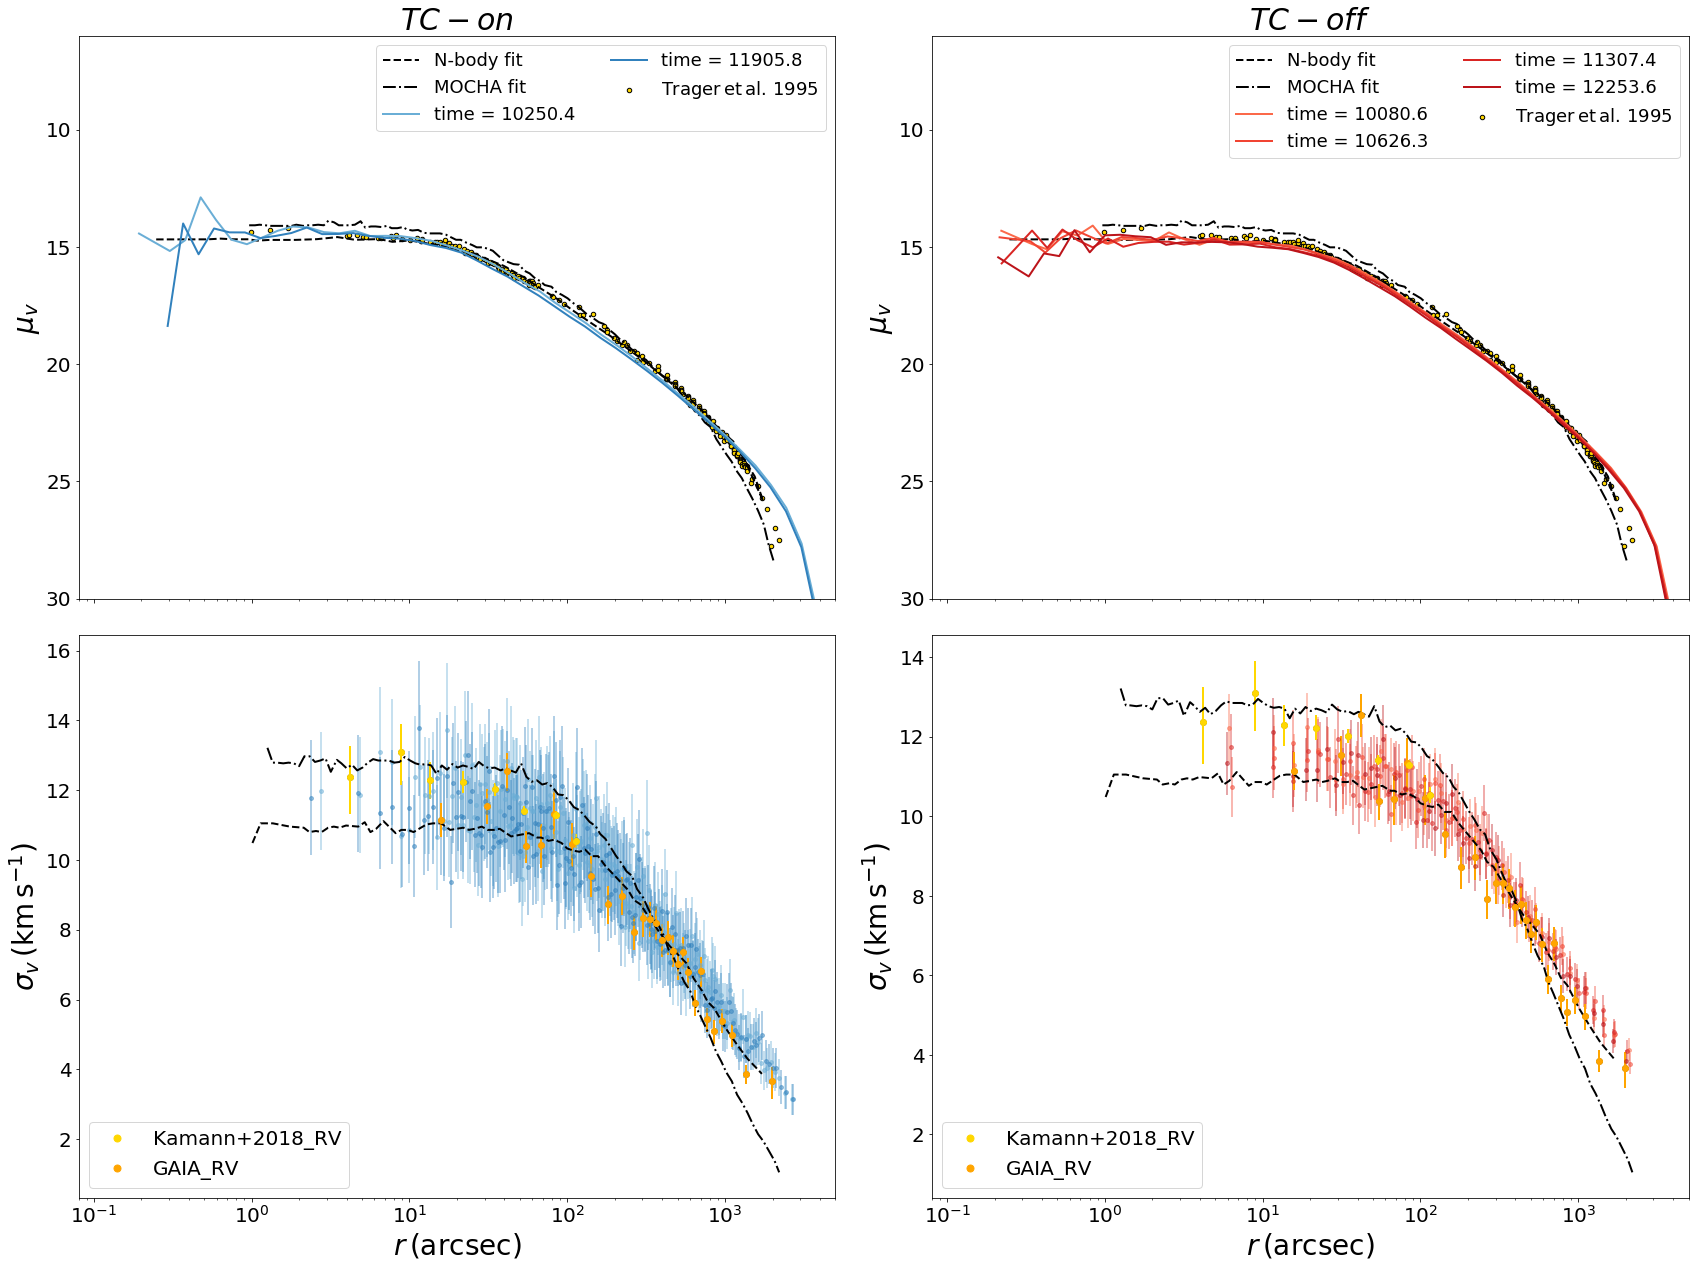

In [4]:
##Model paths: TC_on and TC_off
path=['/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/',
      '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6/']


##Read in observation data
cluster = 'ngc104'

ft = open('makeSBP/trager.dat','r')
linest = ft.readlines()

fv = open('makeSBP/vel_dispersion_profiles.dat','r')
linesv = fv.readlines()

R_sun_obs=4.52


flag = 0
#### find observed SBP from trager file
arcsec_t = []
SB_t = []
for k in range(len(linest)):
        linet = linest[k]
        linet = linet.split('\n')
        linet = linet[0]
        linet = linet.split('\t')
        cluster_tregar = linet[1]
        if cluster_tregar == cluster:
                arcsec_t.append(np.float(linet[2]))
                SB_t.append(np.float(linet[3]))
                flag = 1
arcsec_t = np.array(arcsec_t[:])
SB_t = np.array(SB_t[:])
if flag == 0:
        print('Trager doesnt have the SBP or sigma v profile')
        sys.exit()

flag = 0
#### find observed sigma_v profile
datav = np.genfromtxt('makeSBP/vel_dispersion_profiles.dat')
R_obs = [] # in arcsec
sigma_obs = []
sigma_err_obs_up = []
sigma_err_obs_down = []
for k in range(len(linesv)):
        linev = linesv[k]
        linev = linev.split('\n')
        linev = linev[0]
        linev = linev.split(' ')
        cluster_sigma = linev[0]
        if cluster_sigma == cluster:
                R_obs.append(datav[k,1])
                sigma_obs.append(datav[k,2])
                sigma_err_obs_up.append(datav[k,3])
                sigma_err_obs_down.append(datav[k,4])
                flag = 1
R_obs = np.array(R_obs[:])
sigma_obs = np.array(sigma_obs[:])
sigma_err_obs_up = np.array(sigma_err_obs_up[:])
sigma_err_obs_down = np.array(sigma_err_obs_down[:])
############
if flag == 0:
        print('No observed sigmav profile')
        sys.exit()
        
        
        
##Plotting        
gdot=mlines.Line2D([], [],  linestyle = 'None', color='gold', marker='o',
                  markersize=7, label='Kamann+2018_RV')
odot=mlines.Line2D([], [],  linestyle = 'None', color='orange', marker='o',
                  markersize=7, label='GAIA_RV')
fig, ax=plt.subplots(2, 2, sharex=True, sharey=False, figsize=(24,18))
ax[0][0].set_title(r'$TC-on$', fontsize=30)
ax[0][1].set_title(r'$TC-off$', fontsize=30)
steps = [8, 1]
##Read in model data
for x in range(2):    
    #ax[1][x].scatter(R_obs, sigma_obs,c='gold',s=30, edgecolor='black')
    #ax[1][x].errorbar(R_obs,sigma_obs,yerr=2*sigma_err_obs_up, fmt='o',c='gold', lw=2.0)
    ax[1][x].plot(df_nb_rv['r_arcsec'], df_nb_rv['rv'], lw = 2, ls = '--', color = 'k', label='N-body fit')
    ax[1][x].plot(df_mc_rv['r_arcsec'], df_mc_rv['rv'], lw = 2, ls = '-.', color = 'k', label='MOCHA fit')
    ax[1][x].scatter(r_bg_rv, sigma_bg_rv, s=30, color = 'orange',edgecolor='black')
    ax[1][x].errorbar(r_bg_rv, sigma_bg_rv, yerr=[del_sigmau_bg_rv, del_sigmad_bg_rv], fmt='o', lw = 2.0, color = 'orange')

    ax[1][x].scatter(r_ka, sigma_ka, s=30, color = 'gold', edgecolor='black')
    ax[1][x].errorbar(r_ka, sigma_ka, yerr=[sigma_ka_plus, sigma_ka_minus], fmt='o', lw=2.0, color = 'gold')
    #ax[1][x].scatter([10000,10000],[-5,-5],c='gold',s=30, edgecolor='black',label=r'$\rm{Baumgardt\,&\,Hilker\,(2018)}$')

    ax[0][x].plot(df_nb_nuv['r_arcsec'], df_nb_nuv['nu_v'], lw = 2, ls = '--', color = 'k', label='N-body fit')
    ax[0][x].plot(df_mc_nuv['r_arcsec'], df_mc_nuv['nu_v'], lw = 2, ls = '-.', color = 'k', label='MOCHA fit')
    ax[0][x].scatter(10**arcsec_t[:], SB_t[:],facecolor='gold',edgecolor='black',s=20,label=r'$\rm{Trager\,et\,al.\,1995}$')
    
    snap2D = np.sort(glob(path[x]+'initial.snap*.2Dproj.dat.gz'))
    #print(snap2D)
    snap2D_Ltot = np.sort(glob(path[x]+'initial.snap*.2D_SBP_NCUT.dat'))
    snap2D_L15 = np.sort(glob(path[x]+'initial.snap*.2D_SBPLcut15_NCUT.dat'))
    snap_giant = np.sort(glob(path[x]+'initial.snap*.vel_dispersion_giants_25.dat'))
    #print(snap_giant)

    cs = [cm.Blues(np.linspace(0.5, 1, len(snap2D))), cm.Reds(np.linspace(0.5, 1, len(snap2D)))]

    
    for i in range(0, len(snap2D), steps[x]):
        with gzip.open(snap2D[i], 'r') as f2D:
            first_line=f2D.readline().decode('utf8')
    
        print(first_line)
            
        t_gyr = first_line.strip().split('=')[-1]
        print(t_gyr) 
        if float(t_gyr) > 12500.: continue
        data5 = np.genfromtxt(snap2D_L15[i])
        arcsec = conversions.pc_to_arcsec(data5[:,1],R_sun_obs)
        SB = conversions.SB_converter(data5[:,3])
        SBerr = data5[:,6]/data5[:,5]*SB
        SD = conversions.SD_converter(data5[:,5], R_sun_obs)
        SDerr = conversions.SD_converter(data5[:,6], R_sun_obs)
        

        arcsec_cut = []
        SB_cut = []
        SBerr_cut = []
        arcsec_nd_cut = []
        ND_cut = []
        for k in range(len(SB)):
            if arcsec[k] < 10 and SB[k] > 20:
                Nothing = 0
            else:
                arcsec_cut.append(arcsec[k])
                SB_cut.append(SB[k])
                #SBerr_cut.append(SBerr[k])
                

        dataG = np.genfromtxt(snap_giant[i])
        R_model = conversions.pc_to_arcsec(dataG[:,0],R_sun_obs)
        sigma_model = dataG[:,1]
        sigma_err_model = dataG[:,2]

        ax[0][x].plot(arcsec_cut, SB_cut, lw=2, color=cs[x][i])
        ax[1][x].scatter(R_model, sigma_model,s=15,zorder=2,alpha=0.5, color=cs[x][i])
        ax[1][x].errorbar(R_model,sigma_model,yerr=2*sigma_err_model, fmt='o',markersize=0.01,zorder=1,alpha=0.5, color=cs[x][i])
        #ax2.scatter(R_obs, sigma_obs,c='gold',s=30, edgecolor='black')
        #ax2.errorbar(R_obs,sigma_obs,yerr=2*sigma_err_obs_up, fmt='o',c='gold', lw=2.0)
        #############################

        #ax1.title(cluster,fontsize=24)
        #ax1.text(300,15,cluster,fontsize=20)
        ax[0][x].plot([10000,10000],[-5,-5], lw=2, label='time = '+str(t_gyr), color=cs[x][i])
        #ax1.scatter(10**arcsec_t[:], SB_t[:],facecolor='gold',edgecolor='black',s=20,label=r'$\rm{Trager\,et\,al.\,1995}$')
        ax[0][x].set_xscale('log')
        ax[0][x].set_xlim(0.08,5000)
        ax[0][x].set_ylim(30,6)
        #ax[0][x].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=20)
        ax[0][x].set_ylabel(r'$\mu_v$',fontsize=28)
        ax[0][x].legend(loc='best',scatterpoints=1, ncol=2, prop={'size': 18})
        

        #ax[2][x].scatter([10000,10000],[-5,-5],lw=2,label='time = '+str(t_gyr), color=cs[i])
        #ax2.scatter([10000,10000],[-5,-5],c='gold',s=30, edgecolor='black',label=r'$\rm{Baumgardt\,&\,Hilker\,(2018)}$')
        ax[1][x].set_xscale('log')
        ax[1][x].set_xlim(0.08,5000)
        #ax2.set_ylim(0,10)
        ax[1][x].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=28)
        ax[1][x].set_ylabel(r'$\sigma_v\,(\rm{km\,s^{-1}})$',fontsize=28)
        #ax[1][x].legend(loc=3,scatterpoints=1, ncol=2, prop={'size': 20})
        ax[1][x].legend(loc = 3, handles=[gdot, odot], prop={'size': 20}, numpoints=1, frameon=True)
        
        
        
fig.tight_layout()
#plt.savefig('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/sbp_vel_King_Elson.pdf', dpi=300)

[0.0716051928800315, 0.06698354378043812, 0.07117271911082793, 0.0707206687565288, 0.07073018285935687, 0.06288748496776701, 0.07033303850584761, 0.07054466560192049, 0.07094279927970094, 0.07107642568362722, 0.06008482081980033, 0.07169067805060955, 0.0711358880315096, 0.06451586873291647, 0.07076099259112768, 0.07087240514511642, 0.07034520256825622, 0.07099698839127876, 0.07099829189214699, 0.06950815389563532, 0.07124576379849337, 0.07087006095022523, 0.06788020964614427, 0.07114331328963633, 0.06459783726907, 0.057239970387742416, 0.06843931946558067, 0.06919283373123208, 0.06395477974615858, 0.07055432983486129, 0.07112412761957956, 0.06949582200998876, 0.07087400584218363, 0.07179554155049266, 0.07155749880217258, 0.06004772892128039, 0.059863666819326956, 0.07072404745510408, 0.06958612750256207, 0.07078677907816525, 0.06563198525486812, 0.07009342710817469, 0.06788491421761889, 0.07079869268025361, 0.0712245417465524, 0.0706396985189489, 0.05539613292139293, 0.0716757233608179

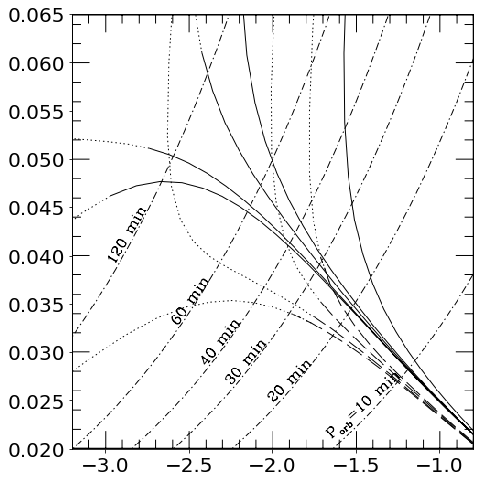

In [42]:
##Not working, WD radius too big for the figure
##Plotting UCB on Figure 4 and 2 of Deloye and Bildsten 2003
def rochradius(m0, m1, sma):  ##sma is in AU, rl is in Rsun
    q = m0/m1   
    p = pow(q, 1.0/3.0)
    rl = 0.49*p*p/(0.6*p*p+math.log(1.0+p))*sma*AU_Rsun
    return rl

rc_bin = []; rc_notgc_bin = []
for kk in range(len(psr_bin[-1])):
    if psr_bin[5][kk]<=0.05:
        rll = rochradius(psr_bin[5][kk], psr_bin[4][kk], psr_bin[-3][kk])
        rc = rll*psr_bin[3][kk]
        rc_bin.append(rc)
print(rc_bin)    
        
fig, axs = plt.subplots(figsize = (10, 8))
plt.scatter(np.log10(psr_bin[5][psr_bin[5]<=0.05]), rc_bin, zorder=0)

img = plt.imread("/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/Deloye_Bildsten_fig4.png")
ext = [-3.2, -0.8, 0.02, 0.065]
axs.imshow(img, zorder=0, extent=ext)
aspect=img.shape[0]/float(img.shape[1])*((ext[1]-ext[0])/(ext[3]-ext[2]))
plt.gca().set_aspect(aspect)



[2.25684 2.3577 0.22979 0.12066 0.13597 0.14725 1.18908 0.06623 1.20172
 1.12618 0.42911 0.21213 0.133 10.9212 0.52194 0.1793 0.3184] [0.18 0.19 0.015 0.024 0.025 0.02 0.21 0.03 0.1 0.2 0.14 0.35 0.14 0.42
 0.16 0.0089 0.235]
5
[array([0.005689]), array([0.005713]), array([0.005717]), array([0.005732]), array([0.005741]), array([0.005824]), array([0.005835]), array([0.005843]), array([0.005851]), array([0.005854]), array([0.005867]), array([0.00588]), array([0.005881]), array([0.005907]), array([0.005913]), array([0.005922]), array([0.00593]), array([0.005932]), array([0.005939]), array([0.00594]), array([0.005966]), array([0.005981]), array([0.006023]), array([0.006025]), array([0.006085]), array([0.006193]), array([0.006216]), array([0.006219]), array([0.00628]), array([0.006453]), array([0.006595]), array([0.007399]), array([0.007511]), array([0.007759]), array([0.008433]), array([0.0096]), array([0.009981]), array([0.011487]), array([0.013325]), array([0.014285]), array([0.306487])

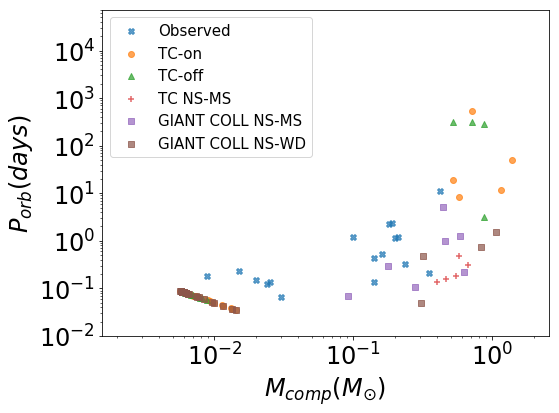

In [4]:
##Pulsars at last snapshot with tidal capture turned on and off
##Observed pulsars
df_obs_psr = pd.read_excel('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/47tuc_pulsars.xlsx', 
                        skiprows = 1, 
                        names = ['Name', 'Offset', 'Periods', 'Pdot', 'DM', 'Pb', 'X', 'Ecc', 'Mcomp'])
pb_47tuc = np.array(df_obs_psr['Pb']); mc_47tuc = np.array(df_obs_psr['Mcomp'])
index_i = np.argwhere(pb_47tuc == 'i')
pb_47tuc = np.delete(pb_47tuc, index_i); mc_47tuc = np.delete(mc_47tuc, index_i)
print(pb_47tuc, mc_47tuc)

##TC-ON pulsars
msp_elson_tcon = np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/msp_last.dat')
sma_tcon = msp_elson_tcon[:,16]; mc_tcon = msp_elson_tcon[:,11]; mns_tcon = msp_elson_tcon[:,10]
sma_tcon = np.delete(sma_tcon, index_100)
mc_tcon = np.delete(mc_tcon, index_100); mns_tcon = np.delete(mns_tcon, index_100)
pb_tcon = [uc.au_to_period(sma_tcon[i], mns_tcon[i], mc_tcon[i]) for i in range(len(sma_tcon))]


##TC-OFF pulsars
msp_elson_tcoff = np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6/msp_last.dat')
sma_tcoff = msp_elson_tcoff[:,17]; mc_tcoff = msp_elson_tcoff[:,14]; mns_tcoff = msp_elson_tcoff[:,13]
index_100 = np.argwhere(mc_tcoff == -100.)
sma_tcoff = np.delete(sma_tcoff, index_100)
mc_tcoff = np.delete(mc_tcoff, index_100); mns_tcoff = np.delete(mns_tcoff, index_100)
pb_tcoff = [uc.au_to_period(sma_tcoff[i], mns_tcoff[i], mc_tcoff[i]) for i in range(len(sma_tcoff))]


##TC NS-MS binaries and collision
nsms_tc = np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/NSMS_last.dat')
mns_nsms = nsms_tc[:,4]; mms_nsms = nsms_tc[:,5]; sma_nsms = nsms_tc[:,8]
tcflag = nsms_tc[:,14]
pb_nsms = [uc.au_to_period(sma_nsms[i], mns_nsms[i], mms_nsms[i]) for i in range(len(sma_nsms))]
index_91 = np.argwhere(tcflag == 91)
index_81 = np.argwhere(tcflag == 81)
mms_nsms_91 = np.take(mms_nsms, index_91); pb_nsms_91 = np.take(pb_nsms, index_91)
print(len(mms_nsms_91))
mms_nsms_81 = np.take(mms_nsms, index_81); pb_nsms_81 = np.take(pb_nsms, index_81)

##TC NS-WD binaries and collision
nswd_tc = np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/NSWD_last.dat')
mns_nswd = nswd_tc[:,4]; mms_nswd = nswd_tc[:,5]; sma_nswd = nswd_tc[:,8]
tcflag_wd = nswd_tc[:,14]
pb_nswd = [uc.au_to_period(sma_nswd[i], mns_nswd[i], mms_nswd[i]) for i in range(len(sma_nswd))]
index_91_wd = np.argwhere(tcflag_wd == 91)
index_81_wd = np.argwhere(tcflag_wd == 81)
mms_nswd_91 = np.take(mms_nswd, index_91_wd); pb_nswd_91 = np.take(pb_nswd, index_91_wd)
mms_nswd_81 = np.take(mms_nswd, index_81_wd); pb_nswd_81 = np.take(pb_nswd, index_81_wd)
mms_sort = sorted(mms_nswd_81)
print(mms_sort)


#print(pb_tcon, mc_tcon)
#print(pb_tcoff, mc_tcoff)
fig, ax = plt.subplots(figsize = (8,6))
ax.scatter(mc_47tuc, pb_47tuc, marker = 'X', alpha = 0.7, label = 'Observed')
ax.scatter(mc_tcon, pb_tcon, alpha = 0.7, label = 'TC-on')
ax.scatter(mc_tcoff, pb_tcoff, marker = '^', alpha = 0.7, label = 'TC-off')
ax.scatter(mms_nsms_91, pb_nsms_91, marker = '+', label = 'TC NS-MS', alpha = 0.7,)
ax.scatter(mms_nsms_81, pb_nsms_81, marker = 's', label = 'GIANT COLL NS-MS', alpha = 0.7,)
#ax.scatter(mms_nswd_91, pb_nswd_91, marker = '+', label = 'TC NS-WD')
ax.scatter(mms_nswd_81, pb_nswd_81, marker = 's', label = 'GIANT COLL NS-WD', alpha = 0.7,)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'$P_{orb}(days)$')
ax.set_xlabel(r'$M_{comp}(M_{\odot})$')
ax.set_ylim(ymin = 0.01)
ax.legend(loc = 'best', fontsize=15)

[2.25684 2.3577 0.22979 0.12066 0.13597 0.14725 1.18908 0.06623 1.20172
 1.12618 0.42911 0.21213 0.133 10.9212 0.52194 0.1793 0.3184] [0.18 0.19 0.015 0.024 0.025 0.02 0.21 0.03 0.1 0.2 0.14 0.35 0.14 0.42
 0.16 0.0089 0.235]


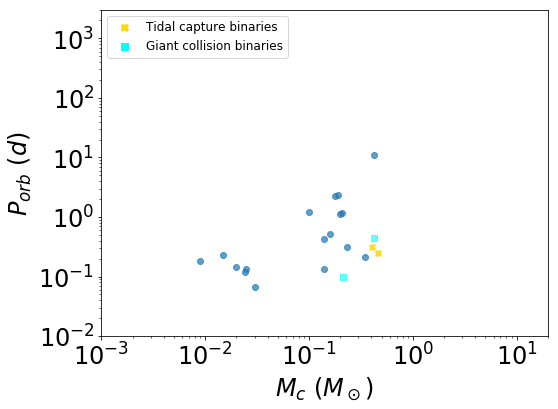

In [9]:
##Compare model pulsars Mc_Period with observed ones
##for tidal capture and giant collision binaries between 9-12 Gyr

###Get model data
##Pulsars at the last timestep
datamsp=np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/msp_last.dat')
datapsr=np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/normalpsr_last.dat')
m0_msp=datamsp[:,10]; m1_msp=datamsp[:,11]; sma_msp=datamsp[:,16]; ecc_msp=datamsp[:,17]
k0_msp=datamsp[:,14]; k1_msp=datamsp[:,15]; B_msp=datamsp[:,4]; P_msp=datamsp[:,5]
id0_msp=datamsp[:,12]; id1_msp=datamsp[:,13]; model_msp=datamsp[:,0]

m0_psr=datapsr[:,10]; m1_psr=datapsr[:,11]; sma_psr=datapsr[:,16]; ecc_psr=datapsr[:,17]
k0_psr=datapsr[:,14]; k1_psr=datapsr[:,15]; B_psr=datapsr[:,4]; P_psr=datapsr[:,5]
id0_psr=datapsr[:,12]; id1_psr=datapsr[:,13]; model_psr=datapsr[:,0]

Pdot_psr=Kconst*yearsc*B_psr*B_psr/P_psr
Pdot_msp=Kconst*yearsc*B_msp*B_msp/P_msp
Pdot_msp=Pdot_msp *10**19*1000; Pdot_psr=Pdot_psr*10**19*1000
P_msp = P_msp*1000; P_psr = P_psr*1000


##Create distinc ids for different models
id0_new_psr = []
for x in range(len(model_psr)):
    id0_new_psr.append(str(int(model_psr[x]))+str(int(id0_psr[x])))
    
id0_new_msp = []
for y in range(len(model_msp)):
    id0_new_msp.append(str(int(model_msp[y]))+str(int(id0_msp[y])))



##NSWD and NSMS binaries that are not MSPs or young pulsars at the last timestep
data13ms=np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/NSMS_last.dat')
data13wd=np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/NSWD_last.dat')

id0_13ms=data13ms[:,2]; id1_13ms=data13ms[:,3]; m0_13ms=data13ms[:,4]; m1_13ms=data13ms[:,5]
sma_13ms=data13ms[:,8]; ecc_13ms=data13ms[:,9]; tcflag_13ms=data13ms[:,14]
model_13ms=data13ms[:,0]
k0_13ms=data13ms[:,6]; k1_13ms=data13ms[:,7]

id0_13wd=data13wd[:,2]; id1_13wd=data13wd[:,3]; m0_13wd=data13wd[:,4]; m1_13wd=data13wd[:,5]
sma_13wd=data13wd[:,8]; ecc_13wd=data13wd[:,9]; tcflag_13wd=data13wd[:,14]
model_13wd=data13wd[:,0]
k0_13wd=data13wd[:,6]; k1_13wd=data13wd[:,7]

##Create distinct ids for different models
id0_new_13ms = []
for x in range(len(model_13ms)):
    id0_new_13ms.append(str(int(model_13ms[x]))+str(int(id0_13ms[x])))
    
id0_new_13wd = []
for y in range(len(model_13wd)):
    id0_new_13wd.append(str(int(model_13wd[y]))+str(int(id0_13wd[y])))


##Tidal capture and giant collision binaries at all times
datatc = np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/all_tc_NSXX.dat')
datacoll = np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/all_coll_NSXX.dat')
time_tc = datatc[:,1]; m0_tc = datatc[:,14]; m1_tc = datatc[:,15]; pb_tc = datatc[:,18]
time_coll = datacoll[:,1]; m0_coll = datacoll[:,14]; m1_coll = datacoll[:,15]
pb_coll = datacoll[:,18]; k1_coll = datacoll[:,13]

m1_tc_912 = []; pb_tc_912 = []
m1_coll_912 = []; pb_coll_912 = []
m1_coll_912_ms = []; pb_coll_912_ms = []
m1_coll_912_hems = []; pb_coll_912_hems = []
m1_coll_912_hewd = []; pb_coll_912_hewd = []
m1_coll_912_other = []; pb_coll_912_other = []
for x in range(len(time_tc)):
    if 9000.<=time_tc[x]<=13000.:
        m1_tc_912.append(m1_tc[x]); pb_tc_912.append(pb_tc[x])

for y in range(len(time_coll)):
    if 9000.<=time_coll[y]<=13000.:
        m1_coll_912.append(m1_coll[y]); pb_coll_912.append(pb_coll[y])
        if k1_coll[y] <= 1:
            m1_coll_912_ms.append(m1_coll[y]); pb_coll_912_ms.append(pb_coll[y])
        elif k1_coll[y] == 7:
            m1_coll_912_hems.append(m1_coll[y]); pb_coll_912_hems.append(pb_coll[y])
        elif k1_coll[y] == 10:
            m1_coll_912_hewd.append(m1_coll[y]); pb_coll_912_hewd.append(pb_coll[y])
        else:
            m1_coll_912_other.append(m1_coll[y]); pb_coll_912_other.append(pb_coll[y])

                                        
###Get observed data
df_obs_psr = pd.read_excel('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/47tuc_pulsars.xlsx', 
                        skiprows = 1, 
                        names = ['Name', 'Offset', 'Periods', 'Pdot', 'DM', 'Pb', 'X', 'Ecc', 'Mcomp'])
pb_47tuc = np.array(df_obs_psr['Pb']); mc_47tuc = np.array(df_obs_psr['Mcomp'])
index_i = np.argwhere(pb_47tuc == 'i')
pb_47tuc = np.delete(pb_47tuc, index_i); mc_47tuc = np.delete(mc_47tuc, index_i)
print(pb_47tuc, mc_47tuc)

###Plotting
plt.rcParams['figure.figsize'] = [8,6]
rdot=mlines.Line2D([], [],  linestyle = 'None', color='r', marker='o',
                  markersize=7, label='Redbacks')
kdot=mlines.Line2D([], [],  linestyle = 'None', color='k', marker='o',
                  markersize=7, label='Black widows')
bdot=mlines.Line2D([], [],  linestyle = 'None', color='b', marker='o',
                  markersize=7, label='Others')
gtri=mlines.Line2D([], [],  linestyle = 'None', color='g', marker='^',
                  markersize=7, label='Others')
cross=mlines.Line2D([], [],  linestyle = 'None', color='gold', marker='X',
                  markersize=7, label='Tidal capture binaries')
square=mlines.Line2D([], [],  linestyle = 'None', color='aqua', marker='s',
                  markersize=7, label='Giant collision binaries')
tri=mlines.Line2D([], [],  linestyle = 'None', color='g', marker='^',
                  markersize=7, label='Others')


fig, axs = plt.subplots(nrows=1, sharey=False)
            
##Observed data
axs.scatter(mc_47tuc, pb_47tuc, alpha = 0.7, label = 'Observed')        

axs.scatter(m1_tc_912, pb_tc_912, marker = 'X', color = 'gold', alpha=0.8)
#axs.scatter(m1_coll_912, pb_coll_912, label = 'GIANT COLL BINARIES')
axs.scatter(m1_coll_912_ms, pb_coll_912_ms, marker = 's', color = 'gold', alpha=0.8)
axs.scatter(m1_coll_912_hems, pb_coll_912_hems, marker = 's', color = 'green', alpha=0.6)
axs.scatter(m1_coll_912_hewd, pb_coll_912_hewd, marker = 's', color = 'aqua', alpha=0.6)
axs.scatter(m1_coll_912_other, pb_coll_912_other, marker = 's', color = 'violet', alpha=0.6)
        
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_ylim(0.01, 3000)
axs.set_xlim(0.001, 20)
axs.set_xlabel(r'$M_c\ (M_\odot)$')
axs.set_ylabel(r'$P_{orb}\ (d)$')
axs.legend(handles=[cross, square], loc='upper left', prop={'size': 12}, numpoints=1, frameon=True)

In [ ]:
##Model paths: King and Elson
path=['/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/MOCHA47Tuc_150maxmass_rv1.4/', 
      '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/MOCHA47Tuc_elson_rv4_3e6/']


##Read in observation data
cluster = 'ngc104'

ft = open('makeSBP/trager.dat','r')
linest = ft.readlines()

fv = open('makeSBP/vel_dispersion_profiles.dat','r')
linesv = fv.readlines()

R_sun_obs=4.5


flag = 0
#### find observed SBP from trager file
arcsec_t = []
SB_t = []
for k in range(len(linest)):
        linet = linest[k]
        linet = linet.split('\n')
        linet = linet[0]
        linet = linet.split('\t')
        cluster_tregar = linet[1]
        if cluster_tregar == cluster:
                arcsec_t.append(np.float(linet[2]))
                SB_t.append(np.float(linet[3]))
                flag = 1
arcsec_t = np.array(arcsec_t[:])
SB_t = np.array(SB_t[:])
if flag == 0:
        print('Trager doesnt have the SBP or sigma v profile')
        sys.exit()

flag = 0
#### find observed sigma_v profile
datav = np.genfromtxt('makeSBP/vel_dispersion_profiles.dat')
R_obs = [] # in arcsec
sigma_obs = []
sigma_err_obs_up = []
sigma_err_obs_down = []
for k in range(len(linesv)):
        linev = linesv[k]
        linev = linev.split('\n')
        linev = linev[0]
        linev = linev.split(' ')
        cluster_sigma = linev[0]
        if cluster_sigma == cluster:
                R_obs.append(datav[k,1])
                sigma_obs.append(datav[k,2])
                sigma_err_obs_up.append(datav[k,3])
                sigma_err_obs_down.append(datav[k,4])
                flag = 1
R_obs = np.array(R_obs[:])
sigma_obs = np.array(sigma_obs[:])
sigma_err_obs_up = np.array(sigma_err_obs_up[:])
sigma_err_obs_down = np.array(sigma_err_obs_down[:])
############
if flag == 0:
        print('No observed sigmav profile')
        sys.exit()
        

datasd_miocchi = np.genfromtxt('makeSBP/miocchi.dat')
arcsec_sd_miocchi = datasd_miocchi[:,0]
sd_obs_miocchi = 10**np.array(datasd_miocchi[:,1])
sd_err_miocchi = 10**np.array(datasd_miocchi[:,2])


datasd_deboer = np.genfromtxt('makeSBP/deboer.dat')
arcsec_sd_deboer = np.array(datasd_deboer[:,0])*60
sd_obs_deboer = np.array(datasd_deboer[:,1])/3600.
sd_err_deboer = np.array(datasd_deboer[:,2])/3600.

data_text=np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/MOCHA47Tuc_elson_rv4_2e6/initial.snap0422.2D_SBPLcut15_NCUT.dat')
arcsec_text=conversions.pc_to_arcsec(data_text[:,1],R_sun_obs)
ND_text = conversions.SD_converter(data_text[:,7], R_sun_obs)

fig, ax=plt.subplots(3, 2, sharex=True, sharey=False, figsize=(22,26))
ax[0][0].set_title(r'$King\ Profile,\ M_f=9.23\ M_{\odot}$', fontsize=30)
ax[0][1].set_title(r'$Elson\ Profile,\ M_f=9.16\ M_{\odot}$', fontsize=30)
ax[1][1].plot(arcsec_text, ND_text, color='black', ls='--', label='Final mass: 5.87e5 Msun')
##Read in model data
for x in range(2):    
    ax[2][x].scatter(R_obs, sigma_obs,c='gold',s=30, edgecolor='black')
    ax[2][x].errorbar(R_obs,sigma_obs,yerr=2*sigma_err_obs_up, fmt='o',c='gold', lw=2.0)
    ax[2][x].scatter([10000,10000],[-5,-5],c='gold',s=30, edgecolor='black',label=r'$\rm{Baumgardt\,&\,Hilker\,(2018)}$')

    ax[1][x].errorbar(arcsec_sd_deboer, sd_obs_deboer, yerr = sd_err_deboer,
                      fmt='o', c='gold', lw=2.0, label=r'$\rm{De\ Boer\,et\,al.\,2019}$')
    ax[1][x].errorbar(arcsec_sd_miocchi, sd_obs_miocchi, yerr = sd_err_miocchi, fmt='o',
                      c='green', lw=2.0, label=r'$\rm{Miocchi\,et\,al.\,2013}$')
    
    ax[0][x].scatter(10**arcsec_t[:], SB_t[:],facecolor='gold',edgecolor='black',s=20,label=r'$\rm{Trager\,et\,al.\,1995}$')
    
    snap2D = np.sort(glob(path[x]+'initial.snap*.2Dproj.dat.gz'))
    print(snap2D)
    snap2D_Ltot = np.sort(glob(path[x]+'initial.snap*.2D_SBP_NCUT.dat'))
    snap2D_L15 = np.sort(glob(path[x]+'initial.snap*.2D_SBPLcut15_NCUT.dat'))
    snap_giant = np.sort(glob(path[x]+'initial.snap*.vel_dispersion_giants_25.dat'))

    cs = [cm.Blues(np.linspace(0.5, 1, len(snap2D))), cm.Reds(np.linspace(0.5, 1, len(snap2D)))]

    
    for i in range(0, len(snap2D)):
        with gzip.open(snap2D[i], 'r') as f2D:
            first_line=f2D.readline().decode('utf8')
    
        print(first_line)
            
        t_gyr = first_line.strip().split('=')[-1]
        print(t_gyr) 
        data5 = np.genfromtxt(snap2D_L15[i])
        arcsec = conversions.pc_to_arcsec(data5[:,1],R_sun_obs)
        SB = conversions.SB_converter(data5[:,3])
        SBerr = data5[:,6]/data5[:,5]*SB
        SD = conversions.SD_converter(data5[:,5], R_sun_obs)
        SDerr = conversions.SD_converter(data5[:,6], R_sun_obs)
        ND = conversions.SD_converter(data5[:,7], R_sun_obs)
        NDerr = conversions.SD_converter(data5[:,8], R_sun_obs)
        #print(ND)
        

        arcsec_cut = []
        SB_cut = []
        SBerr_cut = []
        arcsec_nd_cut = []
        ND_cut = []
        for k in range(len(SB)):
            if arcsec[k] < 10 and SB[k] > 20:
                Nothing = 0
            else:
                arcsec_cut.append(arcsec[k])
                SB_cut.append(SB[k])
                #SBerr_cut.append(SBerr[k])
            if ND[k]==0:
                continue
            else:
                ND_cut.append(ND[k])
                arcsec_nd_cut.append(arcsec[k])
            

        dataG = np.genfromtxt(snap_giant[i])
        R_model = conversions.pc_to_arcsec(dataG[:,0],R_sun_obs)
        sigma_model = dataG[:,1]
        sigma_err_model = dataG[:,2]

        ax[0][x].plot(arcsec_cut, SB_cut, lw=2, color=cs[x][i])
        ax[1][x].plot(arcsec_nd_cut, ND_cut, lw=2, color=cs[x][i])
        ax[2][x].scatter(R_model, sigma_model,s=15,zorder=2,alpha=0.5, color=cs[x][i])
        ax[2][x].errorbar(R_model,sigma_model,yerr=2*sigma_err_model, fmt='o',markersize=0.01,zorder=1,alpha=0.5, color=cs[x][i])
        #ax2.scatter(R_obs, sigma_obs,c='gold',s=30, edgecolor='black')
        #ax2.errorbar(R_obs,sigma_obs,yerr=2*sigma_err_obs_up, fmt='o',c='gold', lw=2.0)
        #############################

        #ax1.title(cluster,fontsize=24)
        #ax1.text(300,15,cluster,fontsize=20)
        ax[0][x].plot([10000,10000],[-5,-5], lw=2, label='time = '+str(t_gyr), color=cs[x][i])
        #ax1.scatter(10**arcsec_t[:], SB_t[:],facecolor='gold',edgecolor='black',s=20,label=r'$\rm{Trager\,et\,al.\,1995}$')
        ax[0][x].set_xscale('log')
        ax[0][x].set_xlim(0.03,5000)
        ax[0][x].set_ylim(30,6)
        #ax[0][x].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=20)
        ax[0][x].set_ylabel(r'$\mu_v$',fontsize=24)
        ax[0][x].legend(loc='best',scatterpoints=1, ncol=2, prop={'size': 18})
        
        ax[1][x].set_xscale('log')
        ax[1][x].set_yscale('log')
        ax[1][x].set_ylabel(r'$\Sigma(arcsec^{-2})$')
        #ax[1][x].set_ylim(0, 35)
        ax[1][x].legend(loc=3, scatterpoints=1, ncol=2, prop={'size': 20})

        #ax[2][x].scatter([10000,10000],[-5,-5],lw=2,label='time = '+str(t_gyr), color=cs[i])
        #ax2.scatter([10000,10000],[-5,-5],c='gold',s=30, edgecolor='black',label=r'$\rm{Baumgardt\,&\,Hilker\,(2018)}$')
        ax[2][x].set_xscale('log')
        ax[2][x].set_xlim(0.03,5000)
        #ax2.set_ylim(0,10)
        ax[2][x].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=24)
        ax[2][x].set_ylabel(r'$\sigma_v\,(\rm{km\,s^{-1}})$',fontsize=24)
        ax[2][x].legend(loc=3,scatterpoints=1, ncol=2, prop={'size': 20})
        
        
        
fig.tight_layout()
plt.savefig('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/sbp_sdp_vel.pdf', dpi=300)

In [ ]:
##Model paths: King and Elson
path=['/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/MOCHA47Tuc_150maxmass_rv1.4/', 
      '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/MOCHA47Tuc_elson_rv4_3e6/']


##Read in observation data
cluster = 'ngc104'

ft = open('makeSBP/trager.dat','r')
linest = ft.readlines()

fv = open('makeSBP/vel_dispersion_profiles.dat','r')
linesv = fv.readlines()

R_sun_obs=4.5


flag = 0
#### find observed SBP from trager file
arcsec_t = []
SB_t = []
for k in range(len(linest)):
        linet = linest[k]
        linet = linet.split('\n')
        linet = linet[0]
        linet = linet.split('\t')
        cluster_tregar = linet[1]
        if cluster_tregar == cluster:
                arcsec_t.append(np.float(linet[2]))
                SB_t.append(np.float(linet[3]))
                flag = 1
arcsec_t = np.array(arcsec_t[:])
SB_t = np.array(SB_t[:])
if flag == 0:
        print('Trager doesnt have the SBP or sigma v profile')
        sys.exit()

flag = 0
#### find observed sigma_v profile
datav = np.genfromtxt('makeSBP/vel_dispersion_profiles.dat')
R_obs = [] # in arcsec
sigma_obs = []
sigma_err_obs_up = []
sigma_err_obs_down = []
for k in range(len(linesv)):
        linev = linesv[k]
        linev = linev.split('\n')
        linev = linev[0]
        linev = linev.split(' ')
        cluster_sigma = linev[0]
        if cluster_sigma == cluster:
                R_obs.append(datav[k,1])
                sigma_obs.append(datav[k,2])
                sigma_err_obs_up.append(datav[k,3])
                sigma_err_obs_down.append(datav[k,4])
                flag = 1
R_obs = np.array(R_obs[:])
sigma_obs = np.array(sigma_obs[:])
sigma_err_obs_up = np.array(sigma_err_obs_up[:])
sigma_err_obs_down = np.array(sigma_err_obs_down[:])
############
if flag == 0:
        print('No observed sigmav profile')
        sys.exit()
        

fig, ax=plt.subplots(2, 2, sharex=True, sharey=False, figsize=(24,18))
ax[0][0].set_title(r'$King\ Profile,\ M_f=9.23\times10^5\ M_{\odot}$', fontsize=30)
ax[0][1].set_title(r'$Elson\ Profile,\ M_f=9.16\times10^5\ M_{\odot}$', fontsize=30)
##Read in model data
for x in range(2):    
    ax[1][x].scatter(R_obs, sigma_obs,c='gold',s=30, edgecolor='black')
    ax[1][x].errorbar(R_obs,sigma_obs,yerr=2*sigma_err_obs_up, fmt='o',c='gold', lw=2.0)
    ax[1][x].scatter([10000,10000],[-5,-5],c='gold',s=30, edgecolor='black',label=r'$\rm{Baumgardt\,&\,Hilker\,(2018)}$')

    ax[0][x].scatter(10**arcsec_t[:], SB_t[:],facecolor='gold',edgecolor='black',s=20,label=r'$\rm{Trager\,et\,al.\,1995}$')
    
    snap2D = np.sort(glob(path[x]+'initial.snap*.2Dproj.dat.gz'))
    print(snap2D)
    snap2D_Ltot = np.sort(glob(path[x]+'initial.snap*.2D_SBP_NCUT.dat'))
    snap2D_L15 = np.sort(glob(path[x]+'initial.snap*.2D_SBPLcut15_NCUT.dat'))
    snap_giant = np.sort(glob(path[x]+'initial.snap*.vel_dispersion_giants_25.dat'))
    #print(snap_giant)

    cs = [cm.Blues(np.linspace(0.5, 1, len(snap2D))), cm.Reds(np.linspace(0.5, 1, len(snap2D)))]

    
    for i in range(0, len(snap2D)):
        with gzip.open(snap2D[i], 'r') as f2D:
            first_line=f2D.readline().decode('utf8')
    
        print(first_line)
            
        t_gyr = first_line.strip().split('=')[-1]
        print(t_gyr) 
        if float(t_gyr) > 12500.: continue
        data5 = np.genfromtxt(snap2D_L15[i])
        arcsec = conversions.pc_to_arcsec(data5[:,1],R_sun_obs)
        SB = conversions.SB_converter(data5[:,3])
        SBerr = data5[:,6]/data5[:,5]*SB
        SD = conversions.SD_converter(data5[:,5], R_sun_obs)
        SDerr = conversions.SD_converter(data5[:,6], R_sun_obs)
        

        arcsec_cut = []
        SB_cut = []
        SBerr_cut = []
        arcsec_nd_cut = []
        ND_cut = []
        for k in range(len(SB)):
            if arcsec[k] < 10 and SB[k] > 20:
                Nothing = 0
            else:
                arcsec_cut.append(arcsec[k])
                SB_cut.append(SB[k])
                #SBerr_cut.append(SBerr[k])
                

        dataG = np.genfromtxt(snap_giant[i])
        R_model = conversions.pc_to_arcsec(dataG[:,0],R_sun_obs)
        sigma_model = dataG[:,1]
        sigma_err_model = dataG[:,2]

        ax[0][x].plot(arcsec_cut, SB_cut, lw=2, color=cs[x][i])
        ax[1][x].scatter(R_model, sigma_model,s=15,zorder=2,alpha=0.5, color=cs[x][i])
        ax[1][x].errorbar(R_model,sigma_model,yerr=2*sigma_err_model, fmt='o',markersize=0.01,zorder=1,alpha=0.5, color=cs[x][i])
        #ax2.scatter(R_obs, sigma_obs,c='gold',s=30, edgecolor='black')
        #ax2.errorbar(R_obs,sigma_obs,yerr=2*sigma_err_obs_up, fmt='o',c='gold', lw=2.0)
        #############################

        #ax1.title(cluster,fontsize=24)
        #ax1.text(300,15,cluster,fontsize=20)
        ax[0][x].plot([10000,10000],[-5,-5], lw=2, label='time = '+str(t_gyr), color=cs[x][i])
        #ax1.scatter(10**arcsec_t[:], SB_t[:],facecolor='gold',edgecolor='black',s=20,label=r'$\rm{Trager\,et\,al.\,1995}$')
        ax[0][x].set_xscale('log')
        ax[0][x].set_xlim(0.03,5000)
        ax[0][x].set_ylim(30,6)
        #ax[0][x].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=20)
        ax[0][x].set_ylabel(r'$\mu_v$',fontsize=28)
        ax[0][x].legend(loc='best',scatterpoints=1, ncol=2, prop={'size': 18})
        

        #ax[2][x].scatter([10000,10000],[-5,-5],lw=2,label='time = '+str(t_gyr), color=cs[i])
        #ax2.scatter([10000,10000],[-5,-5],c='gold',s=30, edgecolor='black',label=r'$\rm{Baumgardt\,&\,Hilker\,(2018)}$')
        ax[1][x].set_xscale('log')
        ax[1][x].set_xlim(0.03,5000)
        #ax2.set_ylim(0,10)
        ax[1][x].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=28)
        ax[1][x].set_ylabel(r'$\sigma_v\,(\rm{km\,s^{-1}})$',fontsize=28)
        ax[1][x].legend(loc=3,scatterpoints=1, ncol=2, prop={'size': 20})
        
        
        
fig.tight_layout()
plt.savefig('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/sbp_vel_King_Elson.pdf', dpi=300)

In [ ]:
##Model paths: TC_on
path='/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/'

R_sun_obs=4.52

#######################################################
##Read in observation data
cluster = 'ngc104'

ft = open('makeSBP/trager.dat','r')
linest = ft.readlines()

fv = open('makeSBP/vel_dispersion_profiles.dat','r')
linesv = fv.readlines()


flag = 0
#### find observed SBP from trager file
arcsec_t = []
SB_t = []
for k in range(len(linest)):
        linet = linest[k]
        linet = linet.split('\n')
        linet = linet[0]
        linet = linet.split('\t')
        cluster_tregar = linet[1]
        if cluster_tregar == cluster:
                arcsec_t.append(np.float(linet[2]))
                SB_t.append(np.float(linet[3]))
                flag = 1
arcsec_t = np.array(arcsec_t[:])
SB_t = np.array(SB_t[:])
if flag == 0:
        print('Trager doesnt have the SBP or sigma v profile')
        sys.exit()

flag = 0
#### find observed sigma_v profile
datav = np.genfromtxt('makeSBP/vel_dispersion_profiles.dat')
R_obs = [] # in arcsec
sigma_obs = []
sigma_err_obs_up = []
sigma_err_obs_down = []
for k in range(len(linesv)):
        linev = linesv[k]
        linev = linev.split('\n')
        linev = linev[0]
        linev = linev.split(' ')
        cluster_sigma = linev[0]
        if cluster_sigma == cluster:
                R_obs.append(datav[k,1])
                sigma_obs.append(datav[k,2])
                sigma_err_obs_up.append(datav[k,3])
                sigma_err_obs_down.append(datav[k,4])
                flag = 1
R_obs = np.array(R_obs[:])
sigma_obs = np.array(sigma_obs[:])
sigma_err_obs_up = np.array(sigma_err_obs_up[:])
sigma_err_obs_down = np.array(sigma_err_obs_down[:])
############
if flag == 0:
        print('No observed sigmav profile')
        sys.exit()
        
        
##Number density observation data
datasd_miocchi = np.genfromtxt('makeSBP/miocchi.dat')
arcsec_sd_miocchi = datasd_miocchi[:,0]
sd_obs_miocchi = 10**np.array(datasd_miocchi[:,1])
sd_err_miocchi = 10**np.array(datasd_miocchi[:,2])


datasd_deboer = np.genfromtxt('makeSBP/deboer.dat')
arcsec_sd_deboer = np.array(datasd_deboer[:,0])*60
sd_obs_deboer = np.array(datasd_deboer[:,1])/3600.
sd_err_deboer = np.array(datasd_deboer[:,2])/3600.


##Trager data with uncertainties
from astropy.table import Table
data_t = Table.read('makeSBP/sbp_trager1995/trager1995_ngc104.fits')
rarcsec_trager = data_t['r[ARCSEC]']
sbp_trager = data_t['s[MAG/ARCSEC2]']
sbperr_trager = data_t['e_s[MAG/ARCSEC2]']

######################################################
##Model data
snap2D = path+'initial.snap0529.2Dproj.dat.gz'
#print(snap2D)
snap2D_Ltot = path+'initial.snap0529.2D_SBP_NCUT0.8.dat'
snap2D_L15 = path+'initial.snap0529.2D_SBPLcut15_NCUT0.8.dat'
#snap_veldisp = path+'initial.snap0529.vel_dispersion_giants_vr_pm_700_0.8.dat'
snap_veldisp = path+'initial.snap0529.vel_dispersion_giants_vr_pm_200.dat'
#print(snap_giant)

    
with gzip.open(snap2D, 'r') as f2D:
    first_line=f2D.readline().decode('utf8')
    
    print(first_line)
            
    t_gyr = first_line.strip().split('=')[-1]
    print(t_gyr) 

data5 = np.genfromtxt(snap2D_L15)
arcsec = conversions.pc_to_arcsec(data5[:,1],R_sun_obs)
SB = conversions.SB_converter(data5[:,3])
SBerr = data5[:,6]/data5[:,5]*SB
SD = conversions.SD_converter(data5[:,5], R_sun_obs)
SDerr = conversions.SD_converter(data5[:,6], R_sun_obs)

data_nd = np.genfromtxt(snap2D_Ltot)
ND = conversions.SD_converter(data_nd[:,7], R_sun_obs)
NDerr = conversions.SD_converter(data_nd[:,8], R_sun_obs)

        
arcsec_cut = []
SB_cut = []
SBerr_cut = []

for k in range(len(SB)):
    if arcsec[k] < 10 and SB[k] > 20:
        Nothing = 0
    else:
        arcsec_cut.append(arcsec[k])
        SB_cut.append(SB[k])
        #SBerr_cut.append(SBerr[k])
            
            
    
arcsec_nd_cut = []
ND_cut = []
for j in range(len(ND)):
    #if ND[j]==0:
    #    continue
    #else:
    ND_cut.append(ND[j])
    arcsec_nd_cut.append(arcsec[j])
        
                

data_vel = np.genfromtxt(snap_veldisp)
R_model = conversions.pc_to_arcsec(data_vel[:,0],R_sun_obs)
sigma_model = data_vel[:,1]
sigma_err_model = data_vel[:,2]


####################################################      
##Plotting        
gdot=mlines.Line2D([], [],  linestyle = 'None', color='gold', marker='o',
                  markersize=7, label='Kamann+2018_RV')
odot=mlines.Line2D([], [],  linestyle = 'None', color='orange', marker='o',
                  markersize=7, label='GAIA_RV')
fig, ax=plt.subplots(nrows = 3, sharex=True, sharey=False, figsize=(18,25))

########################
##Plotting in observed data 
ax[2].errorbar(arcsec_sd_deboer, sd_obs_deboer, yerr = sd_err_deboer,
                      fmt='o', c='gold', lw=2.0, label=r'$\rm{De\ Boer\,et\,al.\,2019}$')
ax[2].errorbar(arcsec_sd_miocchi, sd_obs_miocchi, yerr = sd_err_miocchi, fmt='o',
                      c='green', lw=2.0, label=r'$\rm{Miocchi\,et\,al.\,2013}$')

#ax[1].scatter(R_obs, sigma_obs,c='gold',s=30, edgecolor='black')
#ax[1].errorbar(R_obs,sigma_obs,yerr=2*sigma_err_obs_up, fmt='o',c='gold', lw=2.0)
ax[1].plot(df_nb_rv['r_arcsec'], df_nb_rv['rv'], lw = 2, ls = '--', color = 'k', label='N-body fit')
ax[1].plot(df_mc_rv['r_arcsec'], df_mc_rv['rv'], lw = 2, ls = '-.', color = 'k', label='MOCHA fit')

ax[1].scatter(r_bg_rv, sigma_bg_rv, s=30, color = 'orange',edgecolor='black')
ax[1].errorbar(r_bg_rv, sigma_bg_rv, yerr=[del_sigmau_bg_rv, del_sigmad_bg_rv], fmt='o', lw = 2.0, color = 'orange')
ax[1].scatter(r_ka, sigma_ka, s=30, color = 'gold', edgecolor='black')
ax[1].errorbar(r_ka, sigma_ka, yerr=[sigma_ka_plus, sigma_ka_minus], fmt='o', lw=2.0, color = 'gold')
#ax[1].scatter([10000,10000],[-5,-5],c='gold',s=30, edgecolor='black',label=r'$\rm{Baumgardt\,&\,Hilker\,(2018)}$')

ax[0].plot(df_nb_nuv['r_arcsec'], df_nb_nuv['nu_v'], lw = 2, ls = '--', color = 'k', label='N-body fit')
ax[0].plot(df_mc_nuv['r_arcsec'], df_mc_nuv['nu_v'], lw = 2, ls = '-.', color = 'k', label='MOCHA fit')

ax[0].scatter(10**arcsec_t, SB_t,facecolor='gold',edgecolor='black',s=40,label=r'$\rm{Trager\,et\,al.\,1995}$')
#ax[0].scatter(rarcsec_trager, sbp_trager, facecolor='gold',edgecolor='black',s=30,
#              label=r'$\rm{Trager\,et\,al.\,1995}$')
#ax[0].errorbar(rarcsec_trager, sbp_trager, yerr = sbperr_trager, fmt='o', lw = 2.0, color = 'gold',
#               label=r'$\rm{Trager\,et\,al.\,1995}$')

#######################
##Plotting model data
ax[0].plot(arcsec_cut, SB_cut, lw=2)
ax[1].scatter(R_model, sigma_model,s=15,zorder=2)
ax[1].errorbar(R_model,sigma_model,yerr=sigma_err_model, fmt='o',markersize=0.01,zorder=1)
ax[2].plot(arcsec_nd_cut, ND_cut, lw=2)
#ax2.scatter(R_obs, sigma_obs,c='gold',s=30, edgecolor='black')
#ax2.errorbar(R_obs,sigma_obs,yerr=2*sigma_err_obs_up, fmt='o',c='gold', lw=2.0)


#######################
ax[0].plot([10000,10000],[-5,-5], lw=2, label='time = '+str(t_gyr))
#ax1.scatter(10**arcsec_t[:], SB_t[:],facecolor='gold',edgecolor='black',s=20,label=r'$\rm{Trager\,et\,al.\,1995}$')
ax[0].set_xscale('log')
ax[0].set_xlim(0.08,5000)
ax[0].set_ylim(30,6)
#ax[0][x].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=20)
ax[0].set_ylabel(r'$\mu_v$',fontsize=28)
ax[0].legend(loc='best',scatterpoints=1, ncol=2, prop={'size': 18})
    

ax[1].set_xscale('log')
ax[1].set_xlim(0.08,5000)
#ax2.set_ylim(0,10)
ax[1].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=28)
ax[1].set_ylabel(r'$\sigma_v\,(\rm{km\,s^{-1}})$',fontsize=28)
#ax[1][x].legend(loc=3,scatterpoints=1, ncol=2, prop={'size': 20})
ax[1].legend(loc = 3, handles=[gdot, odot], prop={'size': 20}, numpoints=1, frameon=True)\
    
    
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=28)
ax[2].set_ylabel(r'$\Sigma(arcsec^{-2})$')
#ax[1][x].set_ylim(0, 35)
ax[2].legend(loc=3, scatterpoints=1, ncol=2, prop={'size': 20})
        
        
        
fig.tight_layout()
#plt.savefig('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/sbp_vel_King_Elson.pdf', dpi=300)

In [ ]:
##Comapring proper motions
distance = 4.52 ##kpc
dec_47 = -(72.+4.*60.+52.7*3600)*np.pi/180.

def err_sigma(f, a, b, sigma_a, sigma_b, err_a, err_b):   ##f = sqrt(a*A^2+b*B^2)
    return np.sqrt((sigma_a/f)**2*a**2*err_a**2 + (sigma_b/f)**2*b**2*err_b**2)

def err_ratio(f, sigma_a, sigma_b, err_a, err_b):   ##f = A/B
    return np.abs(f)*np.sqrt((err_a/sigma_a)**2 + (err_b/sigma_b)**2)
    

##From Watkins_2015
df_watkins = np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/watkins2015_pm.txt', dtype = str)
gc_name_wk = df_watkins[:,0]
r_wk = df_watkins[:,3][gc_name_wk == 'NGC0104'].astype(np.float)  ##in arcsec
r_wk_err = df_watkins[:,4][gc_name_wk == 'NGC0104'].astype(np.float)
sigma_wk = df_watkins[:,5][gc_name_wk == 'NGC0104'].astype(np.float)  ##in mas/yr
sigma_wk_err = df_watkins[:,6][gc_name_wk == 'NGC0104'].astype(np.float)
tr_ratio_wk = df_watkins[:,7][gc_name_wk == 'NGC0104'].astype(np.float)
tr_ratio_err_wk = df_watkins[:,8][gc_name_wk == 'NGC0104'].astype(np.float)

##From Heyl_2017
df_heyl = pd.read_excel('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/heyl2017_pm.xlsx',
                        names = ['r_proj', 'sigmar_u', 'sigmar_d', 'sigmat_u', 'sigmat_d'])
r_hy = df_heyl['r_proj']*60.  ##in arcsec
sigmar_hy_u = df_heyl['sigmar_u']; sigmar_hy_d = df_heyl['sigmar_d']  ##in mas/yr
sigmat_hy_u = df_heyl['sigmat_u']; sigmat_hy_d = df_heyl['sigmat_d']  ##in mas/yr
sigmar_hy = (sigmar_hy_u+sigmar_hy_d)/2.; sigmar_hy_err = [sigmar_hy_u-sigmar_hy, sigmar_hy-sigmar_hy_d]
sigmat_hy = (sigmat_hy_u+sigmat_hy_d)/2.; sigmat_hy_err = [sigmat_hy_u-sigmat_hy, sigmat_hy-sigmat_hy_d]

sigma_hy = np.sqrt(sigmar_hy**2+sigmat_hy**2)/np.sqrt(2)
sigma_hy_err = [[],[]]
sigma_hy_err[0] = err_sigma(sigma_hy, 0.5, 0.5, sigmar_hy, sigmat_hy, sigmar_hy_err[0], sigmat_hy_err[0])
sigma_hy_err[1] = err_sigma(sigma_hy, 0.5, 0.5, sigmar_hy, sigmat_hy, sigmar_hy_err[1], sigmat_hy_err[1])
tr_ratio_hy = np.array(sigmat_hy)/np.array(sigmar_hy)
tr_ratio_hy_err = [[],[]]
tr_ratio_hy_err[0] = err_ratio(tr_ratio_hy, sigmat_hy, sigmar_hy, sigmat_hy_err[0], sigmar_hy_err[0])
tr_ratio_hy_err[1] = err_ratio(tr_ratio_hy, sigmat_hy, sigmar_hy, sigmat_hy_err[1], sigmar_hy_err[1])



##From Gaia EDR3
df_bg = pd.read_excel('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/Baumgardt_vel_dispersion_profile_47Tuc.xlsx',
                      names = ['name1', 'name2', 'r_proj', 'sigma', 'del_sigma_up', 'del_sigma_low', 'type'])
type_bg = df_bg['type']
r_bg = df_bg['r_proj'][type_bg == 'GEDR3']  ##in arcsec
sigma_bg = df_bg['sigma'][type_bg == 'GEDR3'] ##in km/s
del_sigmau_bg = df_bg['del_sigma_up'][type_bg == 'GEDR3']
del_sigmad_bg = df_bg['del_sigma_low'][type_bg == 'GEDR3']

df_vb = pd.read_excel('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/pm_tr_ratio_vasiliev_baumgardt2021.xlsx',
                      names = ['r_arcmin', 'tr_ratio1_up', 'tr_ratio1_down', 'tr_ratio1', 'tr_ratio', 'err_up', 'err_down'])
r_vb = df_vb['r_arcmin']*60.
tr_ratio_vb = df_vb['tr_ratio']
tr_ratio_vb_err = [df_vb['err_up'], df_vb['err_down']]

##From models
#df_model_529 = np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/initial.snap0529.vel_dispersion_giants_vr_pm_700_0.8.dat')
df_model_529 = np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/initial.snap0529.vel_dispersion_giants_vr_pm_200.dat')
r2d = df_model_529[:,0]  ##in pc
sigma_pmr = df_model_529[:,3]; sigma_pmr_err = df_model_529[:,4]  ##in km/s
sigma_pmt = df_model_529[:,5]; sigma_pmt_err = df_model_529[:,6]
#sigma_pm = df_model_529[:,-2]; sigma_pm_err = df_model_529[:,-1]
sigma_pm = np.sqrt(sigma_pmr**2+sigma_pmt**2)/np.sqrt(2)
sigma_pm_err = err_sigma(sigma_pm, 0.5, 0.5, sigma_pmr, sigma_pmt, sigma_pmr_err, sigma_pmt_err)
tr_ratio = sigma_pmt/sigma_pmr
tr_ratio_err = err_ratio(tr_ratio, sigma_pmt, sigma_pmr, sigma_pmt_err, sigma_pmr_err)


##Conerting units
r2d_arcsec = uc.pc2arcsec(distance, r2d)
sigma_wk_kms = uc.pm2vel(distance, sigma_wk)
print(sigma_wk_kms)
sigma_wk_err_kms = uc.pm2vel(distance, sigma_wk_err)

sigmar_hy_kms = uc.pm2vel(distance, sigmar_hy); sigmat_hy_kms = uc.pm2vel(distance, sigmat_hy)
sigma_hy_kms = uc.pm2vel(distance, sigma_hy)
sigma_hy_err_kms = [[], []]
sigma_hy_err_kms[0] = uc.pm2vel(distance, sigma_hy_err[0]); sigma_hy_err_kms[1] = uc.pm2vel(distance, sigma_hy_err[1])
sigmar_hy_err_kms = [[], []]; sigmat_hy_err_kms = [[], []]
sigmar_hy_err_kms[0] = uc.pm2vel(distance, sigmar_hy_err[0]); sigmar_hy_err_kms[1] = uc.pm2vel(distance, sigmar_hy_err[1])
sigmat_hy_err_kms[0] = uc.pm2vel(distance, sigmat_hy_err[0]); sigmat_hy_err_kms[1] = uc.pm2vel(distance, sigmat_hy_err[1])




##Plotting
rdot=mlines.Line2D([], [],  linestyle = 'None', color='red', marker='o',
                  markersize=7, alpha=0.6, label='GEDR3')
bdot=mlines.Line2D([], [],  linestyle = 'None', color='BLUE', marker='o',
                  markersize=7, alpha=0.6, label='Hely+2017')
odot=mlines.Line2D([], [],  linestyle = 'None', color='orange', marker='o',
                  markersize=7, alpha=0.6, label='Watkins+2015')
gdot=mlines.Line2D([], [],  linestyle = 'None', color='gray', marker='o',
                  markersize=7, label='Model')
kline = mlines.Line2D([], [],  linestyle = '--', color='k', linewidth = 1.5, label='N-body fit')



matplotlib.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(ncols = 2, figsize = (18, 6))
axs[0].plot(df_nb_pm['r_arcsec'], df_nb_pm['pm'], lw = 1.5, ls = '--', color = 'k', label='N-body fit')
axs[0].errorbar(r2d_arcsec,sigma_pm ,yerr=sigma_pm_err, fmt='o',markersize=0.01, alpha=0.9, color = 'darkgray')
axs[0].scatter(r2d_arcsec, sigma_pm, s=15, alpha=0.9, color = 'darkgray')
axs[0].errorbar(r_wk,sigma_wk_kms ,yerr=sigma_wk_err_kms, fmt='o',markersize=0.01, alpha=0.6, color = 'orange')
axs[0].scatter(r_wk, sigma_wk_kms, s=15, alpha = 0.6, color = 'orange')
axs[0].scatter(r_bg, sigma_bg, s=15, alpha = 0.6, color = 'red')
axs[0].errorbar(r_bg, sigma_bg, yerr=[del_sigmau_bg, del_sigmad_bg], fmt='o',markersize=0.01, alpha=0.6, color = 'red')
axs[0].scatter(r_hy, sigma_hy_kms, s=15, alpha = 0.6, color = 'blue')
axs[0].errorbar(r_hy, sigma_hy_kms, yerr=sigma_hy_err_kms, fmt='o',markersize=0.01, alpha=0.6, color = 'blue')
#axs[0].scatter(r_hy, sigmar_hy_kms, s=15, alpha = 0.6)
#axs[0].errorbar(r_hy, sigmar_hy_kms, yerr=sigmar_hy_err_kms, fmt='o',markersize=0.01, alpha=0.6)
#axs[0].scatter(r_hy, sigmat_hy_kms, s=15, alpha = 0.6)
#axs[0].errorbar(r_hy, sigmat_hy_kms, yerr=sigmat_hy_err_kms, fmt='o',markersize=0.01, alpha=0.6)
axs[0].set_xscale('log')
axs[0].set_xlabel(r'$r_{2D}\,(arcsec)$')
axs[0].set_ylabel(r'$\sigma\,(km/s)$')
axs[0].legend(handles=[kline], loc = 'best', prop={'size': 12})


axs[1].axhline(y=1, color = 'grey', alpha=0.5)
axs[1].errorbar(r_wk, tr_ratio_wk, yerr = tr_ratio_err_wk, fmt = 'o', markersize=0.01, alpha=0.6, color = 'orange')
axs[1].scatter(r_wk, tr_ratio_wk, s=15, alpha=0.6, color = 'orange')
axs[1].errorbar(r_hy, tr_ratio_hy, yerr = tr_ratio_hy_err, fmt = 'o', markersize=0.01, alpha=0.6, color = 'blue')
axs[1].scatter(r_hy, tr_ratio_hy, s=15, alpha=0.6, color = 'blue')
axs[1].errorbar(r_vb, tr_ratio_vb, yerr = tr_ratio_vb_err, fmt = 'o', markersize=0.01, alpha=0.6, color = 'red')
axs[1].scatter(r_vb, tr_ratio_vb, s=15, alpha=0.6, color = 'red')
axs[1].errorbar(r2d_arcsec, tr_ratio, yerr = tr_ratio_err, fmt = 'o', markersize=0.01, alpha=0.9, color = 'darkgray')
axs[1].scatter(r2d_arcsec, tr_ratio, s=15, alpha=0.9, color = 'darkgray')
axs[1].set_xscale('log')
axs[1].set_xlabel(r'$r_{2D}\,(arcsec)$')
axs[1].set_ylabel(r'$\sigma_t/\sigma_r$')
#axs[1].legend(loc = 'best')
axs[1].legend(handles=[gdot, odot, bdot, rdot], loc='best', prop={'size': 15}, numpoints=1, frameon=True)


In [ ]:
##Compare 2d and 3d accelerations
dataacc=np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/MOCHA47Tuc_elson_rv4_3e6/msp_accel_last.dat')
datapsr=np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/MOCHA47Tuc_elson_rv4_3e6/msp_last.dat')

model=dataacc[:,0]; id0=dataacc[:,1]; id1=dataacc[:,2]
r2d=dataacc[:,5]; Mr2d=dataacc[:,7]
r3d=dataacc[:,6]; Mr3d=dataacc[:,8]
vz=dataacc[:,14]
rx=dataacc[:,9]; ry=dataacc[:,10]; rz=dataacc[:,11]

A=datapsr[:,17]; ecc=datapsr[:,18]; M0=datapsr[:,13]; M1=datapsr[:,14]; P=datapsr[:,5]; B=datapsr[:,4]
Pdot=Kconst*yearsc*np.array(B)*np.array(B)/np.array(P)

MAXAL_2D = []; MAXAL_3D = []; P_2D = []; P_3D = []
for i in range(len(id0)):
    maxal_2d, pdotmin_2d, pdotmax_2d, p_2d = ns.add_acceleration_GCpotential_max(r2d[i], vz[i], Pdot[i], P[i], Mr2d[i])
    maxal_3d, pdotmin_3d, pdotmax_3d, p_3d = ns.add_acceleration_GCpotential_3D(r3d[i], vz[i], Pdot[i], P[i], Mr3d[i], rx[i], ry[i], rz[i])
    MAXAL_2D.append(maxal_2d*10**6); MAXAL_3D.append(maxal_3d*10**6)
    P_2D.append(p_2d*1000); P_3D.append(p_3d*1000)
    
print(MAXAL_2D, MAXAL_3D)
plt.figure()
plt.scatter(P_2D, MAXAL_2D, label = '2D', alpha=0.5)
plt.scatter(P_3D, MAXAL_3D, label = '3D', alpha=0.5)
plt.yscale('symlog')
plt.legend(loc='best', fontsize=15)

In [ ]:
##Cluster acceleration from the model
def Acc_los_model(d47 = 4.52):
    modelpath='/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/'
    l_conv = dyn.conv('l', modelpath+'initial.conv.sh')
    
    ##From snapshot file
    rbin = np.linspace(0., 23.645332, 249)  ##in code unit
    
    mbin = []
    mtot = 0
    i_count = 1
    with gzip.open(modelpath+'initial.snap0529.dat.gz', 'r') as fsnap:
        next(fsnap); next(fsnap)
        for line in fsnap:
            data = line.split()
        
            if float(data[2])>rbin[i_count]:
                mbin.append(mtot)
                i_count += 1
            
            mtot+=float(data[1])
                 
    mbin.append(mtot)

    acc_max = Gconst_sun*np.array(mbin)/(rbin[1:]*l_conv)**2*(1e6/(PC*0.01))#*math.sqrt(1./3.)
    acc_min = -Gconst_sun*np.array(mbin)/(rbin[1:]*l_conv)**2*(1e6/(PC*0.01))#*(math.sqrt(1./3.))
    #theta_bin = rbin[1:]*l_conv*math.sqrt(2./3.)/(d47*1000.)*180/np.pi*60
    theta_bin = rbin[1:]*l_conv/(d47*1000.)*180/np.pi*60
    
    ##From 2D projection
    rbin_2d = np.linspace(0., 91.9501, 249)  ##in parsec
    
    mbin_2d = []
    mtot_2d = 0
    i_count_2d = 1
    with gzip.open(modelpath+'initial.snap0529.2Dproj.dat.gz', 'r') as f2d:
        next(f2d); next(f2d)
        for line in f2d:
            data = line.split()
        
            if float(data[0])>rbin_2d[i_count_2d]:
                mbin_2d.append(mtot_2d)
                i_count_2d += 1
            
            mtot_2d+=float(data[9])
                 
    mbin_2d.append(mtot_2d)

    acc_max_2d = 1.1*Gconst_sun*np.array(mbin_2d)/(np.pi*rbin_2d[1:]**2)*(1e6/(PC*0.01))
    acc_min_2d = -1.1*Gconst_sun*np.array(mbin_2d)/(np.pi*rbin_2d[1:]**2)*(1e6/(PC*0.01))
    theta_bin_2d = rbin_2d[1:]/(d47*1000.)*180/np.pi*60

    return theta_bin, acc_max, acc_min, theta_bin_2d, acc_max_2d, acc_min_2d

    #fig, axs = plt.subplots(figsize = (8,6))
    #axs.plot(theta_bin, acc_max*1e9, color = 'b')
    #axs.plot(theta_bin, acc_min*1e9, color = 'b')
    #axs.plot(theta_bin_2d, acc_max_2d*1e9, color = 'g', ls = '--')
    #axs.plot(theta_bin_2d, acc_min_2d*1e9, color = 'g', ls = '--')
    #axs.set_xlim(xmin = 0, xmax = 5)
    
    
#Acc_los_model()




##Line-of-acceleration profile and cumulative projected radial distribution of observed pulsars & model NSs 
#####################################
##Line-of-sight acceleration
##Observation
data47= np.genfromtxt('/projects/b1095/syr904/projects/massive_clusters/47Tuc_psr_acceleration.dat', dtype = str)
pspin = data47[:,6].astype(np.float); pobs_dot = (data47[:,7].astype(np.float))*1e-21
pm_alpha = data47[:,8].astype(np.float); pm_delta = data47[:,9].astype(np.float)
dec = data47[:,10].astype(np.float)

theta_los = data47[:,2].astype(np.float)
algc_max = data47[:,11].astype(np.float)
algc = data47[:,12].astype(np.float); algc_uncert = data47[:,13].astype(np.float)


d47 = 4.52  ##kpc
##The difference between the accelerations of the Solar system and 47 Tuc.
a47 = -1.172*1e-10 ## m/s^−2
#pm_alpha = 4; pm_delta = 1
#delta = -(72.+5./60.+1.48/3600.)
#pobs_dot = -4.56*1e-21; pspin = 4.554447383906 ##ms


##Calculate 47Tuc-X acceleration
#pbx = 10.921183545  #day
#pb_dotx = 6*1e-12 
#pm_alphax = 5.8; pm_deltax = -3.3; deltax = -72.021512
#pobs_dotx = 18.3609*1e-21; pspinx = 4.77152291069355 ##ms
#pm2x = pm_deltax**2+(pm_alphax*np.cos(deltax))**2
#vt2x = (pm2x/1e6)*(4.74*d47*1000.)**2*1e6 ##(m/s)^2
#Ax = pb_dotx/(pbx*24.*3600.)*(clight/100.)
#Bx = vt2x/(d47*1000.*PC/100.)
#algcx = Ax-Bx-a47
#print(algcx)

#print(np.cos(np.pi))
##Calculate algc upper limits
pm2 = pm_delta**2+(pm_alpha*np.cos(dec*np.pi/180))**2
vt2 = (pm2/1e6)*(4.74*d47*1000.)**2*1e6 ##(m/s)^2

A = pobs_dot/(pspin/1000.)*(clight/100.)
B = vt2/(d47*1000.*PC/100.)

print(B)

al_max = A-B-a47
print(al_max)
print(np.array(B[algc!=-100]*1e9)/np.abs(algc[algc!=-100]))
print(np.array(B[algc==-100]*1e9)/np.abs(algc[algc==-100]))

##Model
the_bin, accmax, accmin, the_bin_2d, accmax_2d, accmin_2d = Acc_los_model(d47 = 4.52)

matplotlib.rcParams.update({'font.size': 20})

fig, axs = plt.subplots(ncols = 2, figsize = (17, 6))
axs[0].scatter(theta_los[algc==-100], algc_max[algc==-100], marker = 'v', color = 'k')
axs[0].errorbar(theta_los[algc!=-100], algc[algc!=-100], yerr = algc_uncert[algc!=-100], fmt = 'o', markersize = 4, 
                color = 'orange')
axs[0].plot(the_bin, accmax*1e9, color = 'b', label = r'$\frac{GM(<r)}{r^2}$')
axs[0].plot(the_bin, accmin*1e9, color = 'b')
axs[0].plot(the_bin_2d, accmax_2d*1e9, color = 'g', ls = '--', label = r'$max(a_l), Phinney 1992$')
axs[0].plot(the_bin_2d, accmin_2d*1e9, color = 'g', ls = '--')
axs[0].set_xlim(xmin = 0, xmax = 5)
    
axs[0].set_xlabel(r'$\theta_{\perp} (arcmin)$')
axs[0].set_ylabel(r'$a_l\,(10^{-9}ms^{-2})$')
axs[0].legend(loc = 'best', fontsize = 15)


#######################################
##Cumulative radial distribution
modelpath = '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/'
datamsp = np.genfromtxt(modelpath+'msp_529.dat')
id_msp = datamsp[:,12]; sn_msp = datamsp[:,18]; tc_msp = datamsp[:,19]


rpc = []; m_tot = []; rpc_msp = []; mtot_msp = []
with gzip.open(modelpath+'initial.snap0529.2Dproj.dat.gz', 'r') as f2d:
        next(f2d); next(f2d)
        for line in f2d:
            data2d = line.split()
            if int(data2d[2]) == 1:
                if int(data2d[5]) == 13 or int(data2d[6]) == 13: 
                    rpc.append(float(data2d[0])); m_tot.append(float(data2d[9]))
                    if float(data2d[13]) in id_msp or float(data2d[14]) in id_msp:
                        rpc_msp.append(float(data2d[0])); mtot_msp.append(float(data2d[9]))
                        
                
            else:
                if int(data2d[3]) == 13: 
                    rpc.append(float(data2d[0])); m_tot.append(float(data2d[9]))
                    if float(data2d[12]) in id_msp:
                        rpc_msp.append(float(data2d[0])); mtot_msp.append(float(data2d[9]))
                    
r_proj = np.array(rpc)/(d47*1000.)*180/np.pi*60*60
r_proj_msp = np.array(rpc_msp)/(d47*1000.)*180/np.pi*60*60

axs[1].hist(r_proj, bins = np.logspace(np.log10(min(r_proj)), np.log10(3500), 50), 
            cumulative = True, density = True, histtype = 'step', lw = 2., label = 'All NSs')
axs[1].hist(r_proj_msp, bins = np.logspace(np.log10(min(r_proj_msp)), np.log10(3500), 50), 
            cumulative = True, density = True, histtype = 'step', lw = 2., label = 'MSPs')
axs[1].hist(theta_los*60, bins = np.logspace(np.log10(min(theta_los*60)), np.log10(3500), 15), 
            cumulative = True, density = True, histtype = 'step', lw = 2., color = 'k', 
            label = 'Observed 47 Tuc pulsars')
axs[1].set_xscale('log')
axs[1].set_xlim(xmin = 0.5, xmax = 3500.)
axs[1].set_xlabel(r'$r_{2D}\,(arcsec)$')
axs[1].set_ylabel('Cumulative Number Distribution')
axs[1].legend(loc = 'upper left', fontsize = 12)


plt.figure()
plt.hist(m_tot, bins = np.logspace(np.log10(min(m_tot)), np.log10(max(m_tot)), 50), histtype = 'step', 
         label = 'All NSs')
plt.hist(mtot_msp, bins = np.logspace(np.log10(min(mtot_msp)), np.log10(max(mtot_msp)), 50), histtype = 'step',
         label = 'MSPs')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(xmin = 0.1)
plt.xlabel(r'$M\,(M_{\odot})$')
plt.legend(loc = 'best')